# Geological Interpretor Development

This is a notebook for testing and developping some of the basic code in this package.

### Some initial imports

In [ ]:
import numpy as np
import scipy.spatial as spatial
import matplotlib.pyplot as plt
from matplotlib import patheffects
import pandas as pd
import owlready2 as owl
class MalissiaBaseError(Exception):
    """This is the base class for all exceptions of this package"""
    
class MalissiaNotImplementedYet(MalissiaBaseError):
    """This is an exception for features that are not yet implemented"""

## Geological Knowledge Manager

**GeologicalKnowledgeManager** may know different instances of **GeologicalKnowledgeFramework**,<br>
for example to allow differenciating scenarios or for allowing customisation of knowledge and its formalisation.

**GeologicalKnowledgeFramework** provides access to concept definitions for providing knowledge.

In [ ]:
import os
import random

class GeologicalKnowledgeManager(object):
    """GeologicalKnowledgeManager is managing one or several GeologicalKnowledgeFramework.
    
    The GeologicalKnowledgeManager is typically a singleton, so there is always one and only one instance of it.
    
    The GeologicalKnowledgeManager may know different instances of GeologicalKnowledgeFramework,
    for example to allow different interpretation scenarios or for allowing user-specific customisation
    of knowledge and its formalisation.
    
    GeologicalKnowledgeFramework are typically ontologies and extensions defined in this package or elsewhere.
    """
    
    def __new__(cls):
        """Method to access (and create if needed) the only allowed instance of this class.
        
        Returns:
        - an instance of GeologicalKnowledgeManager"""
        if not hasattr(cls, 'instance'):
            cls.instance = super(GeologicalKnowledgeManager, cls).__new__(cls)
            cls.initialised= False
        return cls.instance
        
    def __init__(self, default= "mogi", default_source_directory= "../ontologies/", default_source_file= "mogi.owl", default_ontology_backend= "owlready2"):
        """Initializes the GeologicalKnowledgeManager with some default values from configuration.
        
        Parameters:
        - default: specifies the name of the default knowledge framework
        - default_source_directory: specifies the default folder containing of the knowledge framework definitions
        - default_source_file: file contained in the source_directory defining the knowledge framework (e.g., .owl file)
        - default_ontology_backend: specifies the default ontology backend to be used
        """
        if not self.initialised:
            self._initialise(default= default, default_source_directory= default_source_directory, default_source_file= default_source_file, default_ontology_backend= default_ontology_backend)
            
    def _initialise(self, default, default_source_directory, default_source_file, default_ontology_backend):
        """Initializes the GeologicalKnowledgeManager with some default values from configuration.
        
        Parameters:
        - default: specifies the name of the default knowledge framework
        - default_source_directory: specifies the default folder containing of the knowledge framework definitions
        - default_source_file: file contained in the source_directory defining the knowledge framework (e.g., .owl file)
        - default_ontology_backend: specifies the default ontology backend to be used
        """
        self.default= default
        self.default_source_directory= default_source_directory
        self.default_source_file= default_source_file
        self.default_ontology_backend= default_ontology_backend
        
        self.knowledge_framework_dict = {}
        
        self.initialised= True
        
    def reset(self, default= "mogi", default_source_directory= "../ontologies/", default_source_file= "mogi.owl", default_ontology_backend= "owlready2"):
        """Reinitializes the GeologicalKnowledgeManager with some default values from configuration.
        
        Parameters:
        - default: specifies the name of the default knowledge framework
        - default_source_directory: specifies the default folder containing of the knowledge framework definitions
        - default_source_file: file contained in the source_directory defining the knowledge framework (e.g., .owl file)
        - default_ontology_backend: specifies the default ontology backend to be used
        """
        self._initialise(default= default, default_source_directory= default_source_directory, default_source_file= default_source_file, default_ontology_backend= default_ontology_backend)
             
    def load_knowledge_framework(self, name=None, source= None, source_directory= None, backend= None):
        """Gets and initilises the ontology from the specified source.
        
        Parameters:
        - name: the name to be given to the knowledge framework. If None (default) the file name will be used.
        - source: filename to the ontology source. If None(default) the default ontology is used.
        - source_directory: where the system should look for ontology definition files. If None, the `GeologicalKnowledgeFramework` will decide.
        - backend: the ontology backend to be used. If None, the `GeologicalKnowledgeFramework` will decide."""
        source = source if source is not None else self.default_source_file
        name = name if name is not None else os.path.basename(source).split(os.path.extsep)[0]
        self.knowledge_framework_dict[name] = GeologicalKnowledgeFramework(name= name, source= source, source_directory= source_directory, backend= backend)
    
    def get_knowledge_framework(self,name= "default"):
        """Accessor to knowledge frameworks."""
        name = self.default if name == "default" else name
        assert len(self.knowledge_framework_dict) > 0, "No ontology has been loaded yet. Please use GeologicalKnowledgeManager().load_knowledge_framework() first"
        assert name in self.knowledge_framework_dict.keys(), "The specified ontology hasn't been loaded: "+name+\
            "\navailable ontology names are: "+"\n".join(self.knowledge_framework_dict.keys())
        return self.knowledge_framework_dict[name]
    
class GeologicalKnowledgeFramework(object):
    """A GeologicalKnowledgeFramework holds the definition of concepts and relationships describing knowledge.
    
    This is typically an overlay around a formal ontology definition, which also brings additional capabilities,
    such as algorithms and factories to achieve specific tasks and create objects.
    
    This knowledge framework also holds 

    - a registry of available constructors for making new objects:
     -- registered_constructors: a dictionnary holding the constructors for a given class, sorted in order of preference,
         structured as {class_object or key: [constructor1, constructor2,...]}
     -- constructor_conditions: conditions for the application of a constructor,
       e.g., regarding InterpretationSituation, interpretor status, and parameters.
        Structured as dictionnaries {constructor: function_to_evaluate_conditions}

    - a registry of available evaluators for evaluating objects:
     -- registered_constructors: a dictionnary holding the evaluators for a given class, sorted in order of preference,
         structured as {class_object or key: [evaluator1, evaluator2,...]}

    - a registry of available updaters for making new objects:
     -- registered_constructors: a dictionnary holding the updaters for a given class, sorted in order of preference,
         structured as {class_object or key: [updater1, updater2,...]}
     -- updater_conditions: conditions for the application of an updater,
       e.g., regarding InterpretationSituation, interpretor status, and parameters.
        Structured as dictionnaries {updater: function_to_evaluate_updaters}

    
        """


    # registry of object constructors and conditions
    registered_constructors = {}
    constructor_conditions = {}
    
    # registry of evaluators
    registered_internal_consistency_evaluation = {}
    registered_explanation_consistency_evaluation = {}

    # registry of updaters and conditions
    registered_updaters = {}
    updater_conditions = {}

    
    def __init__(self, name, source, source_directory= None, backend= None):
        """Initialise a KnowledgeFramework form a given ontology file (source).
        
        Parameters:
        - name: should be the name under which this KnowledgeFramework is known in the manager
        - source: the source file for the ontology definition
        - source_directory: the directory where the source files for the ontology definition are looked for.
        If None (default) the default path provided by the `KnowledgeManager` is used.
        - backend: the ontology backend to be used for this knwoledge framework.
        If None (default) the default ontology backend provided by the `KnowledgeManager` is used."""
        self.name= name
        
        self._source_directory= None
        self.init_source_directory(source_directory)
        self.initialise_ontology_backend(backend)
        
        self.load_ontology(source)
            
    
    def init_source_directory(self, source_directory):
        """Initialises the folder where source files are searched.
        
        Parameters:
        - source_directory: if None, the previous value is used if it wasn't None, else the `GeologicalKnowledgeManager`default is used."""
        if source_directory is not None:
            self._source_directory= source_directory
        elif self._source_directory is None:
            self._source_directory= GeologicalKnowledgeManager().default_source_directory
    
    def initialise_ontology_backend(self, backend_name:str= None):
        """Initializes the ontology package used as a backend to access ontologies.
        
        This will:
        - try to import the backend as onto
        - set the default path for ontologies"""
                
        self._ontology_backend = None
        backend_name= GeologicalKnowledgeManager().default_ontology_backend if backend_name is None else backend_name
        if backend_name == "owlready2":
            try:
                import owlready2 as owl2 
                self._ontology_backend = owl2
                if self._source_directory not in self._ontology_backend.onto_path:
                    self._ontology_backend.onto_path.append(self._source_directory)
            except ImportError:
                raise ImportError("Your are trying to use Owlready2 as a backend for ontology management, but it doesn't appear to be installed."\
                "This is either because OwlReady2 is given as default option or because you asked for it."\
                "Please install the OwlReady2 package from https://owlready2.readthedocs.io"\
                "or give another backend through GeologicalKnowledgeManager().initialise_ontology_backend()")
                
            # also test if java is correctly installed & accessible, as it is used by owlready2 for reasoning
            try:
                os.system("java -version")
            except:
                raise ImportError("Java doesn't appear to be installed properly as the command `java -version` returned an error."\
                    "This error occured while loading owlready2 package as an ontology backend, because java is used for the reasoning engine.")
        else:
            raise Exception("The specified backed for ontology is not supported: "+backend_name)
          
        
    def load_ontology(self, source):
        """Loads the ontology specified by source.
        
        Parameters:
        - source: the source file for the ontology definition
        - source_directory: the directory where the source files for the ontology definition are looked for.
        If None (default) the default path provided by the `KnowledgeManager` is used."""
        self._source= source
        try:
            self._onto = self._ontology_backend.get_ontology(self._source).load()
        except Exception as err:
            raise Exception("Unexpected exception received while loading ontology:\n - source: {}\n - onto_path: {}".format(self._source, self._ontology_backend.onto_path))
        
    def __call__(self):
        return self._onto
        
    def get_ontology_backend(self):
        """Gets the ontology backend"""
        assert self._ontology_backend is not None, "Trying to access the ontology backend without initialising it."
        return self._ontology_backend
    
    def search(self, name= None, type= None, qualities= None, prepend_star=True) -> list:
        """Search function to interface the serach capabilities of the internal ontology
        
        Parameters:
        - name: the name of the search object (you can use * to replace any set of characters and ? to replace any single character)
        Note: if `prepend_star` a * is always prepended to allows the search to work because of the internal prefix names
        - type: the type of the searched observations as defined by the internal ontology
        - qualities: qualities to filter the observations.
        If `qualities` is a :
         * `str`: a single quality will be searched for with any value ("*"),
         * `list`: a list of qualities will be searched for with any values ("*")
         * `dict`: a list of qualities defined by the keys and with the associated values will be searched for"""
        if name is None:
            name = "*"
        elif prepend_star:
            name = "*"+name
        
        if isinstance(qualities,list):
            kargs = {quality_i: "*" for quality_i in qualities} 
        elif isinstance(qualities,str):
            kargs = {qualities: "*"}
        elif isinstance(qualities,dict):
            kargs = qualities
        else:
            kargs = {}
            assert (qualities is None) or isinstance(qualities,dict), "qualities should be given as either None, a str, a list, or a dict"
        if type is not None: kargs["type"] = type
        return self._onto.search(iri= name, **kargs)
    
    def format_qualities(self, **qualities):
        """Formats the qualities for setting an instance

        It will :
         - remove qualities that are not defined in the ontology
         - transform scalar values into vectors (for non functional properties)
         - filter out None values
        """
        
        formated_qualities = {key:val for key, val in qualities.items() 
                 if (val is not None) and (getattr(self._onto,key) is not None)
                 }
        for key, val in formated_qualities.items():
            if not getattr(self._onto,key).is_functional_for(None):
                formated_qualities[key] = val if isinstance(val,list) else [val]
        return formated_qualities

    def create_instance(self, class_type, name = None, physical_space= None, warning= False, **qualities):
        """Creates an instance in the ontology
        
        Parameters:
        - class_type: the type of the class of the object to be created (as in the ontology, e.g., mogi().Surface).
        Note: the given class_type must be in the internal ontology stored in this manager.
        - name: a string giving the name of the object. If None (default) this name is set automatically
        - physical_space: if defined, a PhysicalSpaceRepresentation that handles the spatial qualities given in qualities
        - qualities: a series of possible qualities to be added to the object"""
        if class_type not in self._onto.classes():
            raise MalissiaBaseError("The proposed class type ({}) does not belong to this ontology ({})".format(class_type, self._onto))
            
        # checking name
        if name == "":
            if warning: logging.warning("Trying to create a '{}' with a blank name, passing None instead.".format(class_type))
            name = None
        if not isinstance(name,str):
            if warning: logging.warning("Trying to create a '{}' with a name that is not a string, using default naming instead.".format(class_type))
            name = None

        #reformating the qualities
        
        formated_qualities = self.format_qualities(**qualities)
        if physical_space:
            non_coordinate_qualities = physical_space.filter_qualities(**formated_qualities)
            new_individual = class_type(name= name, **non_coordinate_qualities)
            physical_space.set_object_coordinates(new_individual, **qualities)
        else:
            new_individual = class_type(name= name, **formated_qualities)

        return new_individual
    
    def modify_instance_properties(self, instance, **kwargs):
        """at this stage, the user of this metod must know if
            the prop is functionnal which means one value, or non
            functional and the value or values must be introduced in a list """
        # add maybe types checking methods / and method to verify if is_functional_for
        for key, value in kwargs.items():
            prop_name = str(key)
            setattr(instance, prop_name, value)
        return instance

    
    def copy_individual(self, original_instance, name_of_copied_individual=None, 
                        visited=None, dict_of_copied_individuals = None):
        if dict_of_copied_individuals is None:
            dict_of_copied_individuals = {}

        if visited is None:
            visited = set()

        if original_instance in visited:
            if original_instance.name not in dict_of_copied_individuals:
                raise MalissiaBaseError('the instance {} is visited but not copied !'.format(original_instance.name))
            return original_instance, dict_of_copied_individuals[original_instance.name]

        if original_instance not in visited:
            visited.add(original_instance)
            sign = True if original_instance.name in dict_of_copied_individuals else False
            associa_prop = original_instance.get_properties()
            associa_prop
            dict_of_prop = {}
            for prop in associa_prop:
                dict_of_prop[prop.name] = getattr(original_instance, prop.name)
            copied_individual, dict_of_copied_individuals = self.copy_an_instance_with_direct_qualities(instance_to_copy = original_instance,
                                                            already_copied_individual_but_not_related_individuals = sign,
                                                            dict_of_copied_individuals = dict_of_copied_individuals,
                                                            name_of_copied_individual = None,
                                                            **dict_of_prop ) 
            for key, value in dict_of_copied_individuals.items():
                original_instance, copy = self.copy_individual(
                   'value' , name_of_copied_individual=None,  # if the value is used it enters in an endles loop
                        visited=visited, dict_of_copied_individuals = dict_of_copied_individuals)
                if original_instance.name not in  dict_of_copied_individuals:
                    dict_of_copied_individuals[original_instance.name ] = copy
                if value not in visited:
                    visited.add(value)
                
            return   original_instance, dict_of_copied_individuals[original_instance.name]
                        
    def copy_an_instance_with_direct_qualities(self, instance_to_copy, 
                                               already_copied_individual_but_not_related_individuals = False,
                                               dict_of_copied_individuals = None,
                                               name_of_copied_individual = None,
                                                **kwargs ):
        
        if dict_of_copied_individuals is None:
            dict_of_copied_individuals = {}
        if instance_to_copy.name not in dict_of_copied_individuals :
            name_of_copied_individual = str(name_of_copied_individual) if \
                                                name_of_copied_individual is not None \
                                                            else f'copy_of_{instance_to_copy.name}'

            # Copy the individual
            if len(instance_to_copy.is_instance_of) >= 1:
                class_of_the_instance = instance_to_copy.is_instance_of[0] if type(instance_to_copy.is_instance_of[0]) \
                    != owl.Thing else original_instance.is_instance_of[1]
                copied_individual = class_of_the_instance(name=name_of_copied_individual)
                for cls in instance_to_copy.is_instance_of:
                    if cls == class_of_the_instance:
                        pass
                    else:
                        copied_individual.is_instance_of.append(cls)
                dict_of_copied_individuals[instance_to_copy.name] = copied_individual

                for key,  value in kwargs.items():
                    if type(getattr(self(), key)) == owl.ObjectPropertyClass and \
                                                            len(getattr(instance_to_copy, key)) >0 :
                        related_individuals = getattr(instance_to_copy, key)
                        related_copied_individuals = set()
                        for related in related_individuals:
                            class_of_the_related = related.is_instance_of[0] if type(related.is_instance_of[0]) != owl.Thing else related.is_instance_of[1]
                            name_of_copied_related = str('copy_of_{}'.format(related.name))
                            copied_related = class_of_the_related(name=name_of_copied_related)
                            for cls in related.is_instance_of:
                                if cls == class_of_the_related:
                                    pass
                                else:
                                    copied_related.is_instance_of.append(cls)
                            if copied_related not in  related_copied_individuals:
                                related_copied_individuals.add(copied_related)
                            if related.name not in dict_of_copied_individuals:
                                dict_of_copied_individuals[related.name] = copied_related
                        setattr(copied_individual, key, list(related_copied_individuals)) 

                for key,  value in kwargs.items():
                    if type(getattr(self(), key)) == owl.DataPropertyClass and \
                                    len(getattr(instance_to_copy, key)) >0 :
                        setattr(copied_individual, key, value )
            return copied_individual, dict_of_copied_individuals
        
        elif instance_to_copy.name  in dict_of_copied_individuals and \
            already_copied_individual_but_not_related_individuals == False:

            copied_individual = dict_of_copied_individuals[instance_to_copy.name]
            for key,  value in kwargs.items():
                if type(getattr(self(), key)) == owl.ObjectPropertyClass and \
                                                        len(getattr(instance_to_copy, key)) >0 :
                    related_individuals = getattr(instance_to_copy, key)
                    related_copied_individuals = set()
                    for related in related_individuals:
                        class_of_the_related = related.is_instance_of[0] if type(related.is_instance_of[0]) != owl.Thing else related.is_instance_of[1]
                        name_of_copied_related = str('copy_of_{}'.format(related.name))
                        copied_related = class_of_the_related(name=name_of_copied_related)
                        for cls in related.is_instance_of:
                            if cls == class_of_the_related:
                                pass
                            else:
                                copied_related.is_instance_of.append(cls)
                        if copied_related not in  related_copied_individuals:
                            related_copied_individuals.add(copied_related)
                        if related.name not in dict_of_copied_individuals:
                            dict_of_copied_individuals[related.name] = copied_related
                    setattr(copied_individual, key, list(related_copied_individuals)) 

            for key,  value in kwargs.items():
                if type(getattr(self(), key)) == owl.DataPropertyClass and \
                                len(getattr(instance_to_copy, key)) >0 :
                    setattr(copied_individual, key, value )
            return copied_individual, dict_of_copied_individuals
        elif instance_to_copy.name  in dict_of_copied_individuals and \
            already_copied_individual_but_not_related_individuals == True:
            return dict_of_copied_individuals[instance_to_copy.name], dict_of_copied_individuals

    
    def remove_instance(self, instance):
        self._ontology_backend.destroy_entity(instance)
        
    def remove_all_instances(self, instances = None):
        if instances is None:
            instances = self._onto.individuals()
        for instance in instances:
            self.remove_instance(instance)
        
    def get_all_classes_of_instance(self,instance):
        """Returns all the classes of this instance and all its ancestors
        
        Parameters:
        - instance: an instance to be investigated
        Returns:
        - a set containing all the classes this instance belongs to including the mother classes
        Note: be carefull because this is returnin owl.Thing too and may cause issues if not handled
        """
        instance_classes = set(instance.is_instance_of)
        instance_classes.discard(self._ontology_backend.Thing)
        return set.union(*[instance_class.ancestors() for instance_class in instance_classes])
        
    def show_instance_qualities(self,instance):
        if instance is None: 
            print("The instance is None.")
            return
        print("instance:",instance)
        print("types:", ",".join([str(i) for i in instance.is_a]))
        print("properties:")
        for prop in instance.get_properties():
            print("|- {}:{}".format(prop.name, prop[instance]))
            
    def get_all_instances(self):
        return list(self._onto.individuals())
    
    def show_all_instance_qualities(self, instances= None):
        instances = instances if instances is not None else self.get_all_instances()
        print("Number of instances:",len(instances))
        for i in instances:
            self.show_instance_qualities(i)
            
    def has_quality(self, object, quality):
        return getattr(self._onto, quality) in object.get_properties()
    
    def has_qualities(self, object, qualities):
        qualities = np.array(qualities).ravel()
        return np.all([self.has_quality(object, quality_i) for quality_i in qualities])
            
    def get_possible_interpretations_of(self, object):
        """Returns a list of classes potentially explaining this object"""
        object_classes = object.is_instance_of
        if len(object_classes) == 0:
            raise MalissiaBaseError("Trying to interprete an object without class.")
        possible_interpretations = [interpretation for class_i in object_classes 
                                    for interpretation in class_i.has_Possible_Explanation ] 
        return possible_interpretations
        
    def get_objects_potentially_explained_by(self, object):
        """Returns the classes this object is potentially explaining."""
        return object.is_Possible_Explanation_Of
    
    def isinstance(self, candidate_object, candidate_class):
        """Checks whether an object is an instance of a given class"""
        return isinstance(candidate_object, candidate_class)
    
    def issubclass(self, candidate_subclass, candidate_class):
        """Checks whether an object is an instance of a given class"""
        return issubclass(candidate_subclass, candidate_class)
    
    def has_representation_of_type(self, candidate_object, representation_type, return_representations= False):
        """Checks if an instance has a representation of a given type"""
        if (candidate_object.has_Representation is None) or (len(candidate_object.has_Representation) < 1):
            return False
        reps = np.array(candidate_object.has_Representation)
        selected_representations = [self.isinstance(rep_i, representation_type) for rep_i in reps]
        if return_representations:
            return reps[selected_representations]
        else:
            return np.any(selected_representations)
        
    def has_point_representation(self, candidate_object, return_representations= False):
        return self.has_representation_of_type(candidate_object, self._onto.Point, return_representations)
    
    @classmethod
    def register_constructor(cls, object_class_name, constructor, condition = None):
        """Registers a constructor for the given ontology class
        
        Parameters:
        - object_class_name: the type of object to be created (typically, the ontology class name)
        - constructor: a function that can be called to generate the given object class.
          It will typically be method of the GeologicalKnowledgeFramework and called by
          constructor( knowledge_framework= None, interpretation_situation = None, interpretation_status = None, **kargs)
        """
        if (object_class_name is None) or (not isinstance(object_class_name, str)):
            raise MalissiaBaseError("Registering constructor for an undefined object class.")
        if constructor is None: raise MalissiaBaseError("Registering  an undefined constructor for an object class.")
        
        if object_class_name in cls.registered_constructors:
            cls.registered_constructors[object_class_name] += [constructor]
        else:
            cls.registered_constructors[object_class_name] = [constructor]
        cls.constructor_conditions[constructor] = condition
            
    def filter_explainable_features(self, object_class, features):
        """Selects the features that can be explained by a given ontology class.
        
        Parameters:
        - object_class [object]: a type of object used as an explanation
        - features: the list of features to be filtered.
        Returns:
        - a list of features that can be explained by the proposed class"""
        explainable_class_set = set(self.get_objects_potentially_explained_by(object_class))
        return [feature_i for feature_i in features 
                if not self.get_all_classes_of_instance(feature_i).isdisjoint(explainable_class_set)]
                # test wether the is an intersection between the classes of the instance and the explainable classes
    
    def filter_explainable_features_by_type(self, features, type_of_feature = 'any'):
        """filter list of features according to a given type. Returns all if noe type is specified.
        
        Parameters:
        - features: the list of features to be filtered.
        - type_of_feature = an ontology object designating which type of features to retain
        """
        if type_of_feature == 'any':
            return features
        features =  [feature_i for feature_i in features if isinstance(feature_i, type_of_feature)]
        return features

    def filter_explainable_features_by_number(self, features, nb_feature = 0):
        """Select a given number of features.
        
        Parameters:
        - features: the list of features to be filtered.
        Returns:
        - a list of nb features """
        if len(features) == 0 :
            print("Warning: Not enough explainable features in {}. To be implemented.".format(features))
            return None
        if nb_feature == 0:
            return features
        else:
            if len(features) < 2 :
                print("Warning: Not enough explainable features in {}. To be implemented.".format(features))
                return None
            else: 
                return random.sample(features, 2)
        
    def select_object_constructor(self, object_class_name, 
                                    interpretation_situation = None,
                                    interpretation_status = None,
                                    random_choice = False,
                                    debug= False,
                                    **kargs):
        """Factory function that generates a constructor for the given ontology class
        
        Parameters:
        - object_class_name: the type of object to be created (typically, the ontology class name)
        - interpretation_situation: a `InterpretationSituation` providing a context for the creation
        - interpretation_status: the status of the current interpretation process,
        which might provide contextual information to decide which constructor to generate
        - random_choice: if False (default), the first available constructor is selected, else it is picked randomly
        - debug: if True, some debug information is sent, default False. 
        - kargs: keyword arguments passing available qualities and properties.
        This will be used to check whether required information is available.
        
        Return:
        - a function that can be called for creating a new instance of the given object.
        """
        object_class_name = object_class_name if isinstance(object_class_name,str) else object_class_name.name
        if debug:
            print("Looking for a constructor for:", object_class_name)
            print(" - registered constructors:\n", "\n".join([str(constructor) for constructor in self.registered_constructors[object_class_name]]))
        if object_class_name not in self.registered_constructors:
            raise MalissiaBaseError("No available constructor for {}.".format(object_class_name))
        
        candidate_constructors = [constructor for constructor in self.registered_constructors[object_class_name]
                                  if self.constructor_conditions[constructor](
                                        knowledge_framework = self,
                                        interpretation_situation = interpretation_situation,
                                        interpretation_status = interpretation_status,
                                        **kargs)
                                  ]
        if debug:
            print(" - candidate constructors:\n", "\n".join([str(constructor) for constructor in candidate_constructors]))
        if len(candidate_constructors) == 0:
            raise MalissiaBaseError("No available constructor for {} in these conditions.".format(object_class_name))
        
        selected_constructor = random.choice(candidate_constructors) if random_choice else candidate_constructors[0]
        if debug: print("Selected constructor:",str(selected_constructor))
        return selected_constructor
        
        
    @classmethod
    def register_internal_consistency_evaluator(cls, object_class_name, method):
        """Registers an evaluation method for internal consistency for the given ontology class
        
        Parameters:
        - object_class_name: the type of object to be created (typically, the ontology class name)
        - method: a function that can be called to evaluate internal consistency of the given object class.
        """
        if (object_class_name is None) or (not isinstance(object_class_name, str)):
            raise MalissiaBaseError("Registering evaluator for an undefined object class.")
        if method is None: raise MalissiaBaseError("Registering  an undefined evaluator for an object class.")
        
        cls.registered_internal_consistency_evaluation[object_class_name] = method
    
    def get_internal_consistency_evaluation_method(self, object_class_name):
        if not(isinstance(object_class_name, str)):
            object_class_name = type(object_class_name).name
        return self.registered_internal_consistency_evaluation[object_class_name]
    
    def evaluate_internal_consistency(self, object, **kargs):
        method = self.get_internal_consistency_evaluation_method(object)
        return method(object, self, **kargs)
    
    @classmethod
    def register_explanation_consistency_evaluator(cls, object_class_name, method):
        """Registers an evaluation method for explanation consistency for the given ontology class
        
        Parameters:
        - object_class_name: the type of object to be created (typically, the ontology class name)
        - method: a function that can be called to evaluate explanation consistency of the given object class.
        """
        if (object_class_name is None) or (not isinstance(object_class_name, str)):
            raise MalissiaBaseError("Registering evaluator for an undefined object class.")
        if method is None: raise MalissiaBaseError("Registering  an undefined evaluator for an object class.")
        
        cls.registered_explanation_consistency_evaluation[object_class_name] = method
    
    def get_explanation_consistency_evaluation_method(self, object_class_name):
        if not(isinstance(object_class_name, str)):
            object_class_name = type(object_class_name).name
        return self.registered_explanation_consistency_evaluation[object_class_name]
    
    def evaluate_explanation_consistency(self, object, **kargs):
        method = self.get_explanation_consistency_evaluation_method(object)
        return method(object, self, **kargs)
    
    def sync_reasoner(self, **kargs):
        """Synchronise the reasoner.
        
        Parameters:
        - **kargs:
        |- infer_property_values"""
        self._ontology_backend.sync_reasoner(**kargs)
        
    def __str__(self):
        """Describe the knowledge framework"""
        desc = ["Geological Knowledge Framework:"]
        desc += [" |- Name: {}".format(self.name)]
        desc += [" |- Backend: {}".format(self._ontology_backend)]
        desc += [" |- Source: {}".format(self._source)]
        desc += [" |- Ontology: {}".format(self._onto)]
        return "\n".join(desc)
    






    @classmethod
    def register_updater(cls, object_class_name, updater, condition = None):
        """Registers an updater for the given ontology class
        
        Parameters:
        - object_class_name: the type of object to be updated (typically, the ontology class name)
        - constructor: a function that can be called to updated the given object class.
        """

        if (object_class_name is None) or (not isinstance(object_class_name, str)):
            raise MalissiaBaseError("Registering constructor for an undefined object class.")
        if updater is None: raise MalissiaBaseError("Registering  an undefined updater for an object class.")
        
        if object_class_name in cls.registered_updaters:
            cls.registered_updaters[object_class_name] += [updater]
        else:
            cls.registered_updaters[object_class_name] = [updater]
        cls.updater_conditions[updater] = condition
            
    
    def select_object_updater(self, object_class_name, 
                                    interpretation_situation = None,
                                    interpretation_status = None,
                                    random_choice = False,
                                    debug= False,
                                    **kargs):
        """Factory function that generates an updater for the given ontology class
        
        Parameters:
        - object_class_name: the type of object to be created (typically, the ontology class name)
        - interpretation_situation: a `InterpretationSituation` providing a context for the update
        - interpretation_status: the status of the current interpretation process,  

        # must provide anomaly

        which might provide contextual information to decide which updater to generate
        - random_choice: if False (default), the first available updater is selected, else it is picked randomly
        - debug: if True, some debug information is sent, default False. 
        - kargs: keyword arguments passing available qualities and properties.
        This will be used to check whether required information is available.
        
        Return:
        - a function that can be called for creating a new instance of the given object.
        """
        object_class_name = object_class_name if isinstance(object_class_name,str) else object_class_name.name
        if debug:
            print("Looking for a constructor for:", object_class_name)
            print(" - registered constructors:\n", "\n".join([str(updater) for updater in self.registered_updaters[object_class_name]]))
        if object_class_name not in self.registered_updaters:
            raise MalissiaBaseError("No available updater for {}.".format(object_class_name))
        candidate_updaters = [updater for updater in self.registered_updaters[object_class_name]
                                  if self.updater_conditions[updater](
                                        knowledge_framework = self,
                                        interpretation_situation = interpretation_situation,
                                        interpretation_status = interpretation_status,
                                        **kargs)
                                  ]
        if debug:
            print(" - candidate constructors:\n", "\n".join([str(updater) for updater in candidate_updaters]))
        if len(candidate_updaters) == 0:
            raise MalissiaBaseError("No available updater for {} in these conditions.".format(object_class_name))
        
        selected_updater = random.choice(candidate_updaters) if random_choice else candidate_updaters[0]
        if debug: print("Selected updater:",str(selected_updater))
        return selected_updater
        



    

### Constructors

#### Point

In [ ]:

def format_coord_dicts(coord_labels, coords):
    label_keys = ["coord{}_label".format(i+1) for i in range(len(coord_labels))]
    coord_keys = ["coord{}".format(i+1) for i in range(len(coords))]
    coord_label_dict = {label_key:[coord_label_i] for label_key,coord_label_i in zip(label_keys, coord_labels)}
    coord_dict = {coord_key:[float(coord_i)] for coord_key,coord_i in zip(coord_keys, coords)}
    return coord_label_dict, coord_dict

def constructor_point(knowledge_framework, coord_labels, coords, name= None):
    coord_label_dict, coord_dict = format_coord_dicts(coord_labels=coord_labels, coords= coords)
    point =knowledge_framework().Point(name= name, **coord_label_dict, **coord_dict)
    
    # it is represented by himself
    point.has_Representation = [point]
    point.has_Center = [point]
    return point

#### Vector

In [ ]:
def constructor_vector(knowledge_framework, coord_labels, coords, name= None):
    coord_label_dict, coord_dict = format_coord_dicts(coord_labels= coord_labels, coords= coords)
    vector =  knowledge_framework().Vector(name= name, **coord_label_dict, **coord_dict)
    
    # it is represented by itmself
    vector.has_Representation = [vector]
    return vector

#### Planar_Surface

In [ ]:
def get_coord_labels(plan):
    node = plan.has_Node0[0]
    return [node.coord1_label[0],node.coord2_label[0],node.coord3_label[0]]

def get_nodes(plan):
    return [plan.has_Node0[0], plan.has_Node1[0], plan.has_Node2[0], plan.has_Node3[0]]

def get_coord(nodes):
    """returns the coordinates of a series of nodes as an array (node_index, coord_index)"""
    return [[node_i.coord1[0],node_i.coord2[0],node_i.coord3[0]] for node_i in nodes]
    
def compute_center(nodes):
    coords = get_coord(nodes= nodes)
    center_coord = np.mean(coords,axis=0).tolist() 
    return center_coord

def set_center(knowledge_framework, plan):
    nodes = get_nodes(plan= plan)
    center_coord = compute_center(nodes= nodes) 
    coord_labels = get_coord_labels(plan= plan)
    
    name = plan.name + "_center"
    center = constructor_point(knowledge_framework= knowledge_framework, coord_labels= coord_labels, coords= center_coord, name= name)
    plan.has_Center = [center]
    return center

def compute_principal_vectors_from_nodes(nodes):
    coords = np.array(get_coord(nodes= nodes))
    u = coords[1] - coords[0]
    v = coords[3] - coords[0]
    normal = np.cross(u,v)
    normal = normal/np.linalg.norm(normal)
    return u.tolist(), v.tolist(), normal.tolist()

def compute_size_from_nodes(nodes):
    coords = np.array(get_coord(nodes= nodes))
    u = coords[1] - coords[0]
    size = np.linalg.norm(u)
    return float(size)

def compute_dip_dir_from_normal(normal):
    x,y,z = np.sign(normal[2]) * np.array(normal) / np.linalg.norm(normal)
    if z == 1:
        return 0.,0.
    dip = np.rad2deg(np.arccos(z))
    dip_dir = np.rad2deg(np.arctan2(x,y)) % 360
    return float(np.round(dip, 3)), float(np.round(dip_dir, 3))

def set_attitude(knowledge_framework, plan):
    nodes = get_nodes(plan= plan)
    coord_labels = get_coord_labels(plan= plan)
    u, v, normal = compute_principal_vectors_from_nodes(nodes= nodes)
    size = compute_size_from_nodes(nodes= nodes)
    plan.size = [size]
    
    normal_name = plan.name + "_normal"
    normal_entity = constructor_vector(knowledge_framework= knowledge_framework, coord_labels= coord_labels, coords= normal, name= normal_name)
    plan.has_Normal = [normal_entity]
    
    dip, dip_dir = compute_dip_dir_from_normal(normal= normal)
    plan.dip = [dip]
    plan.dip_dir = [dip_dir]
    return dip, dip_dir, normal, size

def set_nodes(plan, nodes):
    if(len(nodes) != 4): raise MalissiaBaseError("Please give 4 nodes in, {} were given.".format(len(nodes)))
    plan.has_Node0 = [nodes[0]]
    plan.has_Node1 = [nodes[1]]
    plan.has_Node2 = [nodes[2]]
    plan.has_Node3 = [nodes[3]]
    plan.has_Representation = nodes

def set_nodes_succession(node0, node1, node2, node3):

    node0.has_Next_Nodes.append([node1, node2, node3])
    node0.has_Previous_Nodes.append([node3, node2, node1])

    node1.has_Next_Nodes.append([node2, node3, node0])
    node1.has_Previous_Nodes.append([node0, node3, node2])

    node2.has_Next_Nodes.append([node3, node0, node1])
    node2.has_Previous_Nodes.append([node1, node0, node3])

    node3.has_Next_Nodes.append([node0, node1, node2])
    node3.has_Previous_Nodes.append([node2, node1, node0])
    
def create_planar_surface(knowledge_framework, nodes, name= None):
    plan = knowledge_framework().Planar_Surface(name= name)
    set_nodes(plan,nodes)
    return plan

def create_nodes_from_coords(knowledge_framework, coords, coord_labels, name= None):
    names = [None if name is None else name + "_N" + str(i) for i in range(len(coords))]
    nodes = [
        constructor_point(knowledge_framework= knowledge_framework, coord_labels= coord_labels, coords= coord_i, name= name_i)
        for coord_i, name_i in zip(coords,names)
    ]
    return nodes

def compute_normal_from_dip_dir(dip, dip_dir, polarity= 1):
    dip_rad = np.deg2rad(dip)
    dip_dir_rad = np.deg2rad(dip_dir)
    z = np.cos(dip_rad)
    h = np.sin(dip_rad)
    y = h * np.cos(dip_dir_rad)
    x = h * np.sin(dip_dir_rad)
    normal = polarity * np.array([x,y,z])
    return normal.tolist()

def compute_principal_vectors_from_dip_dir(dip, dip_dir, polarity= 1, as_array= False):
    """returns normal, dip_vector, azimuth_vector"""
    dip_rad = np.deg2rad(dip)
    dip_dir_rad = np.deg2rad(dip_dir)
    nz =  np.cos(dip_rad)
    h = np.sin(dip_rad)
    hy = np.cos(dip_dir_rad)
    hx = np.sin(dip_dir_rad)
    ny = h * hy
    nx = h * hx
    normal = polarity * np.array([nx,ny,nz])
    
    uz = -h
    ux = nz * hx
    uy = nz * hy
    dip_vector = np.array([ux,uy,uz])
    
    az_vector = np.cross(normal, dip_vector)
    
    if as_array:
        return normal, dip_vector, az_vector
    else:
        return normal.tolist(), dip_vector.tolist(), az_vector.tolist()

def compute_coords(center, dip_vector, az_vector, size):
    center     = np.array(center)
    dip_vector = np.array(dip_vector)
    az_vector  = np.array(az_vector)
    coords = np.array([
        center - size/2 * dip_vector - size/2 * az_vector,
        center + size/2 * dip_vector - size/2 * az_vector,
        center + size/2 * dip_vector + size/2 * az_vector,
        center - size/2 * dip_vector + size/2 * az_vector
    ])
    return coords.tolist()

def polarity_to_bool(polarity):
    return bool(polarity > 0)

def polarity_to_float(polarity:bool):
    return 1 if polarity else -1

def constructor_planar_surface_from_nodes(knowledge_framework, nodes, name= None):
    plan = create_planar_surface(knowledge_framework= knowledge_framework, nodes= nodes, name= name)
    center = set_center(knowledge_framework= knowledge_framework, plan= plan)
    dip, dip_dir, normal, size = set_attitude(knowledge_framework= knowledge_framework, plan= plan)
    return plan

def constructor_planar_surface_from_coords(knowledge_framework, coords, coord_labels, name= None):
    nodes = create_nodes_from_coords(knowledge_framework= knowledge_framework, coords= coords, coord_labels= coord_labels, name= name)
    return constructor_planar_surface_from_nodes(knowledge_framework= knowledge_framework, nodes= nodes, name= name)

def constructor_planar_surface_from_center_attitude(knowledge_framework, coord_labels, 
                                                    center, dip, dip_dir, size= None,
                                                     polarity= True, name= None):
    normal, dip_vector, az_vector = compute_principal_vectors_from_dip_dir(dip= dip, dip_dir= dip_dir, polarity= polarity)
    coords = compute_coords(center= center, dip_vector= dip_vector, az_vector= az_vector, size= size)
    nodes = create_nodes_from_coords(knowledge_framework= knowledge_framework, coords= coords, coord_labels= coord_labels)
    plan = create_planar_surface(knowledge_framework= knowledge_framework, nodes= nodes, name= name)
    
    plan.dip = [float(dip)]
    plan.dip_dir = [float(dip_dir)]
    plan.polarity = [polarity_to_bool(polarity)]
    plan.size = [float(size)]
    
    center_name = plan.name + "_center"
    center_entity = constructor_point(knowledge_framework= knowledge_framework, coord_labels= coord_labels, coords= center, name= center_name)
    plan.has_Center= [center_entity]
    
    normal_name = plan.name + "_normal"
    normal_entity = constructor_vector(knowledge_framework= knowledge_framework, coord_labels= coord_labels, coords= normal, name= normal_name)
    plan.has_Normal = [normal_entity]
    return plan
    

##### Planar Surface anomalies

In [ ]:
# consistency between nodes order and normal

#### Observations

In [ ]:

def conditions_for_constructor_observation(knowledge_framework:GeologicalKnowledgeFramework, **kargs):
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for observation constructor: knowledge framework")
        return False
    if ("dataset" not in kargs) or (kargs["dataset"] is None):
        print("Wrong condition for observation constructor: dataset")
        return False
    dataset = kargs["dataset"]
    if (dataset.physical_space is None):
        print("Wrong condition for observation constructor: physical space")
        return False
    if not np.all([coord in kargs for coord in dataset.physical_space.coordinate_labels]):
        print("Wrong condition for observation constructor: coord")
        return False
    return True
    
def constructor_observation(knowledge_framework= None, name: str= None,
                            dataset= None, physical_space= None, coord_labels= None,
                            **kargs):
    """Constructor of observations
    
    Parameters:
    - knowledge_framework: defining the existing objects, if None it is inferred from the dataset if given
    - name: the name of the observation (similar to an observation id). If None a default one is given.
    - dataset: (optional) the dataset to which this observation belongs.
    If given, the physical space is taken from there unless it is specified
    - physical_space: (optional) the physical space in which this observation is defined.
    If not given, it is taken from the dataset, or if not dataset is provided, the coordinate_labels must be given
    - coord_labels: (optional) a list of coordinate names, required only if no physical space is provided
    - kargs: keyword arguments, containing:
        - spatial coordinates with names matching the dataset.physical_space coordinate labels
        - any other quality that should be associated with the observation
         * size: should be set, this is the size of the area represented by this observation
         * dip and dip_dir: optional, make it an orientation observation, should both be set together
         * polarity: optional, only used if dip an ddip_dir are set, boolean indicating the polarity of the observed feature.
         True means up (or towards the dip_dir if vertical), False is the opposite
         * occurrence: optional make it an occurrence observation, True (thing has been observed)
         or False (it has been observed that the thing is not here). Note: if the observation is not made on the
         occurrence of the observed object, don't set this property, do not set it to False.
         * observed_object: the name of the observed object
        - qualities whose values is None are not set
        - Note that the dataset.physical_space will be asked to filter the provided information
        
    Return:
    - the created observation
    """
    
    if knowledge_framework is None:
        if dataset is not None:
            knowledge_framework = dataset.knowledge_framework
        else:
            raise MalissiaBaseError("provide at least a knowledge framework or a dataset")
    
    # create Observation
    obs = knowledge_framework().PointBased_Observation(name= name)

    # create a point as geometrical support
    physical_space = physical_space if physical_space is not None else \
        (dataset.physical_space if dataset is not None else None)
    coord_labels = physical_space.coordinate_labels if physical_space is not None else coord_labels
    if coord_labels is None:
        raise MalissiaBaseError("coordinate labels must be specified somehow.")
    coords = [kargs[i] for i in coord_labels]
    point = constructor_point(knowledge_framework= knowledge_framework,
                              coord_labels= coord_labels, coords= coords,
                              name= obs.name + "_point")
    obs.has_Center = [point]
    obs.has_Representation = [point]
    
    # add size
    if "size" in kargs:
        obs.size = [kargs["size"]]
    elif physical_space is not None:
        domain_size = float(max(physical_space.get_size()))
        obs.size = [domain_size / 10]
    else:
        obs.size = [1]
    
    # add observed qualities
    if "occurrence" in kargs:
        obs.occurrence = [kargs["occurrence"]]
    if ("dip" in kargs) and ("dip_dir" in kargs):
        obs.dip     = [kargs["dip"]]
        obs.dip_dir = [kargs["dip_dir"]]
        if "polarity" in kargs:
            obs.polarity = [polarity_to_bool(kargs["polarity"])]
        else:
            obs.polarity = [True]
            
    # find or create observed object
    if "observed_object" in kargs and kargs["observed_object"] is not None:
        observed = knowledge_framework.search(type=knowledge_framework().Geological_Concept, name= kargs["observed_object"])
        if len(observed) == 0:
            new_observed = knowledge_framework().Stratigraphic_Surface(name=kargs["observed_object"])
            obs.is_Observation_Of = [new_observed]
        elif len(observed) == 1:
            obs.is_Observation_Of = observed
        else:
            raise MalissiaBaseError("Warning: observed object ({}) could correspond to more than one among: {}".format(
                kargs["observed_object"],
                ", ".join([str(observed_i) for observed_i in observed])
                ))
    
    obs.is_Explained_By = []
    
    return obs

if "Observation" in GeologicalKnowledgeFramework.registered_constructors:
    del GeologicalKnowledgeFramework.registered_constructors["Observation"]
GeologicalKnowledgeFramework.register_constructor("Observation", 
                                                  constructor= constructor_observation,
                                                  condition= conditions_for_constructor_observation)

##### Observation anomalies

In [ ]:
# internal consistency anomaly
# eg. dip, dip_dir out of range
# must have at least (dip and dip_dir) or occurrence

#### Situation

In [ ]:

class InterpretationSituation(object):
    """Defines a situation of interpretation.
    
    A situation is gathering:
    - self.features: features to be explained
    - self.context: an interpretation context, ie. elements to be considered during the interpretation
    - self.process: the interpretation process in which this situation arises
    - self.candidate_explanation_class: the class selected as possible explanation
    - self.explaining_object: an instance of the self.candidate_explanation_class, either newly created or reused
    - self.existing_explaining_object: a boolean to tell if the self.explaining_object is reused (True) or new (False)
    - self.anomalies: the detected anomalies regarding this situation
    """
    
    def __init__(self, features, process= None, context = None, knowledge_framework= None) -> None:
        """Initialises the situation
        
        Parameters:
         - self.features: features to be explained
         - self.context: an interpretation context, ie. elements to be considered during the interpretation
         - self.process: the interpretation process in which this situation arises
         - self.candidate_explanation_class: the class selected as possible explanation
         - self.explaining_object: an instance of the self.candidate_explanation_class, either newly created or reused
         - self.existing_explaining_object: a boolean to tell if the self.explaining_object is reused (True) or new (False)
         - self.anomalies: the detected anomalies regarding this situation
         """
        self.features = np.array(features).ravel() if features is not None else np.array([])
        self.context = np.array(context).ravel() if context is not None else np.array([])
        self.candidate_explanation_class = None
        self.explaining_object = None
        self.existing_explaining_object = None
        self.anomalies = []
        self.process = process
        self.knowledge_framework = knowledge_framework if knowledge_framework is not None else \
            (process.knowledge_framework if process is not None else None)
    
    def __str__(self):
        out = []
        #out += ["Process: {}".format(self.process)]
        #out += ["Knowledge Framework: {}".format(self.knowledge_framework)]
        out += ["Features: {}".format("None" if (self.features is None) or (len(self.features) == 0)else", ".join([str(i) for i in self.features]))]
        out += ["Context: {}".format("None" if (self.context is None) or (len(self.context) == 0) else ", ".join([str(i) for i in self.context]))]
        out += ["Candidate explaining class: " + str(self.candidate_explanation_class)]
        out += ["Explaining Object: {}".format(None if self.explaining_object is None else str(self.explaining_object))\
            +("(reused)" if self.existing_explaining_object else "")
            ]
        out += ["Anomalies: {}".format("None" if (self.anomalies is None) or (len(self.anomalies) == 0)else", ".join([str(i) for i in self.anomalies]))]
        return "\n".join(out)

#### Stratigraphy

In [ ]:

def conditions_for_constructor_surface_part_from_interpretation(
                                            knowledge_framework:GeologicalKnowledgeFramework,
                                            interpretation_situation:InterpretationSituation, **kargs):
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for Surface Part constructor: knowledge framework")
        return False
    if (interpretation_situation is None):
        print("Wrong condition for Surface Part constructor: interpretation situation")
        return False
    if  (interpretation_situation.process is None) or (interpretation_situation.process.representation_space is None):
        print("Wrong condition for Surface Part constructor: physical space")
        return False
    if  (interpretation_situation.features is None) or (len(interpretation_situation.features) == 0):
        print("Wrong condition for Surface Part constructor: features")
        return False
    
    constructed_class = knowledge_framework().Stratigraphic_Part
    explainable_features = knowledge_framework.filter_explainable_features(constructed_class, interpretation_situation.features)
    if len(explainable_features) == 0:
        print("Wrong condition for Surface Part constructor: No explainable feature in the situation with this interpretation. To be implemented.")
        return False
    # in any other cases
    return True

def conditions_for_constructor_surface_part_from_interpretation_of_parts(
                                            knowledge_framework:GeologicalKnowledgeFramework,
                                            interpretation_situation:InterpretationSituation, **kargs):
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for Surface Part constructor: knowledge framework")
        return False
    if (interpretation_situation is None):
        print("Wrong condition for Surface Part constructor: interpretation situation")
        return False
    if  (interpretation_situation.process is None) or (interpretation_situation.process.representation_space is None):
        print("Wrong condition for Surface Part constructor: physical space")
        return False
    if  (interpretation_situation.features is None) or (len(interpretation_situation.features) == 0):
        print("Wrong condition for Surface Part constructor: features")
        return False
   
    explained_class = knowledge_framework().Stratigraphic_Part
    explainable_features_strati = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = explained_class)
    
    if len(explainable_features_strati) < 2:
        return False
    return True
    
def get_physical_space_in_constructor(interpretation_situation, physical_space= None, **kargs):
    """Gets a physical representation space from an interpreted situation of context"""
    if physical_space is not None:
        return physical_space
    if interpretation_situation is not None \
    and interpretation_situation.process is not None \
    and interpretation_situation.process.representation_space is not None:
        return interpretation_situation.process.representation_space
    else:
        raise MalissiaBaseError("Wrong conditions for physical space definition.")

def get_feature_locations(features, physical_space):
    """Returns the coordinates of the feature representations
    
    Parameters:
    - features: a list of features, must have a representation
    - physical_space: either a physical space that will be used to recover there geometry or
    "original" keyword, meaning the coordinates must be recovered from the original coordinates directly.
    NB: this will assume all the features have the same coordinates and labels."""
    if physical_space == "original":
        reps = [feature_i.has_Representation for feature_i in features]
        filtered_reps = [rep_i[0] for rep_i in reps if (rep_i is not None) and (len(rep_i)>0)]
        coords = [[rep_i.coord1[0], rep_i.coord2[0], rep_i.coord3[0]] for rep_i in filtered_reps]
        return np.array(coords)
    else:
        return np.array([physical_space.get_object_coordinates(feature_i) for feature_i in features])

def location_constructor(features, physical_space, method= "average", return_as_dict= False, **kargs):
    """Estimated a location from a given situation and or space
    
    Parameters:
    - features: a list of features that can inform the location, if empty the location is set from the physical_space
    - physical_space: the space in whichthe new location is to be defined
    - method: determines how th e new location should be estimated (pick, random, average)
    Returns:
    - a dict matching each coordinate label with its coordinate value
    """ 
    if physical_space is None: raise MalissiaBaseError("a physical space is required, use get_physical_space_in_constructor")
    if len(features) == 0:
        # set from the physical space
        if method == "average":
            location = physical_space.get_center()
        else:
            location = physical_space.generate_random_location()
    else:
        coords = get_feature_locations(features, physical_space)
        if method == "average":
            # take the average position as new position
            location = np.mean(coords, axis= 0)
        elif method == "pick":
            # pick a random location from the dataset
            location = np.random.default_rng().choice(coords)
        elif method == "random":
            # generate a random location in the space covered by the data points
            mean = np.mean(coords, axis= 0)
            cov = np.cov(coords, rowvar=False)
            location = np.random.default_rng().multivariate_normal(mean, cov)
        return physical_space.coordinates_to_dict(location) if return_as_dict else location.tolist()
        

def format_attitude_qualities(dip, dip_dir, polarity= True, size= 1):
    return {"dip":float(dip),"dip_dir":float(dip_dir), "polarity": polarity_to_bool(polarity), "size": float(size)}

def attitude_constructor_from_space(physical_space):
    """Estimated attitude from a list of points"""
    dip = physical_space.generate_random_dip()
    dip_dir = physical_space.generate_random_dip_dir()
    polarity = physical_space.generate_random_polarity()
    size = physical_space.generate_random_size()
    return format_attitude_qualities(dip= dip, dip_dir= dip_dir, polarity= polarity, size= size)
    
def compute_extremities(features, physical_space):
    principal_vectors = [compute_principal_vectors_from_dip_dir(
        dip= feature_i.dip[0],
        dip_dir= feature_i.dip_dir[0],
        polarity= polarity_to_float(feature_i.polarity[0]),
        as_array=True
    )
     for feature_i in features]
    centers = get_feature_locations(features, physical_space)
    sizes = [feature_i.size[0] for feature_i in features]
    coords = [[c_i - 0.5*s_i * vec_i[1] - 0.5*s_i * vec_i[2],
              c_i + 0.5*s_i * vec_i[1] - 0.5*s_i * vec_i[2],
              c_i + 0.5*s_i * vec_i[1] + 0.5*s_i * vec_i[2],
              c_i - 0.5*s_i * vec_i[1] + 0.5*s_i * vec_i[2],
              ]
             for vec_i, c_i, s_i in zip(principal_vectors,centers,sizes)]
    return np.array(coords).reshape((-1,3))

def average_attitude_feature_from_extremities(features, physical_space):
    """Estimates attitude by associating extremities to each feature and computing a medium plan"""
    coords = compute_extremities(features, physical_space).reshape((-1,3))
    attitude = attitude_constructor_from_points(coords, physical_space, method= "average")
    attitude["polarity"] = True # todo: take account of polarity
    return attitude
    
def average_attitude_feature_from_vectors(features, physical_space):
    """Estimate the attitude by taking the average normal vector"""
    vectors = [compute_normal_from_dip_dir(
                dip= feature_i.dip[0],
                dip_dir= feature_i.dip_dir[0],
                polarity= polarity_to_float(feature_i.polarity[0])
            ) for feature_i in features]
    normal = physical_space.compute_average_vector(vectors)
    dip, dip_dir, polarity = physical_space.compute_dip_dir_from_normal(normal)
    size = np.mean([feature_i.size[0] for feature_i in features])
    polarity = physical_space.generate_random_polarity()
    
    return format_attitude_qualities(
        dip= dip, dip_dir= dip_dir,
        polarity= polarity, size= size
    )
        
def attitude_constructor_from_attitude_features(features, physical_space, method= "average"):
    """Estimated attitude from a list of features having attitudes"""
    if method == "pick":
        picked_feature = np.random.default_rng().choice(features)
        return format_attitude_qualities(
            dip= picked_feature.dip[0], dip_dir= picked_feature.dip_dir[0],
            polarity= picked_feature.polarity[0], size= picked_feature.size[0]
        )
    elif method == "average":
        return average_attitude_feature_from_extremities(features, physical_space)
    elif method == "average_vector":
        return average_attitude_feature_from_vectors(features, physical_space)
    else:
        raise MalissiaBaseError("unimplemented method: "+method)
    

def attitude_constructor_from_points(points, physical_space, method= "average"):
    """Estimated attitude from a list of points"""
    if len(points) < 2:
        raise MalissiaBaseError("not enough points to estimate attitude")
    if len(points) == 2:
        line = physical_space.compute_line_attitude_from_two_points(*points)
        if method == "average":
            plane = line
        else:
            raise MalissiaBaseError("method not implemented yet: " + method)
    else:
        if method == "average":
            plane = physical_space.compute_attitude_from_points(points)
        else:
            raise MalissiaBaseError("method not implemented yet: " + method)
        
    polarity = physical_space.generate_random_polarity()
    return format_attitude_qualities(dip= plane["dip"], dip_dir= plane["dip_dir"], size= plane["size"], polarity= polarity)

def attitude_constructor_from_single_feature(feature, physical_space, knowledge_framework= None):
    # if it has dip and dip_dir -> use it
    dip = feature.dip[0] if knowledge_framework.has_quality(feature, "dip") else physical_space.generate_random_dip()
    dip_dir = feature.dip_dir[0] if knowledge_framework.has_quality(feature, "dip_dir") else physical_space.generate_random_dip_dir()
    size = feature.size[0] if knowledge_framework.has_quality(feature, "size") else physical_space.generate_random_size(min_perc= 0.05, max_perc= 0.25)
    return format_attitude_qualities(dip= dip, dip_dir= dip_dir, size=size)

def get_coords_from_planar_surfaces(features, physical_space, knowledge_framework):
    features = [feature_i for feature_i in features
                if (knowledge_framework.isinstance(feature_i, knowledge_framework().Planar_Surface))
                or (knowledge_framework.isinstance(feature_i, knowledge_framework().Stratigraphic_Part))]
    coords = [physical_space.get_object_coordinates(feature_i, kind="nodes") for feature_i in features]
    return coords
    
def get_coords_from_occurrence_observations(features, physical_space, knowledge_framework):
    features = [feature_i for feature_i in features
                if (knowledge_framework.isinstance(feature_i, knowledge_framework().Point))
                or ((knowledge_framework.isinstance(feature_i, knowledge_framework().PointBased_Observation))
                    and ((feature_i.dip is None) or (len(feature_i.dip) == 0)))]
    coords = [physical_space.get_object_coordinates(feature_i, kind="center") for feature_i in features]
    return coords
    
def get_coords_from_orientation_observations(features, physical_space, knowledge_framework):
    features = [feature_i for feature_i in features
                if (knowledge_framework.isinstance(feature_i, knowledge_framework().PointBased_Observation))
                and ((feature_i.dip is not None) and (len(feature_i.dip) > 0))]
    coords = compute_extremities(features, physical_space)
    return coords.tolist()
    
def attitude_constructor(features, physical_space, knowledge_framework= None, method= "average",
                         regression="orthogonal", extension_factor= 0.05, **kargs):
    """Estimated the attitude of a feature from a given situation and or space
    
    Parameters:
    - features: a list of features that can inform the location
    - physical_space: the space in which the new location is to be defined
    - method: determines how the new attitude should be estimated (pick, random, average)
    - extension_factor: float, default 0.05, amount of extra size on both sides 
    for the inferred length to go slightly beyond the data points
    """ 
    if physical_space is None: raise MalissiaBaseError("a physical space is required, use get_physical_space_in_constructor")
    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework() if knowledge_framework is None else knowledge_framework
   
    if len(features) == 0:
        return attitude_constructor_from_space(physical_space)
    elif len(features) == 1:
        return attitude_constructor_from_single_feature(features[0], 
                                                        physical_space= physical_space, 
                                                        knowledge_framework= knowledge_framework)
    else:
        # filtering features        
        # planar surfaces have nodes -> use the nodes
        coords = get_coords_from_planar_surfaces(features, physical_space, knowledge_framework)
        if isinstance(coords, list):
            coords = [item for sublist in coords for item in sublist]
        if isinstance(coords, np.ndarray):
            coords = coords.ravel()
        # Observation of orientation have dip_dir dip size -> compute and use extremities
        coords +=  get_coords_from_orientation_observations(features, physical_space, knowledge_framework)
        
        # Observations with orientation -> use their center 4 times (to equilibrate with the others)
        coords += 4 * get_coords_from_occurrence_observations(features, physical_space, knowledge_framework)

        coords = [np.array(co) for co in coords]
        coords = np.array(coords)
        
        plane = {}
        plane["center"] = np.mean(coords, axis=0)
        dx = coords[:,0] - plane["center"][0]
        dz = coords[:,2] - plane["center"][2]
        if np.all(dx == 0):
            plane["dip"] = 90.
            plane["dip_dir"] = 90.
            plane["polarity"] = 1
            plane["size"] = 2*np.max(np.abs(dz))
        else:
            cov =  np.dot(dx,dz)
            vx = np.dot(dx,dx)
            vz = np.dot(dz,dz)
            if regression == "orthogonal":# orthogonal regression
                if cov == 0.:
                    a = 0
                else:
                    C = 0.5 * (vx - vz) / cov
                    a = -C + np.sign(cov) * np.sqrt(C*C + 1)
            elif regression == "z":
                a = cov / vz
            else:
                a = cov / vx
            
            plane["dip"] = np.rad2deg(np.arctan(np.abs(a)))
            plane["dip_dir"] = 270. if np.sign(a) >= 0 else 90.
            plane["polarity"] = 1
            
            dip_vector = np.array([np.cos(a), np.sin(a)])
            p_dxdz = np.array([dx,dz]).T
            plane["size"] = 2 * (1 + extension_factor) * np.max(np.abs(np.dot(p_dxdz, dip_vector)))
        return format_attitude_qualities(dip= plane["dip"], dip_dir= plane["dip_dir"], 
                                         size= plane["size"], polarity= plane["polarity"])
    
        # is_instance_of_point = [knowledge_framework.has_point_representation(feature_i) for feature_i in features]
        # point_features = features[is_instance_of_point]
        # points = [physical_space.get_object_coordinates(point_feature_i) for point_feature_i in point_features]
        
        # is_attitude_instance = [knowledge_framework.has_qualities(feature_i,["dip","dip_dir"]) for feature_i in features]
        # attitude_features = features[is_attitude_instance]
        
        # # if only points then create from them
        # if np.all(is_attitude_instance):
        #     return attitude_constructor_from_attitude_features(attitude_features, physical_space= physical_space, method= method)
        # elif np.all(is_instance_of_point):
        #     return attitude_constructor_from_points(points, physical_space= physical_space, method= method)
        # else:
        #     return attitude_constructor_from_points_and_attitude_features(points, attitude_features, physical_space= physical_space, method= method)    
    
def create_surface_part(knowledge_framework, surface_representation, explained_features = None,  name=None, **kargs):

    # Instanciate a Stratigraphic_Part pointing to the planarsurface representation
    class_type = knowledge_framework().Stratigraphic_Part
    surface_part = knowledge_framework.create_instance(class_type, 
                                                       name, has_Representation= surface_representation, **kargs)
    
    # explanation relationship
    if explained_features is not None : 
        surface_part.explain = explained_features
    surface_part.is_Explained_By = []
    return surface_part
     
def constructor_surface_part_from_interpretation( interpretation_situation, knowledge_framework= None,
                                                 physical_space= None, name= None, **kargs):
    """Constructor of observations
    
    Parameters:
    - knowledge_framework: the knowledge framework in which this object must be created
    - interpretation_situation: the interpretation situation selected in the given state of interpretation process
    - physical_space: the physical representation space where the surface is to be defined, if None the one from the interpretation_situation.process is used
        
    Return:
    - the created Surface Part
    """
    knowledge_framework = knowledge_framework if knowledge_framework is not None else interpretation_situation.knowledge_framework
    physical_space = get_physical_space_in_constructor(interpretation_situation, physical_space, **kargs)
    
    constructed_class = knowledge_framework().Stratigraphic_Part
    explainable_features = knowledge_framework.filter_explainable_features(constructed_class, interpretation_situation.features)
    if len(explainable_features) == 0:
        print("Warning: No explainable feature in the situation with this interpretation. Surface part can not be built. To be implemented.")
        return None
    

    #estimate location
    location_qualities = location_constructor(features= explainable_features, physical_space= physical_space, method= "average", **kargs)
    
    # estimate attitude
    attitude_qualities = attitude_constructor(features= explainable_features, physical_space= physical_space,
                                            knowledge_framework= knowledge_framework, method= "average", **kargs)
    # Instanciate a PlanarSurface
    name_rep = None if name is None else name+"_rep"
    surface_representation = constructor_planar_surface_from_center_attitude(
                                    knowledge_framework= knowledge_framework,
                                    coord_labels= physical_space.coordinate_labels,
                                    center= location_qualities,
                                    dip= attitude_qualities["dip"],
                                    dip_dir= attitude_qualities["dip_dir"],
                                    polarity= attitude_qualities["polarity"],
                                    size= attitude_qualities["size"], 
                                    name= name_rep
                                    )
    return create_surface_part(knowledge_framework, surface_representation, explainable_features,  name, **kargs)


def constructor_surface_part_from_interpretation_of_parts( interpretation_situation, knowledge_framework= None,
                                                 physical_space= None, name= None, **kargs):
    """Constructor of observations
    
    Parameters:
    - knowledge_framework: the knowledge framework in which this object must be created
    - interpretation_situation: the interpretation situation selected in the given state of interpretation process
    - physical_space: the physical representation space where the surface is to be defined, if None the one from the interpretation_situation.process is used
        
    Return:
    - the created Surface Part
    """
    knowledge_framework = knowledge_framework if knowledge_framework is not None else \
                                                         interpretation_situation.knowledge_framework
    physical_space = get_physical_space_in_constructor(interpretation_situation, physical_space, **kargs)
    
    used_feature_class = knowledge_framework().Stratigraphic_Part
    explainable_features_strati = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = used_feature_class)
    if len(explainable_features_strati) < 2:
        print("Warning: No explainable feature in the situation with this interpretation. Thus Surface can not be constructed. To be implemented. ")
        return None
    selected_pair_of_features = random.sample(explainable_features_strati, 2)
    name_rep = None if name is None else name+"_rep"
    return construct_complex_stratigraphic_part(knowledge_framework, selected_pair_of_features, physical_space,
                                         name_object = name, name_rep = name_rep)
    
def constructor_surface_part_from_nodes(knowledge_framework, nodes, name= None, **kargs):
    name_rep = None if name is None else name+"_rep"
    plan = constructor_planar_surface_from_nodes(
        knowledge_framework= knowledge_framework, nodes= nodes, name= name_rep
    )
    return create_surface_part(
        knowledge_framework= knowledge_framework, surface_representation= plan, explained_features=[],  name= name, **kargs
    )
    
def constructor_surface_part_from_coords(knowledge_framework, coords, coord_labels, name= None, **kargs):
    name_rep = None if name is None else name+"_rep"
    plan = constructor_planar_surface_from_coords(
        knowledge_framework= knowledge_framework, coords= coords, coord_labels= coord_labels, name= name_rep
    )
    return create_surface_part(
        knowledge_framework=knowledge_framework, surface_representation= plan, explained_features=[],  name= name, **kargs
    )
    
def constructor_surface_part_from_center_attitude(
    knowledge_framework, coord_labels, center, dip, dip_dir, size= None, polarity= True, name= None, **kargs
):
    name_rep = None if name is None else name+"_rep"
    plan = constructor_planar_surface_from_center_attitude(
        knowledge_framework, coord_labels, center, dip, dip_dir, size= size, polarity= polarity, name= name_rep
    )
    return create_surface_part(
        knowledge_framework=knowledge_framework, surface_representation= plan, explained_features=[],  name= name, **kargs
    )


if "Stratigraphic_Part" in GeologicalKnowledgeFramework.registered_constructors:
    del GeologicalKnowledgeFramework.registered_constructors["Stratigraphic_Part"]

GeologicalKnowledgeFramework.register_constructor("Stratigraphic_Part", 
                                                  constructor= constructor_surface_part_from_interpretation_of_parts,
                                                  condition= conditions_for_constructor_surface_part_from_interpretation_of_parts)


GeologicalKnowledgeFramework.register_constructor("Stratigraphic_Part", 
                                                  constructor= constructor_surface_part_from_interpretation,
                                                  condition= conditions_for_constructor_surface_part_from_interpretation)


#### Stratigraphic part anomalies

In [ ]:
# internal consistency anomaly

def missing_representation_anomaly_constructor(knowledge_framework:GeologicalKnowledgeFramework,
                                       object,
                                    ):
    """Constructor method for creating an instance of RepresentationAnomaly
    
    This is an anomaly for any object with no representation.
    
    Parameters:
    - object: the object with no representation
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for RepresentationAnomaly : knowledge framework")
    if (object is None) :
        raise MalissiaBaseError("Wrong condition for RepresentationAnomaly : object is None")
    if (isinstance(object, list)) :
        raise MalissiaBaseError("Wrong condition for RepresentationAnomaly : object is given as list")
    
    anomaly = knowledge_framework().MissingRepresentationAnomaly(is_Related_To = [object])
    return anomaly


def representation_anomaly_constructor(knowledge_framework:GeologicalKnowledgeFramework,
                                       object,
                                       representation
                                    ):
    """Constructor method for creating an instance of RepresentationAnomaly
    
    This is an anomaly for any object with bad representation, e.g., parameter not defined of with wrong type.
    
    Parameters:
    - object: the object with a bad representation
    - representation: the problematic representation (objects may have several representations)
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for RepresentationAnomaly : knowledge framework")
    if (object is None) or (representation is None):
        raise MalissiaBaseError("Wrong condition for RepresentationAnomaly : parts is None")
    if (isinstance(object, list)) or (isinstance(representation, list)):
        raise MalissiaBaseError("Wrong condition for RepresentationAnomaly : parts are given as lists")
    
    anomaly = knowledge_framework().RepresentationAnomaly(
            is_Related_To = [object],
            is_Related_To_Representation = [representation]
        )
    return anomaly
    
def dipping_stratigraphy_anomaly_constructor(knowledge_framework:GeologicalKnowledgeFramework,
                                            dipping_object):
    """ Constructor method for creating an instance of DippingStratigraphyAnomaly
    
    This is an anomaly for a StratigraphicPart with a planar geometry having a dip above a threshold,
    which represents the maximum dip a sedimentary surface could have without being non_planar.
    
    Parameters:
    - dipping_object: the object being anomalously dipping
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for DippingStratigraphyAnomaly_constructor : knowledge framework")
    if dipping_object is None:
        raise MalissiaBaseError("Wrong condition for DippingStratigraphyAnomaly_constructor : dipping_object is None")
    if isinstance(dipping_object, list):
        if len(dipping_object) == 1:
            dipping_object = dipping_object[0]
        else:
            raise MalissiaBaseError("Wrong condition for DippingStratigraphyAnomaly_constructor : multiple objects given, only one should be given")
            
    anomaly = knowledge_framework().DippingStratigraphyAnomaly( is_Related_To = [dipping_object])
    return anomaly

# relational anomalies
def dip_variation_anomaly_constructor(
            knowledge_framework:GeologicalKnowledgeFramework, 
            parts:list
        ):
    """Constructor method for creating an instance of DipVariationAnomaly
    
    This is an anomaly for a StratigraphicPart with a ComplexSurface geometry 
    when two successive PlanarSurfaces have a variation of orientation.
    
    Parameters:
    - parts: a list containing exactly two surface parts identified as discontinuous
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for DipVariationAnomaly : knowledge framework")
    if parts is None:
        raise MalissiaBaseError("Wrong condition for DipVariationAnomaly : parts is None")
    if (not isinstance(parts, list)) or (len(parts) != 2):
        raise MalissiaBaseError("Wrong condition for DipVariationAnomaly : parts is not a list of length 2")
    
    anomaly = knowledge_framework().DipVariationAnomaly(is_Related_To = parts)
    return anomaly

def discontinuous_stratigraphy_anomaly_constructor(
            knowledge_framework:GeologicalKnowledgeFramework,
            parts
        ):
    """Constructor method for creating an instance of DiscontinuousStratigraphyAnomaly
    
    This anomaly is for StratigraphicParts with a ComplexSurface representation
    when two successive PlanarSurfaces do not intersect properly suggesting a discontinuity
    
    Parameters:
    - parts: a list containing exactly two surface parts identified as discontinuous
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for DiscontinuousStratigraphyAnomaly : knowledge framework")
    if parts is None:
        raise MalissiaBaseError("Wrong condition for DiscontinuousStratigraphyAnomaly : parts is None")
    if (not isinstance(parts, list)) or (len(parts) != 2):
        raise MalissiaBaseError("Wrong condition for DiscontinuousStratigraphyAnomaly : parts is not a list of length 2")
    
    anomaly = knowledge_framework().DiscontinuousStratigraphyAnomaly(is_Related_To = parts)
    return anomaly

def polarity_anomaly_constructor(
        knowledge_framework:GeologicalKnowledgeFramework,
        parts:list
    ):
    """Constructor method for creating an instance of PolarityAnomaly
    
    This should occur when two neighbour or supposedly connected surfaces have opposite polarities
    or when a fold has two limbs with incompatible polarities.
    
    Parameters:
    - parts: a list containing the two surface parts or limbs related to this anomaly
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for PolarityAnomaly : knowledge framework")
    if parts is None:
        raise MalissiaBaseError("Wrong condition for PolarityAnomaly : parts is None")
    if (not isinstance(parts, list)) or (len(parts) != 2):
        raise MalissiaBaseError("Wrong condition for PolarityAnomaly : parts is not a list of length 2")
    
    anomaly = knowledge_framework().PolarityAnomaly(is_Related_To = parts)
    return anomaly

#explanation anomalies
def explanation_anomaly_constructor(
                                    knowledge_framework:GeologicalKnowledgeFramework,
                                    explaining_object, 
                                    explained_object
                                ):
    """Constructor method for creating an instance of ExplanationAnomaly
    
    For when an explained object geometry doesn't match the explaining object geometry
    (distance between surface too big).
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for ExplanationAnomaly : knowledge framework")
        return False
    if (explaining_object is None) or (explained_object is None):
        raise MalissiaBaseError("Wrong condition for StratigraphyBorderAnomaly : at least one of the objects is None")
    if (isinstance(explaining_object, list)) or (isinstance(explained_object, list)):
        raise MalissiaBaseError("Wrong condition for StratigraphyBorderAnomaly : at least one of the objects is a list")
    
    anomaly = knowledge_framework().ExplanationAnomaly( 
                                            is_Related_To_Explaining_Object = [explaining_object],
                                            is_Related_To_Explained_Object = [explained_object]
                                        )
    return anomaly



# complex surfaces anomalies
def complex_surface_planar_anomaly_constructor(
            knowledge_framework:GeologicalKnowledgeFramework, 
            parts:list
        ):
    """Constructor method for creating an instance of ComplexSurfacePlanarAnomaly
    
    This is an anomaly for a StratigraphicPart 'representation' with a planar ComplexSurface geometry 
    and the two parts of it are planar, coplanar, and parallel. It could be upgraded to include more then 2 parts

    Parameters:
    - parts: a list containing exactly two surface parts identified
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for ComplexSurfacePlanarAnomaly : knowledge framework")
    if parts is None:
        raise MalissiaBaseError("Wrong condition for ComplexSurfacePlanarAnomaly : parts is None")
    if (not isinstance(parts, list)) or (len(parts) != 2):
        raise MalissiaBaseError("Wrong condition for ComplexSurfacePlanarAnomaly : parts is not a list of length 2")
    
    anomaly = knowledge_framework().ComplexSurfacePlanarAnomaly(is_Related_To = parts)
    return anomaly

def complex_surface_shared_sides_size_anomaly_constructor(
            knowledge_framework:GeologicalKnowledgeFramework, 
            complex_surface
        ):
    """Constructor method for creating an instance of ComplexSurfaceSizeSharedSidesAnomaly
    
    This is an anomaly for a StratigraphicPart 'representation' with a non planar ComplexSurface geometry 
    where the shared sides between their parts are not equal

    Parameters:
    - complex_surface: the anomalic complex_surface
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for ComplexSurfaceSizeSharedSidesAnomaly : knowledge framework")

    if (not isinstance(complex_surface, knowledge_framework().Complex_Surface)):
        raise MalissiaBaseError("Wrong condition for ComplexSurfaceSizeSharedSidesAnomaly : complex_surface is not an instance of Complex_Surface")
    
    if len(complex_surface.has_Part) < 2 :
        raise MalissiaBaseError("Wrong condition for ComplexSurfaceSizeSharedSidesAnomaly : complex_surface has less then two parts")
    
    anomaly = knowledge_framework().ComplexSurfaceSizeSharedSidesAnomaly(is_Related_To = [complex_surface])

    return anomaly



def complex_surface_neighbor_number_anomaly(
            knowledge_framework:GeologicalKnowledgeFramework, 
            complex_surface
        ):
    """Constructor method for creating an instance of ComplexSurfaceNeighborNumberAnomaly
    
    This is an anomaly for a StratigraphicPart 'representation' with a non planar ComplexSurface geometry 
    and the actual count of neighors part is not equal to the expected number (nb_parts - 1)*2. 
    
    Parameters:
    - complex_surface: the anomalic complexs_surface
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for ComplexSurfacePlanarAnomaly : knowledge framework")
    if complex_surface is None:
        raise MalissiaBaseError("Wrong condition for ComplexSurfacePlanarAnomaly : complex_surface is None")

    
    anomaly = knowledge_framework().ComplexSurfaceNeighborNumberAnomaly(is_Related_To = [complex_surface])
    return anomaly

def shared_side_not_parallel_anomaly(
            knowledge_framework:GeologicalKnowledgeFramework, 
            complex_surface
        ):
    """Constructor method for creating an instance of SharedSideNotParallelAnomaly
    
    This is an anomaly for a StratigraphicPart 'representation' with a planar ComplexSurface geometry 
    and the shared sides between the different parts are not parallel.

    Parameters:
    - parts: a list containing exactly two surface parts identified
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for ComplexSurfacePlanarAnomaly : knowledge framework")
    if complex_surface is None:
        raise MalissiaBaseError("Wrong condition for ComplexSurfacePlanarAnomaly : complex_surface is None")
    
    anomaly = knowledge_framework().SharedSideNotParallelAnomaly(is_Related_To = [complex_surface])
    return anomaly

# deformation related anomaly

def internal_dip_variation_anomaly_two_parts_constructor(knowledge_framework, stratigraphic_part):
    
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for InternalDipVariationAnomalyTwoParts : knowledge framework")
    if stratigraphic_part is None:
        raise MalissiaBaseError("Wrong condition for InternalDipVariationAnomalyTwoParts : stratigraphic_part is None")
    
    anomaly = knowledge_framework().InternalDipVariationAnomalyTwoParts(is_Related_To = [stratigraphic_part])
    return anomaly

def internal_dip_variation_anomaly_multi_parts_constructor(knowledge_framework, stratigraphic_part):
    
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for InternalDipVariationAnomalyMultiParts : knowledge framework")
    if stratigraphic_part is None:
        raise MalissiaBaseError("Wrong condition for InternalDipVariationAnomalyMultiParts : stratigraphic_part is None")
    
    anomaly = knowledge_framework().InternalDipVariationAnomalyMultiParts(is_Related_To = [stratigraphic_part])
    return anomaly




In [ ]:
def compute_distance_to_surface_part(part, node, physical_space):
    # todo : compute distance for different nodes and aggregate results depeding on the type of the object 
    node_coord = np.array(physical_space.get_object_coordinates(node, kind="node")[0])
    center_coord = np.array(physical_space.get_object_coordinates(part, kind="center"))
    normal = np.array(physical_space.get_object_coordinates(part, kind="normal"))
    normal /= np.linalg.norm(normal)
    vec = node_coord - center_coord
    return float(np.dot(vec, normal))

def compute_surface_part_confidence_interval(part, physical_space, std_perc_size= 0.025):
    size = physical_space.get_object_coordinates(part, kind="size")
    return 2 * std_perc_size * size

def evaluate_stratigraphic_part_explanation_consistency(part, knowledge_framework, physical_space, std_perc_size= 0.025, **kargs):
    # todo :  generate coverage anomalies (for points projecting outside of the explaining object)

    # get representation
    rep = part.has_Representation
    if (rep is None) or (len(rep) == 0):
        return [ missing_representation_anomaly_constructor(
            knowledge_framework= knowledge_framework,
            object= part)]
    
    # case of a Planar Stratigraphic Part
    if (len(rep) == 1) and (isinstance(rep[0], knowledge_framework().Planar_Surface)):

        explained_objects = part.explain
        # Todo:  filter explained object and keep only those with a physical representation
        distances = [compute_distance_to_surface_part(part, obj_i, physical_space= physical_space) for obj_i in explained_objects]
        confidence_interval = compute_surface_part_confidence_interval(part, physical_space, std_perc_size= std_perc_size)
        
        # generate anomalies
        anomalies = [explanation_anomaly_constructor(knowledge_framework, part, obj_i) 
                    for (obj_i, dist_i) in zip(explained_objects,distances)
                    if np.abs(dist_i) > confidence_interval ]
        return anomalies
    
    # small fix when part is a complex_part
    elif (len(rep) == 1) and (isinstance(rep[0], knowledge_framework().Complex_Surface)):
        return []
    
    else:
        raise MalissiaNotImplementedYet("Multiple representations while evaluating consistency")
    

def evaluate_statigraphic_part_internal_consistency(part, knowledge_framework, physical_space, max_dip= 4, **kargs):
    
    # get representation
    rep = part.has_Representation
    if (rep is None) or (len(rep) == 0):
        return [missing_representation_anomaly_constructor(
            knowledge_framework= knowledge_framework,
            object= part)]
    
    # case of a Planar Stratigraphic Part
    if (len(rep) == 1) and (isinstance(rep[0], knowledge_framework().Planar_Surface)):
        return evaluate_planar_statigraphic_part_internal_consistency(
            part= part,
            representation= rep[0],
            knowledge_framework= knowledge_framework, physical_space = physical_space,
            max_dip= max_dip,
            **kargs
        )
    # case of a Complex Stratigraphic Part
    elif (len(rep) == 1) and (isinstance(rep[0], knowledge_framework().Complex_Surface)):
        return evaluate_complex_statigraphic_part_internal_consistency(
            representation= rep[0],
            knowledge_framework= knowledge_framework, physical_space = physical_space,
            **kargs
        )
    else:
        raise MalissiaNotImplementedYet("Multiple representations while evaluating consistency")

def evaluate_planar_statigraphic_part_internal_consistency(part, representation, 
                                                           knowledge_framework, physical_space, max_dip= 4, **kargs):
    
    # evaluation of dip consistency
    dip = representation.dip
    if (dip is None) or (len(dip) == 0):
        return [representation_anomaly_constructor(
            knowledge_framework= knowledge_framework,
            object= part,
            representation= representation
        )]
        
    # case of out of range dip
    elif (dip[0] < 0) or (dip[0] > 90):
        return [representation_anomaly_constructor(
            knowledge_framework= knowledge_framework,
            object= part,
            representation= representation
        )]
        
    # case of stratigraphy dipping too much
    elif dip[0] > max_dip:
        return [dipping_stratigraphy_anomaly_constructor(
                    knowledge_framework= knowledge_framework,
                    dipping_object= part
            )]
    else:
        # no anomaly
        return []
    
def evaluate_complex_statigraphic_part_internal_consistency(representation, knowledge_framework, physical_space,
                                                             **kargs):
    
    """
    Method to check the geometry of the complex surface. It returns True if all conditions are met, 
        or raise an anomaly depedning on the type of the situation detected. 

    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 
    complex_surface = representation

    class_stratigraphic_part = knowledge_framework().Stratigraphic_Part
    stratigraphic_parts = [obj for obj in complex_surface.is_Representation_Of if class_stratigraphic_part in obj.is_a]
    if len(stratigraphic_parts) != 1 :
        raise MalissiaBaseError('the complex_surface is representation of {} stratigraphic_part'.format(len(stratigraphic_parts)))

    stratigraphic_part = stratigraphic_parts[0]

    # if complex surface has two parts and parallel ==> this surface must be transformed to a simple planar surface
    if complex_surface.non_planar != False and complex_surface.non_planar != True:
        raise MalissiaBaseError('the complex_surface non_planar_property must be given "True" or "False"')
    if len(complex_surface.has_Part) <2 :
        raise MalissiaBaseError('the complex_surface must have at least two parts')
    if len(complex_surface.has_Part) >2 and complex_surface.non_planar == False:
        raise MalissiaNotImplementedYet('the actual algorithm handle only a non deformed complex_surface of exactly two parts') 
    
    if len(complex_surface.has_Part) ==2 and complex_surface.non_planar == False:
        # raise anomaly that indicates that this complex_surface will be transformed to a planar
        return [complex_surface_planar_anomaly_constructor(knowledge_framework,complex_surface.has_Part)] 
    
    if len(complex_surface.has_Part) >2 and complex_surface.non_planar == True:
    # calcualate the common nodes and shared sides
        # check if all shared sides are parallel
        if not shared_sides_are_parallel(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            #he geometry of the complex surface is not conforme because shared sides are not parallel ==> undo last interpetation
            return [shared_side_not_parallel_anomaly(knowledge_framework, complex_surface)] 
        
        # check if all shared sides in the complex_surface has the same length in the correct allignement
        if not shared_sides_are_equal(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            # raise anomaly that indicates that this complex_surface must be extended ==> look at unmatched neighbor
            return [complex_surface_shared_sides_size_anomaly_constructor(knowledge_framework, complex_surface)]
        
        if not shared_sides_have_uniform_allignement(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            # raise anomaly that indicates that this complex_surface must be extended ==> look at unmatched neighbor
            return [complex_surface_shared_sides_size_anomaly_constructor(knowledge_framework, complex_surface)]
        
        #check neighbors number and arrangement in the complex_surface
        if not check_complex_surface_neighbor_number_and_arrangement(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            # the geometry of the complex surface is not conforme because the number of neighbors is not adequate with
                                                            ## the number of parts (n-1)*2 ==> undo last interpetation
            return [complex_surface_neighbor_number_anomaly(knowledge_framework, complex_surface)]
         
        # check chirality between all neighbors
        for pair in extract_neighbors_in_complex_surface(complex_surface) :
               if not check_chirality_projection(*pair, knowledge_framework, physical_space ):
                   return [polarity_anomaly_constructor(knowledge_framework, parts = pair)]
        class_folding_train = knowledge_framework().Fold_Train
        if not any([class_folding_train in rep.is_a for rep in complex_surface.is_Representation_Of ]) :
            return [internal_dip_variation_anomaly_multi_parts_constructor(knowledge_framework, stratigraphic_part)]
       
    class_fold = knowledge_framework().Fold
    if len(complex_surface.has_Part) == 2 and complex_surface.non_planar == True and \
        not any([class_fold in rep.is_a for rep in complex_surface.is_Representation_Of ]) :
        return [internal_dip_variation_anomaly_two_parts_constructor(knowledge_framework, stratigraphic_part)]

    # if all checks come verified the function will return a an empty list 
    return []


GeologicalKnowledgeFramework.register_internal_consistency_evaluator("Stratigraphic_Part", 
                                                  method= evaluate_statigraphic_part_internal_consistency)
GeologicalKnowledgeFramework.register_explanation_consistency_evaluator("Stratigraphic_Part", 
                                                  method= evaluate_stratigraphic_part_explanation_consistency)


#### Stratigraphic Surface

In [ ]:
def conditions_for_constructor_stratigraphic_surface(
                                            knowledge_framework:GeologicalKnowledgeFramework,
                                            interpretation_situation:InterpretationSituation, **kargs):
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for Surface Part constructor: knowledge framework")
        return False
    if (interpretation_situation is None):
        print("Wrong condition for Surface Part constructor: interpretation situation")
        return False
    if  (interpretation_situation.process is None) or (interpretation_situation.process.representation_space is None):
        print("Wrong condition for Surface Part constructor: physical space")
        return False
    if  (interpretation_situation.features is None) or (len(interpretation_situation.features) == 0):
        print("Wrong condition for Surface Part constructor: features")
        return False
    
    constructed_class = knowledge_framework().Stratigraphic_Surface
    explainable_features = knowledge_framework.filter_explainable_features(constructed_class, interpretation_situation.features)
    if len(explainable_features) == 0:
        print("Wrong condition for Surface Part constructor: No explainable feature in the situation with this interpretation. To be implemented.")
        return False
    # in any other cases
    return True

def constructor_stratigraphic_surface_from_interpretation( interpretation_situation, 
                                            knowledge_framework= None,
                                            physical_space= None, name= None, **kargs):
    """Constructor of observations
    
    Parameters:
    - knowledge_framework: the knowledge framework in which this object must be created
    - interpretation_situation: the interpretation situation selected in the given state of interpretation process
    - physical_space: the physical representation space where the surface is to be defined, if None the one from the interpretation_situation.process is used
        
    Return:
    - the created Stratigraphic Surface 
    """
    knowledge_framework = knowledge_framework if knowledge_framework is not None else interpretation_situation.knowledge_framework
    physical_space = get_physical_space_in_constructor(interpretation_situation, physical_space, **kargs)
    
    constructed_class = knowledge_framework().Stratigraphic_Surface
    explainable_features = knowledge_framework.filter_explainable_features(constructed_class,
                                                             interpretation_situation.features)
    if len(explainable_features) == 0:
        print("Warning: No explainable feature in the situation with this interpretation. Thus, stratigraphic surface could not be constructed. To be implemented.".format(explainable_features))
        return None
    # possible indications of which surface from interpretation situation 
    ## for ex : stratigraphic order, location of surfaces ...etc to be implemented
    strati_surf = stratigraphic_surface_constructor(stratigraphic_surface_name = None, 
                                                    knowledge_framework = knowledge_framework)
    strati_surf.explain.extend(explainable_features)

    return strati_surf


def stratigraphic_surface_constructor(stratigraphic_surface_name, knowledge_framework, indications = None, age = None, 
                                      force_creation_of_new_stratigraphic_surface = False):

    stratigraphic_surface_name = 'Permian' if stratigraphic_surface_name is None and indications is None else stratigraphic_surface_name

    possible_existing_instances = list(set(knowledge_framework.search(
        name= stratigraphic_surface_name)).intersection(set(knowledge_framework().Stratigraphic_Surface.instances())))
    if len(possible_existing_instances) == 0 :
        return knowledge_framework().Stratigraphic_Surface(name = stratigraphic_surface_name)
    elif len(possible_existing_instances) == 1 :
        if force_creation_of_new_stratigraphic_surface != True :
            print('Object {} already, exists. It will be returned'.format(possible_existing_instances[0]))
            return possible_existing_instances[0]
        if force_creation_of_new_stratigraphic_surface == True :
            raise MalissiaNotImplementedYet('method to be implemented to create multiple stratigraphic surfaces with the same age.')
            #knowledge_framework().Stratigraphic_Surface.instances(name = stratigraphic_surface_name)
            pass
    else:
        print('Warning: multiple instnaces of {} with the name {} exist [{}], returning [0]'.format(knowledge_framework().Stratigraphic_Surface, 
                                                                                     stratigraphic_surface_name,  possible_existing_instances))
        return possible_existing_instances[0]

if "Stratigraphic_Surface" in GeologicalKnowledgeFramework.registered_constructors:
    del GeologicalKnowledgeFramework.registered_constructors["Stratigraphic_Surface"]

GeologicalKnowledgeFramework.register_constructor("Stratigraphic_Surface", 
                    constructor= constructor_stratigraphic_surface_from_interpretation, 
                    condition= conditions_for_constructor_stratigraphic_surface)


In [ ]:
# internal anomalies
def stratigraphy_border_anomaly_constructor(
                                    knowledge_framework:GeologicalKnowledgeFramework, 
                                    stratigraphic_surface,
                                    part,
                                    border
                                    ):
    """Constructor method for creating an instance of StratigraphyBorderAnomaly
    
    This anomaly is for a stratigraphic surface when its geometry doesn't reach the border of the domain
    
    Parameters:
    - stratigraphic_surface: the stratigraphic_surface bearing the anomaly
    - part: the surface part being affected by the anomaly (the one that should connect to the border)
    - border: the border that the part should be connected to
    """
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for StratigraphyBorderAnomaly : knowledge framework")
    if (stratigraphic_surface is None) or (part is None) or (border is None):
        raise MalissiaBaseError("Wrong condition for StratigraphyBorderAnomaly : parts is None")
    if (isinstance(stratigraphic_surface, list)) or (isinstance(part, list)) or (isinstance(border, list)):
        raise MalissiaBaseError("Wrong condition for StratigraphyBorderAnomaly : parts are given as lists")
    
    anomaly = knowledge_framework().StratigraphyBorderAnomaly(is_Related_To = [stratigraphic_surface],
                                                              is_Related_To_Part = [part],
                                                              is_Related_To_Border = [border])
    return anomaly


In [ ]:
#### Anomalies

#### Folds

In [ ]:
import itertools
import numpy as np
import random
import math
def compute_direction_toward_hinge_along_limb_1(limb_normal, fold_axis):
    """
    Method to compute the direction toward the hinge along limb1. It returns an np.array([x,y,z]) vector.
    Parameter:
    - limb_normal:  limb1_normal
    - fold_axis: fold_axis
    """ 
    
    along_limb_vec = list(map(float,-1 * np.cross(limb_normal,fold_axis)))
    return along_limb_vec / np.linalg.norm(along_limb_vec)

def compute_direction_toward_hinge_along_limb_2(limb_normal, fold_axis):
    """
    Method to compute the direction toward the hinge along limb2. It returns an np.array([x,y,z]) vector.
    Parameter:
    - limb_normal:  limb2_normal
    - fold_axis: fold_axis
    """ 
    along_limb_vec = list(map(float, np.cross(limb_normal,fold_axis)))

    return along_limb_vec / np.linalg.norm(along_limb_vec)

def compute_s_vector(n1, c1 , n2 , c2):
    """
    Method to compute the s vector that points from the first limb toward the second limb. It returns an np.array([x,y,z]) vector.
    Parameter:
    - n1 : first limb normal np.array([x,y,z])
    - c1 : first limb center np.array([x,y,z])
    - n2 : second limb normal np.array([x,y,z])
    - c2 : second limb center np.array([x,y,z])  
    """ 

    pp = np.cross(n1, n2)
    pp_norm = np.linalg.norm(pp)
    if pp_norm == 0:
        raise MalissiaBaseError("Limbs are parallel.")
    pp = pp/pp_norm
    t = n1 + n2
    t /= np.linalg.norm(t)
    c = c2 - c1
    s = c - np.dot(c,t)*t - np.dot(c,pp)*pp
    s /= np.linalg.norm(s)
    return s

def compute_fold_axis(n1, c1, n2,  c2):
    """
    Method to compute the fold axis based on s vector and t 'n1+n2'. It returns an np.array([x,y,z]) vector.
    Parameter:
    - n1 : first limb normal np.array([x,y,z])
    - c1 : first limb center np.array([x,y,z])
    - n2 : second limb normal np.array([x,y,z])
    - c2 : second limb center np.array([x,y,z])  
    """ 
    s_vector = compute_s_vector(n1, c1, n2,  c2)
    t = n1+n2
    t /= np.linalg.norm(t)
    fold_axis = np.cross(t, s_vector)
    fold_axis /= np.linalg.norm(fold_axis)
    return fold_axis

def compute_intersection_point(plane1_center, plane1_normal, plane2_center, plane2_normal, fold_axis):
    """
    Method to compute the intersection point of the projection of the normal vectors. It returns an np.array([x,y,z]) point.
    Parameter:
    - plane1_normal : first limb normal np.array([x,y,z])
    - plane1_center : first limb center np.array([x,y,z])
    - plane2_normal : second limb normal np.array([x,y,z])
    - plane2_center : second limb center np.array([x,y,z])
    - fold_axis = the fold_axis  
    """ 
    # Convert input to NumPy arrays for easier vector operations
    plane1_center = np.array(plane1_center)
    plane1_normal = np.array(plane1_normal)
    plane2_center = np.array(plane2_center)
    plane2_normal = np.array(plane2_normal)

    # Find the direction vector of the line of intersection
    v2_to_hinge = compute_direction_toward_hinge_along_limb_2(plane2_normal, fold_axis)
    c1_c2 = plane2_center - plane1_center
    k = -np.dot(c1_c2, plane1_normal)/np.dot(plane1_normal, v2_to_hinge)
    intersection_point = plane2_center  + k * np.array(v2_to_hinge)
    return intersection_point

def compute_point_projection_onto_line(point_to_project, line_origin, line_vector):
    """
    Method to compute the projection of a point onto a line defined by a vector and an origin. It returns an np.array([x,y,z]) point.
    Parameter:
    - point_to_project : point_to_project np.array([x,y,z])
    - line_origin : line_origin np.array([x,y,z])
    - line_vector : line_vector np.array([x,y,z])  
    """ 

    # Normalize the line vector
    line_normalized = np.array(line_vector / np.linalg.norm(line_vector))
    # Calculate the vector from the origin to the point
    w = np.array(np.array(point_to_project) - line_origin)
    # Project w onto the line
    projection_length = np.dot(w, line_normalized)
    # Find the projected point on the line
    projected_point = line_origin + projection_length * line_normalized
    return np.array(projected_point)

def compute_distance_to_vector(point, vector_origin, vector_orientation):
    """
    Method to compute the distnace of a point from a vector. It returns a float.
    Parameter:
    - point : point np.array([x,y,z])
    - vector_origin : line_origin np.array([x,y,z])
    - vector_orientation : line_vector np.array([x,y,z])  
    """ 
    # Convert input to NumPy arrays for easier vector operations
    point = np.array(point)
    vector_origin = np.array(vector_origin)
    vector_orientation = np.array(vector_orientation)

    # Calculate the vector from the center to the point
    vector_to_point = point - vector_origin

    # Calculate the projection of vector_to_point onto vector_orientation
    projection = np.dot(vector_to_point, vector_orientation) / np.dot(vector_orientation, vector_orientation) * vector_orientation

    # Calculate the distance between the point and the projection
    distance = np.linalg.norm(vector_to_point - projection)

    return distance





def compute_projection_info (projected_points,  fold_axis, tolerance = 0.2):
    """
    Method to compute retrieverelated information of a projection of a point onto a vector . It returns a dict:
    {'start_point': np.array([x,y,z]), 'end_point': np.array([x,y,z]), 'side_size': np.array([x,y,z])}.
    It raises an error if the extreme points from list coincide or when the projected points are not collinear.
    Parameter:
    - projected_points : list of projected_points in the form [np.array([x,y,z]), np.array([x,y,z])....]
    - fold_axis : vector np.array([x,y,z])  
    """ 
    # Initialize variables to store extreme points and distances
    max_distance = -1
    extreme_points_max = None
    # Calculate pairwise distances and the extreme points
    for pair in itertools.combinations(projected_points, 2):
        point1, point2 = pair
        distance = np.linalg.norm(np.array(point1) - np.array(point2))
        if distance > max_distance:
            max_distance = distance
            extreme_points_max = [point1, point2]

    point0, point1 = np.array(extreme_points_max[0]), np.array(extreme_points_max[1])
    if all(point0 == point1):
        raise MalissiaBaseError ('the projected points coincide')
    side_size = max_distance
    vec = np.array([point1[0] - point0[0], 
           point1[1] - point0[1],
             point1[2] - point0[2]])
    
    cross_product_magnitude = np.linalg.norm(np.cross(vec / np.linalg.norm(vec), fold_axis / np.linalg.norm(fold_axis)))
    
    if  not cross_product_magnitude <= tolerance:
        raise MalissiaBaseError('projected points on the fold axis are not collinear')
    if np.dot(vec, fold_axis) > 0:
        start_point = point0
        end_point = point1
    else: 
        start_point = point1
        end_point = point0
    return {'start_point': start_point, 'end_point': end_point,
             'side_size': side_size}

def compute_side_size_and_start_point(limb_part1,  limb_part2, physical_space,  fold_axis, intersection_point, all_surfaces_nodes = None):
    """
    Method to compute side_size and start_point for constructing fold limbs. It returns : float(side_size) and np.array(start_point)

    Parameter:
    - limb_part1 : limb_part1
    - limb_part2 : limb_part2
    - physical_space : the physical_space
    - fold_axis : vector np.array([x,y,z])  
    - intersection_point : intersection_point in the form of np.array([x,y,z]) 
    """ 
    if all_surfaces_nodes == None:
        all_surfaces_nodes = [v for v in np.array(physical_space.get_object_coordinates( object= limb_part1, kind= "nodes")) ]
        for v in np.array(physical_space.get_object_coordinates( object= limb_part2, kind= "nodes")):
            all_surfaces_nodes.append(v) 
    else:
        all_surfaces_nodes = all_surfaces_nodes
    projected_nodes = []
    for node_i in all_surfaces_nodes:
        projected_nodes.append(compute_point_projection_onto_line(node_i, 
                intersection_point, fold_axis)) 
        
    information = compute_projection_info(projected_nodes,  fold_axis)
    all_distances = [compute_distance_to_vector(n_i, intersection_point, fold_axis) 
                    for n_i in all_surfaces_nodes]
    max_distance = np.max(all_distances)
    side_size =  information['side_size'] if information['side_size']>= max_distance else  max_distance
    return side_size, information['start_point']

def compute_shape_limb1(start_point, fold_axis, side_size,  limb_normal):
    """
    Method to compute the shape of the first limb of a fold based on a start_point and a side_size and the limb_normal 
        It returns : a list of vertices [vertex0, vertex1, vertex2, vertex3]

    Parameter:
    - start_point : point np.array([x,y,z])
    - fold_axis : vector np.array([x,y,z])
    - side_size : float 
    - limb_normal : vector np.array([x,y,z])  
    """ 
    vertex0 = start_point
    vertex1 = compute_endpoint(vertex0, fold_axis, side_size)
    vertex2 = compute_endpoint(vertex1, 
                               (-compute_direction_toward_hinge_along_limb_1(limb_normal,
                                fold_axis)), side_size)
    vertex3 = compute_endpoint(vertex2, -fold_axis, side_size)
    return [vertex0, vertex1, vertex2, vertex3]   

def compute_shape_limb2( vertex0, vertex1 , fold_axis, side_size,  limb_normal):
    """
    Method to compute the shape of the second limb of a fold based on a vertex0, vertex1; a side_size and the limb_normal 
        It returns : a list of vertices [vertex0, vertex1, vertex2, vertex3]

    Parameter:
    - vertex0 : point np.array([x,y,z])
    - vertex1 : point np.array([x,y,z])
    - fold_axis : vector np.array([x,y,z])
    - side_size : float 
    - limb_normal : vector np.array([x,y,z])  
    """ 
    vertex0 = vertex0
    vertex1 = vertex1
    vertex2 = compute_endpoint(vertex1, 
                               (-compute_direction_toward_hinge_along_limb_2(limb_normal,
                                fold_axis)), side_size)
    vertex3 = compute_endpoint(vertex2,fold_axis, side_size)
    return [vertex0, vertex1, vertex2, vertex3]   

def compute_endpoint(start_point, direction_vector, distance):
    """
    Method to compute a projection of a point toward a direction defined by a vector and at a distance.
        It returns :point np.array([x,y,z])

    Parameter:
    - start_point : point np.array([x,y,z])
    - direction_vector : vector np.array([x,y,z])
    - distance : float 
    """ 
    direction_vector = np.array(direction_vector)
    direction_vector = direction_vector/np.linalg.norm(direction_vector)
    endpoint = [float(start_point[i] + distance * direction_vector[i]) for i in range(len(start_point))]
    return endpoint

def compute_axial_surface_normal(limb1_normal, limb2_normal, fold_axis):
    """
    Method to compute the axial surface normal vector based on the first limb ormal, second limb normal and the fold axis.
        It returns :a vector np.array([x,y,z])

    Parameter:
    - limb1_normal : vector np.array([x,y,z])
    - limb2_normal : vector np.array([x,y,z])
    - fold_axis : vector np.array([x,y,z])
    """ 
    limb1_normal = np.array(limb1_normal).astype(float)
    limb2_normal = np.array(limb2_normal).astype(float)
    axial_surface_normal = np.cross(fold_axis, limb1_normal+limb2_normal)
    return axial_surface_normal / np.linalg.norm(axial_surface_normal)

def limb1_constuctor(fold, knowledge_framework, physical_space,
                     fold_axis = None, side_size = None, limb1_normal = None,
                     start_point = None, 
                     limb1_nodes_tempo = None, use_original_part_as_limb1 = False , original_part = None):
    """
    Method to construct the first limb of a fold. If limb1_nodes_tempo are not given, 
    the method will compute the nodes from the start_point,fold_axis, side_size and the limb1_normal. In this case these parameters must be given.
        It returns : an object of type limb and stratigraphic_part.

    Parameter:
    - fold : object of type fold
    - knowledge_framework : the knowledge_framework
    - fold_axis = vector np.array([x,y,z])
    - side_size = float
    - limb1_normal = vector np.array([x,y,z]
    - start_point = point np.array([x,y,z]
    - limb1_nodes_tempo : [vertex0, vertex1, vertex2, vertex3]
    """ 
    if use_original_part_as_limb1 == False:

        # must add checking if not all none
        limb1_nodes_tempo = limb1_nodes_tempo if limb1_nodes_tempo is not None else compute_shape_limb1(start_point,fold_axis, side_size,limb1_normal) 
    
        ## format them for the knowledgeframework
        
        coor_lab = physical_space.coordinate_labels
        limb1_nodes = [
            constructor_point(knowledge_framework, coor_lab ,[float(x) for x in limb1_nodes_tempo[0]]),
            constructor_point(knowledge_framework, coor_lab,[float(x) for x in limb1_nodes_tempo[1]]),
            constructor_point(knowledge_framework, coor_lab ,[float(x) for x in limb1_nodes_tempo[2]]),
            constructor_point(knowledge_framework, coor_lab,[float(x) for x in limb1_nodes_tempo[3]])
            ]
        ## create the stratigraphic_part1 that will be the first fold limb
        strat_part_limb1 = constructor_surface_part_from_nodes(knowledge_framework = knowledge_framework,
                                                    nodes= limb1_nodes, 
                                                    )
    else:
        if original_part is None:
            raise MalissiaBaseError('original part must be given if use_original_part_as_limb1 is True')
        else: 
            strat_part_limb1 = original_part

    ## define this stratigraphic part as the first fold limb
    if knowledge_framework().Fold_Limb not in strat_part_limb1.is_a:
        strat_part_limb1.is_a.append(knowledge_framework().Fold_Limb)

    return strat_part_limb1

def limb2_constuctor( fold, knowledge_framework,  physical_space,
                     vertex0 = None , vertex1 = None , fold_axis = None , side_size = None ,
                       limb2_normal = None ,limb2_nodes_tempo = None, use_original_part_as_limb2 = False , original_part = None):
    """
    Method to construct the first limb of a fold. If limb2_nodes_tempo are not given, 
    the method will compute the nodes from the start_point,fold_axis, side_size and the limb2_normal. In this case these parameters must be given.
        It returns : an object of type limb and stratigraphic_part.

    Parameter:
    - fold : object of type fold
    - knowledge_framework : the knowledge_framework
    - vertex0 = point np.array([x,y,z]
    - vertex1 = point np.array([x,y,z]
    - fold_axis = vector np.array([x,y,z])
    - side_size = float
    - limb2_normal = vector np.array([x,y,z]
    - limb2_nodes_tempo : [vertex0, vertex1, vertex2, vertex3]
    """ 
    if use_original_part_as_limb2 == False:

        limb2_nodes_tempo = limb2_nodes_tempo if limb2_nodes_tempo is not None else compute_shape_limb2(vertex0= vertex0,vertex1= vertex1,
                                        fold_axis= fold_axis, 
                                        side_size = side_size,
                                        limb_normal= limb2_normal) 
        
        ## format them for the knowledgeframework
        coor_lab = physical_space.coordinate_labels
        limb2_nodes = [
            constructor_point(knowledge_framework, coor_lab,[float(x) for x in limb2_nodes_tempo[0]],),
            constructor_point(knowledge_framework, coor_lab,[float(x) for x in limb2_nodes_tempo[1]]),
            constructor_point(knowledge_framework, coor_lab,[float(x) for x in limb2_nodes_tempo[2]]),
            constructor_point(knowledge_framework, coor_lab,[float(x) for x in limb2_nodes_tempo[3]])
            ]
        
        ## create the stratigraphic_part1 that will be the first fold limb
        strat_part_limb2 = constructor_surface_part_from_nodes(knowledge_framework = knowledge_framework,
                                                    nodes= limb2_nodes, )
    else:
        if original_part is None:
            raise MalissiaBaseError('original part must be given if use_original_part_as_limb1 is True')
        else: 
            strat_part_limb2 = original_part

    ## define this stratigraphic part as the first fold limb
    if knowledge_framework().Fold_Limb not in strat_part_limb2.is_a:
        strat_part_limb2.is_a.append(knowledge_framework().Fold_Limb)
    
    return strat_part_limb2

def axial_surface_constructor(knowledge_framework, physical_space, fold, limb1_normal, limb2_normal,
                               fold_axis, midpoint, side_size):
    """
    Method to construct the fold axial surface. It returns : an object of type planar surface.

    Parameter:
    - fold : object of type fold
    - knowledge_framework : the knowledge_framework
    - fold_axis = vector np.array([x,y,z])
    - limb1_normal = vector np.array([x,y,z]
    - physical_space: the physical_space
    - limb2_normal : vector np.array([x,y,z]
    - midpoint : midpoint between the two shared vertices of the two limbs
    - side_size : float 
    """ 
    axial_surf_normal = compute_axial_surface_normal(limb1_normal ,limb2_normal, fold_axis)
    dip, dip_dir, polarity = physical_space.compute_dip_dir_from_normal(axial_surf_normal)  

    
    axial_surface_representtation = constructor_planar_surface_from_center_attitude(knowledge_framework= knowledge_framework, 
                                                    coord_labels= physical_space.coordinate_labels,
                                                            center= midpoint,
                                                       size= side_size*3, dip= dip, dip_dir= dip_dir, polarity= polarity,
                                                       name= "{}_axial_surface_rep".format(fold.name)) 
                                                  
    axial_surface = knowledge_framework().Axial_Surface(name = "{}_axial_surface".format(fold.name), 
                                                        has_Representation = [axial_surface_representtation])
    return axial_surface

def fold_constructor_from_two_stratigraphic_parts(candidate_stratigraphic_part1 = None, 
                     candidate_stratigraphic_part2 = None,  
                    candidate_limb_part1 = None, candidate_limb_part2 = None,
                     physical_space= None, name= None, 
                     knowledge_framework= None, difference_in_dipping_anomaly = None, **kargs, 
                      ):
    """
    Method to construct a fold from two stratigraphic parts. If the stratigraphic parts are not designate as candidate_limb_part1 and candidate_limb_part2, 
    the method takes candidate_stratigraphic_part1 and candidate_stratigraphic_part2 and makes a fold based on a random assignements of limbs order.
    It returns : an object of type fold with its properties and relations 
        (has_Axial_Surface, has_Fold_Axis, has_Limb1, has_Limb2)

    Parameter:
    - candidate_stratigraphic_part1 = the candidate_stratigraphic_part1
    - candidate_stratigraphic_part2 = the candidate_stratigraphic_part2,  
    - candidate_limb_part1 = the candidate_limb_part1
    - candidate_limb_part2 = the candidate_limb_part2
    - physical_space= the physical_space 
    - name= str possible name of the new fold, 
    - knowledge_framework : the knowledge_framework
     
    **kargs :

    """ 
    # check for errors in the inputs
    if candidate_limb_part1 != None and  candidate_limb_part2 != None:
        limb_part1 = candidate_limb_part1
        limb_part2 = candidate_limb_part2
    elif candidate_stratigraphic_part1 is not None and candidate_stratigraphic_part2 is not None:
        choice =  random.randint(1, 2)
        if choice == 1 :
            limb_part1 = candidate_stratigraphic_part1
            limb_part2 = candidate_stratigraphic_part2
        else : 
            limb_part2 = candidate_stratigraphic_part1
            limb_part1 = candidate_stratigraphic_part2
    else :
        raise MalissiaBaseError('two cnadidate stratigraphic parts must be given')
    
    knowledge_framework = knowledge_framework #if knowledge_framework is not None else .knowledge_framework
    #constructed_class = knowledge_framework().Chevron_Fold  ==> to be used with interpretation_situation but need to specficy which str_part as limb 1 or 2
    #explainable_features = knowledge_framework.filter_explainable_features(constructed_class, interpretation_situation.features)
    # creating an instance of a Chevron_Fold
    physical_space = physical_space # add checking part

    # check if the stratigraphic parts representations are already parts of an existing complex_surface
    intersection = list(set(limb_part1.has_Representation[0].is_Part_Of).intersection(set(limb_part2.has_Representation[0].is_Part_Of)).intersection(set(knowledge_framework().Complex_Surface.instances())))
    if len(intersection) > 0:
        for inter_i in intersection:
            possible_folds =  multiple_fold_detector_in_deformed_stratigraphic_part(deformed_stratigraphic_part = None, physical_space = physical_space,
                                                                                     knowledge_framework = knowledge_framework ,force_complex_surface = inter_i )
            if len(possible_folds) > 0 :
                if len(possible_folds)==1:
                    print('Warning: {} and {} already limbs of an existing fold {}. This latter will be returned'.format(limb_part1.name, limb_part2.name, possible_folds[0].name))
                    return possible_folds[0]
                if len(possible_folds) > 1:
                    print('Warning: {} and {} are limbs of of multiple folds {} return the first of the list {}.'.format(limb_part1.name, limb_part2.name, possible_folds,  possible_folds[0].name))
                    return possible_folds[0]



    
    # get candidate limbs paramters
    n1 = np.array(physical_space.get_object_coordinates( object= limb_part1, kind= "normal")) 
    n2 = np.array(physical_space.get_object_coordinates( object= limb_part2, kind= "normal")) 
    c1 = np.array(physical_space.get_object_coordinates( object= limb_part1, kind= "center")) 
    c2 = np.array(physical_space.get_object_coordinates( object= limb_part2, kind= "center"))
    # create the fold
    fold = knowledge_framework().Chevron_Fold()
    # get initial fold parameters
    fold_axis = compute_fold_axis(n1, c1, n2, c2)
    intersection_point = compute_intersection_point(plane1_center=c1, 
                                                    plane1_normal=n1,plane2_center=c2, 
                                                    plane2_normal= n2, fold_axis= fold_axis)
    
    midpoint = None
    nodes_limb1 = np.array(physical_space.get_object_coordinates( object= limb_part1, kind= "nodes"))
    nodes_limb2 = np.array(physical_space.get_object_coordinates( object= limb_part2, kind= "nodes"))
    common_nodes = common_two_nodes_two_planars(nodes_limb1, nodes_limb2, return_error = False)
    if common_nodes is not None:
        print(' will use two')
        midpoint = (np.array(common_nodes[0]) + np.array(common_nodes[1])) /2 
        side_size = float(np.linalg.norm((np.array(common_nodes[0]) - np.array(common_nodes[1]))))
        strat_part_limb1 = limb1_constuctor(fold = fold, knowledge_framework = knowledge_framework, physical_space= physical_space, use_original_part_as_limb1= True, original_part= limb_part1)
        strat_part_limb2 = limb1_constuctor(fold = fold, knowledge_framework = knowledge_framework, physical_space= physical_space, use_original_part_as_limb1= True, original_part= limb_part2)
    else:

        ## get side_size and start point
        side_size, start_point = compute_side_size_and_start_point(limb_part1 = limb_part1,  limb_part2 = limb_part2,
                                    physical_space = physical_space,  fold_axis = fold_axis, 
                                    intersection_point = intersection_point)
        
        # now create limbs 
        strat_part_limb1 = limb1_constuctor(start_point = start_point, 
                                            fold_axis = fold_axis, side_size = side_size, 
                                            limb1_normal = n1, fold = fold, 
                                            knowledge_framework = knowledge_framework, physical_space= physical_space)
        ## get surface1 nodes to pass them for the second limb
        limb1_nodes_tempo = compute_shape_limb1(start_point,fold_axis, side_size,n1) # repeated but a must
        vertex0_for_limb2, vertex1_for_limb2 = limb1_nodes_tempo[1],limb1_nodes_tempo[0]
        ## create second limb 
        strat_part_limb2 = limb2_constuctor(vertex0 = vertex0_for_limb2, 
                                            vertex1 = vertex1_for_limb2, 
                                            fold_axis = fold_axis, side_size = side_size, limb2_normal = n2,
                                            fold = fold, knowledge_framework = knowledge_framework, physical_space= physical_space)



    # create axial_surface and its representation 
    coord_labels = physical_space.coordinate_labels
    midpoint = [float((i1 + i2) / 2) for i1, i2 in zip(limb1_nodes_tempo[1],limb1_nodes_tempo[0])] if midpoint is None else midpoint

    axial_surface = axial_surface_constructor(knowledge_framework = knowledge_framework, physical_space = physical_space,
                                               fold = fold, limb1_normal = n1, limb2_normal = n2, fold_axis = fold_axis,
                                                 midpoint = midpoint, side_size = side_size)
    # foramt the fold axis
    fold_axis_vector_rep = constructor_vector(knowledge_framework, coord_labels, 
                                              [float(x) for x in fold_axis], name= "{}_fold_axis_rep".format(fold.name))
    fold_axis_object = knowledge_framework().Fold_Axis(name = "{}_fold_axis".format(fold.name), 
                                                       has_Representation = [fold_axis_vector_rep])
    # attach paramters and objects to the fold 
    strati_graphic_part = construct_complex_stratigraphic_part(knowledge_framework,[strat_part_limb1, strat_part_limb2], physical_space )
    strati_graphic_part_rep = strati_graphic_part.has_Representation
    fold.has_Representation = strati_graphic_part_rep
    if difference_in_dipping_anomaly is not None:
        fold.explain.append(difference_in_dipping_anomaly)
    
    fold.has_Axial_Surface= [axial_surface] 
    fold.has_Fold_Axis =  [fold_axis_object]
    fold.has_Limb1 = [strat_part_limb1]
    fold.has_Limb2 = [strat_part_limb2]
    return  fold



def choose_square_side(limb_nodes):
    """
    Method to choose a square side index based on four nodes.It returns a square side index

    Parameter:
    - limb_nodes : [vertex0, vertex1, vertex2, vertex3]
    """ 
    z = limb_nodes[:,2]
    dz1 = np.abs(z[1] - z[0])
    dz2 = np.abs(z[2] - z[1])
    if dz1 < dz2:
        selected_indices = [0,2]
    elif dz1 > dz2:
        selected_indices = [1,3]
    else:
        selected_indices = np.arange(4)
    return random.choice(selected_indices)

def get_square_side(limb_nodes, i):
    """
    Method to get a square side based on its index .It returns a square side start, end points and the vector between them [nodes[0], nodes[1], vec].

    Parameter:
    - limb_nodes : [vertex0, vertex1, vertex2, vertex3]
    - i : side_index int 0-3
    """ 
    edges = np.array([[0,1],[1,2],[2,3],[3,0]])
    nodes = limb_nodes[edges[i]]
    vec = nodes[1] - nodes[0]
    return [nodes[0], nodes[1], vec]

def compute_complement_angle(angle_radians):
    """
    Method to compute the complement angle to 180. It returns a float in radians.
    Parameter:
    - angle_radians : initial angle type float in radians 
    """     
    # Calculate the complement in radians
    return  math.pi -angle_radians

def rotate_vector_around_axis(n1, p, theta_rad ):
    """
    Method to compute a vector rotation around another vector by a given angle. It returns an np.array([x,y,z]) vector.
    Parameter:
    - n1 : the vector to be rotated, in the form of np.array([x,y,z]) vector
    - p :  the vector on which n1 will be rotated, in the form of np.array([x,y,z]) vector
    - theta_rad : a rotation angle in radians as type float
    """ 
    n1 = n1/ np.linalg.norm(n1)
    # Calculate the rotation matrix
    # Normalize the direction vector p over which the rotation will be performed
    p = p / np.linalg.norm(p)
    
    # Calculate the cross product matrix of p
    P = np.array([
        [0, -p[2], p[1]],
        [p[2], 0, -p[0]],
        [-p[1], p[0], 0]
    ])
    # Calculate the rotation matrix using the Rodriguez formula
    R = np.eye(3) + np.sin(theta_rad) * P + (1 - np.cos(theta_rad)) * np.dot(P, P)
    # Step 2: Apply the rotation to n1
    rotated_n1 = np.round(np.array(np.dot(R, n1)),8) 
    return rotated_n1 / np.linalg.norm(np.dot(R, n1))

def fold_constructor_one_stratigraphic_part(candidate_stratigraphic_part,
                                            knowledge_framework, physical_space, 
                                            name= None,  fold_opening_angle_degree  = 90., 
                                                 force_limb_assignment = None , 
                                                 force_fold_type = None , 
                                                 chosen_side_index = None, dipping_anomaly = None, 
                                                   **kargs, ):
    """
    Method to compute a fold based on one candidate limb part. The candidate limb part could be assigned as the 
    first fold limb or the second. The fold type could be forced a type 'anticline' or 'syncline' must be given.
    The construction could be established on a chosen side of the candidate limb part representation.
        If a force_limb_assignment, force_fold_type and chosen_side_index are not given, the method will make a random choice.
    The method returns : an object of type fold with its properties and relations 
    Parameter:
    - candidate_stratigraphic_part : the candidate_stratigraphic_part as one fold limbs
    - fold_opening_angle_degree  : the opening angle of the fold limbs, by default 90 degree,
    - physical_space= thephysical_space 
    - name : possible name of the resulting fold, as type str 
    - knowledge_framework : the knowledge_framework 
    - force_limb_assignment : assignement of the candidate limb part as limb1 or 2 a value from [1,2] must be given
    - force_fold_type  : a fold type defined by the stratigraphic part polarty, if given a value from ['anticline','syncline'] mut be chosen
    - chosen_side_index : an index of the chosen side on which the constructed limb will be attached to the candidate limb part an integer value between 0-3 must be chosen
     
    """ 
    # initial error checking:
    #constructed_class = knowledge_framework().Chevron_Fold  ==> to be used with interpretation_situation but need to specficy which str_part as limb 1 or 2
    #explainable_features = knowledge_framework.filter_explainable_features(constructed_class, interpretation_situation.features)
    # creating an instance of a Chevron_Fold


    ##  make a choice of the limbs assignement if it is not suggesed
    initial_limb = force_limb_assignment if force_limb_assignment is not None else random.choice([1,2]) 
    if initial_limb not in (1,2):  
        raise MalissiaBaseError('The choice of which limb could not be be made, try giving force_limb_assignment a value of 1 or 2')
    ##  make a choice of fold type if it is not suggesed
    fold_type = force_fold_type if force_fold_type is not None else random.choice(['anticline','syncline'])
    if fold_type not in ['anticline','syncline']: 
        raise MalissiaBaseError('The choice of fold type could not be made, try giving force_limb_assignment a value of anticline syncline')
    
    # get candidate limb nodes coordiantes, center 
    candidate_limb_nodes = physical_space.get_object_coordinates( object= candidate_stratigraphic_part, kind= "nodes")
    candidate_limb_center = physical_space.get_object_coordinates( object= candidate_stratigraphic_part, kind= "center")
    
    # choose a side to be used as fold axis
    chosen_side_index = chosen_side_index if chosen_side_index is not None else choose_square_side(candidate_limb_nodes)
    chosen_side = get_square_side(candidate_limb_nodes, chosen_side_index)
    if len (chosen_side) == 0 :
        raise MalissiaBaseError('the algorithm could not chose a square side')
    # get a midpoint of the side
    midpoint = np.mean((chosen_side[0], chosen_side[1]), axis=0)
    # compute direction toward the chosen fold axis using the midpoint
    vector_to_axis = midpoint -candidate_limb_center 
    # get an initial normal 
    initial_normal = physical_space.get_object_coordinates( object= candidate_stratigraphic_part, kind= "normal")
    # propose a fold axis
    proposed_fold_axis = np.cross(initial_normal, vector_to_axis) / np.linalg.norm(np.cross(initial_normal, vector_to_axis))
    

    # based on limb assignement : 
    ## keep the fold axis if limb 1 and choose the proper angle based on the fold type
    if initial_limb == 1:
        fold_opening_angle_degree = fold_opening_angle_degree if fold_type == 'anticline' else -fold_opening_angle_degree

    ## invert  the fold axis if limb 2 and choose the proper angle based on the fold type
    if initial_limb == 2:
        proposed_fold_axis *= -1
        fold_opening_angle_degree = fold_opening_angle_degree if fold_type == 'syncline' else -fold_opening_angle_degree

    # get the angle of rotation in rad based on the openning angle
    angle_of_normal_rotation_rad =  compute_complement_angle(np.deg2rad(fold_opening_angle_degree))

    # rotate the initial normal over the fold axis 
    computed_rotated_normal = rotate_vector_around_axis(n1=initial_normal, 
                                                        p= proposed_fold_axis, 
                                                        theta_rad= angle_of_normal_rotation_rad)
    # compute a side size based on the chosen side
    side_size  = np.linalg.norm(chosen_side[1] - chosen_side[0])
    # create the fold
    fold = knowledge_framework().Chevron_Fold()

    # construct now the stratigraphic part of the second limb based on the assignement (1 or 2)
    
    if initial_limb == 1:
        limb1 = candidate_stratigraphic_part
        limb2_v1 = chosen_side[1]
        limb2_v2 = chosen_side[0]
        direction_toward_hinge_2 = compute_direction_toward_hinge_along_limb_2(computed_rotated_normal, proposed_fold_axis)
        limb2_v3 = compute_endpoint(limb2_v2, -direction_toward_hinge_2, side_size)
        limb2_v4 = compute_endpoint(limb2_v3, proposed_fold_axis, side_size)
        limb2_nodes = np.array([limb2_v1, limb2_v2, limb2_v3, limb2_v4])
        limb2 = limb2_constuctor(fold = fold, knowledge_framework = knowledge_framework, physical_space= physical_space, limb2_nodes_tempo= limb2_nodes )

    if initial_limb == 2:
        limb2 = candidate_stratigraphic_part
        limb1_v1 = chosen_side[1]
        limb1_v2 =chosen_side[0]
        direction_toward_hinge_1 = compute_direction_toward_hinge_along_limb_1(computed_rotated_normal, proposed_fold_axis)
        limb1_v3 = compute_endpoint(limb1_v2, -direction_toward_hinge_1, side_size)
        limb1_v4 = compute_endpoint(limb1_v3, -proposed_fold_axis, side_size)
        limb1_nodes = np.array([limb1_v1, limb1_v2, limb1_v3, limb1_v4]) 
        limb1 = limb1_constuctor(fold = fold, knowledge_framework = knowledge_framework, physical_space= physical_space, limb1_nodes_tempo= limb1_nodes )
        
    # now generate fold parameters    
    # create axial_surface and its representation 
    
     # use a midpoint between the vertices of the chosen side as a center, this must be changed of the side is no longer chosen as the fold axis
    n1 = np.array(physical_space.get_object_coordinates( object= limb1, kind= "normal")) 
    n2 = np.array(physical_space.get_object_coordinates( object= limb2, kind= "normal")) 
    axial_surface = axial_surface_constructor(knowledge_framework = knowledge_framework, physical_space = physical_space,
                                               fold = fold, limb1_normal = n1, limb2_normal = n2, fold_axis = proposed_fold_axis,
                                                 midpoint = midpoint.tolist(), side_size = float(side_size))
    # format the fold axis
    fold_axis_vector_rep = constructor_vector(knowledge_framework, physical_space.coordinate_labels, 
                                              [float(x) for x in proposed_fold_axis], name= "{}_fold_axis_rep".format(fold.name))
    fold_axis_object = knowledge_framework().Fold_Axis(name = "{}_fold_axis".format(fold.name), 
                                                       has_Representation = [fold_axis_vector_rep])
    
    strati_graphic_part = construct_complex_stratigraphic_part(knowledge_framework,[limb1, limb2], physical_space )
    strati_graphic_part_rep = strati_graphic_part.has_Representation
    fold.has_Representation = strati_graphic_part_rep
    
    if dipping_anomaly is not None:
        fold.explain.append(dipping_anomaly)

    # attach parameters and objects to the fold 
    fold.has_Axial_Surface= [axial_surface] 
    fold.has_Fold_Axis =  [fold_axis_object]
    fold.has_Limb1 = [limb1]
    fold.has_Limb2 = [limb2]

    return fold

In [ ]:

def are_parallel_and_same_direction(v, w):
    """
    Method to check if two vectors are parallel and oriented in the same direction. 
        It returns True or False.
    Parameter:
    - v : first vector in the form of np.array([x,y,z])
    - w : second vector in the form of np.array([x,y,z])
    """ 
    # Check if vectors are parallel
    if np.allclose(np.cross(v, w), np.zeros_like(v)):
        # Check if vectors are in the same direction
        dot_product = np.dot(v, w)
        if dot_product > 0:
            return True  # Vectors are parallel and in the same direction
    return False


def fold_detector_from_two_parts_of_deformed_stratigraphic_part(stratigraphic_part, part1, part2, physical_space, 
                                                                knowledge_framework,  part1_rep, part2_rep,
                                                                fold = None,
                                                                fold_name = None,
                                                                force_part1_and_part2 = True, 
                                                                proposed_fold_axis = None, 
                                                                ):
    """
    Method to detect folding geometry on two surface parts in the representation of a deformed stratigraphic part.
    If the stratigraphic part is not deformed the method will return an error. part1 and part2 could be forced as the two representation 
    of limb1 and limb2 respectively. A fold axis could be proposed. Only one paramter of these two parameters proposed_fold_axis or force_part1_and_part2
    could be given or not, but not both in the same time. if two vectors are parallel and oriented in the same direction. 
        if found, the method returns : an object of type fold with its properties and relations 
    Parameter:
    - stratigraphic_part : the candidate deformed stratigraphic on which the folding could be detected
    - part1 : part1 of the complex_rerpesentation of the stratigraphic_part
    - part2 : part2 of the complex_rerpesentation of the stratigraphic_part
    - physical_space : the physical space 
    - knowledge_framework : the knowledge_framework
    - coord_labels : coordinates labels ex: ["X","Y","Z"] 
    - fold : the fold object if exist
    - fold_name : str for fold name if exist 
    - force_part1_and_part2 : boolean to force the assignement of part1 and part2 as limb1 and limb2 respectively 
    - proposed_fold_axis : fold axis if exist in the form of np.array([x,y,z])
    """ 
    intersection1 = list(set(part1.is_Limb1_Of).intersection(set(part2.is_Limb2_Of)).intersection(set(knowledge_framework().Chevron_Fold.instances())))
    intersection2 = list(set(part2.is_Limb1_Of).intersection(set(part2.is_Limb1_Of)).intersection(set(knowledge_framework().Chevron_Fold.instances())))
    if len(intersection1) > 0 : 
        print('Warning: {} and {} already limbs of an existing fold {}. This latter will be returned'.format(part1.name, part1.name,  intersection1[0].name))
        return intersection1[0]
    if len(intersection2) > 0 : 
        print('Warning: {} and {} already limbs of an existing fold {}. This latter will be returned'.format(part1.name, part2.name,  intersection2[0].name))
        return intersection2[0]
    
    if proposed_fold_axis != None and force_part1_and_part2 == True:
        raise MalissiaBaseError('fold axis could be forced or limbs assignement or both not forced\
                                 but not both forced in the same time')
    
    if stratigraphic_part.deformed != True:
        raise MalissiaBaseError('the stratigraphic part that is possibly a fold must be deformed')
    
    fold_name = fold_name if fold_name is not None else str('fold_nb{}'.format(len(list(knowledge_framework().Chevron_Fold.instances()))+1))
    fold = knowledge_framework().Chevron_Fold(name = fold_name) if fold is None else fold
    if knowledge_framework().Fold_Limb not in part1.is_a:
        part1.is_a.append(knowledge_framework().Fold_Limb)
    if knowledge_framework().Fold_Limb not in part2.is_a:
        part2.is_a.append(knowledge_framework().Fold_Limb)
    coor_lab = physical_space.coordinate_labels
    nodes1 = physical_space.get_object_coordinates( object= part1_rep, kind= "nodes")
    nodes2 = physical_space.get_object_coordinates( object= part2_rep, kind= "nodes")
    common_nodes = common_two_nodes_two_planars(nodes1, nodes2)
    axis_from_nodes = np.array(common_nodes[0]) - np.array(common_nodes[1])
    midpoint = (np.array(common_nodes[0]) + np.array(common_nodes[1])) / 2
    side_size = np.linalg.norm(axis_from_nodes)


    n1 = physical_space.get_object_coordinates( object= part1_rep, kind= "normal")
    n2 = physical_space.get_object_coordinates( object= part2_rep, kind= "normal")
    c1 = physical_space.get_object_coordinates( object= part1_rep, kind= "center")
    c2 = physical_space.get_object_coordinates( object= part2_rep, kind= "center")

    fold_axis = compute_fold_axis(n1, c1, n2,  c2)

    fold_axis_vector_rep = constructor_vector(knowledge_framework, coor_lab, 
                                              [float(x) for x in fold_axis], 
                                              name= "{}_fold_axis_rep".format(fold.name))
    fold_axis_object = knowledge_framework().Fold_Axis(name = "{}_fold_axis".format(fold.name), 
                                                       has_Representation = [fold_axis_vector_rep])
    
    if part1 in part2.has_Neighbor or part2  in part1.has_Neighbor or \
                part1_rep in part2_rep.has_Neighbor or part2_rep in part1_rep.has_Neighbor :
        
        if force_part1_and_part2 == True:
            axial_surface = axial_surface_constructor(knowledge_framework = knowledge_framework, 
                                                      physical_space =physical_space, 
                                                      fold = fold, limb1_normal= n1, limb2_normal= n2,
                                                      fold_axis = fold_axis, 
                                                      midpoint = midpoint, side_size = side_size, 
                                                      )
            # attach paramters and objects to the fold 
            
            fold.has_Representation = stratigraphic_part.has_Representation
            fold.has_Axial_Surface= [axial_surface] 
            fold.has_Fold_Axis =  [fold_axis_object]
            fold.has_Limb1 = [part1]
            fold.has_Limb2 = [part2]
            return fold
        if proposed_fold_axis != None:
            proposed_fold_axis = np.array(proposed_fold_axis)
            if are_parallel_and_same_direction(fold_axis, proposed_fold_axis):
               return fold_detector_from_two_parts_of_deformed_stratigraphic_part(stratigraphic_part = stratigraphic_part, 
                                                                                  part1 = part1, part2 = part2,
                                                                                  part1_rep = part1_rep, part2_rep = part2_rep,
                                                                                    physical_space = physical_space, 
                                                                knowledge_framework = knowledge_framework,                                                                 
                                                                fold = fold,                                                
                                                                force_part1_and_part2 = True, 
                                                                proposed_fold_axis = None) 
            else:
                return fold_detector_from_two_parts_of_deformed_stratigraphic_part(stratigraphic_part = stratigraphic_part, 
                                                                                  part1 = part2, part2 = part1,
                                                                                  part1_rep = part1_rep, part2_rep = part2_rep,
                                                                                    physical_space = physical_space, 
                                                                knowledge_framework = knowledge_framework,                                                                  
                                                                fold = fold ,                                               
                                                                force_part1_and_part2 = True, 
                                                                proposed_fold_axis = None) 
            
        if proposed_fold_axis == None and force_part1_and_part2 != True:
            return fold_detector_from_two_parts_of_deformed_stratigraphic_part(stratigraphic_part = stratigraphic_part, 
                                                                                  part1 = part1, part2 = part2,
                                                                                  part1_rep = part1_rep, part2_rep = part2_rep,
                                                                                    physical_space = physical_space, 
                                                                knowledge_framework = knowledge_framework,
                                                                fold = fold ,                                               
                                                                force_part1_and_part2 = True, 
                                                                proposed_fold_axis = None) 
    else:
        return None

def extract_neighbors_in_complex_surface(complex_surface):
    
    """
    Method to extract neighbors in a complex_surface. It returns a list of pair neighbors if found, else an empty list. 
    Parameter:
    - complex_surface : the cadidate complex_surface
    """ 
    list_of_neighbors = []
    for part in complex_surface.has_Part:
        for neighbor in part.has_Neighbor:
             pair_of_neighbors = [part, neighbor]
             inverse_pair = [neighbor, part]
             if pair_of_neighbors not in list_of_neighbors and inverse_pair not in list_of_neighbors:
                 list_of_neighbors.append(pair_of_neighbors)
    return list_of_neighbors

def folding_train_constructor(knowledge_framework, list_of_folds, stratigraphic_part):
    return knowledge_framework().Fold_Train(has_Part = list_of_folds, 
                                               has_Representation = stratigraphic_part.has_Representation)             

def folding_train_detector_in_deformed_stratigraphic_part(deformed_stratigraphic_part, physical_space,
                                                           knowledge_framework,force_complex_surface = None, ):
    """
    Method to detect mutliple  folding geometry in the representation of a deformed stratigraphic part.
        It returns a list of detected fold objects, each fold is associated with its properties and relations. 
    Parameter:
    - deformed_stratigraphic_part : the candidate deformed stratigraphic on which the folding could be detected
    - physical_space : the physical space 
    - knowledge_framework : the knowledge_framework
    """ 

    complex_representation = deformed_stratigraphic_part.has_Representation[0] if force_complex_surface\
                                         is None else force_complex_surface
    if force_complex_surface is None:
        if complex_representation.non_planar != True:
            raise MalissiaBaseError('problem detected with the representation of the stratigraphic part')
    

    neighbor_constructor_from_multiple_planars(complex_representation, knowledge_framework, physical_space)
    neighbors = extract_neighbors_in_complex_surface(complex_representation)
    if len(neighbors) < 2 :
        print('Warning no neighbours found in {}, thus no folding train could be detected'.format(complex_representation))
        return None
    list_of_folds = []
    for neighb in neighbors:
        neigh1 = neighb[0]
        neigh2 = neighb[1]
        poss_represented_objects1 = neigh1.is_Representation_Of
        poss_represented_objects2 = neigh2.is_Representation_Of
        part1 = poss_represented_objects1[0] if len(poss_represented_objects1) == 1 else create_surface_part(knowledge_framework,
                                                                        neigh1)
        part2 = poss_represented_objects2[0] if len(poss_represented_objects2) == 1 else create_surface_part(knowledge_framework,
                                                                        neigh2)

        detected_fold = fold_detector_from_two_parts_of_deformed_stratigraphic_part(stratigraphic_part = deformed_stratigraphic_part, 
                                                    part1 = part1, part2 = part2, part1_rep = neigh1, part2_rep = neigh2,
                                                        physical_space= physical_space, knowledge_framework= knowledge_framework)
        if detected_fold is not None :
            list_of_folds.append(detected_fold)

    if len(list_of_folds) < 2 :
        return None
    else:
        return folding_train_constructor(knowledge_framework, list_of_folds, deformed_stratigraphic_part)




#### Foldss

In [ ]:
# conditions
def condition_for_fold_detector(knowledge_framework:GeologicalKnowledgeFramework,
                                            interpretation_situation:InterpretationSituation, 
                                            **kargs):
    
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for condition_for_fold_detector: knowledge framework")
        return False
    if (interpretation_situation is None):
        print("Wrong condition for condition_for_fold_detector: interpretation situation")
        return False
    if  (interpretation_situation.process is None) or (interpretation_situation.process.representation_space is None):
        print("Wrong condition for condition_for_fold_detector: physical space")
        return False
    if  (interpretation_situation.features is None) or (len(interpretation_situation.features) != 1 ):
        print("Wrong condition for condition_for_fold_detector: features")
        return False
    
    feature = interpretation_situation.features[0]
    rep = feature.has_Representation
    if len(rep) != 1 :
        print("Wrong condition for condition_for_fold_detector: feature representation")
        return False
    if not isinstance(rep[0], knowledge_framework().Complex_Surface) or rep[0].non_planar != True:
        print("Wrong condition for condition_for_fold_detector: feature representation")
        return False
    
    return True

def condition_fold_constructor_from_dipping_anomaly(knowledge_framework:GeologicalKnowledgeFramework,
                                            interpretation_situation:InterpretationSituation, 
                                            **kargs):
    
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for condition_fold_constructor_dipping_anomaly: knowledge framework")
        return False
    
    if (interpretation_situation is None):
        print("Wrong condition for condition_fold_constructor_dipping_anomaly: interpretation situation")
        return False
    if  (interpretation_situation.process is None) or (interpretation_situation.process.representation_space is None):
        print("Wrong condition for condition_fold_constructor_dipping_anomaly: physical space")
        return False
    if  (interpretation_situation.features is None) or (len(interpretation_situation.features) == 0):
        print("Wrong condition for condition_fold_constructor_dipping_anomaly: features")
        return False
    
    explained_class = knowledge_framework().DippingStratigraphyAnomaly
    explainable_anomalies = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = explained_class)
    
    if len(explainable_anomalies) == 0 :
        print("Wrong condition for condition_fold_constructor_dipping_anomaly: no DippingStratigraphyAnomaly")
        return False

    return True

def condition_fold_constructor_internal_dip_variation_anomaly_two_parts(knowledge_framework:GeologicalKnowledgeFramework,
                                            interpretation_situation:InterpretationSituation, 
                                            **kargs):

    # general check
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for fold  constructor InternalDipVariationAnomalyTwoParts: knowledge framework")
        return False
    
    if (interpretation_situation is None):
        print("Wrong condition for fold constructor InternalDipVariationAnomalyTwoParts: interpretation situation")
        return False
    if  (interpretation_situation.process is None) or (interpretation_situation.process.representation_space is None):
        print("Wrong condition for fold constructor  InternalDipVariationAnomalyTwoParts: physical space")
        return False
    if  (interpretation_situation.features is None) or (len(interpretation_situation.features) == 0):
        print("Wrong condition for fold constructor InternalDipVariationAnomalyTwoParts: features")
        return False
    
    explained_class = knowledge_framework().InternalDipVariationAnomalyTwoParts
    explainable_anomalies = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = explained_class)
    
    if len(explainable_anomalies) == 0 :
        print("Wrong condition for condition_fold_constructor_internal_dip_variation_anomaly_two_parts: no InternalDipVariationAnomalyTwoParts")
        return False

    # in any other cases
    return True

def condition_folding_train_detector_from_internal_dip_variation_anomaly_mutli_parts(knowledge_framework:GeologicalKnowledgeFramework,
                                            interpretation_situation:InterpretationSituation, 
                                            **kargs):
    # general check
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for fold  constructor InternalDipVariationAnomalyMultiParts: knowledge framework")
        return False
    
    if (interpretation_situation is None):
        print("Wrong condition for fold constructor InternalDipVariationAnomalyMultiParts: interpretation situation")
        return False
    if  (interpretation_situation.process is None) or (interpretation_situation.process.representation_space is None):
        print("Wrong condition for fold constructor  InternalDipVariationAnomalyMultiParts: physical space")
        return False
    if  (interpretation_situation.features is None) or (len(interpretation_situation.features) == 0):
        print("Wrong condition for fold constructor InternalDipVariationAnomalyMultiParts: features")
        return False
    
    # anomaly check
    explained_class = knowledge_framework().InternalDipVariationAnomalyMultiParts
    explainable_anomalies = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = explained_class)
    
    if len(explainable_anomalies) == 0 :
        print("Wrong condition for condition_folding_train_detector_from_internal_dip_variation_anomaly_mutli_parts: no InternalDipVariationAnomalyTwoParts")
        return False

    # in any other cases
    return True

def condition_fold_constructor_dip_variation_anomaly(knowledge_framework:GeologicalKnowledgeFramework,
                                            interpretation_situation:InterpretationSituation, 
                                            **kargs):
    
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        print("Wrong condition for fold  constructor: knowledge framework")
        return False
    
    if (interpretation_situation is None):
        print("Wrong condition for fold constructor: interpretation situation")
        return False
    if  (interpretation_situation.process is None) or (interpretation_situation.process.representation_space is None):
        print("Wrong condition for fold constructor: physical space")
        return False
    if  (interpretation_situation.features is None) or (len(interpretation_situation.features) == 0):
        print("Wrong condition for fold constructor: features")
        return False
    
    # anomaly check
    explained_class = knowledge_framework().DipVariationAnomaly
    explainable_anomalies = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = explained_class)
    
    if len(explainable_anomalies) == 0 :
        print("Wrong condition for condition_fold_constructor_dip_variation_anomaly: no DipVariationAnomaly")
        return False

    # in any other cases
    return True


# constructors

def fold_constructor_from_dipping_anomaly(interpretation_situation:InterpretationSituation, 
                                            knowledge_framework = None,
                                            **kargs
                                        ):
    knowledge_framework = knowledge_framework if knowledge_framework is not None else interpretation_situation.knowledge_framework
    
    physical_space = get_physical_space_in_constructor(interpretation_situation, physical_space= None)
    
    explained_class = knowledge_framework().DippingStratigraphyAnomaly
    explainable_anomalies = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = explained_class)
    anomaly = explainable_anomalies[0]
    stratigraphic_part = anomaly.is_Related_To[0]
    return fold_constructor_one_stratigraphic_part(candidate_stratigraphic_part=stratigraphic_part, 
                                                   knowledge_framework = knowledge_framework,
                                                     physical_space = physical_space, 
                                                      dipping_anomaly= anomaly )


def fold_constructor_from_dip_variation_anomaly(
                                            interpretation_situation:InterpretationSituation, 
                                            knowledge_framework = None,
                                            **kargs
                                        ):
    knowledge_framework = knowledge_framework if knowledge_framework is not None else interpretation_situation.knowledge_framework
    physical_space = get_physical_space_in_constructor(interpretation_situation, physical_space= None)
    
    explained_class = knowledge_framework().DipVariationAnomaly
    explainable_anomalies = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = explained_class)
    anomaly = explainable_anomalies[0]
    stratigraphic_part1 = anomaly.is_Related_To[0]
    stratigraphic_part2 = anomaly.is_Related_To[1]
    return fold_constructor_from_two_stratigraphic_parts(candidate_stratigraphic_part1 = stratigraphic_part1, 
                                                         candidate_stratigraphic_part2 = stratigraphic_part2,
                                                   knowledge_framework = knowledge_framework,
                                                     physical_space = physical_space, 
                                                      dipping_anomaly= anomaly ) 

def fold_constructor_from_stratigraphic_part_planar(interpretation_situation:InterpretationSituation, 
                                            knowledge_framework = None,
                                            **kargs
                                        ):
    knowledge_framework = knowledge_framework if knowledge_framework is not None else interpretation_situation.knowledge_framework

    physical_space = get_physical_space_in_constructor(interpretation_situation, physical_space= None)
    features = list(interpretation_situation.features)
    if len(features) != 1 :
            raise MalissiaNotImplementedYet('warning: method for building fold for more than two features is not implemented yet')
    
    ## todo must add conditions for the stratigraphic_part type and representation

    ## todo must add fold detector (returns foldS !)
    return fold_constructor_one_stratigraphic_part(features[0], knowledge_framework, physical_space)
        
def fold_constructor_from_stratigraphic_parts(interpretation_situation:InterpretationSituation, 
                                            knowledge_framework = None,
                                            **kargs
                                        ):
    knowledge_framework = knowledge_framework if knowledge_framework is not None else interpretation_situation.knowledge_framework
    physical_space = get_physical_space_in_constructor(interpretation_situation)
    features = list(interpretation_situation.features)
    if len(features) != 2  :
            raise MalissiaNotImplementedYet('warning: method for building fold for more than two features is not implemented yet')
    
    ## todo must add conditions for the stratigraphic_part type and representation

    ## todo must add fold detector (returns foldS !)

    return fold_constructor_from_two_stratigraphic_parts(candidate_stratigraphic_part1= features[0], 
                                                             candidate_stratigraphic_part2= features[1], 
                                                             physical_space= physical_space, 
                                                             knowledge_framework= knowledge_framework)
        


# detectors



def fold_detector_from_internal_dip_variation_anomaly_two_parts(interpretation_situation:InterpretationSituation, 
                                            knowledge_framework = None,
                                            **kargs
                                        ):
    knowledge_framework = knowledge_framework if knowledge_framework is not None else interpretation_situation.knowledge_framework
    physical_space = get_physical_space_in_constructor(interpretation_situation, physical_space= None)
    
    explained_class = knowledge_framework().InternalDipVariationAnomalyTwoParts
    explainable_anomalies = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = explained_class)
    anomaly = explainable_anomalies[0]
    
    stratigraphic_part = anomaly.is_Related_To[0]
    stratigraphic_part_rep = stratigraphic_part.has_Representation[0]
    part1_rep = stratigraphic_part_rep.has_Part[0]
    part2_rep = stratigraphic_part_rep.has_Part[1]
    poss_represented_objects1 = part1_rep.is_Representation_Of
    poss_represented_objects2 = part2_rep.is_Representation_Of

    # creating stratigraphic parts from the complex_surface if they do not exist
    part1 = poss_represented_objects1[0] if len(poss_represented_objects1) == 1 else create_surface_part(knowledge_framework,
                                                                         part1_rep,)
    part2 = poss_represented_objects2[0] if len(poss_represented_objects2) == 1 else create_surface_part(knowledge_framework,
                                                                         part2_rep,)

    my_fold =  fold_detector_from_two_parts_of_deformed_stratigraphic_part(stratigraphic_part, part1, part2, physical_space, 
                                                                knowledge_framework,  part1_rep, part2_rep,
                                                                fold = None,
                                                                fold_name = None,
                                                                force_part1_and_part2 = True, 
                                                                proposed_fold_axis = None, 
                                                                )
    if my_fold is None or not isinstance(my_fold, knowledge_framework().Chevron_Fold):
        raise MalissiaBaseError('the created object {} is not a fold'.format(my_fold))
    else:
        my_fold.explain.append(anomaly)
        return my_fold
    
    
def folding_train_detector_from_internal_dip_variation_anomaly_mutli_parts(interpretation_situation:InterpretationSituation, 
                                            knowledge_framework = None,
                                            **kargs
                                        ):
    knowledge_framework = knowledge_framework if knowledge_framework is not None else interpretation_situation.knowledge_framework
    physical_space = get_physical_space_in_constructor(interpretation_situation, physical_space= None)
    
    explained_class = knowledge_framework().InternalDipVariationAnomalyMultiParts
    explainable_anomalies = knowledge_framework.filter_explainable_features_by_type( interpretation_situation.features, 
                                                                                   type_of_feature = explained_class)
    anomaly = explainable_anomalies[0]
    stratigraphic_part = anomaly.is_Related_To[0]
    my_folding_train = folding_train_detector_in_deformed_stratigraphic_part(deformed_stratigraphic_part= stratigraphic_part,
                                                                 physical_space= physical_space,
                                                                 knowledge_framework= knowledge_framework)
    
    if my_folding_train is None or not isinstance(my_folding_train, knowledge_framework().Fold_Train):
        raise MalissiaBaseError('the created object {} is not a folding_train'.format(my_folding_train))
    else:
        my_folding_train.explain.append(anomaly)
        return my_folding_train
    
# extra methods
def fold_constructor_from_situation(knowledge_framework:GeologicalKnowledgeFramework,
                                    physical_space, # todo: add type hin :PhysicalRepresentationSpace,
                                    interpretation_situation:InterpretationSituation, 
                                    **kargs
                                ):
    anomalies = interpretation_situation.anomalies
    if len(anomalies) > 1:
        raise MalissiaBaseError('warning: more than one anomaly in the situation for creating a fold, first one chosen.')
    
    if len(anomalies) == 1 :
        return fold_from_anomalies(knowledge_framework, physical_space, interpretation_situation, anomalies[0])
    
    if len(anomalies) == 0 :
        features = list(interpretation_situation.features)
        if len(features) == 0:
            raise MalissiaBaseError("The situation doesn't contain any selected feature so Fold cannot be created from it.")
        if len(features) > 2:
            raise MalissiaNotImplementedYet('warning: method for building fold for more than two features is not implemented yet')
        else: 
            return fold_constructor_from_stratigraphic_parts(knowledge_framework, interpretation_situation)

def fold_from_anomalies(knowledge_framework,
                        physical_space,
                        interpretation_situation,  
                        **kargs):
    
    anomaly = interpretation_situation.anomalies[0]

    if not isinstance(anomaly,knowledge_framework().DippingStratigraphyAnomaly):
        return fold_constructor_from_dipping_anomaly(knowledge_framework,
                                    physical_space,
                                    interpretation_situation, anomaly,)
    if not isinstance(anomaly,knowledge_framework().DipVariationAnomaly):
        return fold_constructor_from_dip_variation_anomaly(knowledge_framework,
                                    physical_space,
                                    interpretation_situation, anomaly)
        

    
    

if "Chevron_Fold" in GeologicalKnowledgeFramework.registered_constructors:
    del GeologicalKnowledgeFramework.registered_constructors["Chevron_Fold"]


GeologicalKnowledgeFramework.register_constructor("Chevron_Fold", 
                                                  constructor= fold_detector_from_internal_dip_variation_anomaly_two_parts,
                                                  condition= condition_fold_constructor_internal_dip_variation_anomaly_two_parts)


GeologicalKnowledgeFramework.register_constructor("Chevron_Fold", 
                                                  constructor= fold_constructor_from_dipping_anomaly,
                                                  condition= condition_fold_constructor_from_dipping_anomaly)


GeologicalKnowledgeFramework.register_constructor("Chevron_Fold", 
                                                  constructor= fold_constructor_from_dip_variation_anomaly,
                                                  condition= condition_fold_constructor_dip_variation_anomaly)


if "Fold_Train" in GeologicalKnowledgeFramework.registered_constructors:
    del GeologicalKnowledgeFramework.registered_constructors["Fold_Train"]

GeologicalKnowledgeFramework.register_constructor("Fold_Train", 
                                                  constructor= folding_train_detector_from_internal_dip_variation_anomaly_mutli_parts,
                                                  condition= condition_folding_train_detector_from_internal_dip_variation_anomaly_mutli_parts)



#### Fold anomalies and evaluation

In [ ]:
def missing_explained_objects_anomaly_constructor(knowledge_framework:GeologicalKnowledgeFramework,
                                       explaining_object):
    
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for missing_explained_objects : knowledge framework")
    if (explaining_object is None) :
        raise MalissiaBaseError("Wrong condition for missing_explained_objects : explaining_object is None")
    
    anomaly = knowledge_framework().MissingExplainedObjectsAnomaly(is_Related_To = explaining_object)
    return anomaly

def fold_anomaly_related_to_representation_constructor(knowledge_framework:GeologicalKnowledgeFramework,
                                       fold, complex_surface, complex_surface_specific_anomaly):
    
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for missing_explained_objects : knowledge framework")
    if (fold is None) or (complex_surface is None) or (complex_surface_specific_anomaly is None) :
        raise MalissiaBaseError("Wrong condition for missing_explained_objects : one or multiple anomalic objects (fold, complex_surface, complex_surface_specific_anomaly) are None")
    
    anomaly = knowledge_framework().FoldRepresentationAnomaly(is_Related_To_Fold = fold, is_Related_To_Complex_Surface = complex_surface, 
                                                                   is_Related_To_Anomaly = complex_surface_specific_anomaly)
    return anomaly



def evaluate_fold_explanation_consistency(fold, knowledge_framework, **kargs):
    # todo :  generate coverage anomalies (for points projecting outside of the explaining object)
    print('will pass explanation check for folds')
    # get representation
    rep = fold.has_Representation
    if (rep is None) or (len(rep) == 0):
        return [ missing_representation_anomaly_constructor(
            knowledge_framework= knowledge_framework,
            object= fold)]
    
    if (len(rep) == 1) and (isinstance(rep[0], knowledge_framework().Complex_Surface)):
        explained_objects = fold.explain
        if len(explained_objects) < 1:
            return [missing_explained_objects_anomaly_constructor(knowledge_framework, fold)]
        else:
            return []
    
    elif not isinstance(rep[0], knowledge_framework().Complex_Surface):
        print('checking error : representations of the fold is not of the type complex_surf')
        raise MalissiaNotImplementedYet("representations of the fold is not of the type complex_surface")
    else: 
        print('passing all explanation checks')
        return []
    

def evaluate_fold_internal_consistency(fold, knowledge_framework, physical_space, max_dip= 4, **kargs):
    
    # get representation
    rep = fold.has_Representation
    if (rep is None) or (len(rep) == 0):
        return [missing_representation_anomaly_constructor(
            knowledge_framework= knowledge_framework,
            object= fold)]
    
    complex_surface = rep[0]
    # if complex surface has two parts and parallel ==> this surface must be transformed to a simple planar surface
    if complex_surface.non_planar != False and complex_surface.non_planar != True:
        raise MalissiaBaseError('the complex_surface non_planar_property must be given "True" or "False"')
    if len(complex_surface.has_Part) <2 :
        raise MalissiaBaseError('the complex_surface must have at least two parts')
    if len(complex_surface.has_Part) >2 and complex_surface.non_planar == False:
        raise MalissiaNotImplementedYet('the actual algorithm handle only a non deformed complex_surface of exactly two parts') 
    
    if len(complex_surface.has_Part) ==2 and complex_surface.non_planar == False:
        raise MalissiaBaseError('the complex_surface must have that represent a fold must not be planar') 
    
    if len(complex_surface.has_Part) >2 and complex_surface.non_planar == True:
    # calcualate the common nodes and shared sides
        # check if all shared sides are parallel
        if not shared_sides_are_parallel(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            #he geometry of the complex surface is not conforme because shared sides are not parallel ==> undo last interpetation
            return [fold_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       fold = fold, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly= shared_side_not_parallel_anomaly(knowledge_framework, complex_surface)),] 
                
        # check if all shared sides in the complex_surface has the same length in the correct allignement
        if not shared_sides_are_equal(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            # raise anomaly that indicates that this complex_surface must be extended ==> look at unmatched neighbor
            return [fold_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       fold = fold, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly=complex_surface_shared_sides_size_anomaly_constructor(knowledge_framework, complex_surface)),] 
            
        
        if not shared_sides_have_uniform_allignement(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            # raise anomaly that indicates that this complex_surface must be extended ==> look at unmatched neighbor
            return [fold_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       fold = fold, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly=complex_surface_shared_sides_size_anomaly_constructor(knowledge_framework, complex_surface)),] 
            
        
        #check neighbors number and arrangement in the complex_surface
        if not check_complex_surface_neighbor_number_and_arrangement(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            # the geometry of the complex surface is not conforme because the number of neighbors is not adequate with
                                                            ## the number of parts (n-1)*2 ==> undo last interpetation
            return [fold_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       fold = fold, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly=complex_surface_neighbor_number_anomaly(knowledge_framework, complex_surface)),] 
            
         
        # check chirality between all neighbors
        for pair in extract_neighbors_in_complex_surface(complex_surface) :
               if not check_chirality_projection(*pair, knowledge_framework, physical_space ):
                   return [fold_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       fold = fold, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly=polarity_anomaly_constructor(knowledge_framework, parts = pair)),] 
    
    else:
        # if all checks come verified the function will return a an empty list 
        print('passing all internal checks')
        return []


GeologicalKnowledgeFramework.register_internal_consistency_evaluator("Chevron_Fold", 
                                                  method=evaluate_fold_internal_consistency)
GeologicalKnowledgeFramework.register_explanation_consistency_evaluator("Chevron_Fold", 
                                                  method=evaluate_fold_explanation_consistency)


In [ ]:
# Folding train evluators
                          
def folding_train_anomaly_related_to_representation_constructor(knowledge_framework:GeologicalKnowledgeFramework,
                                       folding_train, complex_surface, complex_surface_specific_anomaly):
    
    if (knowledge_framework is None) or (knowledge_framework.name != "mogi"):
        raise MalissiaBaseError("Wrong condition for missing_explained_objects : knowledge framework")
    if (folding_train is None) or (complex_surface is None) or (complex_surface_specific_anomaly is None) :
        raise MalissiaBaseError("Wrong condition for missing_explained_objects : one or multiple anomalic objects (fold, complex_surface, complex_surface_specific_anomaly) are None")
    
    anomaly = knowledge_framework().FoldTrainRepresentationAnomaly(is_Related_To_Folding_Train = folding_train, 
                                                                   is_Related_To_Complex_Surface = complex_surface, 
                                                                   is_Related_To_Anomaly = complex_surface_specific_anomaly)
    return anomaly



def evaluate_folding_train_explanation_consistency(folding_train, knowledge_framework, **kargs):
    # todo :  generate coverage anomalies (for points projecting outside of the explaining object)
    print('will pass explanation check for folds')
    # get representation
    rep = folding_train.has_Representation
    if (rep is None) or (len(rep) == 0):
        return [ missing_representation_anomaly_constructor(
            knowledge_framework= knowledge_framework,
            object= folding_train)]
    
    if (len(rep) == 1) and (isinstance(rep[0], knowledge_framework().Complex_Surface)):
        explained_objects = folding_train.explain
        if len(explained_objects) < 1:
            return [missing_explained_objects_anomaly_constructor(knowledge_framework, folding_train)]
        else:
            return []
    
    elif not isinstance(rep[0], knowledge_framework().Complex_Surface):
        print('checking error : representations of the fold is not of the type complex_surf')
        raise MalissiaNotImplementedYet("representations of the fold is not of the type complex_surface")
    else: 
        print('passing all explanation checks')
        return []
    

def evaluate_folding_train_internal_consistency(folding_train, knowledge_framework, physical_space, max_dip= 4, **kargs):
    
    # get representation
    rep = folding_train.has_Representation
    if (rep is None) or (len(rep) == 0):
        return [missing_representation_anomaly_constructor(
            knowledge_framework= knowledge_framework,
            object= folding_train)]
    
    complex_surface = rep[0]
    # if complex surface has two parts and parallel ==> this surface must be transformed to a simple planar surface
    if complex_surface.non_planar != False and complex_surface.non_planar != True:
        raise MalissiaBaseError('the complex_surface non_planar_property must be given "True" or "False"')
    if len(complex_surface.has_Part) <2 :
        raise MalissiaBaseError('the complex_surface must have at least two parts')
    if len(complex_surface.has_Part) >2 and complex_surface.non_planar == False:
        raise MalissiaNotImplementedYet('the actual algorithm handle only a non deformed complex_surface of exactly two parts') 
    
    if len(complex_surface.has_Part) ==2 and complex_surface.non_planar == False:
        raise MalissiaBaseError('the complex_surface must have that represent a fold must not be planar') 
    
    if len(complex_surface.has_Part) >2 and complex_surface.non_planar == True:
    # calcualate the common nodes and shared sides
        # check if all shared sides are parallel
        if not shared_sides_are_parallel(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            #he geometry of the complex surface is not conforme because shared sides are not parallel ==> undo last interpetation
            return [folding_train_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       folding_train = folding_train, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly=shared_side_not_parallel_anomaly(knowledge_framework, complex_surface)),] 
                
        # check if all shared sides in the complex_surface has the same length in the correct allignement
        if not shared_sides_are_equal(complex_surface  = complex_surface,knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            # raise anomaly that indicates that this complex_surface must be extended ==> look at unmatched neighbor
            return [folding_train_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       folding_train = folding_train, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly=complex_surface_shared_sides_size_anomaly_constructor(knowledge_framework, complex_surface)),] 
            
        
        if not shared_sides_have_uniform_allignement(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            # raise anomaly that indicates that this complex_surface must be extended ==> look at unmatched neighbor
            
            return [folding_train_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       folding_train = folding_train, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly=complex_surface_shared_sides_size_anomaly_constructor(knowledge_framework, complex_surface)),] 
            
        #check neighbors number and arrangement in the complex_surface
        if not check_complex_surface_neighbor_number_and_arrangement(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
            # the geometry of the complex surface is not conforme because the number of neighbors is not adequate with
                                                            ## the number of parts (n-1)*2 ==> undo last interpetation
            return [folding_train_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       folding_train = folding_train, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly=complex_surface_neighbor_number_anomaly(knowledge_framework, complex_surface)),] 
        
         
        # check chirality between all neighbors
        for pair in extract_neighbors_in_complex_surface(complex_surface) :
               if not check_chirality_projection(*pair, knowledge_framework, physical_space ):
                   return [folding_train_anomaly_related_to_representation_constructor(knowledge_framework = knowledge_framework,
                                       folding_train = folding_train, complex_surface =complex_surface, 
                                       complex_surface_specific_anomaly=polarity_anomaly_constructor(knowledge_framework, parts = pair)),] 
        return []
    else:
        # if all checks come verified the function will return a an empty list 
        return []


GeologicalKnowledgeFramework.register_internal_consistency_evaluator("Fold_Train", 
                                                  method=evaluate_folding_train_internal_consistency)
GeologicalKnowledgeFramework.register_explanation_consistency_evaluator("Fold_Train", 
                                                  method=evaluate_folding_train_explanation_consistency)


#### Complex Surfaces

In [ ]:
import itertools
import numpy as np
import random

# compute and construct

def list_coords_to_list_nodes(list_of_coord, knowledge_framewrok, coord_labels):
    return [create_nodes_from_coords(knowledge_framewrok, coord_i, 
                                     coord_labels) for coord_i in list_of_coord]

def list_of_planars_from_nodes(list_nodes, knowledge_framework):
    list_of_planars = []
    for node_i in list_nodes:
        plan_i = create_planar_surface(knowledge_framework, node_i)
        set_center(knowledge_framework, plan_i)
        set_attitude(knowledge_framework, plan_i)
        list_of_planars.append(plan_i)
    return list_of_planars
    
def list_of_parts_from_nodes(list_of_planars, knowledge_framework):
    return [create_surface_part(knowledge_framework, node_i) for node_i in list_of_planars]


def complex_surface_parts_annexation(complex_surface, new_parts, 
                                     change_name_of_new_parts = False):
    """Method to annexe parts to an existing complex_surface . It returns the complex_surface after including the new parts.
    Parameter:
    - complex_surface:  the candidate complex_surface
    - new_parts:  a list of parts to be included
    - change_name_of_new_parts : a boolean by default is False, to force changing if yes the name of the new parts"""  
    if change_name_of_new_parts is False: 
        for part in new_parts:
            if part not in complex_surface.has_Part:
                complex_surface.has_Part.append(part)
        return complex_surface
    else:
        nb_of_existing_parts = len(complex_surface.has_Part)
        for part in new_parts:
            if part not in complex_surface.has_Part:
                nb_of_existing_parts += 1
                part.name =  'part_{}_of_{}'.format(nb_of_existing_parts, complex_surface.name)
                complex_surface.has_Part.append(part)
        return complex_surface    

def find_equivalent_list(main_list, list_of_lists, tolerance=0.5):
    if not isinstance(main_list, list):
        raise MalissiaBaseError('main_list {} is not of type list'.format(main_list))
    for sublist in list_of_lists:
        if all(abs(a - b) <= tolerance for a, b in zip(main_list, sublist)):
            return sublist
    return None


def are_sets_close(set1, set2, tolerance = 0.3):
    # Check if sets have the same length
    if len(set1) != len(set2):
        return False

    # Iterate through elements and compare with tolerance
    for el1, el2 in zip(set1, set2):
        if abs(el1 - el2) > tolerance:
            return False

    return True



def neighbor_constructor_from_two_planars(part1, part2, 
                                          knowledge_framework,  physical_space,
                                          tolerance = 0.3, 
                                          complex_surface = None,
                                            same_complex_surface_condition = True):
    
    """Method to constrtuct neighbors of two parts in a complex_surface if they have exactly two shared nodes 'nodes with the same coordaintes'.
     . It assign the neighbors if the conditions are met but it does not return anything .
    Parameter:
    - part1 : first plane 
    - part2 : second plane 
    - physical_space : the physical_space
    - knowledge_framework = the 
    - tolerance = a tolerance value to define the distance at which two nodes are considered as superposed 'the instruction to use  
    - complex_surface = the complex_surface if it exists, or the method will generate new one
    - same_complex_surface_condition = by default True, a boolean to ensure that the two parts to be neighbors must be part of the same complex_surface"""  
    
    if same_complex_surface_condition == True:
        if complex_surface not in list(set(part2.is_Part_Of).intersection(part1.is_Part_Of)):
            raise MalissiaBaseError('the {} and {} are not in the same complex_surface and \
                                    same_complex_surface_condition is enforced "True"'.format(part1, part2))
    
    
    commons = {}
    com_init = 1
    for no_i in part1.has_Representation:
        val_i = physical_space.get_object_coordinates(no_i,'nodes')[0]
        for idx_ii, no_ii in enumerate(part2.has_Representation):
            val_ii = physical_space.get_object_coordinates(no_ii,'nodes')[0]
            if are_sets_close(set(val_i), set(val_ii), tolerance) :
                commons['common_node{}'.format(com_init)] = [no_i, no_ii, idx_ii]
                com_init += 1
    
    #common_nodes = [node_i for node_i in nodes1 if node_i in nodes2] # if an error here node_i should be also a list
    common_nodes_nb = len(commons)
    if common_nodes_nb == 3 or common_nodes_nb == 4:
        print(part1, part2)
        raise MalissiaBaseError('parts to be neighbors must not be superposed')
    if common_nodes_nb == 2:
        if part2 not in part1.has_Neighbor:
            part1.has_Neighbor.append(part2)
        if part1 not in part2.has_Neighbor: # this block is redundant as the relation must be symmetric
            part2.has_Neighbor.append(part1)
        

        intersection_set = set(part2.has_Shared_Side).intersection(part1.has_Shared_Side)
        if not intersection_set:
            n1_coor = physical_space.get_object_coordinates( object= commons['common_node1'][0], 
                                                            kind= "nodes")[0]
            n2_coor = physical_space.get_object_coordinates( object= commons['common_node2'][0], 
                                                            kind= "nodes")[0]
            side_size = float(np.linalg.norm(np.array(n1_coor)-np.array(n2_coor)))

            shared_side = knowledge_framework().Side(has_End_Points = [commons['common_node1'][0], 
                                                                       commons['common_node2'][0]], 
                                                                        size = [side_size])  
            part1.has_Shared_Side.append(shared_side)
            part2.has_Shared_Side.append(shared_side)
        
        

        # change commonde nodes in the part2.rep and in the pertinent nodes by nodes of part1 
        part2.has_Representation[commons['common_node1'][2]] = commons['common_node1'][0]
        part2.has_Representation[commons['common_node2'][2]] = commons['common_node2'][0]
        for n in range(0,4):
            node_i = getattr(part2, 'has_Node{}'.format(n))
            if commons['common_node1'][1] in node_i :
                setattr(part2, 'has_Node{}'.format(n), [commons['common_node1'][0]])
            elif commons['common_node2'][1] in node_i :
                setattr(part2, 'has_Node{}'.format(n), [commons['common_node2'][0]])
                

            

    # if there is no neighbor, check for possible unmatched neighbors that share an unmatched side
    else:
        nodes1 = (physical_space.get_object_coordinates( object= part1, kind= "nodes")).tolist()
        nodes2 = (physical_space.get_object_coordinates( object= part2, kind= "nodes")).tolist()
        reference_sides = [[nodes1[0],nodes1[1]],
                            [nodes1[1],nodes1[2]],
                             [nodes1[2],nodes1[3]],
                            [nodes1[3],nodes1[0]]]
        part2_sides =  [[nodes2[0],nodes2[1]],
                            [nodes2[1],nodes2[2]],
                             [nodes2[2],nodes2[3]],
                            [nodes2[3],nodes2[0]]]

        for ref_side in reference_sides:
            ref_vec = np.array(ref_side[0])-np.array(ref_side[1])
            for side in part2_sides:
                vec_side = np.array(side[0])-np.array(side[1])
                parallel = are_vectors_parallel(vec_side, ref_vec)
                if parallel: 
                    projec_start_side = compute_point_projection_onto_line(side[0], ref_side[0], ref_vec )
                    projec_end_side = compute_point_projection_onto_line(side[1], ref_side[0], ref_vec )
                    mag_projec_start_side = np.linalg.norm(np.array(side[0])-np.array(projec_start_side))
                    mag_projec_end_side = np.linalg.norm(np.array(side[1])-np.array(projec_end_side))

                    #print(projec_start_side, projec_end_side, mag_projec_start_side, mag_projec_end_side)

                    if mag_projec_end_side == 0 and mag_projec_start_side == 0 : 
                        
                        if part1 not in part2.has_Unmatched_Neighbor and  part2 not in part1.has_Unmatched_Neighbor:
                            # assuming that if part1 is already in unmatched neighbor of part2 or the inverse, they already have unmatched shared sides
                            part2.has_Unmatched_Neighbor.append(part1)
                            part1.has_Unmatched_Neighbor.append(part2)
                            
                            share_sides_nb = len(knowledge_framework().Side.instances())
                            point_nb =  len(knowledge_framework().Point.instances())

                            point_0_part1_side = constructor_point(knowledge_framework, physical_space.coordinate_labels,
                                                [float(x) for x in ref_side[0]], name="end_point_nb_{}".format(point_nb+1))
                            point_1_part1_side = constructor_point(knowledge_framework, physical_space.coordinate_labels,
                                                [float(x) for x in ref_side[1]], name="end_point_nb_{}".format(point_nb+2))
                            share_sides_name1 = str('side_nb_{}'.format(share_sides_nb+1))
                            side_size1 = float(np.linalg.norm(np.array(ref_side[0])-np.array(ref_side[1])))
                            shared_side_1 = knowledge_framework().Side(name = share_sides_name1, has_End_Points = [point_0_part1_side,
                                                                                                                point_1_part1_side],
                                                                                                                size = [side_size1])  
                            if shared_side_1 not in part1.has_Unmatched_Shared_Side :
                                part1.has_Unmatched_Shared_Side.append(shared_side_1)

                            point_0_part2_side = constructor_point(knowledge_framework, physical_space.coordinate_labels,
                                                [float(x) for x in side[0]], name="end_point_nb_{}".format(point_nb+3))
                            point_1_part2_side = constructor_point(knowledge_framework, physical_space.coordinate_labels,
                                                [float(x) for x in side[1]], name="end_point_nb_{}".format(point_nb+4))
                            share_sides_name2 = str('side_nb_{}'.format(share_sides_nb+2))
                            side_size2 = float(np.linalg.norm(np.array(side[0])-np.array(side[1])))
                            shared_side_2 = knowledge_framework().Side(name = share_sides_name2, has_End_Points = [point_0_part2_side,
                                                                                                                point_1_part2_side],
                                                                                                            size = [side_size2])  
                            if  shared_side_2 not in  part2.has_Unmatched_Shared_Side:
                                part2.has_Unmatched_Shared_Side.append(shared_side_2)

                            shared_side_1.has_Corresponding_Part = [part2]
                            shared_side_2.has_Corresponding_Part = [part1]
                            break
                        else:
                            break
            else:
                continue
            break
            
    
def neighbor_constructor_from_multiple_planars(complex_surface, 
                                                knowledge_framework,
                                                physical_space,
                                                tolerance = 0.1):
    
    """
    Method to constrtuct neighbors of multiple parts in a complex_surface if they have exactly two shared nodes 'nodes with the same coordaintes'.
     . It assign the neighbors if the conditions are met but it does not return anything.
    Parameter:
    - complex_surface:  the candidate complex_surface
    - physical_space:  the physical_space
    - knowledge_framework : the knowledge_framework
    """  
    
    list_of_parts = complex_surface.has_Part
    pairs = compute_pairs_of_surfaces_in_complex_surface(list_of_parts)
    for pair in pairs:
        if pair[0]  in pair[1].has_Neighbor or pair[1] in pair[0].has_Neighbor :
            pass
        else:
            neighbor_constructor_from_two_planars(pair[0], pair[1], 
                                                  knowledge_framework = knowledge_framework, 
                                                  physical_space = physical_space ,
                                            tolerance = tolerance, complex_surface = complex_surface, 
                                            same_complex_surface_condition = True)

def compute_pairs_of_surfaces_in_complex_surface(list_of_parts):
    """
    Method to compute possible pairs combinations in a list of parts. It returns ta list of combinations.
    Parameter:
    - list_of_parts:  list of parts
    """  
    return list(itertools.combinations(list_of_parts, 2))

def compute_complex_surface_extreme_surfaces(knowledge_framework,
                                          complex_surface, return_none = False):
    
    """Method to detect the two extreme surfaces of a complex surface based on the number of neighbors of each part of it 
    (must be one neighbor for the each extremete face)"""
    list_of_parts = complex_surface.has_Part
    if knowledge_framework().Complex_Surface not in complex_surface.is_instance_of:
        if return_none == True:
            return None
        raise MalissiaBaseError('the introduced object is not a complex surface')
    elif len(list_of_parts) < 2 :
        if return_none == True:
            return None
        raise MalissiaBaseError('the complex surface has less then two parts')
    
    elif len(list_of_parts) == 2:
         if complex_surface.has_Part[0] in  complex_surface.has_Part[1].has_Neighbor or \
                complex_surface.has_Part[1] in  complex_surface.has_Part[0].has_Neighbor:
             return [complex_surface.has_Part[0], complex_surface.has_Part[1]]
         else:
             print('Warning: the complex_surface {} has two parts but they are not extreme faces, check neighborhood properties'.format(complex_surface.name))
             return None 
    else:
        extreme_surfaces = [part for part in list_of_parts if \
                            len(set(part.has_Neighbor).intersection(set(list_of_parts))) == 1]
        print(len(extreme_surfaces))
        if len(extreme_surfaces) != 2 :
            if return_none == True:
                return None
            raise MalissiaBaseError('the complex_surface has a problem with geometry "multiple or less than two extreme surfaces"')
        else:
            return extreme_surfaces
        
def compute_extremeties_from_two_extreme_surfaces(extreme_surfaces, physical_space):
    """
    Method to compute 4 nodes that represent extremeties of an existing complex_surface. It returns a list containing two pairs of nodes.
    Parameter:
    - extreme_surfaces:  a list of exactly two etreme faces of a complex_surface
    - physical_space:  the physical_space
    """  
    nodes_of_part1 = (physical_space.get_object_coordinates( object= extreme_surfaces[0],
                                                                kind= "nodes")).tolist()
    part1_neighbor = extreme_surfaces[0].has_Neighbor[0]
    nodes_of_part1_neighbor = (physical_space.get_object_coordinates( object= part1_neighbor, 
                                                                        kind= "nodes")).tolist()
    # to use tolerance it is possible to use the distance between two points that they could be consdired as one
    uncommon_nodes_nb1 = [node_i for node_i in nodes_of_part1 if node_i not in nodes_of_part1_neighbor]
    if  len(uncommon_nodes_nb1) != 2:
        raise MalissiaBaseError('part1 has more than 2 uncommon nodes with its neighbor')
    else:
        extremities_0_1 = uncommon_nodes_nb1

    nodes_of_part2 = (physical_space.get_object_coordinates( object= extreme_surfaces[1],
                                                                kind= "nodes")).tolist()
    part2_neighbor = extreme_surfaces[1].has_Neighbor[0]
    nodes_of_part2_neighbor = (physical_space.get_object_coordinates( object= part2_neighbor, 
                                                                        kind= "nodes")).tolist()
    # to use tolerance it is possible to use the distance between two points that they could be consdired as one
    uncommon_nodes_nb2 = [node_i for node_i in nodes_of_part2 if node_i not in nodes_of_part2_neighbor]

    if  len(uncommon_nodes_nb2) != 2:
        raise MalissiaBaseError('part2 has more than 2 uncommon nodes with its neighbor')
    else:
        extremities_2_3 = uncommon_nodes_nb2
    return [extremities_0_1, extremities_2_3]
        

def complex_surface_two_planars_constructor(knowledge_framework, physical_space,
                                          complex_surface, nodes1_temp, 
                                          nodes2_temp, 
                                          side_size = None,  force_non_planar_sign = None, 
                                          proposed_nodes1 = None,
                                          proposed_nodes2 = None, 
                                          forced_p2_v3 = None, 
                                          forced_p2_v2 = None, 
                                          forced_p1_v3 = None, 
                                          forced_p1_v2 = None, ):
    """
    Method to construct two parts if complex surface and assign them to it. It returns the constructed complex_surface.
    Parameter:
    - knowledge_framework : the knowledge_framework
    - physical_space : the physical_space
    - complex_surface:  the candidate complex_surface
    - nodes1_temp:  temporary np.array of part1 nodes
    - nodes2_temp:  temporary np.array of part2 nodes
    - side_size : a side size of it exist
    - force_non_planar_sign : boolean to force the sign of non_planar dataproperty of the complex_surface
    """      
    nb_nodes = len(knowledge_framework().Point.instances())
    coord_labels = physical_space.coordinate_labels

    if proposed_nodes1 is None :
        nodes1 = [
            constructor_point(knowledge_framework, coord_labels,[float(x) for x in nodes1_temp[0]], name="Node_{}".format(nb_nodes+1)),
            constructor_point(knowledge_framework, coord_labels,[float(x) for x in nodes1_temp[1]], name="Node_{}".format(nb_nodes+2)),
            constructor_point(knowledge_framework, coord_labels,[float(x) for x in nodes1_temp[2]], name="Node_{}".format(nb_nodes+3)),
            constructor_point(knowledge_framework, coord_labels,[float(x) for x in nodes1_temp[3]], name="Node_{}".format(nb_nodes+4))
            ]
    else: nodes1 = proposed_nodes1
         
    if proposed_nodes2 is None :
        nodes2 = [
            constructor_point(knowledge_framework, coord_labels,[float(x) for x in nodes2_temp[0]], name="Node_{}".format(nb_nodes+5)),
            constructor_point(knowledge_framework, coord_labels,[float(x) for x in nodes2_temp[1]], name="Node_{}".format(nb_nodes+6)),
            constructor_point(knowledge_framework, coord_labels,[float(x) for x in nodes2_temp[2]], name="Node_{}".format(nb_nodes+7)),
            constructor_point(knowledge_framework, coord_labels,[float(x) for x in nodes2_temp[3]], name="Node_{}".format(nb_nodes+8))
            ]
    else: nodes2 = proposed_nodes2

    nodes2[0] = nodes1[1]
    nodes2[1] = nodes1[0]

    nodes1[2] =  forced_p1_v2 if forced_p1_v2 is not  None else nodes1[2]
    nodes1[3] =  forced_p1_v3 if forced_p1_v3 is not  None else nodes1[3]

    nodes2[2] =  forced_p2_v2 if forced_p2_v2 is not  None else nodes2[2]
    nodes2[3] =  forced_p2_v3 if forced_p2_v3 is not  None else nodes2[3]
    
     


    nb_parts = len(knowledge_framework().Planar_Surface.instances())
    
    new_part1 = constructor_planar_surface_from_nodes(knowledge_framework, 
                                                        nodes1, name= 'part_nb{}'.format(nb_parts+1))

    new_part2 = constructor_planar_surface_from_nodes(knowledge_framework, 
                                                        nodes2, name= 'part_nb{}'.format(nb_parts+2))

    share_sides_nb = len(knowledge_framework().Side.instances())+1
    point_nb =  len(knowledge_framework().Point.instances())+1

    #end_point_0 = constructor_point(knowledge_framework, coord_labels, [float(x) for x in nodes2_temp[0]], name="end_point_nb_{}".format(point_nb))
    #end_point_1 = constructor_point(knowledge_framework, coord_labels, [float(x) for x in nodes2_temp[1]], name="end_point_nb_{}".format(point_nb+1))
    end_point_0 = new_part2.has_Node0[0]
    end_point_1 = new_part2.has_Node1[0]
    share_sides_name = str('shared_side_nb_{}'.format(share_sides_nb))
    side_size = float(np.linalg.norm(np.array(nodes2_temp[0])-np.array(nodes2_temp[1]))) # if side_size is None else float(side_size)
    shared_side = knowledge_framework().Side(name = share_sides_name, has_End_Points = [end_point_0, end_point_1], 
                                              size = [side_size])  
    
    new_part1.has_Shared_Side.append(shared_side)
    new_part2.has_Shared_Side.append(shared_side)
    
    complex_surface.has_Part.extend([new_part1, new_part2])
    new_part1.has_Neighbor = [new_part2]
    new_part2.has_Neighbor = [new_part1] # this should be deleted because the relation is symmetrical
    if type(force_non_planar_sign) is bool:
        complex_surface.non_planar = force_non_planar_sign     
    return complex_surface
    
def compute_center_nodes(nodes):

    center_coord = np.mean(nodes,axis=0)
    return center_coord

def compute_complex_surface_two_planars(planar1, planar2, 
                                knowledge_framework, physical_space, 
                                complex_surface = None, complex_surface_name = None, 
                                force_projection_of_part_1_extremeties_on_axis = False, 
                                axis_1 = None, axis_1_origin = None,
                                force_projection_of_part_2_extremeties_on_axis = False, 
                                axis_2 = None, axis_2_origin = None, 
                                tolerance_angle_parallel = 3, tolerance_angle_coplan = 3,
                                forced_p2_v3 = None, 
                                          forced_p2_v2 = None, 
                                          forced_p1_v3 = None, 
                                          forced_p1_v2 = None, tolerance = 0.1):
    """
    Method to compute a complex_surface from two planars. It returns a complex_surface. 
    It could use an existing complex_surface and add new parts to it.
    if the surfaces are parellel, they must be on the same plane and have the same polarity of the method will raise an error and 
        assigning non_planar quality as false. If they meet these conditions the method generate a complex_surface with new parts.
    If the surfaces are not parallel, the method will create a complex_surface by computing an intersection line, direction and 
        calculating nodes and assining non_planar quality as True.
    if the first two parts are adjacent 'have 2 common nodes' the method will create a complex_surface with the candidate parts as parts of it.
    The method could force the projection of the constructed nodes extremeties of one or both parts on an axis, for that force_projection_of_part_X_extremeties_on_axis
        must be True, and an axis and its origin must be given

    Parameter:
    - planar1 : first candidate planar 'planar_surface'
    - planar2 : second candidate planar 'planar_surface'
    - tolerance_angle_parallel : tolerence degree to which the two planars are considered as parellel 
    - tolerance_angle_coplan : tolerence degree to which the two planars are considered as on the same plane
    - physical_space : the physical space,
    - knowledge_framework : the knowledge_framework, 
    - complex_surface : candidate complex_surface if it exists , 
    - complex_surface_name : proposed name of the complex_surface to construct, 
    - force_projection_of_part_1_extremeties_on_axis : boolean by default is False. If true it forces the projection of 
            the non-shared nodes of the constructed part1 on a given axis
    - axis_1 : vector type array
    - axis_1_origin : point type array
    - force_projection_of_part_2_extremeties_on_axis : boolean by default is False. If true it forces the projection of 
            the non-shared nodes of the constructed part2 on a given axis
    - axis_2 : vector type array
    - axis_2_origin : point type arr
"""  
    
    if complex_surface is not None:
        complex_surface = complex_surface
    else:
        if complex_surface_name is not None :
            complex_surface = knowledge_framework().Complex_Surface(name = complex_surface_name)
        else:
            complex_surface = knowledge_framework().Complex_Surface()
    # change name of parts based on their number for part in complex_surf.has_Part....    
    coord_labels = physical_space.coordinate_labels
    # get candidate stratigraphic_parts paramters
    n1 = np.array(physical_space.get_object_coordinates( object= planar1, kind= "normal")) 
    n2 = np.array(physical_space.get_object_coordinates( object= planar2, kind= "normal")) 
    c1 = np.array(physical_space.get_object_coordinates( object= planar1, kind= "center")) 
    c2 = np.array(physical_space.get_object_coordinates( object= planar2, kind= "center"))
    # two cases could happen either they are parallel or not 
    parallelism = check_surface_parallelism(n1, n2,  tolerance = tolerance_angle_parallel)
    # if the surfaces are parllel, they must be coplanar, have the same polarity and not totally overlapping to be able to build a complex surface
    if parallelism is True: # this first block could be replaced by a try except block
        
        strati_part1_nodes = physical_space.get_object_coordinates( object= planar1, kind= "nodes")
        strati_part2_nodes = physical_space.get_object_coordinates( object= planar2, kind= "nodes")
        coplanar = check_if_two_surfaces_coplanar(point_on_surface1 = c1,  point_on_surface2 = c2,
                                                    normal = n1, tolerance = tolerance_angle_coplan)
        if coplanar is True:

            inclusion1_in_2 = check_two_coplanar_surface_inclusion(candidate_larger_surface_nodes = strati_part2_nodes, 
                                                                    candidate_smaller_surface_nodes = strati_part1_nodes,
                                                                    candidate_larger_surface_normal = n2)
            inclusion2_in_1 = check_two_coplanar_surface_inclusion(candidate_larger_surface_nodes = strati_part1_nodes, 
                                                                    candidate_smaller_surface_nodes = strati_part2_nodes,
                                                                    candidate_larger_surface_normal = n1)

            if inclusion1_in_2 is True:
                # return None
                raise MalissiaNotImplementedYet ('{} is inluded totally in {}'.format(planar1.name, planar2.name))
            elif inclusion2_in_1 is True:
                # return None
                raise MalissiaNotImplementedYet ('{} is inluded totally in {}'.format(planar2.name, planar1.name))
            else:
                common_nodes = common_two_nodes_two_planars(strati_part1_nodes, strati_part2_nodes, return_error = False)
                if common_nodes is not None and len(common_nodes) == 2:
                    complex_surface.has_Part.extend([planar1, planar2])
                    neighbor_constructor_from_multiple_planars( complex_surface, knowledge_framework, physical_space)
                    complex_surface.non_planar = False
                    attribute_parts_nodes_to_complex_surface(complex_surface)
                    return complex_surface
                c1_to_c2_vec = c2-c1
                separ_axis = np.cross(n1, c1_to_c2_vec)
                side_size_1_tempo = physical_space.get_object_coordinates( object= planar1, kind= "size")
                side_size_2_tempo = physical_space.get_object_coordinates( object= planar2, kind= "size")
                ratio1 = side_size_1_tempo/(side_size_1_tempo + side_size_2_tempo)
                ratio2 = side_size_2_tempo/(side_size_1_tempo + side_size_2_tempo)
                dist_c1_c2 = np.linalg.norm(c2-c1)
                point_inter = compute_endpoint(c1, c1_to_c2_vec, ratio1*dist_c1_c2)
                side_size_common, start_point = compute_side_size_and_start_point(planar1,  
                                                                    planar2, physical_space, 
                                                                        separ_axis, point_inter)
                all_distances1 = [compute_distance_to_vector(n_i, point_inter, 
                                                                separ_axis) for n_i in strati_part1_nodes]
                side_size1 = np.max(all_distances1)
                all_distances2 = [compute_distance_to_vector(n_i, point_inter, 
                                                                separ_axis) for n_i in strati_part2_nodes]
                side_size2 = np.max(all_distances2)
                p1_v0 = start_point
                p1_v1 = compute_endpoint(p1_v0, separ_axis, side_size_common)
                p1_v2 = compute_endpoint(p1_v1, -c1_to_c2_vec, side_size1)
                p1_v3 = compute_endpoint(p1_v2, -separ_axis, side_size_common)
                nodes1_temp = [p1_v0, p1_v1, p1_v2, p1_v3]
                p2_v0 = p1_v1
                p2_v1 = start_point
                p2_v2 = compute_endpoint(p2_v1, c1_to_c2_vec, side_size2)
                p2_v3 = compute_endpoint(p2_v2, separ_axis, side_size_common)
                nodes2_temp = [p2_v0, p2_v1, p2_v2, p2_v3]
                new_complex_surface = complex_surface_two_planars_constructor(knowledge_framework, 
                                                                    physical_space, complex_surface, 
                                                            nodes1_temp, nodes2_temp, 
                                                            side_size= side_size2, force_non_planar_sign = False)
                neighbor_constructor_from_multiple_planars(new_complex_surface, knowledge_framework, physical_space)
                attribute_parts_nodes_to_complex_surface(new_complex_surface)
                return new_complex_surface

        
        else:
            projected_c1_on_plane2 = project_point_onto_plane(c1, strati_part2_nodes )
            c1_to_c1_proj_vec = projected_c1_on_plane2-c1
            dist_c1_proj = np.linalg.norm(c1_to_c1_proj_vec)
            c1_to_c1_proj_vec /= dist_c1_proj
            inverse_c1_to_c1_proj_vec = -c1_to_c1_proj_vec
            
            new_strati_part1_nodes = np.array([np.array(compute_endpoint(node_i, c1_to_c1_proj_vec, dist_c1_proj/2)) for node_i in strati_part1_nodes ])
            new_strati_part2_nodes = np.array([np.array(compute_endpoint(node_i, inverse_c1_to_c1_proj_vec, dist_c1_proj/2)) for node_i in strati_part2_nodes ])
            new_c1 = compute_center_nodes(new_strati_part1_nodes)
            new_c2 = compute_center_nodes(new_strati_part2_nodes)
            
            c1_to_c2_vec = new_c2-new_c1
            separ_axis = np.cross(n1, c1_to_c2_vec)
            side_size_1_tempo = physical_space.get_object_coordinates( object= planar1, kind= "size")
            side_size_2_tempo = physical_space.get_object_coordinates( object= planar2, kind= "size")
            ratio1 = side_size_1_tempo/(side_size_1_tempo + side_size_2_tempo)
            ratio2 = side_size_2_tempo/(side_size_1_tempo + side_size_2_tempo)
            dist_c1_c2 = np.linalg.norm(new_c2-new_c1)
            point_inter = compute_endpoint(new_c1, c1_to_c2_vec, ratio1*dist_c1_c2)
            all_nodes =  [v for v in new_strati_part1_nodes ] + [v for v in new_strati_part2_nodes ]
            
            side_size_common, start_point = compute_side_size_and_start_point(planar1,  
                                                                planar2, physical_space, 
                                                                    separ_axis, point_inter, all_surfaces_nodes= all_nodes)
            all_distances1 = [compute_distance_to_vector(n_i, point_inter, 
                                                            separ_axis) for n_i in new_strati_part1_nodes]
            side_size1 = np.max(all_distances1)
            all_distances2 = [compute_distance_to_vector(n_i, point_inter, 
                                                            separ_axis) for n_i in new_strati_part2_nodes]
            side_size2 = np.max(all_distances2)
            p1_v0 = start_point
            p1_v1 = compute_endpoint(p1_v0, separ_axis, side_size_common)
            p1_v2 = compute_endpoint(p1_v1, -c1_to_c2_vec, side_size1)
            p1_v3 = compute_endpoint(p1_v2, -separ_axis, side_size_common)
            nodes1_temp = [p1_v0, p1_v1, p1_v2, p1_v3]
            p2_v0 = p1_v1
            p2_v1 = start_point
            p2_v2 = compute_endpoint(p2_v1, c1_to_c2_vec, side_size2)
            p2_v3 = compute_endpoint(p2_v2, separ_axis, side_size_common)
            nodes2_temp = [p2_v0, p2_v1, p2_v2, p2_v3]
            if force_projection_of_part_1_extremeties_on_axis == True:
                if axis_1 is None or axis_2_origin is None :
                    raise MalissiaBaseError('to project new_part1 extermeties on an axis, axis_1 and its origin must be given')
                else:
                    p1_v2 = np.array(compute_point_projection_onto_line(nodes1_temp[2],axis_1_origin, axis_1))
                    p1_v3 = np.array(compute_point_projection_onto_line(nodes1_temp[3],axis_1_origin, axis_1))
                    nodes1_temp =  [nodes1_temp[0], nodes1_temp[1], p1_v2, p1_v3]
                    
                    
            if force_projection_of_part_2_extremeties_on_axis == True:
                if axis_2 is None or axis_2_origin is None :
                    raise MalissiaBaseError('to project new_part2 extermeties on an axis, axis_2 and its origin must be given')
                else:
                    p2_v2 = np.array(compute_point_projection_onto_line(nodes2_temp[2],axis_2_origin, axis_2))
                    p2_v3 = np.array(compute_point_projection_onto_line(nodes2_temp[3],axis_2_origin, axis_2))
                    nodes2_temp =  [nodes2_temp[0], nodes2_temp[1], p2_v2, p2_v3]


            new_complex_surface = complex_surface_two_planars_constructor(knowledge_framework, physical_space, complex_surface, 
                                                        nodes1_temp, nodes2_temp, side_size= side_size_common, 
                                                        force_non_planar_sign = False,
                                                        forced_p2_v3 = forced_p2_v3, 
                                          forced_p2_v2 = forced_p2_v2, 
                                          forced_p1_v3 = forced_p1_v3, 
                                          forced_p1_v2 = forced_p1_v2)
            neighbor_constructor_from_multiple_planars( new_complex_surface, knowledge_framework, physical_space)
            attribute_parts_nodes_to_complex_surface(new_complex_surface)
            return new_complex_surface         
            
        

    # in case the candidatesurfaces are not parallel the construction of 
        # a complex surface could be approach as fold construction
    else:
        # check chirality imprtant as the same quality as pola or para 
        # using methods of fold constuction compute an intersection point and a side 
            ## "fold axis and limbs are only nomination of parammters that are used to compute but not used as folding paramters"
        part1_nodes = physical_space.get_object_coordinates( object= planar1, kind= "nodes")
        part2_nodes = physical_space.get_object_coordinates( object= planar2, kind= "nodes")    
        common_nodes = common_two_nodes_two_planars(part1_nodes, part2_nodes, return_error = False)
        if common_nodes is not None and len(common_nodes) == 2:
            complex_surface.has_Part.extend([planar1, planar2])
            neighbor_constructor_from_multiple_planars( complex_surface, knowledge_framework, physical_space)
            complex_surface.non_planar = True
            attribute_parts_nodes_to_complex_surface(complex_surface)
            return complex_surface    
           
        axis = compute_fold_axis(n1 = n1, c1 =  c1, n2 = n2, c2 = c2)
        intersection_point = compute_intersection_point(plane1_center=c1, 
                                                    plane1_normal= n1,plane2_center=c2, 
                                                    plane2_normal= n2, fold_axis= axis)
        ## get side_size and start point
        side_size, start_point = compute_side_size_and_start_point(limb_part1 = planar1,  limb_part2 = planar2,
                                   physical_space = physical_space,  fold_axis = axis, 
                                   intersection_point = intersection_point)
        nodes1_temp = compute_shape_limb1(start_point, axis, side_size,  n1)
        vertex0, vertex1 = nodes1_temp[1],  nodes1_temp[0]
        nodes2_temp = compute_shape_limb2( vertex0, vertex1 , axis, side_size,  n2)

        if force_projection_of_part_1_extremeties_on_axis == True:
            if axis_1 is None or axis_2_origin is None :
                raise MalissiaBaseError('to project new_part1 extermeties on an axis, axis_1 and its origin must be given')
            else:
                p1_v2 = np.array(compute_point_projection_onto_line(nodes1_temp[2],axis_1_origin, axis_1))
                p1_v3 = np.array(compute_point_projection_onto_line(nodes1_temp[3],axis_1_origin, axis_1))
                nodes1_temp =  [nodes1_temp[0], nodes1_temp[1], p1_v2, p1_v3]
                
                for i in range(0,4):
                    name_prop = 'has_Node{}'.format(i)
                    v = np.array(physical_space.get_object_coordinates(getattr(planar1, name_prop)[0], 'nodes')[0])
                    diff = np.linalg.norm(p1_v2 - v)
                    if diff <= tolerance:
                        forced_p1_v2 = getattr(planar1, name_prop)[0]
                        break

                for i in range(0,4):
                    name_prop = 'has_Node{}'.format(i)
                    v = np.array(physical_space.get_object_coordinates(getattr(planar1, name_prop)[0], 'nodes')[0])
                    diff = np.linalg.norm(p1_v3 - v)
                    if diff <= tolerance:
                        forced_p1_v3 = getattr(planar1, name_prop)[0]
                        break




        if force_projection_of_part_2_extremeties_on_axis == True:
            if axis_2 is None or axis_2_origin is None :
                raise MalissiaBaseError('to project new_part2 extermeties on an axis, axis_2 and its origin must be given')
            else:
                p2_v2 = np.array(compute_point_projection_onto_line(nodes2_temp[2],axis_2_origin, axis_2))
                p2_v3 = np.array(compute_point_projection_onto_line(nodes2_temp[3],axis_2_origin, axis_2))
                nodes2_temp =  [nodes2_temp[0], nodes2_temp[1], p2_v2, p2_v3]

                
                for i in range(0,4):
                    name_prop = 'has_Node{}'.format(i)
                    v = np.array(physical_space.get_object_coordinates(getattr(planar2, name_prop)[0], 'nodes')[0])
                    diff = np.linalg.norm(p2_v2 - v)
                    if diff <= tolerance:
                        forced_p2_v2 = getattr(planar2, name_prop)[0]
                        break

                for i in range(0,4):
                    name_prop = 'has_Node{}'.format(i)
                    v = np.array(physical_space.get_object_coordinates(getattr(planar2, name_prop)[0], 'nodes')[0])
                    diff = np.linalg.norm(p2_v3 - v)
                    if diff <= tolerance:
                        forced_p2_v3 = getattr(planar2, name_prop)[0]
                        break


        new_complex_surface =  complex_surface_two_planars_constructor(knowledge_framework, physical_space, complex_surface, 
                                                        nodes1_temp, nodes2_temp,  
                                                        side_size= side_size, force_non_planar_sign= True,
                                                        forced_p2_v3 = forced_p2_v3, 
                                          forced_p2_v2 = forced_p2_v2, 
                                          forced_p1_v3 = forced_p1_v3, 
                                          forced_p1_v2 = forced_p1_v2,)
        neighbor_constructor_from_multiple_planars( new_complex_surface, knowledge_framework, physical_space)
        attribute_parts_nodes_to_complex_surface(new_complex_surface)
        return new_complex_surface


def compute_complex_surface_from_complex_surface_and_planar(candidate_complex_surface, planar, 
                                                              knowledge_framework, physical_space,
                                                              new_complex_surface_name = None, 
                                                              chosen_part_to_join = None, 
                                                              tolerance_angle_parallel = 3, 
                                                              tolerance_angle_coplan = 3 ):
    """
    Method to compute a complex_surface from a candidate_complex_surface and a planar. It returns a new complex_surface. 
    At this stage, chosen_part_to_join must be given (one of the candidate_complex_surface extremete faces).


    Parameter:
    - candidate_complex_surface : the candidate_complex_surface 
    - planar : candidate planar 
    - knowledge_framework : the knowledge_framework 
    - physical_space : the physical_space
    - new_complex_surface_name : type str, optional variable holding a desired name for the new_complex_surface  
    - chosen_part_to_join : a chosen part to join with the planar 
    - tolerance_angle_parallel : tolerence degree to which the two planars are considered as parellel 
    - tolerance_angle_coplan : tolerence degree to which the two planars are considered as on the same plane 
"""  
    

    if new_complex_surface_name is not None :
        new_complex_surface = knowledge_framework().Complex_Surface( name = new_complex_surface_name,)
    else:
        nb_cplx = len(knowledge_framework().Complex_Surface.instances())
        new_complex_surface_name = 'Cmpx_Su_{}'.format(nb_cplx +1)
        new_complex_surface = knowledge_framework().Complex_Surface( name = new_complex_surface_name)
    
    if chosen_part_to_join is not None:
        # check if the chosen_part_to_join has only one neighbor in the candidate complex_surface
        neighbors_of_part_tojoin = chosen_part_to_join.has_Neighbor
        neighbor_of_part_tojoin_in_cplx_surf = list(set(candidate_complex_surface.has_Part).intersection(neighbors_of_part_tojoin))
        if len(neighbor_of_part_tojoin_in_cplx_surf) != 1:
            raise MalissiaBaseError('the  {} used as chosen_part_to_join is an extreme face and must have exactly one neighbor \
                                    in the candidate complex_surface {} '.format(chosen_part_to_join.name, candidate_complex_surface.name ))
        
        shared_intersection = list(set(chosen_part_to_join.has_Shared_Side).intersection(neighbor_of_part_tojoin_in_cplx_surf[0].has_Shared_Side))
        if len(shared_intersection) != 1:
            raise MalissiaBaseError('the  {} used as chosen_part_to_join must have exactly one shared side with its neighbor in \
                                    in the candidate complex_surface {} '.format(chosen_part_to_join.name, candidate_complex_surface.name ))
        shared_side = shared_intersection[0]
        point_0 = physical_space.get_object_coordinates( object= shared_side.has_End_Points[0], kind= "node")[0] 
        point_1 = physical_space.get_object_coordinates( object= shared_side.has_End_Points[1], kind= "node")[0] 
        shared_side_vec = np.array(point_0) - np.array(point_1)

        

        new_complex_surface = compute_complex_surface_two_planars( planar1= planar, 
                                                   planar2= chosen_part_to_join,
                                                   tolerance_angle_parallel = tolerance_angle_parallel, 
                                                    tolerance_angle_coplan = tolerance_angle_coplan, 
                                                    physical_space = physical_space, 
                                                    knowledge_framework = knowledge_framework, 
                                                    complex_surface = new_complex_surface,  
                                                    force_projection_of_part_2_extremeties_on_axis= True, 
                                                    axis_2= shared_side_vec, axis_2_origin = point_0)
        
        for part in candidate_complex_surface.has_Part:
            if part != chosen_part_to_join and part not in  new_complex_surface.has_Part :
                new_complex_surface.has_Part.append(part)
        if new_complex_surface.non_planar != True:
            new_complex_surface.non_planar = True
        neighbor_constructor_from_multiple_planars( new_complex_surface, knowledge_framework, physical_space)
        attribute_parts_nodes_to_complex_surface(new_complex_surface)
        return new_complex_surface

    else:
        extreme_faces = compute_complex_surface_extreme_surfaces(knowledge_framework, 
                                                                 candidate_complex_surface)
        if len(extreme_faces)!=2:
            raise MalissiaBaseError('the candidate complex_surface {} has {} extreme faces'.format(candidate_complex_surface.name,
                                                                                                    len(extreme_faces))) 
        center_planar = physical_space.get_object_coordinates(planar, "center")
        face1_center = physical_space.get_object_coordinates(extreme_faces[0], "center")
        face2_center = physical_space.get_object_coordinates(extreme_faces[1], "center")

        dist_face1_c = np.linalg.norm(np.array(center_planar)-np.array(face1_center))
        dist_face2_c = np.linalg.norm(np.array(center_planar)-np.array(face2_center))
        chosen_part_to_join = extreme_faces[0] if dist_face1_c <= dist_face2_c else extreme_faces[1]
        return compute_complex_surface_from_complex_surface_and_planar(candidate_complex_surface, planar, 
                                                              knowledge_framework = knowledge_framework, 
                                                              physical_space = physical_space ,
                                                              new_complex_surface_name = new_complex_surface_name, 
                                                              chosen_part_to_join = chosen_part_to_join, 
                                                              tolerance_angle_parallel = tolerance_angle_parallel, 
                                                              tolerance_angle_coplan = tolerance_angle_coplan )

  
def compute_complex_surface_from_two_complex_surfaces(complex_surface1, complex_surface2,  
                                                              knowledge_framework, physical_space,
                                                              chosen_part_to_join_1 = None, 
                                                              chosen_part_to_join_2 = None,
                                                              new_complex_surface_name = None, 
                                                              tolerance_angle_parallel = 3, 
                                                              tolerance_angle_coplan = 3 ):
    """
    Method to compute a complex_surface from two candidate_complex_surfaces. It returns a new complex_surface. 
    At this stage, chosen_part_to_join_1 and chosen_part_to_join_2 must be given (one of the candidate_complex_surface extremete faces).

    Parameter:
    - Complex_surface1 : the candidate_complex_surface1
    - Complex_surface2 : the candidate_complex_surface2  
    - knowledge_framework : the knowledge_framework 
    - physical_space : the physical_space
    - new_complex_surface_name : type str, optional variable holding a desired name for the new_complex_surface  
    - chosen_part_to_join_1 : a chosen part to join from the candidate_complex_surface1
    - chosen_part_to_join_2 : a chosen part to join from the candidate_complex_surface2
    - tolerance_angle_parallel : tolerence degree to which the two planars are considered as parellel 
    - tolerance_angle_coplan : tolerence degree to which the two planars are considered as on the same plane 
    """     
    
    if new_complex_surface_name is not None :
        new_complex_surface = knowledge_framework().Complex_Surface( name = new_complex_surface_name)
    else:
        nb_cplx = len(knowledge_framework().Complex_Surface.instances())
        new_complex_surface_name = 'Cmpx_Su_{}'.format(nb_cplx +1)
        new_complex_surface = knowledge_framework().Complex_Surface( name = new_complex_surface_name)
    
    if chosen_part_to_join_1 is not None and chosen_part_to_join_2 is not None : 
        print(chosen_part_to_join_1, chosen_part_to_join_2)
        # check if the chosen_part_to_join has only one neighbor in the candidate complex_surface1
        neighbors_of_part_tojoin1 = chosen_part_to_join_1.has_Neighbor
        neighbor_of_part_tojoin_in_cplx_surf1 = list(set(complex_surface1.has_Part).intersection(neighbors_of_part_tojoin1))
        if len(neighbor_of_part_tojoin_in_cplx_surf1) != 1:
            raise MalissiaBaseError('the  {} used as chosen_part_to_join is an extreme face and must have exactly one neighbor \
                                    in the candidate complex_surface {} '.format(chosen_part_to_join_1.name, complex_surface1.name ))
        
        shared_intersection1 = list(set(chosen_part_to_join_1.has_Shared_Side).intersection(neighbor_of_part_tojoin_in_cplx_surf1[0].has_Shared_Side))
        if len(shared_intersection1) != 1:
            raise MalissiaBaseError('the  {} used as chosen_part_to_join must have exactly one shared side with its neighbor in \
                                    in the candidate complex_surface {} '.format(chosen_part_to_join_1.name, complex_surface1.name ))
        shared_side1 = shared_intersection1[0]
        point1_0 = physical_space.get_object_coordinates( object= shared_side1.has_End_Points[0], kind= "node")[0] 
        point1_1 = physical_space.get_object_coordinates( object= shared_side1.has_End_Points[1], kind= "node")[0] 
        shared_side_vec1 = np.array(point1_0) - np.array(point1_1)

        # check if the chosen_part_to_join has only one neighbor in the candidate complex_surface2
        neighbors_of_part_tojoin2 = chosen_part_to_join_2.has_Neighbor
        neighbor_of_part_tojoin_in_cplx_surf2 = list(set(complex_surface2.has_Part).intersection(neighbors_of_part_tojoin2))
        if len(neighbor_of_part_tojoin_in_cplx_surf2) != 1:
            raise MalissiaBaseError('the  {} used as chosen_part_to_join is an extreme face and must have exactly one neighbor \
                                    in the candidate complex_surface {} '.format(chosen_part_to_join_2.name, complex_surface2.name ))
        
        shared_intersection2 = list(set(chosen_part_to_join_2.has_Shared_Side).intersection(neighbor_of_part_tojoin_in_cplx_surf2[0].has_Shared_Side))
        if len(shared_intersection2) != 1:
            raise MalissiaBaseError('the  {} used as chosen_part_to_join must have exactly one shared side with its neighbor in \
                                    in the candidate complex_surface {} '.format(chosen_part_to_join_2.name, complex_surface2.name ))
        shared_side2 = shared_intersection2[0]
        point2_0 = physical_space.get_object_coordinates( object= shared_side2.has_End_Points[0], kind= "node")[0] 
        point2_1 = physical_space.get_object_coordinates( object= shared_side2.has_End_Points[1], kind= "node")[0] 
        shared_side_vec2 = np.array(point2_0) - np.array(point2_1)


        new_complex_surface= compute_complex_surface_two_planars(chosen_part_to_join_1, chosen_part_to_join_2, 
                                    tolerance_angle_parallel = tolerance_angle_parallel, 
                                    tolerance_angle_coplan = tolerance_angle_coplan, 
                                    physical_space = physical_space,
                                    knowledge_framework = knowledge_framework, 
                                    complex_surface = new_complex_surface,  
                                    force_projection_of_part_1_extremeties_on_axis= True, 
                                    axis_1= shared_side_vec1, axis_1_origin= point1_0, 
                                    force_projection_of_part_2_extremeties_on_axis= True, 
                                    axis_2= shared_side_vec2 , axis_2_origin= point2_0 )
        
        for part in complex_surface1.has_Part:
            if part !=  chosen_part_to_join_1 and part not in  new_complex_surface.has_Part :
                new_complex_surface.has_Part.append(part)
        for part in complex_surface2.has_Part:
            if part != chosen_part_to_join_2 and part not in  new_complex_surface.has_Part :
                new_complex_surface.has_Part.append(part)
        if new_complex_surface.non_planar != True:
            new_complex_surface.non_planar = True
        neighbor_constructor_from_multiple_planars( new_complex_surface, knowledge_framework, physical_space)
        attribute_parts_nodes_to_complex_surface(new_complex_surface)
        return new_complex_surface
    
    elif  chosen_part_to_join_1 is  None and chosen_part_to_join_2 is  None :
        extrem_faces_1 = compute_complex_surface_extreme_surfaces(knowledge_framework, complex_surface1)
        if len(extrem_faces_1)!=2:
            raise MalissiaBaseError('the candidate complex_surface {} has {} extreme faces'.format(complex_surface1.name,
                                                                                                    len(extrem_faces_1))) 
        extrem_faces_2 = compute_complex_surface_extreme_surfaces(knowledge_framework, complex_surface2)
        if len(extrem_faces_2)!=2:
            raise MalissiaBaseError('the candidate complex_surface {} has {} extreme faces'.format(complex_surface2.name,
                                                                                                    len(extrem_faces_2))) 
        min_distance =  float('inf')
        for face_1 in extrem_faces_1:
            face_1_center = physical_space.get_object_coordinates(face_1, "center")
            for face_2 in extrem_faces_2:
                face_2_center = physical_space.get_object_coordinates(face_2, "center")
                distance = np.linalg.norm(np.array(face_1_center) - np.array(face_2_center))
                if distance < min_distance:
                    min_distance = distance
                    closest_faces = [face_1, face_2]
                    
        return compute_complex_surface_from_two_complex_surfaces(complex_surface1, complex_surface2, 
                                                      chosen_part_to_join_1 = closest_faces[0], 
                                                      chosen_part_to_join_2 = closest_faces[1], 
                                                              knowledge_framework = knowledge_framework,
                                                              physical_space = physical_space ,
                                                              new_complex_surface_name = new_complex_surface_name, 
                                                              tolerance_angle_parallel = tolerance_angle_parallel, 
                                                              tolerance_angle_coplan = tolerance_angle_coplan )
    else:
        raise MalissiaNotImplementedYet('chosen_part_to_join_1 and chosen_part_to_join_2 must be given both or missing both but not one given and the other missing')
    

def are_points_coplanar(points):
    # Check if the list has at least three points
    if len(points) < 3:
        return False

    # Extract the first three points to define the plane
    p1, p2, p3 = points[:3]

    # Calculate the normal vector of the plane formed by the first three points
    normal_vector = np.cross(p2 - p1, p3 - p1)

    # Check if the remaining points lie on the same plane
    for point in points[3:]:
        # Calculate the vector from p1 to the current point
        vector_to_point = point - p1

        # Check if the vector is orthogonal to the normal vector
        if not np.allclose(np.dot(vector_to_point, normal_vector), 0):
            return False

    return True        

def part_explained_by_part( explainable_features):
    """Method to ensure that a parat is not already explained by another part or itslef in features to explain"""

    feature0 = explainable_features[0]
    feature1 = explainable_features[1]
    if feature0 is feature1:
        print(' Warning: objects to explain are {}, thus the same object. An object intrinsically explains itslef'.format(explainable_features))
        return True, feature0

    if feature0 in feature1.explain or feature0 in feature1.has_Part:
        print(' {} is already explained and part of {}'.format(feature0, feature1))
        if feature0 not in feature1.explain:
            feature1.explain.append(feature0)
        if feature0 not in feature1.has_Part:
            feature1.has_Part.append(feature0)
        return True, feature1
    if feature1 in feature0.explain or feature1 in feature0.has_Part:
        print(' {} is already explained and part of {}'.format(feature1, feature0))
        if feature1 not in feature0.explain:
            feature0.explain.append(feature1)
        if feature1 not in feature0.has_Part:
            feature0.has_Part.append(feature1)
        return True, feature0
    return False, None


def rep_in_rep( physical_space, rep_feature_1, rep_feature_2, feature1, feature2, use_case  ):
    """Method to ensure that a parat is not already explained by another part through their representation or itslef in features to explain"""

    if rep_feature_1 is rep_feature_2:
        print(' Warning: objects to explain are {}{}, with these same representations {}{}, which means they are the same object. An object intrinsically explains itslef'.format(feature1,
                                                                                                    feature2, rep_feature_1, rep_feature_2))
        return True, feature1 
    
    if use_case == "complx_rep_in_complx_rep":
        answ, obj =  complx_rep_in_complx_rep( physical_space, 
                                        rep_feature_1, rep_feature_2, 
                                        feature1, feature2)
        if answ: return answ, obj
        # inverse the rep and objects
        if not answ: return complx_rep_in_complx_rep(physical_space, 
                                        rep_feature_1 = rep_feature_2, rep_feature_2 =rep_feature_1, 
                                        feature1 = feature2, feature2 = feature1)
    if use_case == "part_in_complx_rep":
        return part_in_complx_rep(physical_space, rep_feature_1, rep_feature_2, feature1, feature2, )
    
    if use_case == "part_in_part":
        answ, obj =  part_rep_in_part_rep( physical_space, 
                                        rep_feature_1, rep_feature_2, 
                                        feature1, feature2)
        if answ: return answ, obj
        # inverse the rep and objects
        if not answ: return part_rep_in_part_rep(physical_space, 
                                        rep_feature_1 = rep_feature_2, rep_feature_2 =rep_feature_1, 
                                        feature1 = feature2, feature2 = feature1)
    


     
    

def complx_rep_in_complx_rep(physical_space, rep_feature_1, rep_feature_2, feature1, feature2):    
    # for now the method only search for a total inclusion of one surface in another
    ## todo: add methods to check if /\ covers a part of \/\/ or \/\/ sahre parts with \/\/\ 

    if all([part_i in rep_feature_2.has_Part for part_i in  rep_feature_1.has_Part]):
        print(' {} is already explained and part of {} through their representation'.format(feature2,
                                                                                    feature1))
        return True, feature2
    
    rep1_tot_in_rep2 = [] 
    for part in rep_feature_1.has_Part:
        part_nodes = physical_space.get_object_coordinates(part, "nodes")
        part1_in_part2 = False
        for part_2 in rep_feature_2.has_Part:
            part_2_nodes = physical_space.get_object_coordinates(part_2, "nodes")
            part_2_normal = physical_space.get_object_coordinates(part_2, "normal")
            all_points = np.concatenate((part_nodes, part_2_nodes))
            if are_points_coplanar(all_points)   and   check_two_coplanar_surface_inclusion(part_2_nodes, 
                                                part_nodes, part_2_normal ):
                part1_in_part2 = True
                rep1_tot_in_rep2.append(True)
                break
        if part1_in_part2 is False:
            rep1_tot_in_rep2.appendd(False)
            break
    if all(rep1_tot_in_rep2):
        if feature1 not in feature2.explain :
            feature2.explain.append(feature1)
        if feature1 not in feature2.has_Part :
            feature2.has_Part.append(feature1)
        print('warning {} is already explained and part of {} through their representation'.format(feature2,
                                                                                    feature1))    
        return True, feature2
    else:
        return False, None
    

def part_in_complx_rep(physical_space, part_rep, complex_rep, strati_part, strati_complx):

    if part_rep in complex_rep.has_Part:
        if strati_part not in strati_complx.has_Part:
            strati_complx.has_Part.append(strati_part)
        if strati_part not in strati_complx.explain :
            strati_complx.explain.append(strati_part)
        print('Warning :  {} is already explained and part of {} through their representation'.format(strati_part,
                                                                                    strati_complx))
        return True, strati_complx
    
    part_nodes = physical_space.get_object_coordinates(part_rep, "nodes")
    for part_2 in complex_rep.has_Part:
        part_2_nodes = physical_space.get_object_coordinates(part_2, "nodes")
        part_2_normal = physical_space.get_object_coordinates(part_2, "normal")
        all_points = np.concatenate((part_nodes, part_2_nodes))
        if are_points_coplanar(all_points)   and   check_two_coplanar_surface_inclusion(part_2_nodes, part_nodes, part_2_normal ):
            if strati_part not in strati_complx.has_Part:
                strati_complx.has_Part.append(strati_part)
            if strati_part not in strati_complx.explain :
                strati_complx.explain.append(strati_part)
            print('Warning :  {} is already explained and part of {} through their representation'.format(strati_part,
                                                                                    strati_complx))
            return True, strati_complx
    return False, None
    

def part_rep_in_part_rep(physical_space, rep_feature_1, rep_feature_2, feature1, feature2, ):
    part_nodes = physical_space.get_object_coordinates(rep_feature_1, "nodes")
    part_2_nodes = physical_space.get_object_coordinates(rep_feature_2, "nodes")
    part_2_normal = physical_space.get_object_coordinates(rep_feature_2, "normal")
    all_points = np.concatenate((part_nodes, part_2_nodes))
    if are_points_coplanar(all_points)   and   check_two_coplanar_surface_inclusion(part_2_nodes, part_nodes, part_2_normal ):
        if feature1 not in feature2.explain :
            feature2.explain.append(feature1)
        print('Warning :  {} is already explained and part of {} through their representation'.format(feature1,
                                                                                    feature2))
        return True, feature2
    return False, None

            
            


def construct_complex_stratigraphic_part(knowledge_framework,  explainable_features, physical_space,
                                         name_object = None, name_rep = None):
    """
    Method to construct a stratigraphic_part 
    """ 
    
    if len(explainable_features[0].has_Representation) == 0 or len (explainable_features[1].has_Representation) ==0 :
        print("Warning: explainable_features are missing representation. To be implemented.")
        return None
    rep_feature_1 = explainable_features[0].has_Representation[0]
    rep_feature_2 = explainable_features[1].has_Representation[0]
    feature1 = explainable_features[0]
    feature2 = explainable_features[1]
    
    redundant_explaiantion, explaining_object = part_explained_by_part( explainable_features)
    if redundant_explaiantion: return explaining_object
    

    if knowledge_framework().Complex_Surface in rep_feature_1.is_a and  knowledge_framework().Complex_Surface in rep_feature_2.is_a:
        redundant_explaiantion, explaining_object = rep_in_rep( physical_space, rep_feature_1, rep_feature_2, 
                                                                         feature1, feature2, use_case = "complx_rep_in_complx_rep" )
        if redundant_explaiantion: return explaining_object 
        complex_surface = compute_complex_surface_from_two_complex_surfaces(rep_feature_1, 
                                                                            rep_feature_2,
                                                                            knowledge_framework = knowledge_framework, 
                                                                            physical_space= physical_space 
                                                                            , new_complex_surface_name= name_rep)
        
    elif knowledge_framework().Planar_Surface in rep_feature_1.is_a and  knowledge_framework().Complex_Surface in rep_feature_2.is_a:
        redundant_explaiantion, explaining_object = rep_in_rep( physical_space, rep_feature_1, rep_feature_2, 
                                                                         feature1, feature2, use_case = "part_in_complx_rep" )
        if redundant_explaiantion: return explaining_object 
        complex_surface = compute_complex_surface_from_complex_surface_and_planar( rep_feature_2, 
                                                                                  rep_feature_1, 
                                                                                  knowledge_framework= knowledge_framework, 
                                                                                  physical_space=physical_space, 
                                                                                    new_complex_surface_name = name_rep)
         
    elif knowledge_framework().Complex_Surface in rep_feature_1.is_a and  knowledge_framework().Planar_Surface in rep_feature_2.is_a:
        redundant_explaiantion, explaining_object = rep_in_rep( physical_space, rep_feature_2, rep_feature_1, 
                                                                         feature2, feature1, use_case = "part_in_complx_rep" )
        if redundant_explaiantion: return explaining_object 
        complex_surface = compute_complex_surface_from_complex_surface_and_planar( rep_feature_1, 
                                                                                  rep_feature_2, 
                                                                                  knowledge_framework= knowledge_framework, 
                                                                                  physical_space=physical_space
                                                                                   , new_complex_surface_name= name_rep)
 

    elif knowledge_framework().Planar_Surface in rep_feature_1.is_a and  knowledge_framework().Planar_Surface in rep_feature_2.is_a :
        redundant_explaiantion, explaining_object = rep_in_rep( physical_space, rep_feature_2, rep_feature_1, 
                                                                         feature2, feature1, use_case = "part_in_part" )
        if redundant_explaiantion: return explaining_object 

        complex_surface = compute_complex_surface_two_planars(rep_feature_1, rep_feature_2, physical_space= physical_space,
                                                              knowledge_framework= knowledge_framework  
                                                            , complex_surface_name= name_rep )
        

    else:
        raise MalissiaNotImplementedYet('explainable features representations are not Planar Surface or Complex_Surface') 
    

    new_complex_surface = compute_larger_complex_surface(knowledge_framework, physical_space, complex_surface)
    stratigraphic_part =  create_surface_part(knowledge_framework= knowledge_framework, 
                                             surface_representation= new_complex_surface, name = name_object, 
                                             explain = explainable_features)
    
    stratigraphic_part.has_Part = explainable_features
    stratigraphic_part.has_Part.extend(explainable_features[0].has_Part)
    stratigraphic_part.has_Part.extend(explainable_features[1].has_Part)

    # temporary instruction to assign a rough center for the complex_surface, for representation, to be discussed
    compute_center_complex_surface(knowledge_framework,physical_space, new_complex_surface)
    if new_complex_surface.non_planar == True:  
        stratigraphic_part.deformed = True
    return stratigraphic_part




def get_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, physical_space):
    """
    Method to get shared sides in one complex surface. It returns list of shared sides. 

    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 

    if len(complex_surface.has_Part)<2:
        raise MalissiaBaseError('for a complex_surface to have a shared side in it, it must have at least two surface parts')
    
    neighbor_constructor_from_multiple_planars(complex_surface, knowledge_framework, physical_space)
    list_of_shared_sides_in_complex_surf = []
    for part in complex_surface.has_Part :
        possible_nei = set(part.has_Neighbor).intersection(complex_surface.has_Part)
        if possible_nei:
            for neigh in list(possible_nei):
                shared_intersection = set(neigh.has_Shared_Side).intersection(part.has_Shared_Side)
                if shared_intersection is not None and list(shared_intersection)[0] not in list_of_shared_sides_in_complex_surf:
                    list_of_shared_sides_in_complex_surf.append(list(shared_intersection)[0])
    return list_of_shared_sides_in_complex_surf


def get_unmatched_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, physical_space):
    """
    Method to get unmatched shared sides in one complex surface. It returns list of unmatched shared sides. 

    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 

    if len(complex_surface.has_Part)<2:
        raise MalissiaBaseError('for a complex_surface to have a shared side in it, it must have at least two surface parts')
    
    neighbor_constructor_from_multiple_planars(complex_surface = complex_surface, knowledge_framework = knowledge_framework, physical_space = physical_space)
    list_of_unmatched_shared_sides_in_complex_surf = []
    for part in complex_surface.has_Part :
        for unm_side in part.has_Unmatched_Shared_Side:
            intersection_list = list(set(unm_side.has_Corresponding_Part).intersection(set(complex_surface.has_Part)))
            if len(intersection_list) == 1 and unm_side not in list_of_unmatched_shared_sides_in_complex_surf: 
                list_of_unmatched_shared_sides_in_complex_surf.append(unm_side)

    return list_of_unmatched_shared_sides_in_complex_surf


def compute_normal_vector(nodes):
    """
    Method to compute a normal vector from 4 nodes. 

    Parameter:
    - nodes
    """ 
    # Ensure we have four nodes
    if len(nodes) != 4:
        raise ValueError("A surface should be defined by four nodes.")

    # Define two vectors lying in the surface
    vector1 = np.array(nodes[1]) - np.array(nodes[0])
    vector2 = np.array(nodes[3]) - np.array(nodes[0])

    # Compute the cross product to get the normal vector
    normal_vector = np.cross(vector1, vector2)

    # Normalize the normal vector to make it a unit vector
    normal_vector /= np.linalg.norm(normal_vector)

    return normal_vector


def compute_planar_from_planar_complex_surface(complex_surface, knowledge_framework, physical_space):
    """
    Method to compute a planar surface from a complex surface that is planar. 
        It returns a planar surface.

    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 
    # make sur that the complex_surface is planar
    if complex_surface.non_planar != False:
        raise MalissiaBaseError('the complex_surface {} does not have False value for the quality non_planar'.format(complex_surface))
    if len(complex_surface.has_Part) != 2:
        raise MalissiaNotImplementedYet('mehods to transform a complex_surface with n_parts > 2 parts into one palanr are not yet implemented')
    shared_sides = get_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, physical_space)
    if len(shared_sides) != 1:
        raise MalissiaBaseError('the {} parts have {} shared sides, but it should be exactly 1'.format(complex_surface, len(shared_sides)))
    
    # other checking methods could be added like for normals parallelism and polarity
    original_normal = physical_space.get_object_coordinates(complex_surface.has_Part[0], kind = "normal")

    
    shared = shared_sides[0]
    size_shared = shared.size[0]
    shared_points_list = [(physical_space.get_object_coordinates(shared.has_End_Points[0], 
                                                                kind = "node")[0]), 
                              (physical_space.get_object_coordinates(shared.has_End_Points[1], 
                                                                    kind = "node")[0])] 
    shared_points_tuple = [tuple(list_i)for list_i in shared_points_list]
    ref_shared_point  = np.array(shared_points_list[0])

    part1_nodes = physical_space.get_object_coordinates(complex_surface.has_Part[0], kind = "nodes")
    part1_nodes_tuple = [tuple(list_i)for list_i in part1_nodes]
    part1_extremeties = list(set(part1_nodes_tuple) - set(shared_points_tuple))
    part1_size = np.linalg.norm(compute_point_projection_onto_line(np.array(part1_extremeties[0]),
                                        np.array(shared_points_list[0]), 
                                     np.array(shared_points_list[0])-np.array(shared_points_list[1]))- part1_extremeties[0])
    part1_extremeties_1 = np.array(part1_extremeties[0])
    part1_extremeties_2 = np.array(part1_extremeties[1])
    distance_to_point1_1 = np.linalg.norm(ref_shared_point - part1_extremeties_1)
    distance_to_point1_2 = np.linalg.norm(ref_shared_point - part1_extremeties_2)

    # Determine the most distant and closest points
    most_distant_1 =  part1_extremeties_1 if distance_to_point1_1 > distance_to_point1_2 else part1_extremeties_2
    closest_point_1 = part1_extremeties_1 if distance_to_point1_1 < distance_to_point1_2 else part1_extremeties_2
    


    part2_nodes = physical_space.get_object_coordinates(complex_surface.has_Part[1], kind = "nodes")
    part2_nodes_tuple = [tuple(list_i)for list_i in part2_nodes]
    part2_extremeties = list(set(part2_nodes_tuple) - set(shared_points_tuple))

    part2_size = np.linalg.norm(compute_point_projection_onto_line(np.array(part2_extremeties[0]),
                                        np.array(shared_points_list[0]), 
                                     np.array(shared_points_list[0])-np.array(shared_points_list[1]))- part2_extremeties[0])
    

    part2_extremeties_1 = np.array(part2_extremeties[0])
    part2_extremeties_2 = np.array(part2_extremeties[1])
    distance_to_point2_1 = np.linalg.norm(ref_shared_point - part1_extremeties_1)
    distance_to_point2_2 = np.linalg.norm(ref_shared_point - part1_extremeties_2)

    # Determine the most distant and closest points
    most_distant_2 =  part2_extremeties_1 if distance_to_point2_1 > distance_to_point2_2 else part2_extremeties_2
    closest_point_2 = part2_extremeties_1 if distance_to_point2_1 < distance_to_point2_2 else part2_extremeties_2

    proposed_nodes = np.array([most_distant_2, closest_point_2, closest_point_1, most_distant_1])
    proposed_nodes_normal = compute_normal_vector(proposed_nodes)
    if are_parallel_and_same_direction(proposed_nodes_normal, original_normal):
        nodes_tempo = proposed_nodes
    else:
        nodes_tempo = np.array([most_distant_1, closest_point_1, closest_point_2, most_distant_2])
        proposed_nodes_normalx = compute_normal_vector(nodes_tempo)
        # recheck to make sure
        if not are_parallel_and_same_direction(proposed_nodes_normalx, original_normal): 
            raise MalissiaBaseError('can not compute complex_surface from exsiting nodes {}, check their order'.format(nodes_tempo))
     
    coor_lab = physical_space.coordinate_labels
    nb_points = len(knowledge_framework().Point.instances())
    new_planar_nodes = [
        constructor_point(knowledge_framework,coor_lab ,
                          [float(x) for x in nodes_tempo[0]], 
                          name= "point_nb_{}_N0".format(nb_points+1)),
        constructor_point(knowledge_framework,coor_lab ,
                          [float(x) for x in nodes_tempo[1]], 
                          name= "point_nb_{}_N1".format(nb_points+2)),
        constructor_point(knowledge_framework,coor_lab ,
                          [float(x) for x in nodes_tempo[2]], 
                          name= "point_nb_{}_N2".format(nb_points+3)),
        constructor_point(knowledge_framework,coor_lab ,
                          [float(x) for x in nodes_tempo[3]], 
                          name= "point_nb_{}_N3".format(nb_points+4)),                  
        ]
    return constructor_planar_surface_from_nodes(knowledge_framework, new_planar_nodes)


def compute_center_complex_surface(knowledge_framework, physical_space, complex_surface, 
                                   extreme_faces = None, force_computing_for_fold = False,
                                     assign_center_to_complex_surface = True,):
    """
    Method to compute and attributting a center of complex surface. 
        It returns the midpoint between the centers of the two extreme faces. 

    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 
    if force_computing_for_fold == True:
       faces = extreme_faces
       assign_center_to_complex_surface = False
    else: 
        if len(complex_surface.has_Part )< 2 :
            raise MalissiaBaseError('the complex surface should have > 2 parts') 
        else: 
            faces =  complex_surface.has_Part
    center = np.mean([np.array(physical_space.get_object_coordinates(face_i, "center")) for face_i in faces \
                       if physical_space.get_object_coordinates(face_i, "center") is not None ], axis = 0)

    if assign_center_to_complex_surface:
        center_formated =  constructor_point(knowledge_framework, physical_space.coordinate_labels, [float(n_i) for n_i in center])
        complex_surface.has_Center = [center_formated]
    return center
    

def compute_size_complex_surface_for_representation(knowledge_framework, physical_space, complex_surface, extreme_faces = None):
    """
    Method to compute a rough size of a complex_surface or a fold for representation and projection of explained objects.
     It returns the distance between the farthest nodes of the extreme nodes of the complex_surface.

    Parameter:
    - extreme_faces : extreme faces of the complex_surface if already identified
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 
    extreme_faces = compute_complex_surface_extreme_surfaces(knowledge_framework, 
                            complex_surface, return_none= True) if extreme_faces is None else extreme_faces
    if extreme_faces is None: # temporary solution to avoid representation broking
        return complex_surface.has_Part[0].size[0]
    if len(extreme_faces) != 2:
        raise MalissiaBaseError('problm with calculating extreme faces')
    extremeties = compute_extremeties_from_two_extreme_surfaces(extreme_faces, physical_space)
    if len(extremeties) != 2:
        raise MalissiaBaseError('problm with calculating extremeties')
    node1 = np.array([
        extremeties[0][0]])
    nodes = [extremeties[1][0],
        extremeties[1][1],]
    farthest = np.array(find_farthest_node_from_nodes(nodes, node1))
    size =  float(np.round(np.linalg.norm(node1 - farthest), 2))
    return size


#### Updated complex_surface

In [ ]:
def anomaly_type(knowledge_framework, anomaly):
    anomaly_type = list(set(anomaly.is_a).intersection(set(knowledge_framework().Anomaly.subclasses())))
    if len(anomaly_type) != 1:
        raise MalissiaBaseError('the introduced anomaly has more then one type: {}'.format(anomaly.name, anomaly_type))
    else: return anomaly_type[0]
    

def updated_complex_surface_constructor_after_anomaly(knowledge_framework, physical_space, anomaly, anomaly_type ):
    if anomaly_type != knowledge_framework().ComplexSurfaceSizeSharedSidesAnomaly:
        raise MalissiaNotImplementedYet('constructor for anomaly type {} not implemented yet'.format(anomaly_type.name))
    complex_surface = anomaly.is_Related_To[0]
    return compute_larger_complex_surface(knowledge_framework, physical_space, complex_surface)



def compute_larger_complex_surface(knowledge_framework, physical_space, complex_surface):
    if shared_sides_are_equal(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                            physical_space =  physical_space) == True \
                         and  shared_sides_have_uniform_allignement(complex_surface  = complex_surface, 
                             knowledge_framework  = knowledge_framework, physical_space =  physical_space) == True:
        return complex_surface
    

    shared_sides = get_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, physical_space)
    unmatched_sides = get_unmatched_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, physical_space)
    sides = shared_sides + unmatched_sides
    if len(sides) < 1 :
        raise MalissiaBaseError ('Warning: there is no shared sides or unmatched sides with complex_surface {}'.format(complex_surface.name))
    

    init_size = -1
    reference_side = None
    for side_i in sides:
        if side_i.size[0] > init_size:
            reference_side = side_i
            init_size = side_i.size[0]

    p_0_side = physical_space.get_object_coordinates(reference_side.has_End_Points[0], "node")[0]
    p_1_side = physical_space.get_object_coordinates(reference_side.has_End_Points[1], "node")[0]
    reference_vec = np.array(p_0_side)-np.array(p_1_side)
    projected_sides_nodes = []

    for side_i in sides :
        side_i_p0 =  np.array(physical_space.get_object_coordinates(side_i.has_End_Points[0], "node")[0])
        side_i_p1 = np.array(physical_space.get_object_coordinates(side_i.has_End_Points[1], "node")[0])

        projected_sides_nodes.append(compute_point_projection_onto_line(side_i_p0, p_0_side, reference_vec))
        projected_sides_nodes.append(compute_point_projection_onto_line(side_i_p1, p_0_side, reference_vec))

    info = compute_projection_info (projected_sides_nodes,  reference_vec)
    node_of_extension_1 = info['start_point'] 
    node_of_extension_2 = info['end_point'] 
    

    new_complex_surface = compute_larger_complex_surface_from_complex_surface_laterally(complex_surface, 
                                                                    node_of_extension_1, knowledge_framework, physical_space)

    if shared_sides_are_equal(complex_surface  = new_complex_surface, knowledge_framework  = knowledge_framework, 
                                         physical_space =  physical_space)== True \
                and  shared_sides_have_uniform_allignement (complex_surface  = new_complex_surface,
                                                            knowledge_framework  = knowledge_framework, 
                                                           physical_space =  physical_space) == True:
        return new_complex_surface
    
    else:
        return compute_larger_complex_surface_from_complex_surface_laterally(new_complex_surface, node_of_extension_2 
                                                                             ,knowledge_framework, physical_space)
    
    
    
    
    


In [ ]:

def common_two_nodes_two_planars(nodes1, nodes2, return_error = True):
    """
    Method to extract common two nodes of two planars if exsist.
    It return a list of two shared nodes if they are found, else it returns an error. In case return_error == False, 
        the method will return a none type if nothing is found. 

    Parameter:
    - nodes1, nodes2 : lists of nodes of the two planars
    - return_error : boolean by default is True. If False, the method returns None object
    """ 
    if type(nodes1) != list:
        nodes1 = nodes1.tolist()
    if type(nodes2) != list:
        nodes2 = nodes2.tolist()

    common_nodes = [node_i for node_i in nodes1 if node_i in nodes2]
    if len(common_nodes) == 2:
        return common_nodes 
    else:
        if return_error == True :
            raise MalissiaBaseError('there is {} common nodes '.format(len(common_nodes)))
        else: 
            return None
    
def project_point_onto_plane(point, vertices):
    """
    Method to project a point on a plane defined by its vertices. It returns an np.array [x,y,z] of the projected point.

    Parameter:
    - point : point to be projected
    - vertices : vertices of the surface hold by the plane on which the point will be projected
    """ 
    # Find two vectors within the plane
    vector1 = vertices[1] - vertices[0]
    vector2 = vertices[3] - vertices[0]

    # Calculate the normal vector to the plane
    normal_vector = np.cross(vector1, vector2)

    # Calculate the projection of the point onto the plane
    projection = point - np.dot(point - vertices[0], normal_vector) / np.dot(normal_vector, normal_vector) * normal_vector

    return projection


def multiple_parts_constructor_for_complex_surface(knowledge_framework, new_complex_surface,
                                                                 physical_space, list__of_parts_nodes):
    """
    Method to construct multiple parts in a complex surface. It returns a list of constructed parts
    

    Parameter:
    - knowledge_framework : the knowledge_framework
    - new_complex_surface : the new complex_surface
    - physical_space : the physical_space
    - list__of_parts_nodes : list of parts nodes that will be construced
    """ 
    constructed_parts = []
    
    if len(list__of_parts_nodes) == 0 :
        return new_complex_surface
    for nodes_i in list__of_parts_nodes:
        nb_nodes = len(knowledge_framework().Point.instances())
        nb_parts = len(knowledge_framework().Planar_Surface.instances())
        name_of_part = 'part_{}'.format(nb_parts+1)
        nodes= [constructor_point(knowledge_framework, physical_space.coordinate_labels, nodes_i[0], name="N_nb_{}".format(nb_nodes+1)),
                constructor_point(knowledge_framework, physical_space.coordinate_labels, nodes_i[1], name="N_nb_{}".format(nb_nodes+2)),
                constructor_point(knowledge_framework, physical_space.coordinate_labels, nodes_i[2], name="N_nb_{}".format(nb_nodes+3)),
                constructor_point(knowledge_framework, physical_space.coordinate_labels, nodes_i[3], name="N_nb_{}".format(nb_nodes+4))]
        x_part = constructor_planar_surface_from_nodes(knowledge_framework, nodes, name= name_of_part)
        new_complex_surface.has_Part.append(x_part)
        constructed_parts.append(x_part)
    neighbor_constructor_from_multiple_planars(new_complex_surface, knowledge_framework, physical_space )
    return constructed_parts
    
def find_farthest_node_from_nodes(nodes, proposed_node_of_extension):
    """
    Method to find the farthest point amongest a list of nodes from a referene point 'proposed_node_of_extension'. 
        it returns an np.array [x,y,z] of the farthest node.
    
    Parameter:
    - nodes : nodes
    - proposed_node_of_extension : proposed_node_of_extension
    """ 
    return max(nodes, key=lambda node_i: np.linalg.norm(np.array(node_i) - np.array(proposed_node_of_extension)))


def is_point_on_line_projection(point, line_start, line_end, tolerance=0.1):
    """
    Method to find if a point projection is on a line segment. It returns a True or False Value.
    
    Parameter:
    - point : point to be projected and tested
    - line_start, line_end : points that define the line segment
    - tolerance : a small value to account for numerical imprecision
    """ 
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)
    
    
    
    # Calculate the projection of the point onto the line
    projection = line_start + np.dot(point - line_start, 
                                     line_end - line_start) / np.linalg.norm(line_end \
                                                                             - line_start)**2 * (line_end - line_start)
    if np.round(np.linalg.norm(projection - line_start),1) <= tolerance :
        return True
    if np.round(np.linalg.norm(projection - line_end),1) <= tolerance :
        return True
    # Check if the projection lies on the line segment with tolerance
    on_segment = 0 <= np.dot(projection - line_start, line_end - line_start) \
                            <= np.linalg.norm(line_end - line_start)**2 + tolerance
    
    return on_segment

def vectors_size_is_equal_for_surface_upgrade(oldv1_mag, oldv2_mag, newv1_mag, newv2_mag):
    oldv1_mag = np.round(oldv1_mag, 3)
    oldv2_mag = np.round(oldv2_mag, 3)
    newv1_mag = np.round(newv1_mag, 3)
    newv2_mag = np.round(newv2_mag, 3)
    return newv1_mag == oldv1_mag or newv2_mag == oldv2_mag

def check_vectors_size_for_surface_upgrade(oldv1_mag, oldv2_mag, newv1_mag, newv2_mag):
    """
    Method to check that new vectors 'two sides' of a new surface are greater then the old ones. 
    It returns True or false value. three cases are accepted and give a True value:
        if the two vectors are greater then the old ones
        one of the vectors is greater is the other one is at least equal to the old one
        one vector is greater in the other vector is null. 

    Parameter:
    - oldv1_mag : old_vector 1 magnitude
    - oldv2_mag : old_vector 2 magnitude
    - newv1_mag : new_vector 1 magnitude
    - newv2_mag : new_vector 2 magnitude 
    """ 
    oldv1_mag = np.round(oldv1_mag, 3)
    oldv2_mag = np.round(oldv2_mag, 3)
    newv1_mag = np.round(newv1_mag, 3)
    newv2_mag = np.round(newv2_mag, 3)
    # Check if both new vectors are greater than or equal to the old vectors
    condition1 = newv1_mag >= oldv1_mag  and newv2_mag >= oldv2_mag
    condition2 = newv1_mag == oldv1_mag and newv2_mag == oldv2_mag

    # Check if one new vector has a magnitude of 0 while the other is greater than the old one
    condition3 = newv1_mag == 0 and newv2_mag > oldv2_mag or newv2_mag == 0 and newv1_mag > oldv1_mag
    if (condition1 == True and condition2 == False) or condition3 == True:
        return True
    #temporary fix (todo must treat topology of nodes)
    ratio1 = np.round(newv1_mag/newv2_mag, 1)
    ratio2 = np.round(newv2_mag/newv1_mag, 1)

    condition4 = ratio1 == 0 and newv2_mag > oldv2_mag or ratio2 == 0 and newv1_mag > oldv1_mag
    if  condition4:
        return True
    # end of the fix 

    else:
        return False
    
def check_point_location_for_surface_upgrade(vector_of_projection, vector_0_1, vector_0_3):
    """
    Method to check if the point of extension is located in the inner side of the surface to be upgraded or outside.
        It returns It returns True or false value. 

    Parameter:
    - vector_of_projection : the vector of projection point of extension -point to fix
    - vector_0_1 : vector from nodes 0 to 1 of the surface to be extended 0 is the node to fix
    - vector_0_3 : vector from nodes 0 to 3 of the surface to be extended 0 is the node to fix
    """ 
    condition1 = np.round(np.dot(vector_of_projection, vector_0_1), 3) >= 0
    condition2 = np.round(np.dot(vector_of_projection, vector_0_3), 3) >= 0
    return condition1 and condition2
    
def compute_larger_surface_by_extension(node0, node1, node2, node3,
                                         node_to_fix, proposed_node_of_extension,
                                        force_axis_direction = None):
    """
    Method to extend a surface based on a point that must be located outside the existing surface and the vector from 
        the node to fix to the node of extension must point to the inner part of the surface 'between the two vectors that define
        the surface and start at the point_to_fix' 
    if needed, the extension could be forced on a given axis, in this case, an axis in force_axis_direction must be given
    Parameters:
    - node0, node1, node2, node3 : four nodes of the surface to be extended.
    - node_to_fix : the node to fix 
    - proposed_node_of_extension : the proposed_node_of_extension
    - force_axis_direction = by default is None, or it could takes the type of an np.array[x,y,z] of a vector.
    """
    
    if force_axis_direction is not None:
        force_axis_direction /= np.linalg.norm(force_axis_direction)
    nodes = np.array([node0, node1, node2, node3])
    for i, node in enumerate(nodes):
        if np.array_equal(node, node_to_fix): # Check if the current node matches the node_to_fix
            # If so, set new_node_x and new_node_y accordingly
            modified_node_3 = nodes[(i - 1) % 4]  # Previous node
            modified_node_1 = nodes[(i + 1) % 4]  # Next node
            modified_node_0 = node
            modified_node_2 = nodes[(i + 2) % 4] 

            vector_0_1 = modified_node_1 - modified_node_0 
            side_0_1 = np.linalg.norm(vector_0_1)
            vector_0_1/= side_0_1
            vector_0_3 = modified_node_3 - modified_node_0 
            side_0_3 = np.linalg.norm(vector_0_3)
            vector_0_3/= side_0_3

            # check the vector of extension is not pointing out outside the surface            
            vector_of_extension = np.array(proposed_node_of_extension)- np.array(node_to_fix)
            check_orientation_condtion = check_point_location_for_surface_upgrade( vector_of_extension, vector_0_1, vector_0_3)
            if check_orientation_condtion == False:
                raise  MalissiaBaseError(' the vector from point_to_fix to the projected point is pointing outside the surface')
            # check that the point of extension is on the same plane as the surface                                                                  
            vector_of_extension_normalized = vector_of_extension / np.linalg.norm(vector_of_extension)
            cross_p_surface_axis = (np.cross(vector_0_1, vector_0_3)) / np.linalg.norm(np.cross(vector_0_1, vector_0_3)) 
            cross_p_axis_1_proj = (np.cross(vector_0_1, vector_of_extension_normalized)) / np.linalg.norm(np.cross(vector_0_1, vector_of_extension_normalized))
            if all(cross_p_surface_axis != cross_p_axis_1_proj) and np.round(np.linalg.norm(np.cross(vector_0_1, vector_of_extension_normalized)),3) !=0:

                raise  MalissiaBaseError(' the projected point is not on the same plane that bears the candidate surface')
            
            if force_axis_direction is None :
                projection_on_vector_0_1 = compute_point_projection_onto_line(proposed_node_of_extension,
                                                                            modified_node_0,  vector_0_1)
                vec_to_projection_on_vector_0_1 = projection_on_vector_0_1 - modified_node_0
                vec_to_projection_on_vector_0_1_mag = np.linalg.norm(vec_to_projection_on_vector_0_1)
                if vec_to_projection_on_vector_0_1_mag != 0:
                    vec_to_projection_on_vector_0_1/=vec_to_projection_on_vector_0_1_mag

                projection_on_vector_0_3 = compute_point_projection_onto_line(proposed_node_of_extension,
                                                                            modified_node_0,  vector_0_3)
                vec_to_projection_on_vector_0_3 = projection_on_vector_0_3 - modified_node_0
                vec_to_projection_on_vector_0_3_mag = np.linalg.norm(vec_to_projection_on_vector_0_3)
                if vec_to_projection_on_vector_0_3_mag != 0:
                    vec_to_projection_on_vector_0_3 /= vec_to_projection_on_vector_0_3_mag

            elif np.round(np.dot(force_axis_direction, vector_0_1), 2) == 1:
                projection_on_vector_0_1 = compute_point_projection_onto_line(proposed_node_of_extension,
                                                            modified_node_0,  vector_0_1)
                vec_to_projection_on_vector_0_1 = projection_on_vector_0_1 - modified_node_0
                vec_to_projection_on_vector_0_1_mag = np.linalg.norm(vec_to_projection_on_vector_0_1)
                vec_to_projection_on_vector_0_1/=vec_to_projection_on_vector_0_1_mag
                projection_on_vector_0_3 = modified_node_0
                vec_to_projection_on_vector_0_3 = np.array([0.,0.,0.])
                vec_to_projection_on_vector_0_3_mag = 0.

            elif np.round(np.dot(force_axis_direction, vector_0_3), 2) == 1:
                projection_on_vector_0_3 = compute_point_projection_onto_line(proposed_node_of_extension,
                                                            modified_node_0,  vector_0_3)
                vec_to_projection_on_vector_0_3 = projection_on_vector_0_3 - modified_node_0
                vec_to_projection_on_vector_0_3_mag = np.linalg.norm(vec_to_projection_on_vector_0_3)
                vec_to_projection_on_vector_0_3/=vec_to_projection_on_vector_0_3_mag

                projection_on_vector_0_1 = modified_node_0
                vec_to_projection_on_vector_0_1 = np.array([0.,0.,0.])
                vec_to_projection_on_vector_0_1_mag = 0.  

            elif  np.round(np.dot(force_axis_direction, vector_0_3), 3) == -1 or np.round(np.dot(force_axis_direction, vector_0_1), 3) == -1:
                raise MalissiaBaseError('the forced vector starting from the point_to_fix is pointing outside the surface "must be in the opposite direction" ')    
            else:
                raise MalissiaBaseError(' forced vector starting from the point_to_fix must be parallel  at least to one side of the surface')
            
            check_size_condtions = check_vectors_size_for_surface_upgrade(side_0_1, side_0_3, 
                                                 vec_to_projection_on_vector_0_1_mag, 
                                                 vec_to_projection_on_vector_0_3_mag)
            
            if check_size_condtions == False:
                raise MalissiaBaseError('the proposed extension must be larger than the existing surface, at least on one side, and must not truncate the existing one')
            else:
                if np.round(vec_to_projection_on_vector_0_1_mag,3) == 0:
                    new_node_0 = [float(i) for i in modified_node_0]
                    new_node_1 = [float(i) for i in modified_node_1] 
                    new_node_2 = compute_endpoint(new_node_1, vec_to_projection_on_vector_0_3, 
                                              vec_to_projection_on_vector_0_3_mag)
                    new_node_2 = [float(i) for i in new_node_2]  
                    new_node_3 = [float(i) for i in projection_on_vector_0_3] 
                    return np.array([new_node_0, new_node_1, new_node_2, new_node_3])

                if np.round(vec_to_projection_on_vector_0_3_mag,3)  == 0:
                    new_node_0 = [float(i) for i in modified_node_0]
                    new_node_1 = [float(i) for i in projection_on_vector_0_1] 
                    new_node_3 = [float(i) for i in modified_node_3] 
                    new_node_2 = compute_endpoint(new_node_3, vec_to_projection_on_vector_0_1, 
                                              vec_to_projection_on_vector_0_1_mag)
                    new_node_2 = [float(i) for i in new_node_2]

                    return np.array([new_node_0, new_node_1, new_node_2, new_node_3])
                else:
                    new_node_0 = [float(i) for i in modified_node_0]
                    new_node_1 = [float(i) for i in projection_on_vector_0_1] 
                    new_node_2 = [float(i) for i in proposed_node_of_extension] 
                    new_node_3 =  [float(i) for i in projection_on_vector_0_3] 
                    return np.array([new_node_0, new_node_1, new_node_2, new_node_3])
                   
            break  # Exit the loop if a match is found
    else:
        raise MalissiaBaseError("node_to_fix not in the surface nodes")
    


def compute_larger_complex_surface_from_complex_surface_laterally(complex_surface, node_of_extension,
                                                                   knowledge_framework, physical_space, tolerance = 0.5,
                                                                   new_complex_surface = None, ):
    

    neighbor_constructor_from_multiple_planars(complex_surface, knowledge_framework, physical_space)
    parts = complex_surface.has_Part
    if len(parts) < 2:
        raise MalissiaBaseError('complex_surface {} has {} parts, maybe try method: compute_larger_surface_by_extension'.fromat(complex_surface.name, 
                                                                                                                                len(parts)))
    node_of_extension = np.array(node_of_extension)
    shared_sides = get_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, physical_space)
    unmathced_sides = get_unmatched_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, physical_space)
    sides = shared_sides + unmathced_sides 
    if len(sides) < 1 :
        print('Warning: complex_surface {} parts have no shared or unmatched sides'.format(complex_surface.name))
        return None
    
    if new_complex_surface is None:
        nb_of_cplx_sur = len(knowledge_framework().Complex_Surface.instances())
        new_complex_surface_name = str('cplx_sur_nb_{}'.format(nb_of_cplx_sur+1))
        new_complex_surface = knowledge_framework().Complex_Surface(name = new_complex_surface_name, non_planar = True)

    unchanged_parts = []
    extended_parts = []
    new_parts_nodes = []
    for side_i in shared_sides:
        start_point = physical_space.get_object_coordinates(side_i.has_End_Points[0], "node")[0]
        end_point = physical_space.get_object_coordinates(side_i.has_End_Points[1], "node")[0]
        vec_shared_side = np.array(start_point)-np.array(end_point)
        projected_node_on_vec = compute_point_projection_onto_line(node_of_extension, start_point, vec_shared_side)
        node_to_fix = find_farthest_node_from_nodes([start_point, end_point], projected_node_on_vec)
        closest_point = start_point if set(end_point) == set(node_to_fix) else end_point
        
        # temporary fix (todo : work on topolgy of common nodes)
        if np.linalg.norm(np.array(closest_point) - np.array(projected_node_on_vec)) <= tolerance:
            for part in side_i.is_Shared_Side_Of:
                if part not in unchanged_parts:
                    unchanged_parts.append(part)
        # end of the fix           
        if set(closest_point) == set(projected_node_on_vec):
            for part in side_i.is_Shared_Side_Of:
                if part not in unchanged_parts:
                    unchanged_parts.append(part)
        if not is_point_on_line_projection(projected_node_on_vec, start_point, end_point):
            for part_i in side_i.is_Shared_Side_Of:
                if part_i not in extended_parts :
                    part_i_nodes = physical_space.get_object_coordinates(part_i, "nodes")
                    new_part_nodes = compute_larger_surface_by_extension(*part_i_nodes, node_to_fix, projected_node_on_vec)
                    extended_parts.append(part_i)
                    new_parts_nodes.append(new_part_nodes)

    for unma_side_i in unmathced_sides:
        start_point = physical_space.get_object_coordinates(unma_side_i.has_End_Points[0], "node")[0]
        end_point = physical_space.get_object_coordinates(unma_side_i.has_End_Points[1], "node")[0]
        vec_shared_side = np.array(start_point)-np.array(end_point)
        projected_node_on_vec = compute_point_projection_onto_line(node_of_extension, start_point, vec_shared_side)
        node_to_fix = find_farthest_node_from_nodes([start_point, end_point], projected_node_on_vec)
        closest_point = start_point if set(end_point) == set(node_to_fix) else end_point

        # temporary fix (todo : work on topolgy of common nodes)
        if np.linalg.norm(np.array(closest_point) - np.array(projected_node_on_vec)) <= tolerance:
            for part in side_i.is_Shared_Side_Of:
                if part not in unchanged_parts:
                    unchanged_parts.append(part)
        # end of the fix      
                                  
        if set(closest_point) == set(projected_node_on_vec):
            for part in side_i.is_Unmatched_Shared_Side_Of:
                if part not in unchanged_parts:
                    unchanged_parts.append(part)
        if not is_point_on_line_projection(projected_node_on_vec, start_point, end_point):
            for part_i in unma_side_i.is_Unmatched_Shared_Side_Of:
                if part_i not in extended_parts :
                    part_i_nodes = physical_space.get_object_coordinates(part_i, "nodes")
                    new_part_nodes = compute_larger_surface_by_extension(*part_i_nodes, node_to_fix, projected_node_on_vec)
                    extended_parts.append(part_i)
                    new_parts_nodes.append(new_part_nodes)
    
    for part_i in parts:
        if part_i not in extended_parts and part_i not in unchanged_parts:
            unchanged_parts.append(part_i)
    multiple_parts_constructor_for_complex_surface(knowledge_framework, new_complex_surface,physical_space, new_parts_nodes)
    new_complex_surface.has_Part.extend(unchanged_parts)

    neighbor_constructor_from_multiple_planars(complex_surface=  new_complex_surface, 
                                               knowledge_framework= knowledge_framework, physical_space= physical_space )
    attribute_parts_nodes_to_complex_surface(new_complex_surface)

    return new_complex_surface



# methods to be updated (porblem with neighbors successions)
def compute_larger_surface_by_extension_of_two_non_planars_complex_surface(knowledge_framework,
                                                                                 physical_space, 
                                                                                 first_face_to_extend, 
                                                                                 second_face_to_extend, 
                                                           node_to_fix, proposed_node_of_extension, 
                                                           new_complex_surface = None, force_axis = None,
                                                             force_projection_of_point_on_part1_plane = True, 
                                                              force_construction_of_first_part = True ):
    """
    Method to extend create a ne complex surface by the extension of an exsiting non_planar complex_surface that has two parts.
        The extension coild ne forced on an axis. The point of extension could be projected at the plane of the first face to extend if needed.
        The method could construct both new parts, or only one and leave the first part. It returns a new_complex_surface.
    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - first_face_to_extend : first_face_to_extend
    - second_face_to_extend : second_face_to_extend
    - node_to_fix : node_to_fix
    - proposed_node_of_extension : proposed_node_of_extension 
    - new_complex_surface : new_complex_surface
    - force_axis : by default is None, or it could takes the type of an np.array[x,y,z] of a vector.
    - coord_labels : coord_labels
    - force_projection_of_point_on_part1_plane : boolean by default True. If True it forces the projection of the node of extension on the first plane to extend
    - force_construction_of_first_part : boolean by default True. If True, it forces the construction of new part_1 and not using the existing part
    """ 
    if new_complex_surface == None : 
        nb = len(knowledge_framework().Complex_Surface.instances())
        complex_surface_name = str('cplx_sur_nb_{}_by_ext_{}_and_{}_'.format(nb, 
                            first_face_to_extend.name, second_face_to_extend.name))
        new_complex_surface = knowledge_framework().Complex_Surface( name = complex_surface_name)
    
    
    coord_labels = physical_space.coordinate_labels
    # get candidate stratigraphic_parts paramters
    n1 = np.array(physical_space.get_object_coordinates( object= first_face_to_extend, kind= "normal")) 
    n2 = np.array(physical_space.get_object_coordinates( object= second_face_to_extend, kind= "normal")) 
    c1 = np.array(physical_space.get_object_coordinates( object= first_face_to_extend, kind= "center")) 
    c2 = np.array(physical_space.get_object_coordinates( object= second_face_to_extend, kind= "center")) 

    nodes1 = np.array(physical_space.get_object_coordinates( object= first_face_to_extend, kind= "nodes")) 
    nodes2 = np.array(physical_space.get_object_coordinates( object= second_face_to_extend, kind= "nodes")) 

    common_two_nodes = common_two_nodes_two_planars(nodes1, nodes2)
    axis = np.array(common_two_nodes[0])-np.array(common_two_nodes[1])

    proposed_node_of_extension = project_point_onto_plane(proposed_node_of_extension, nodes1) if force_projection_of_point_on_part1_plane == True else proposed_node_of_extension

    center1_proj_on_axis = np.array(compute_point_projection_onto_line(c1, np.array(common_two_nodes[0]), axis))
    forbidden_axis_for_part1 = center1_proj_on_axis-c1
    forbidden_axis_for_part1/= np.linalg.norm(forbidden_axis_for_part1) 
    center2_proj_on_axis = np.array(compute_point_projection_onto_line(c2, np.array(common_two_nodes[0]), axis))
    forbidden_axis_for_part2 = center2_proj_on_axis-c2
    forbidden_axis_for_part2/= np.linalg.norm(forbidden_axis_for_part2)

    extention_axis_part1 = np.array(proposed_node_of_extension) - np.array(node_to_fix) 
    extention_axis_part1/= np.linalg.norm(extention_axis_part1)
    if force_axis is not None:
        force_axis /= np.linalg.norm(force_axis)
    
    if all(extention_axis_part1 == forbidden_axis_for_part1) or all(force_axis == forbidden_axis_for_part1):
        raise MalissiaBaseError('the proposed surface cannot be extend in the direction toward the intersection of the surfaces')
    
    new_nodes_part1_temp = compute_larger_surface_by_extension(*nodes1,node_to_fix, proposed_node_of_extension,
                                        force_axis_direction = force_axis)     
    n = 0 
    n_part_cpmlx_sur = len(new_complex_surface.has_Part)+1
    new_nodes_part1 = []
    for n_i in new_nodes_part1_temp:
        name= 'N{}_{}'.format(n, n_part_cpmlx_sur)
        n +=1
        n_part_cpmlx_sur +=1
        n_i =  [float(i) for i in n_i]
        new_nodes_part1.append(constructor_point(knowledge_framework, coord_labels, n_i, name))
   
    projection_proposed_node_of_extension_2 = project_point_onto_plane(proposed_node_of_extension, nodes2)

    new_nodes_part2_temp = compute_larger_surface_by_extension(*nodes2, 
                                                               node_to_fix, 
                                                               projection_proposed_node_of_extension_2,
                                        force_axis_direction = force_axis) 
    n = 0 
    n_part_cpmlx_sur += 1
    new_nodes_part2 = []
    for n_ii in new_nodes_part2_temp:
        name= 'N{}_{}'.format(n, n_part_cpmlx_sur)
        n +=1
        n_part_cpmlx_sur +=1
        n_ii =  [float(ii) for ii in n_ii]
        new_nodes_part2.append(constructor_point(knowledge_framework, coord_labels, n_ii, name))

    common_nodes = common_two_nodes_two_planars(new_nodes_part1_temp, new_nodes_part2_temp)
    share_sides_nb = len(knowledge_framework().Side.instances())+1
    point_nb =  len(knowledge_framework().Point.instances())+1
    end_point_0 = constructor_point(knowledge_framework, coord_labels,
                        [float(x) for x in common_nodes[0]], name="end_point_nb_{}".format(point_nb))
    end_point_1 = constructor_point(knowledge_framework, coord_labels,
                        [float(x) for x in common_nodes[0]], name="end_point_nb_{}".format(point_nb+1))
    share_sides_name = str('shared_side_nb_{}_between_{}_and_{}'.format(share_sides_nb, end_point_0.name, end_point_1.name))
    side_size = float(np.linalg.norm(np.array(common_nodes[0])-np.array(common_nodes[1])))
    shared_side = knowledge_framework().Side(name = share_sides_name, has_End_Points = [end_point_0, end_point_1], 
                                             size = [side_size])    
    
    
    if force_construction_of_first_part == True:
        two_parts = multiple_parts_constructor_for_complex_surface(knowledge_framework, new_complex_surface,
                                                                 physical_space, [new_nodes_part1, new_nodes_part2])
        
        shared_side.name = str('shared_side_nb_{}_between_{}_and_{}'.format(share_sides_nb, two_parts[0].name, two_parts[1].name))
        two_parts[0].has_Shared_Side.append(shared_side)
        two_parts[1].has_Shared_Side.append(shared_side)
        attribute_parts_nodes_to_complex_surface(new_complex_surface)
        return new_complex_surface
    if force_construction_of_first_part == False:

        shared_side.name = str('shared_side_nb_{}_between_{}_and_{}'.format(share_sides_nb,
                                                                             part2.name, first_face_to_extend.name))

        part2 =    multiple_parts_constructor_for_complex_surface(knowledge_framework, new_complex_surface,
                                                                 physical_space, [new_nodes_part2, ])[0]
        first_face_to_extend.has_Shared_Side.append(shared_side)
        part2.has_Shared_Side.append(shared_side)
        attribute_parts_nodes_to_complex_surface(new_complex_surface)
        return new_complex_surface

def get_one_extreme_face(complex_surface):
    """Method to get one extreme face of a complex_surface that have a problem with geometry
    """
    if len(complex_surface.has_Part) < 2 :
        raise MalissiaBaseError('Wrong condition for one extreme face extraction : the complex_surface {} has {} part'.format(complex_surface.name,
                                                                                                                             len(complex_surface.has_Part) ))
    extreme_faces = [part_i for part_i in complex_surface.has_Part if (len(part_i.has_Neighbor) ==1 and part_i.has_Neighbor[0] in complex_surface.has_Part
                                                                        and len(part_i.has_Unmatched_Neighbor) == 0)]
    if len(extreme_faces) < 1 or len(extreme_faces) > 2 : 
        print('Warning, complex_surface {} has {} extreme faces, None is returned'.format(complex_surface.name, len(extreme_faces)))
        return None
    else:
        return extreme_faces[0]
                     
def compute_larger_surface_by_extension_of_complex_surface(knowledge_framework,physical_space,
                                                           candidate_complex_surface, 
                                                           proposed_node_of_extension, 
                                                           new_complex_surface = None, 
                                                           new_complex_surface_name = None,
                                                           extend_only_laterally = True,
                                                           force_projection = False, 
                                                            extend_one_extreme_face = False,
                                                            forced_extreme_face = None,
                                                            force_axis_direction_for_one_face_extention = None, 
                                                              use_face_as_new_first_part = False,
                                                                forced_new_first_part = None, 
                                                                extreme_part_associated_with_forced_new_part = None
                                                                ):
    
    """Method to construct a new complex surface by the extension of an existing complex_surface with more than two sides.
    - the candidate_complex_surface must be deformed.
    - the method has the argument extend_only_laterally true by default as it is primarly to extend deformed surfaces laterally
    - the proposed point of extension could be on one face of exntesion and respecting the condition of the extension of one planar surface
       or anywhere on the space and it will be projected on the shared axis of the chosen face and its neighbor, for this second option,
       the force_projection must be True and exten.
    - the method could be used to extend only one surface by extension using a point anywhere i the space, for this extend_one_extreme_face must be True and extend_only_laterally False
       and a forced face must be given in forced_extreme_face. If the point allow only extending in the opposite direction toward the shared axis of the extreme 
       face and its neighbor, an axis of forcing must be given in force_axis_direction_for_one_face_extention and that is orthogonal 
       on the shared axis.
    - the method could be used to extend only laterally the candidate complex_surface and preserving a forced face that is extended elswhere.
       For this option, use_face_as_new_first_part must be True, extend_only_laterally False, extreme_part_associated_with_forced_new_part and forced_new_first_part must be given.

    """

    # add coodiantes labels if none in args 
    coord_labels = physical_space.coordinate_labels
    # check if the complex surface have more than two parts
    if len(candidate_complex_surface.has_Part) < 2:
        raise MalissiaBaseError('the {} has less than two parts'.format(candidate_complex_surface))
    
    # create the new complex surface if it is not passed
    if new_complex_surface is None:
        if new_complex_surface_name is not None:
            new_complex_surface = knowledge_framework().Complex_Surface(name = str(new_complex_surface_name), non_planar = True)
        else:
            nb_of_cplx_sur = len(knowledge_framework().Complex_Surface.instances())
            new_complex_surface_name = str('cplx_sur_nb_{}'.format(nb_of_cplx_sur + 1))
            new_complex_surface = knowledge_framework().Complex_Surface(name = new_complex_surface_name, non_planar = True)


    # get candidate faces total extension of the complex surface but only laterally
    if extend_only_laterally == True:
        if force_projection != True:
            # get the two extreme faces of the complex surface, for that the surface must be non_planar
            #two_extreme_complex_surface_parts = compute_complex_surface_extreme_surfaces(knowledge_framework,
            #                                                                            candidate_complex_surface) 
            # check if the proposed point is at least on the plane of one of the extreme faces
            two_extreme_complex_surface_parts = [candidate_complex_surface.has_Part[0], candidate_complex_surface.has_Part[-1]] # small fix until resolving problem with extreme faces and nb of neighbors
            extreme_face = None
            for part in two_extreme_complex_surface_parts:
                vertices = np.array(physical_space.get_object_coordinates( object= part, kind= "nodes")) 
                dist_from_plane = np.linalg.norm(np.array(project_point_onto_plane(proposed_node_of_extension, 
                                                                    vertices))-np.array(proposed_node_of_extension))
                if np.linalg.norm(dist_from_plane) == 0:
                    extreme_face = part
                    break
            if extreme_face == None:
                raise MalissiaBaseError('the proposed node of extension {} is not on the same plane of any extreme face of the {}'.format(proposed_node_of_extension, candidate_complex_surface))

        else:
            extreme_face = get_one_extreme_face(candidate_complex_surface)
            vertices = np.array(physical_space.get_object_coordinates( object= extreme_face, kind= "nodes"))
            second_part = extreme_face.has_Neighbor[0]
            nodes2 = physical_space.get_object_coordinates( object= second_part, kind= "nodes")
            common_nodes = common_two_nodes_two_planars(vertices, nodes2)
            node_to_fix = find_farthest_node_from_nodes(common_nodes, proposed_node_of_extension)
            direction_of_forced_axis = common_nodes[0] if node_to_fix == common_nodes[1] else common_nodes[1]
            force_axis = np.array(direction_of_forced_axis) - np.array(node_to_fix)
            proposed_node_of_extension = compute_point_projection_onto_line(proposed_node_of_extension,
                                                                            node_to_fix, force_axis)
        
        # define initial first and second parts that will be extended
        first_part = extreme_face
        second_part = first_part.has_Neighbor[0]
        first_part.extended  = False

    # get candidate faces for extension of one extreme face
    elif extend_only_laterally != True and extend_one_extreme_face == True:
        if forced_extreme_face is None:
            raise MalissiaBaseError('an extreme face of the complex_surface must be given')
        else:
            extreme_face = forced_extreme_face
            vertices = np.array(physical_space.get_object_coordinates( object= extreme_face, kind= "nodes"))
            second_part = extreme_face.has_Neighbor[0]
            nodes2 = physical_space.get_object_coordinates( object= second_part, kind= "nodes")
            common_nodes = common_two_nodes_two_planars(vertices, nodes2)
            node_to_fix = find_farthest_node_from_nodes(common_nodes, proposed_node_of_extension)
            new_nodes_part1_temp = compute_larger_surface_by_extension(*vertices,
                                         node_to_fix, proposed_node_of_extension,
                                        force_axis_direction = force_axis_direction_for_one_face_extention)# to be tested
            n = 0 
            n_part_cpmlx_sur = len(new_complex_surface.has_Part)+1
            new_nodes_part1 = []
            for n_i in new_nodes_part1_temp:
                name= 'N{}_{}'.format(n, n_part_cpmlx_sur)
                n +=1
                n_part_cpmlx_sur +=1
                n_i =  [float(i) for i in n_i]
                new_nodes_part1.append(constructor_point(knowledge_framework, coord_labels, n_i, name))

            new_first_part = multiple_parts_constructor_for_complex_surface(knowledge_framework, new_complex_surface,
                                                                 physical_space, [new_nodes_part1])[0]
            if is_point_on_line_projection(proposed_node_of_extension, common_nodes[0], common_nodes[1]):
                for part in candidate_complex_surface.has_Part:
                    if part != extreme_face:
                        new_complex_surface.has_Part.append(part) #to be checked
                return new_complex_surface
            else:
                axis = np.array(common_nodes[0]) - np.array(common_nodes[1])
                proposed_node_of_extension = compute_point_projection_onto_line(proposed_node_of_extension, 
                                                                              common_nodes[0], axis)
                # define initial first and second parts that will be extended
                first_part = new_first_part
                second_part = first_part.has_Neighbor[0]
                first_part.extended  = True
                second_part.extended  = False
                
    # get candidate faces to extend a surface laterally and use an existing already extended first part
    elif extend_only_laterally != True and use_face_as_new_first_part == True :
        if forced_new_first_part is None or extreme_part_associated_with_forced_new_part is None:
            raise MalissiaBaseError('the forced extended face and the old part from the candidate \
                                     surface must be given in forced_new_first_part = "?" \
                                    and extreme_part_associated_with_forced_new_part = "?"')
        else:
            new_complex_surface.has_Part.append(forced_new_first_part)
            first_part = extreme_part_associated_with_forced_new_part
            second_part = first_part.has_Neighbor[0]
            first_part.extended  = True
            second_part.extended  = False

    
    if extend_only_laterally != True and extend_one_extreme_face != True and use_face_as_new_first_part != True :
        raise MalissiaBaseError('one option  extend_only_laterally or extend_one_extreme_face or  use_face_as_new_first_part must be chosen, or built new method ')

    # apply extension on each part based on the previous identified faces to extend, 
    ## for that all parts must be successive neighbors (this should be ensured as if complex surface is not checked neighbors are not set)
    for part_i in range(len(candidate_complex_surface.has_Part)):
        if first_part.extended == True and second_part.extended == True :
            break
        else:
            nodes1 = physical_space.get_object_coordinates( object= first_part, kind= "nodes")
            nodes2 = physical_space.get_object_coordinates( object= second_part, kind= "nodes")
            common_nodes = common_two_nodes_two_planars(nodes1, nodes2)
            projection_point_of_extension_on_part1 = project_point_onto_plane(proposed_node_of_extension, nodes1)# add condition for first projection
            node_to_fix = find_farthest_node_from_nodes(common_nodes, projection_point_of_extension_on_part1)
            direction_of_forced_axis = common_nodes[0] if node_to_fix == common_nodes[1] else common_nodes[1]
            force_axis = np.array(direction_of_forced_axis) - np.array(node_to_fix)
            sign = not first_part.extended  
            new_complex_surface = compute_larger_surface_by_extension_of_two_non_planars_complex_surface(knowledge_framework,
                                    physical_space,first_part ,second_part,
                                    node_to_fix, projection_point_of_extension_on_part1, 
                                    new_complex_surface, force_axis = force_axis,
                                    force_projection_of_point_on_part1_plane = True, 
                                    force_construction_of_first_part = sign)
            first_part.extended = True
            second_part.extended = True
            
            if len(second_part.has_Neighbor) > 2:
                raise MalissiaBaseError('the part {} has more than two neighbors, which is not accepted in this case'.format(first_part))
            elif len(second_part.has_Neighbor) == 2:
                first_part = second_part
                second_part = first_part.has_Neighbor[0] if first_part.has_Neighbor[0].extended != True else first_part.has_Neighbor[1]
            else:
                first_part = second_part
                second_part = first_part.has_Neighbor[0]

    # reset extension parameters to false of the candidate and new complex surfaces parts for next applications
    for part_i in new_complex_surface.has_Part:# adding checking of all surfaces have been extended than reset
        part_i.extended = False
    for part_i in candidate_complex_surface.has_Part:
        part_i.extended = False
    attribute_parts_nodes_to_complex_surface(new_complex_surface)
    return new_complex_surface
    
 


def attribute_parts_nodes_to_complex_surface(complex_surface):
    nestded_nodes = []
    for part in complex_surface.has_Part:
        nestded_nodes.extend(part.has_Representation)
    complex_surface.has_Representation = nestded_nodes





#### Check complex surface

In [ ]:

# complex surface checking and evaluation

def check_surface_parallelism(normal1, normal2,  tolerance = 3):
    """Method to check if two surfaces are parallel or not. It returns True or False.
    Parameter:
    - normal1:  the normal of the first surface
    - normal2:  the normal of the second surface
    - tolerance : degree of tolerance"""    
    dot_prod = np.dot(normal1,normal2) / (np.linalg.norm(normal1) * np.linalg.norm(normal2))
    if  not -1<= dot_prod <= 1:
        dot_prod = np.round(dot_prod,0)
    angle_deg = np.rad2deg(np.arccos(dot_prod))
    if    0 +tolerance >= angle_deg >= 0-tolerance or  180+tolerance >= angle_deg >= 180-tolerance:
        return True
    else:
        return False    

def check_same_polarity_of_parallel_surfaces(normal1, normal2):
    """Method to check if two surfaces have the same polarity when their normals are parallel. It returns True or False.
    Parameter:
    - normal1:  the normal of the first surface
    - normal2:  the normal of the second surface
    """  
    if np.dot(normal1, normal2) > 0:
        return True
    else: 
        return False
    
def check_if_two_surfaces_coplanar(point_on_surface1,  point_on_surface2, normal, tolerance = 3 ):
    """Method to check if two parallel surfaces are on the same plane. It returns True or False.
    Parameter:
    - point_on_surface1:  a point on the first surface ex: center or node
    - point_on_surface2:  a point on the second surface ex: center or node
    - normal:  a normal of one surface
    - tolerance : degree of tolerance"""  
    vec = np.array((point_on_surface1))- np.array((point_on_surface2))
    # first check 
    if  all([x ==0  for x in vec]):
        return False
    if 90 +tolerance >= (np.rad2deg(np.arccos(np.dot(normal, vec)))) >= 90-tolerance:
        return True
    else:
        return False

def check_point_inside_surface(point, surface_nodes, normal_vector):
    """Method to check if a point is insied a surface. It returns True or False.
    The point must be on the same plane as the surface
    Parameter:
    - point:  the point to be checked
    - surface_nodes:  four nodes of the surface
    - normal_vector : normal vector of the surface"""  
    # Check if the point is on the same side of all edges
    for i in range(4):
        next_node = surface_nodes[(i + 1) % 4]
        edge_vector = next_node - surface_nodes[i]
        point_to_node = point - surface_nodes[i]
        cross_product = np.cross(edge_vector, point_to_node)

        if np.dot(cross_product, normal_vector) < 0:
            return False  # The point is on the opposite side of this edge
    return True  # The point is inside the polygon

def check_two_coplanar_surface_inclusion(candidate_larger_surface_nodes,  candidate_smaller_surface_nodes,
                                         candidate_larger_surface_normal ):
    """Method to check if two parallel surfaces are totally overlapping. It returns True or False.
    Parameter:
    - candidate_larger_surface_nodes:  nodes of the surface possibally including a smaller surface
    - candidate_smaller_surface_nodes:  nodes of the surface possibally included in a larger surface
    - normal:  the normal of candidate_larger_surface_nodes
    """  
    if all([check_point_inside_surface(node_i, 
                                               candidate_larger_surface_nodes, 
                                               candidate_larger_surface_normal) for node_i in 
                                               candidate_smaller_surface_nodes]):
        return True
    else:
        return False  

 

def are_vectors_parallel(v, w):
    """Method to check if vectors are parllel. It returns True or False.
    Parameter:
    - v:  first vector 
    - w:  second vector
    """  

    # Check if vectors are parallel
    if np.allclose(np.cross(v, w), np.zeros_like(v)):
            return True  # Vectors are parallel and in the same direction
    return False


def check_complex_surface_neighbor_number_and_arrangement(complex_surface, knowledge_framework, physical_space ):
    """
    Method to check if the number and arrangement of neighbors in a complex_surface by calculating actual numer of neighbors and the expected number.
        It returns a boolean value. 

    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 
    
    parts = complex_surface.has_Part
    neighbor_constructor_from_multiple_planars(complex_surface, knowledge_framework, physical_space)
    # add if more then two has one neighbor ==> false
    nb_parts = len(parts)
    if nb_parts < 2 :
        raise MalissiaBaseError('the complex_surface _must have at least two parts')
    if nb_parts == 2:
        if parts[0] in parts[1].has_Neighbor or parts[1] in parts[0].has_Neighbor:
            return True
        else:
            return False
    expected_total_of_neighbors = (nb_parts-1)*2
    actual_total_of_neighbors = 0
    # actual_total_of_neighbors = sum(neigh in complex_surface.has_Part for part in parts for neigh in part.has_Neighbor)
    for part in parts:
        for neigh in part.has_Neighbor:
            if neigh in complex_surface.has_Part:
                actual_total_of_neighbors +=1
    #print(nb_parts, expected_total_of_neighbors, actual_total_of_neighbors)
    return expected_total_of_neighbors == actual_total_of_neighbors
    


def shared_sides_are_parallel(complex_surface, knowledge_framework, physical_space, tolerance = 0.1):

    """
    Method to check if shared sides are parallel. It returns True or False. 

    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 

    list_of_shared_sides_in_complex_surf= get_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, physical_space)
    unmatched_side = get_unmatched_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, physical_space)
    sides = list_of_shared_sides_in_complex_surf + unmatched_side
    reference_side = sides[0]
    start_point, end_point = reference_side.has_End_Points[0], reference_side.has_End_Points[1]
    coor_start = physical_space.get_object_coordinates( object= start_point, kind= "node")[0]
    coor_end = physical_space.get_object_coordinates( object= end_point, kind= "node")[0]
    reference_side_vec = np.array(coor_end) - np.array(coor_start)
    reference_side_vec /= np.linalg.norm(reference_side_vec)
    print('sides', sides)
    for side in sides:
        start_point, end_point = side.has_End_Points[0], side.has_End_Points[1]
        coor_start = physical_space.get_object_coordinates( object= start_point, kind= "node")[0]
        coor_end = physical_space.get_object_coordinates( object= end_point, kind= "node")[0]
        side_i_vec = np.array(coor_end) - np.array(coor_start) 
        side_i_vec /= np.linalg.norm(side_i_vec)
        if not np.linalg.norm(np.cross(reference_side_vec,side_i_vec )) <= 0 +tolerance  :
            print(side, reference_side)
            return False
    return True

def shared_sides_are_equal(complex_surface, knowledge_framework, physical_space):
    """
    Method to check if shared sides are equal. It returns True or False. 

    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 
    if not shared_sides_are_parallel(complex_surface  = complex_surface, knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space):
        raise MalissiaBaseError('to test if the shared sides are equal they must be parallel, which seems not to be the case')
    list_of_shared_sides_in_complex_surf= get_shared_sides_in_one_complex_surface(complex_surface  = complex_surface,
                                                                                   knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space)
    unmatched_side = get_unmatched_shared_sides_in_one_complex_surface(complex_surface  = complex_surface,
                                                                                   knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space)
    sides = list_of_shared_sides_in_complex_surf + unmatched_side
    initial_size = sides[0].size[0]
    # check if all size are not equal 
    if not all([np.round(np.abs(initial_size - side.size[0]),1) == 0. for side in sides ]):
        return False
    else:
        return True

def shared_sides_have_uniform_allignement(complex_surface, knowledge_framework, physical_space):
    """
    Method to check if shared sides have uniform allignement. It returns True or False. 

    Parameter:
    - complex_surface : the complex_surface
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framework 
    """ 
    if not shared_sides_are_equal(complex_surface, knowledge_framework, physical_space):
        raise MalissiaBaseError('to test if the shared have uniform allignement, they must be equal, which seems not to be the case')
    list_of_shared_sides_in_complex_surf= get_shared_sides_in_one_complex_surface(complex_surface  = complex_surface,
                                                                                   knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space)
    unmatched_side = get_unmatched_shared_sides_in_one_complex_surface(complex_surface  = complex_surface,
                                                                                   knowledge_framework  = knowledge_framework, 
                                                                                   physical_space =  physical_space)
    sides = list_of_shared_sides_in_complex_surf + unmatched_side
    reference_side = sides[0]
    start_point, end_point = reference_side.has_End_Points[0], reference_side.has_End_Points[1]
    ref_coor_start = physical_space.get_object_coordinates( object= start_point, kind= "node")[0]
    ref_coor_end = physical_space.get_object_coordinates( object= end_point, kind= "node")[0]
    reference_side_vec = np.array(ref_coor_end) - np.array(ref_coor_start)
    for side in sides :
        start_point, end_point = side.has_End_Points[0], reference_side.has_End_Points[1]
        coor_start = physical_space.get_object_coordinates( object= start_point, kind= "node")[0]
        coor_end = physical_space.get_object_coordinates( object= end_point, kind= "node")[0]
        projected_end = compute_point_projection_onto_line(coor_end, ref_coor_end, reference_side_vec )
        projected_start = compute_point_projection_onto_line(coor_start, ref_coor_end, reference_side_vec )
        condition_1 =  is_point_on_line_projection(projected_end, ref_coor_end, ref_coor_start)
        condition_2 =  is_point_on_line_projection(projected_start, ref_coor_end, ref_coor_start)
        if not condition_1 or not condition_2:
            return False
    return True



def are_vectors_perpendicular(v1, v2):
    dot_product = np.dot(v1, v2)
    return np.isclose(dot_product, 0)
    
def check_chirality_projection(part1, part2, knowledge_framework, physical_space, 
                              same_complex_surface_condition= False):
    """Method to check the chirality of two representation of stratigraphic parts. Parts should be neighbors.
    The method computes the normals and orientations directly if surfaces are parllel, or the projection of the 
    surfaces on a common plane if the normals are not parallel. Based on the comparaison of the projected normals the poalirty is defined.
    
    Parameters:
    - part1 : planar surface representation of the first part
    - part2 : planar surface representation of the second part
    - physical_space : the physical_space
    - knowledge_framework : the knowledge_framewrok
    - same_complex_surface_condition : boolean by default False to allow forcing the condition of belononging to the 
                                        same complex_surface for part1 and part2
    """

    neighbor_constructor_from_two_planars(part1, part2, knowledge_framework = knowledge_framework, 
                                          physical_space =physical_space, 
                                          same_complex_surface_condition= same_complex_surface_condition)
    n1 = physical_space.get_object_coordinates(part1, "normal")
    n2 = physical_space.get_object_coordinates(part2, "normal")
    n1 = np.array(n1)
    n2 = np.array(n2)

    if are_vectors_parallel(n1, n2):
        return are_parallel_and_same_direction(n1, n2)

    c1 = physical_space.get_object_coordinates(part1, "center")
    c2 = physical_space.get_object_coordinates(part2, "center")
    c1 = np.array(c1)
    c2 = np.array(c2)
    nodes1 = physical_space.get_object_coordinates(part1, "nodes")
    nodes1 = np.array(nodes1)
    nodes2 = physical_space.get_object_coordinates(part2, "nodes")
    nodes2 = np.array(nodes2)

    if are_vectors_perpendicular(n1, n2):
        extreme_nodes = compute_extremeties_from_two_extreme_surfaces([part1, part2],physical_space)
        extremeties_part1 = np.array([np.array(n_i) for n_i in extreme_nodes[0]])
        extremeties_part2 =  np.array([np.array(n_i) for n_i in extreme_nodes[1]])

        farthest_p2node_from_n0_p1 = find_farthest_node_from_nodes(extremeties_part2, extremeties_part1[0])
        closest_p2node_from_n0_p1 = extremeties_part2[0] if set(farthest_p2node_from_n0_p1) == set(extremeties_part2[1]) \
                                    else extremeties_part2[1]
        new_surface_of_projection_nodes = np.array([
                                                farthest_p2node_from_n0_p1,
                                                closest_p2node_from_n0_p1,
                                                extremeties_part1[0],
                                                extremeties_part1[1] 
                                                                        ])
        projection_of_p1_nodes_on_new_surf = [project_point_onto_plane(node_i, 
                                            new_surface_of_projection_nodes) for node_i in nodes1]
        project_p1_normal = compute_normal_vector(projection_of_p1_nodes_on_new_surf)
        projection_of_p2_nodes_on_new_surf = [project_point_onto_plane(node_i, 
                                            new_surface_of_projection_nodes) for node_i in nodes2]
        project_p2_normal = compute_normal_vector(projection_of_p2_nodes_on_new_surf)
        return are_parallel_and_same_direction(project_p1_normal, project_p2_normal)
    else:
        projected_p1_on_p2 = [project_point_onto_plane(node_i, 
                                            nodes2) for node_i in nodes1]
        project_p1_on_p2_normal = compute_normal_vector(projected_p1_on_p2)
        if not are_vectors_parallel(n2, project_p1_on_p2_normal):
            raise MalissiaBaseError('problem with projection of {} on {}'.format(part1.name, part2,name))
        return  are_parallel_and_same_direction(n2, project_p1_on_p2_normal)

def check_chirality_vectors(part1, part2, knowledge_framework, physical_space):
    n1 = physical_space.get_object_coordinates(part1, "normal")
    n2 = physical_space.get_object_coordinates(part2, "normal")
    n1 = np.array(n1)
    n2 = np.array(n2)

    if are_vectors_parallel(n1, n2):
        return are_parallel_and_same_direction(n1, n2)

    c1 = physical_space.get_object_coordinates(part1, "center")
    c2 = physical_space.get_object_coordinates(part2, "center")
    c1 = np.array(c1)
    c2 = np.array(c2)
    nodes1 = physical_space.get_object_coordinates(part1, "nodes")
    nodes1 = np.array(nodes1)
    nodes2 = physical_space.get_object_coordinates(part2, "nodes")
    nodes2 = np.array(nodes2)
    axis = compute_fold_axis(n1, c1, n2, c2)
    inter_point = compute_intersection_point(c1, n1, c2, n2,axis  )
    v1 = c1-inter_point
    v2 = c2-inter_point
    cross_v1_n1 = np.cross(v1, n1)
    cross_v2_n2 = np.cross(v2, n2)
    return not are_parallel_and_same_direction(cross_v1_n1, cross_v2_n2)
 
    

#discontinuous_stratigraphy_anomaly_constructor


## Representation Spaces

We distinguish two kind of operations here:
* representation
* visualisation

A representation is a formal description of how something appears in a given representation space, but it doesn't have to be visualised.<br>
A visualisation takes care of the rendering of a representation with a given support (image, screen).

Representation should also be made a bit more abstract.<br>
1. There is a variety of object that can be rendered in a representation space (typically, different kinds of a dataset components)
2. Several kinds of representation spaces could be envisionned (e.g., spatial 1D,2D,3D, or temporal, or just an abstract text)

In [ ]:

import gc
import numpy as np
import pyvista as pv
from scipy import linalg

class RepresentationSpace(object):
    """A general framework for Representating geological objects"""
    
    def __init__(self, knowledge_framework = None):
        """Initialise base class attributes"""
        self.knowledge_framework = knowledge_framework if knowledge_framework is not None else GeologicalKnowledgeManager().get_knowledge_framework()
        self._datasets= []
        self._interpreted_objects = []
        
    def attach_dataset(self, dataset, use_extension= True, padding= None):
        """Attach a dataset to the representation space
        
        Parameters:
        - dataset: a Dataset object to be attached
        - use_extension: if True, uses the extension of the dataset, else keeps the current ones
        - padding: if use_extension is True, the given paddign will be used to keep a space around the dataset"""
        if dataset == None: return
        if dataset in self._datasets: return
        self._datasets += [dataset]
        
        if use_extension:
            self.set_extension_from_data(padding= padding)
        
        dataset.setup_representation_space(physical_space= self)
    
    def get_datasets(self):
        """dataset getter"""
        return self._datasets
        
    def attach_interpreted_object(self, interpreted_object, update_extension= True, padding= None):
        """Attach an interpreted object to the representation space
        
        Parameters:
        - interpreted_object: an interpreted object  to be attached
        - update_extension: if True, uses the extension of the interpreted object, else keeps the current ones
        - padding: if use_extension is True, the given padding will be used to keep a space around the interpreted object"""
        if interpreted_object == None: return
        if interpreted_object in self._interpreted_objects: return
        self._interpreted_objects += [interpreted_object]
        
        if update_extension:
            self.update_extension_from_interpreted_object([interpreted_object], padding=padding)
            
    def get_interpreted_objects(self):
        """interpreted objects getter"""
        return self._interpreted_objects
        
class TemporalRepresentationSpace(RepresentationSpace):
    """A `RepresentationSpace` representing temporal apsects of represented objects."""
    
class PhysicalRepresentationSpace(RepresentationSpace):
    """A type of `RepresentationSpace` representing physical aspects of the represented objects."""
    
    __default_coordinate_labels = ["X","Y","Z"]
    
    def __init__(self, dimension: int=None, coordinate_labels: str|list= None, dataset= None, **kargs):
        """Initialisation of the representation space.
        
        Parameters:
        - dimension (int): specify the number of dimensions of the representation space, typically 1D, 2D, or 3D (i.e., 1, 2, or 3),
        NB: larger dimension spaces are not supported. At least either the `dimension` parameter or `coordinate_label` parameter should be given.
        - coordinate_labels(str|list(str)): gives the label(s) of the coordinates. If given, the number of dimensions is deduced from the size of the list
        and `dimensions`is ignored, otherwise, the labels are taken from the `__default_coordinate_labels` based on the number of `dimension`s. 
        At least either the `dimension` parameter or `coordinate_label` parameter should be given.
        - dataset: a Dataset object containing the data to be attached to this representation space.
        Note that the RepresentationSpace can be created first and then updated automatically when creating the dataset attached to this space.
        - **kargs:
            - use_extension: if True, uses the extension of the dataset, else keeps the current ones
            - padding: if use_extension is True, the given paddign will be used to keep a space around the dataset
        """       
        super().__init__() 
        
        assert not (coordinate_labels is None and dimension is None), "At least one of the parameters should be specified"
        if coordinate_labels is None:
            assert isinstance(dimension, int),"dimension parameter must be an integer"
            assert dimension in [1,2,3], "The specified number of dimensions ({:d}) is not supported, should be 1, 2 or 3.".format(dimension)
            self.dimension= dimension
            self.coordinate_labels= PhysicalRepresentationSpace.__default_coordinate_labels[:self.dimension]
        elif isinstance(coordinate_labels,str):
            self.dimension= 1
            self.coordinate_labels=  [coordinate_labels]
        elif isinstance(coordinate_labels, list):
            self.dimension= len(coordinate_labels)
            self.coordinate_labels= coordinate_labels
        else:
            raise("Unsupported initialisation of representation space: dimension({}) and coordinate_label ({}).\n At least one of the parameters shoudl be specified.".format(dimension, coordinate_labels))

        self.__default_padding= 0.2
        self.set_extension(init=True)
        self.attach_dataset(dataset,**kargs)
        self.set_name()

    def set_name(self):
        """
        Set the 'name' attribute to the given value.
        Parameters:
        - self
        """
        if not hasattr(self, '_name'):
            gc.collect()
            # Get a list of all objects tracked by the garbage collector
            all_objects = gc.get_objects()
            count_of_instances = len([obj for obj in all_objects if isinstance(obj, PhysicalRepresentationSpace)])
            name = str('PhysicalRepresentationSpace_nb_{}'.format(count_of_instances+1))
            self._name = name

    def get_name(self):
        """
        Get the current value of the 'name' attribute.

        Returns:
        - str: The current value of the 'name' attribute.
        """
        return self._name





    def get_extension(self):
        """returns the extensions of the space"""
        return self.extension
    
    def get_size(self):
        """returns the size of the space in each dimension"""
        ext = np.array(self.extension)
        return ext[:,1] - ext[:,0]
    
    def get_center(self):
        """returns the center of the space"""
        return np.mean(self.extension, axis= 1)
    
    def generate_random_location(self, n= 1):
        """Generates n random location uniformly distributed within the space extensions"""
        return np.random.default_rng().uniform(low= self.extensions[:0], high= self.extensions[:1], size= n)
    
    def generate_random_dip(self, n= 1):
        """Generates n random dip values that are compatible with this space"""
        return np.random.default_rng().uniform(0, 90, n)

    def generate_random_dip_dir(self, n= 1):
        """Generates n random dip_dir values that are compatible with this space
        
        Note: The values are hardcoded to be in XZ cross section to simplify the example"""
        return np.random.default_rng().choice([90,270], n)#np.random.default_rng().uniform(0, 360, n)
    
    def generate_random_polarity(self, n= 1):
        """Generates n random polarity values (-1 or 1)"""
        return np.random.default_rng().choice([-1,1], n)
    
    def generate_random_size(self, n=1, min_perc= 0.05, max_perc= 0.99):
        """Generates n random size values"""
        sizes = self.get_size()
        max_sizes = max(sizes)
        return np.random.default_rng().uniform(min_perc*max_sizes, max_perc*max_sizes, n)
        
    def set_extension(self, extension:list= None, padding:float= None, init:bool= False):
        """Setter for the extension (min,max) of the representation space
        
        Parameters:
        - extension: a list containing a pair of min and max value for each dimension of the space.
        If None, the default will be set, i.e., [[0,1]] * dimension
        - padding: a space that is left around the dataset, either a value compatible with the coordinates, or a list of values of same dimensions.
        If None, by default the padding is 5% of the dataset range.
        - init: (default False) if True the extension will be set to the given one, or default if extension is None;
        if False, the extension will be updated with the given one
        """
        if extension is None:
            if init or (self.extension is None):
                self.extension = np.array([[0,1]] * self.dimension)
                self.actual_extension = None
                self.initialised_extension = False
            return
        extension= np.array(extension)
        assert extension.shape[0] == self.dimension, "The specified extension ({}) do not match the space dimensions ({})".format(extension, self.dimension)
        assert extension.shape[1] == 2, "The specified extension should provide both lower andupper bounds for each dimension, given: {}".format(extension)
        
        # if reset is False then update extension
        if (init is False) and (self.initialised_extension is True):    
            for dim_i in range(self.dimension):
                extension[dim_i,0] = min(extension[dim_i,0], self.actual_extension[dim_i,0])
                extension[dim_i,1] = max(extension[dim_i,1], self.actual_extension[dim_i,1])
        
        # padding
        if padding is None:
            padding= self.__default_padding
        else:
            try: # check if padding as a dimension
                len(padding)
            # if not, then use it a a scaling 
            except TypeError: #just checking it is a number
                assert type(padding) == int or type(padding) == float, "padding should be given as a number (int or float), here: "+type(padding)
                # keep the padding as is in this case
            else:# else check its dimensions are ok
                assert len(padding) == self.dimension, "the dimensions of the specified padding (len({})->) should match the space dimension ({})".format(padding, len(padding), self.dimension)
                padding= np.array(padding)
                
        self.center= np.mean(extension, axis= 1)
        diff= extension.T - self.center
        diff= diff.T
        
        # padding is multiplied by the width along each axis and added to the extension
        # check if each dimension is shrinked (ie. min == max -> diff == 0), takes the average extension of the other dimensions,
        # unless all are shrinked, in which case [[-1,1]] * self.dimension is set
        if np.all(diff == 0):
            diff = np.array([[-1,1]] * self.dimension)
        else:
            zero_diff = np.where(~diff.any(axis=1))
            non_zero_diff = np.where(diff.any(axis=1))
            mean_diff = np.mean(diff[non_zero_diff], axis=0)
            diff[zero_diff] = mean_diff
        
        self.actual_extension = extension 
        self.extension= np.repeat([self.center],2,axis=0).T + (1+2*padding)*diff
        self.initialised_extension = True
        
    def set_extension_from_data(self, padding= None, init= False):
        """Sets the extension of the space from the attached dataset
        
        If no dataset is attached yet, then default extension are used instead (min:0,max:1).
        
        Parameters:
        - padding: a space that is left around the dataset, either a value compatible with the coordinates, or a list of values of same dimensions.
        If None, by default the padding is 5% of the dataset range.
        """
        non_empty_dataset = [data_i for data_i in self._datasets if data_i.extension is not None]
        if len(non_empty_dataset) == 0:
            self.set_extension(init= init)
            return
                
        extension = np.array(non_empty_dataset[0].extension)
        for data_i in non_empty_dataset[1:]:
            for dim_i in range(self.dimension):
                extension[dim_i,0] = min(extension[dim_i,0], data_i.extension[dim_i])
                extension[dim_i,1] = max(extension[dim_i,1], data_i.extension[dim_i])
        """:todo: use projected coordinates instead of source coordinates, might fail if 3D data projected on a map"""
        
        self.set_extension(extension, padding=padding, init= init)
        
    def update_extension_from_interpreted_object(self, objects= None, padding= None, init= False):
        """Sets the extension of the space from the attached objects
        
        Parameters:
        - padding: a space that is left around the dataset, either a value compatible with the coordinates, or a list of values of same dimensions.
        If None, by default the padding is 5% of the dataset range.
        """
        objects = self._interpreted_objects if objects is None else objects
        objects = [objects] if not isinstance(objects, list) else objects
            
        if len(objects) == 0:
            self.set_extension(init= init)
            return
                
        first_obj = objects[0]
        coord = self.get_object_coordinates(first_obj, kind= "nodes")
        extension = np.array([np.min(coord, axis=0),np.max(coord, axis=0)]).T
        for obj_i in objects[1:]:
            for dim_i in range(self.dimension):
                obj_i_coord = self.get_object_coordinates(obj_i, kind= "nodes")
                extension_i = np.array([np.min(obj_i_coord, axis=0),np.max(obj_i_coord, axis=0)]).T
                extension[dim_i,0] = min(extension[dim_i,0], extension_i[dim_i,0])
                extension[dim_i,1] = max(extension[dim_i,1], extension_i[dim_i,1])
        """:todo: use projected coordinates instead of source coordinates, might fail if 3D data projected on a map"""
        
        self.set_extension(extension, padding=padding, init= init)
        
    def filter_qualities(self,**qualities):
        """removes the named arguments corresponding to this space coordinates from qualities.
        
        Return:
        - a copy with the passed parameters except for the ones correpsonding to the space coordinates"""
        qualities =  {key:val for key, val in qualities.items() if key not in self.coordinate_labels}
        return qualities
    
    def prepare_coordinate_qualities(self, **qualities):
        """transforms the coordinates passed in qualities into an appropriate format
        
        Return:
        - a dict with quality keys and values for setting coordinates"""
        coordinates = {key:val for key, val in qualities.items() if key in self.coordinate_labels}
        coord_qualities = {}
        for i,key in enumerate(self.coordinate_labels):
            if key in coordinates:
                val = coordinates[key]
                coord_qualities["coord{}".format(i+1)] = val if isinstance(val,list) else [val]
                coord_qualities["coord{}_label".format(i+1)] = [key]
        return coord_qualities
    
    def label_map(self, object):
        """creates of mapping of coordinate labels"""
        coord_label_params = ["coord{}_label".format(i) for i in range(1,4) if hasattr(object, "coord{}_label".format(i))]
        non_empty_coord_label_param = [param for param in coord_label_params if len(getattr(object,param)) > 0]
        label_map = {getattr(object,param)[0]:param for param in non_empty_coord_label_param if getattr(object,param)[0] in self.coordinate_labels}
        return label_map
        
    def set_object_coordinates(self, object, **kargs):
        """Sets the coordinates corresponding to this space into the given object
        
        Parameters:
        - object: the object whose coordinates needs to be set
        - kargs: keyword argugments corresponding to the name and values of the coordinates.
        They must match this space coordinate names, extra names will be ignored"""
        
        # find the object representation and check it is a point
        #otherwise another setter must be used
        if (object.has_Representation is None) or (len(object.has_Representation) < 1):
            raise MalissiaBaseError("can't set the object coordinates because it doesn't have a geometrical representation")
        rep = object.has_Representation[0]
        if not self.knowledge_framework.isinstance(rep, self.knowledge_framework().Point):
            raise MalissiaBaseError("can't set the object coordinates because its geometrical representation is not a Point")            
        
        # check if the object has coord{i}_label set, else set it
        if mogi.has_qualities(rep, ["coord{}_label".format(i) for i in range(1,len(self.coordinate_labels)+1)]):
            label_map = self.label_map(rep)
            coordinate_values = {label_map[key].split("_")[0]:(kargs[key] if isinstance([kargs[key]],list) else [kargs[key]])
                                  for key in self.coordinate_labels if key in kargs}
        else:
            coordinate_values = self.prepare_coordinate_qualities(**kargs)
        for param_name, val in coordinate_values.items():
            setattr(rep, param_name, val)
          
    def _get_coord(self, object):
        label_map = self.label_map(object)
        coord = np.full_like(self.coordinate_labels, np.nan, dtype= float)
        for i, key in enumerate(self.coordinate_labels):
            if key in label_map:
                coord_param = label_map[key].split("_")[0]
                coord[i] = getattr(object,coord_param)[0]
        return coord 
    
    def _get_coord_from_list(self, object_list):
        coord = np.full((len(object_list),len(self.coordinate_labels)), np.nan, dtype= float)
        for i, rep_i in enumerate(object_list):
            label_map = self.label_map(rep_i)
            for j, key in enumerate(self.coordinate_labels):
                if key in label_map:
                    coord_param = label_map[key].split("_")[0]
                    coord[i,j] = getattr(rep_i,coord_param)[0]
        return coord
    
    def get_object_coordinates(self, object, kind= "center"):
        """Gets the coordinates corresponding to this space from the given object"""
        
        if object is None:
            raise MalissiaBaseError("can't get the object coordinates because it is None")
            
        # if the object is a Representation_Concept use it directly else check if it has a representation
        if self.knowledge_framework.isinstance(object, self.knowledge_framework().Representation_Concept):
            rep = object
            n_rep = 1
        else:
            rep = object.has_Representation
            n_rep = 0 if rep is None else len(rep)
            if (rep is None) or (n_rep == 0):
                raise MalissiaBaseError("can't get the object coordinates because it doesn't have a geometrical representation")
            if n_rep == 1:
                rep = rep[0]
                
        if kind == "center":
            if n_rep == 1:
                if (rep.has_Center is None) or (len(rep.has_Center) == 0):
                    raise MalissiaBaseError("can't get the object center because its center is not defined")
                center = rep.has_Center[0]
            else:
                centers = [rep_i.has_Center[0] for rep_i in rep if (rep_i.has_Center is not None) and (len(rep_i.has_Center)>0)]
                if len(centers) >1:
                    print("Warning: found more than one center, using center[0]")
                if (len(centers) == 0):
                    raise MalissiaBaseError("can't get the object center because its center is not defined")
                center = centers[0]
            if not self.knowledge_framework.isinstance(center, self.knowledge_framework().Point):
                raise MalissiaBaseError("can't get the object center because its center is not a Point") 
        
            return self._get_coord(center)
        
        if kind == "vect":
            if n_rep == 1:
                vector = rep
                if not self.knowledge_framework.isinstance(vector, self.knowledge_framework().Vector):
                    raise MalissiaBaseError("can't get the object vector coordinate because is not a Vector") 
            else:
                vectors = [rep_i.has_Center[0] for rep_i in rep if (rep_i.has_Center is not None) and (len(rep_i.has_Center)>0)]
                if len(vectors) >1:
                    print("Warning: found more than one vector-> using vector[0]")
                vector = vectors[0]
        
            return self._get_coord(vector)
        
        elif (kind == "node") or (kind == "nodes"):
            if n_rep == 1:
                # check it has at least one node or center
                if not (
                        ((rep.has_Node1 is not None) and (len(rep.has_Node1) > 0)) 
                        or
                        ((rep.has_Center is not None) and (len(rep.has_Center) > 0)) 
                    ):
                    raise MalissiaBaseError("can't get the object node coordinates because it has no Nodes nor Center")
                # if so the nodes should be listed in the rep
                nodes = rep.has_Representation
            else:
                nodes = [rep_i.has_Representation for rep_i in rep if (rep_i.has_Node1 is not None) and (len(rep_i.has_Node1)>0) and (rep_i.has_Representation is not None)]

            if (nodes is None) or (len(nodes) == 0):
                raise MalissiaBaseError("can't get the object nodes because its representation is not defined")
            nodes = [node_i for node_i in nodes if self.knowledge_framework.isinstance(node_i, self.knowledge_framework().Point)]
            if len(nodes) == 0:
                raise MalissiaBaseError("can't get the object coordinates because its geometrical representation are not a Point") 
            
            return self._get_coord_from_list(nodes)
        
        if kind == "normal":
            
            if n_rep == 1:
                if (rep.has_Normal is None) or (len(rep.has_Normal) == 0):
                    raise MalissiaBaseError("can't get the object normal because its normal is not defined")
                normal = rep.has_Normal[0]
            else:
                normals = [rep_i.has_Normal[0] for rep_i in rep if (rep_i.has_Normal is not None) and (len(rep_i.has_Normal)>0)]
                if len(normals) >1:
                    print("Warning: found more than one normal, using normal[0]")
                if (len(normals) == 0):
                    raise MalissiaBaseError("can't get the object normal because its normal is not defined")
                normal = normals[0]
            if not self.knowledge_framework.isinstance(normal, self.knowledge_framework().Vector):
                raise MalissiaBaseError("can't get the object normal because its normal is not a Vector") 
        
            return self._get_coord(normal)
        
        if kind == "size":
            
            if n_rep == 1:
                if (rep.size is None) or (len(rep.size) == 0):
                    raise MalissiaBaseError("can't get the object size because its size is not defined")
                size = rep.size[0]
            else:
                sizes = [rep_i.size[0] for rep_i in rep if (rep_i.size is not None) and (len(rep_i.size)>0)]
                if len(sizes) >1:
                    print("Warning: found more than one size, using sizes[0]")
                if (len(sizes) == 0):
                    raise MalissiaBaseError("can't get the object size because its size is not defined")
                size = sizes[0]
            return float(size)
        
        else:
            raise MalissiaBaseError("Type of coordinates not available:"+kind)
    
    def coordinates_to_dict(self, coords):
        """ transforms a coordinate array into an appropriate dict with labels"""
        return {label:value for label,value in zip(self.coordinate_labels, coords)}
    
    def get_normal_vector(self, feature):
        dip = feature.dip
        dip_dir = feature.dip_dir
        return self.compute_normal_from_dip_dir(dip, dip_dir)
        
    def compute_normal_from_dip_dir(self, dip, dip_dir, polarity= 1):
        dip_rad = np.deg2rad(dip)
        dip_dir_rad = np.deg2rad(dip_dir)
        z = np.cos(dip_rad)
        h = np.sin(dip_rad)
        y = h * np.cos(dip_dir_rad)
        x = h * np.sin(dip_dir_rad)
        return polarity * np.array([x,y,z])
    
    def compute_dip_dir_from_normal(self, normal):
        polarity = 1 if normal[2] == 0 else np.sign(normal[2]) 
        x,y,z = polarity * np.array(normal) / np.linalg.norm(normal)
        if np.abs(z) == 1:
            return 0,0,z
        dip = np.rad2deg(np.arccos(z))
        dip_dir = np.rad2deg(np.arctan2(x,y)) % 360
        return dip, dip_dir, polarity
    
    def compute_line_attitude_from_two_points(self, p0, p1, center= False, reduce_dimension= None):
        """Computes the attitude of a line going through two points
        
        Parameters:
        - p0: coordinates of the first point
        - p1: coordinates of the second point
        - reduce_dimension: optional, default None, if set, the given coordinate is set to 0 to simulate projection on a cross section
        
        Returns:
        - attitude: a dictionnary holding
          "dip_dir" : the dip direction of the line. +or- 1 if dimension is  <3, value otherwise
          "dip" : the dip of the line (ie., downward). None if dimension is <2, value otherwise
        """
        v = np.array(p1) - np.array(p0)
        center = np.mean([p1,p0],axis=0) if center else np.zeros(v.shape[-1])
        if reduce_dimension is not None:
            v[reduce_dimension] = 0
            center[reduce_dimension] = np.mean([p0[reduce_dimension],p1[reduce_dimension]])
        if len(v) == 1:
            dip_dir = np.sign(v)[0]
            dip = None
        else:
            # make v downward
            if v[-1] > 0:
                v *= -1 
            if len(v) == 2:
                dip_dir = np.sign(v[0])
                v_abs = np.abs(v)
                dip = np.rad2deg(np.arctan2(v_abs[1], v_abs[0]))
            else:
                dip_dir = np.rad2deg(np.arctan2(v[0],v[1]))
                dip_dir = 360 - np.abs(dip_dir) if dip_dir < 0 else dip_dir
                dip = -np.rad2deg(np.arctan2(v[2], np.linalg.norm(v[:2]) ))
        size = np.linalg.norm(v)
                
        return {"dip_dir":dip_dir, "dip":dip, "center":center, "size":size}
            
    def compute_principal_directions(self, p, center= False, ):
        """Computes the principal directions in a set of vectors
        
        This can be used to compute the principal vectors in a set of vectors
        or medium plan in a group of points (needs to set center to True).
        
        Parameters:
        - p: points/vectors in the shape (# points, # dimensions)
        - center: tells if points should be centered first, important for computing medium plane, default is False
        
        Returns: a dictionnary with:
        - "values": the singular values of the principal axes
        - "vectors": the vectors of the principal axes
        - "center": the center of points if center is set to True, zeros otherwise
        """
        p = np.array(p)
        center = np.mean(p,axis=0) if center else np.zeros(p.shape[-1])
        p = p - center
        mat = np.dot(p.T, p)
        _,s,Vh = linalg.svd(mat)
        result = {
            "values": s,
            "vectors": Vh,
            "center": center
        }
        return result
    
    def compute_average_vector(self, vectors):
        """Compute the average vector"""
        principal_directions = self.compute_principal_directions(vectors)
        principal_vectors = principal_directions["vectors"]
        return principal_vectors[0]
    
    def compute_attitude_from_points(self, p):
        """Computes the attitude dip and dip_dir for a medium plane going through points
        
        Parameters:
        - p: the points coordinates given in shape ()
        """
        if len(p) < self.dimension:
            raise MalissiaBaseError("Underdetermined attitude computation.")
            
        if self.dimension == 2:
            return self.compute_line_attitude_from_two_points(p, center= True)
        elif self.dimension == 3:
            return self.compute_plane_from_points(p)
        else:
            raise MalissiaBaseError("unsupported dimension for attitude computation.")
        
    def compute_plane_from_points(self, p):
        """Computes the attitude dip and dip_dir for a medium plane going through points
        
        Parameters:
        - p: the points coordinates given in shape ()
        
        Returns:
        - "dip_dir": azimuth from North towards the East, None if dip is zero
        """
        principal_direction = self.compute_principal_directions(p, center= True)
        
        result = {}
        result["center"] = principal_direction["center"]
        result["major_axis"] = principal_direction["vectors"][0]
        result["minor_axis"] = principal_direction["vectors"][1]
        result["size"] = np.sqrt(principal_direction["values"][0])
        
        result["normal"] = principal_direction["vectors"][-1]
        n = -result["normal"] if result["normal"][2]<0 else result["normal"]
        h = np.linalg.norm(n[:2])
        result["dip"] = np.rad2deg(np.arctan2(h, n[2]))
        if h == 0:
            result["dip_dir"] = None
        else:
            dip_dir = np.rad2deg(np.arctan2(n[0], n[1])) % 360
            result["dip_dir"] = 360 - np.abs(dip_dir) if dip_dir < 0 else dip_dir
        result["azimuth"] = result["dip_dir"] - 90 if result["dip_dir"] > 90 else result["dip_dir"] + 270
        return result
    
    def compute_projection_on_plane(self, plane, object):
        center_part = self.get_object_coordinates(plane, kind= "center")
        center_explained = self.get_object_coordinates(object, kind= "center") 
        vec = center_part - center_explained 
        
        normal = self.get_object_coordinates(plane, kind= "normal")
        return center_explained + np.dot(vec,normal) * normal
    
    def evaluate_coverage(self, objects= None):
        """Compute the proportion of the space that is covered by the given objects."""
        # Note this is done along the first coordinate only for now as we are working on cross sections
        
        # this is looking for the segments of space that are not covered yet
        # initialise by considering the whole space as uncovered
        ref_segment = np.array(self.actual_extension[0])
        uncovered_segments = np.array(self._get_uncovered_space(reference_segment= ref_segment, objects=objects))
        segment_length = uncovered_segments[:,1] - uncovered_segments[:,0]
        return 1.0 - np.sum(segment_length) / (ref_segment[1] - ref_segment[0])
        
    def _get_uncovered_space(self, reference_segment, objects= None):
        uncovered_segment = [np.copy(reference_segment)]
        for obj_i in self._interpreted_objects if objects is None else objects:
            self._remove_object_part(uncovered_segment, obj_i)
        return uncovered_segment
    
    def _remove_object_part(self, segments, object):
        coord_x = self.get_object_coordinates(object, kind="nodes")[:,0]
        obj_segment = np.array([min(coord_x), max(coord_x)])
        return self._remove_segment_part(segments, obj_segment)
    
    def _remove_segment_part(self, segments, remove_part):
        p0, p1 = remove_part
        for seg in segments:
            s0, s1 = seg
            p0_inside= False
            if (p0 > s0) and (p0 < s1):# first node is inside -> move seg to the remaining left part
                seg[1] = p0 
                p0_inside= True
            if (p1 < s1) and (p1 > s0):# second node is inside -> 
                # create a second segment for the remaining right part if first was inside else move seg to the right
                if p0_inside:
                    segments += [[p1,s1]]
                else:
                    seg[0] = p1 
        return segments

    def __str__(self):
        """Description of the physical space parameters and data
        """
        desc= ["Representation space of type: {:s}".format(type(self).__name__)]
        desc+= ["- Number of dimension(s): {}".format(self.dimension)]
        desc+= ["- Coordinate label(s): {}".format(self.coordinate_labels)]
        desc+= ["- Space extension:"]
        for dim_i, lim_i in zip(self.coordinate_labels,self.extension):
            desc+= [" |- Coord {}: {}".format(dim_i, lim_i)]  
        return "\n".join(desc)

## Dataset

In [ ]:
import logging

class GeologicalDataset(object):
    """A GeologicalDataset gathers information about geological data to be interpreted.
    
    This class is a hybrid ontology&python class. It is providing pythonic algorithm and high level interface,
    while the data is actually stored in an ontology.
    """
    
    def __init__(self, physical_space= None, time_space= None, representation_spaces= None, knowledge_framework= None):
        """Initialises a `GeologicalDataset`
        
        Parameters:
        - physical_space: a `PhysicalRepresentationSpace`,  which defines the spatial coordinates of this dataset
        - time_space: a `TemporalRepresentationSpace`,  which defines the time coordinates of this dataset
        - representation_spaces: list of `Representationspace`s to which the dataset must be attached
        Note: datasets can be created without representation space and attached later on by using `RepresentationSpace.attach_dataset`
        or `GeologicalDataset.setup_representation_space`.
        Alternativelly, a single `PhysicalRepresentationspace` and or `TemporalRepresentationspace` can be given here if `physical_space` and `time_space` are None.
        - default_representation_space: the main RepresentationSpace to which this dataset is attached.
        If None and representation_spaces are provided, then the first one will be taken.
        If the default one is not initially in the full list, then it is added to it.
        - ontology: the name of the ontology to be used for storing the data.
        If None, the default will be taken from `the GeologicalKnowledgeManager`.
        
        Internals: this method initialises several internal attributes:
        - extension: represents the extension of the dataset in the attached representation space
        (i.e., the default on if this dataset is represented in several representation spaces
        - representation_spaces: the dataset can be attached to and represented into several representation spaces,
        `physical_space` and `time_space` are included into this list.
        """
        
        self.knowledge_framework= knowledge_framework if knowledge_framework is not None else GeologicalKnowledgeManager().get_knowledge_framework()
        
        self.extension = None
        
        # setup representation spaces
        self.representation_spaces= set()
        if physical_space is None:
            # try to initialise the physical space with first existing data
            observations = self.get_observations()
            if len(observations) > 0:
                coord_labels = [getattr(observations[0],"coord{}_label".format(i)) for i in range(1,4)]
                coord_labels = [label[0] for label in coord_labels if len(label)>0]
                physical_space = PhysicalRepresentationSpace(coordinate_labels=coord_labels)
        self.setup_representation_space(physical_space, time_space, representation_spaces)
        
        # register the datast in the listed representation spaces
        for space_i in self.representation_spaces:
            space_i.attach_dataset(self)
        
        # initialize extension of the dataset
        self.update_extension()
            
    def __dell__(self):
        self.remove_all_observations()

    def __setup_space(self, space, space_type):
        """Check if space of given type is in list or parameter and return the appropriate value.
        
        Take the given physical/time space, or if None use the first one in the list, and if none just leave None.
        Adds the space to the `self.representation_spaces` set."""
        if space is not None: 
            self.representation_spaces.add(space)
            return space
        if len(self.representation_spaces) == 0: return None
        space_list= [space_i for space_i in self.representation_spaces if isinstance(space_i, space_type)]
        return space_list[0] if len(space_list) > 0 else None
    
    def update_extension(self, update_representation_spaces= True):
        """Sets the extension of the dataset in the physical space from existing observations
        
        If there is no observation, `self.extension` is set to None"""
        observations = self.get_observations()
        if (len(observations) == 0) or (self.physical_space is None) or (self.physical_space.dimension == 0):
            self.extension = None 
            return
            
        di = observations[0]
        coord = self.physical_space.get_object_coordinates(di)
        self.extension = np.repeat([coord],2,axis=0).T
        for di in observations[1:]:
            coord = self.physical_space.get_object_coordinates(di)
            for j, val in enumerate(coord):
                self.extension[j,0] = min(self.extension[j,0], val)
                self.extension[j,1] = max(self.extension[j,1], val)
                
        if update_representation_spaces:
            if self.physical_space is not None:
                self.physical_space.set_extension_from_data()
        
    def setup_representation_space(self, physical_space= None, time_space= None, representation_spaces= None):
        """Setup the representation space list and default
        
        Parameters:
        - physical_space: a `PhysicalRepresentationSpace`,  which defines the spatial coordinates of this dataset
        - time_space: a `TemporalRepresentationSpace`,  which defines the time coordinates of this dataset
        - representation_spaces: list of `Representationspace`s to which the dataset must be attached
        Note: datasets can be created without representation space and attached later on by using `RepresentationSpace.attach_dataset`
        or `GeologicalDataset.setup_representation_space`.
        Alternativelly, a single `PhysicalRepresentationspace` and or `TemporalRepresentationspace` can be given here if `physical_space` and `time_space` are None.
        """
        if representation_spaces is not None: self.representation_spaces = self.representation_spaces.union(representation_spaces)
        self.physical_space = self.__setup_space(physical_space, PhysicalRepresentationSpace)
        self.time_space = self.__setup_space(time_space, TemporalRepresentationSpace)
        
        for space in self.representation_spaces:
            space.attach_dataset(self)
        
    def get_observations(self, observation_type= None, qualities= None, name= None):
        """Accessor to the observations stored in the internal ontology
        
        Parameters:
        - observation_type: the type of the searched observations as defined by the internal ontology
        - qualities: qualities to filter the observations (c.f. `KnowledgeFramework.search`)
        - name: name of the serached observation (c.f. `KnowledgeFramework.search`)"""
        observation_type = observation_type if observation_type is not None else self.knowledge_framework().PointBased_Observation
        return self.knowledge_framework.search(type= observation_type, qualities= qualities, name= name)
    
    def get_unexplained_observations(self, observation_type= None, qualities= None, name= None):
        """Accessor filtering out explained observation
        
        Parameters:
        - observation_type: the type of the searched observations as defined by the internal ontology
        - qualities: qualities to filter the observations (c.f. `KnowledgeFramework.search`)
        - name: name of the serached observation (c.f. `KnowledgeFramework.search`)"""
        observations = self.get_observations(observation_type= observation_type, qualities= qualities, name= name)
        observations = [obs_i for obs_i in observations if len(obs_i.is_Explained_By) == 0]
        return observations
    
    def get_occurrence_observations(self):
        """helper method to access occurrence data, i.e., those having a occurrence quality
        
        :todo: for now the occurrence quality doesn't exist so all the observations are occurrence by default"""
        return self.get_observations(qualities= "occurrence")
    
    def get_orientation_observations(self):
        return self.get_observations(qualities= "dip")
    
    def remove_observation(self, observations, update_extension= True):
        """Removes the given observations stored in this dataset and internal ontology
        
        Parameters:
        - observations: an iterable containing objects of the internal ontology.
        Note that you can use the `search`method to get such a list
        - update_extension: if True (default) the extension will be updated"""
        self.knowledge_framework.remove_all_instances(observations)
        if update_extension: self.update_extension()
            
    def remove_observation_by_name(self, name:str, update_extension= True):
        """Removes the given observations stored in this dataset and internal ontology
        
        Parameters:
        - name: the name of the observation to be removed
        - update_extension: if True (default) the extension will be updated"""
        self.remove_observation(self.get_observations(name= name), update_extension)
        
    def remove_all_observations(self, update_extension= True):
        """Removes all the observations stored in this dataset and internal ontology
        
        Parameters:
        - update_extension: if True (default) the extension will be updated.
        Note: the update is performed only once at the end."""
        self.remove_observation(self.get_observations(), update_extension= False)
        if update_extension: self.update_extension()
        
    def add_observation(self, name: str= None, update_extension= True, **kargs):
        """creates a new observation and adds it to te internal ontology
        
        Parameters:
        - name: the name of the observation (similar to an observation id)
        - update_extension: if True (default) the extension will be updated.
        - **kargs:
          |- any argument whose name corresponds to the `physical_space`coordinate labels or other properties.
          |   Note: all the coordinates must be specified
          |   Also Note: the arguments with None value are removed from the dict"""
        if self.physical_space is  None:
            raise MalissiaBaseError("Trying to add observation while physical space is not set. Please setup_representation_space first")
        
        constructor = self.knowledge_framework.select_object_constructor("Observation", dataset=self, **kargs)
        new_observation = constructor(knowledge_framework= self.knowledge_framework, dataset= self, name= name, **kargs)
        if update_extension: self.update_extension()
        
    def add_occurrence_observation(self, name: str, observed_object:str, occurrence= True, update_extension= True, **kargs):
        """creates a new occurrence observation and adds it to te internal ontology
        
        Parameters:
        - name: the name of the observation (similar to an observation id)
        - observed_object: the name of the observed object
        - occurrence: True (default) if the object was observed here, False if it was observed that it is not there.
        Note that this is different from not having observed that it is here, in which case there should not be an observation.
        - update_extension: if True (default) the extension will be updated.
        - **kargs:
          |- any argument whose name corresponds to the `physical_space`coordinate labels or other properties.
          |   Note: all the coordinates must be specified"""
        if observed_object is not None: kargs["geology"]= observed_object
        if occurrence is not None: kargs["occurrence"]= occurrence
        self.add_observation(name, update_extension= update_extension, **kargs)
    
    def add_orientation_observation(self, name: str, observed_object:str, dip, dip_dir, occurrence= True, update_extension= True, **kargs):
        """creates a new orientation observation and adds it to te internal ontology
        
        Parameters:
        - name: the name of the observation (similar to an observation id)
        - observed_object: the name of the observed object
        - dip: the value of the measured dip (in degrees, 0-90)
        - dip_dir: the value of the dip direction (in degrees, 0-360, from North towards the East)
        - occurrence: True (default) if the object was observed here.
        This is the default behaviour because if the measurement was made here, we assume that the object actually existed
        so this is in itself a proof ox occurrence. However, one might want to record the orientation without specifically attaching any
        observation of occurrence, in which case None should be given for occurrence and the quality won't be set.
        False, would not make much sense as it would imply that the orientation was measured but we observed that the object wasn't there.
        - update_extension: if True (default) the extension will be updated.
        - **kargs:
          |- any argument whose name corresponds to the `physical_space`coordinate labels or other properties.
          |   Note: all the coordinates must be specified"""
        if occurrence is not None: kargs["occurrence"]= occurrence
        if occurrence == False: logging.warning("occurrence parameter was set to False while adding an orientation observation."\
            "This is weird because it would imply the measure was taken but the rock couldn't be observed."\
            "Did you intend to avoid recording the occurrence, in which case you should prefer None isntead of False.")
        
        if observed_object is not None: kargs["geology"]= observed_object
        if (dip is not None) and (dip_dir is not None):
            kargs["dip"]= dip
            kargs["dip_dir"]= dip_dir
        self.add_observation(name, update_extension= update_extension, **kargs)
        
    def __len__(self):
        return len(self.get_observations())
         
    def __str__(self):
        """Description of the dataset
        """
        desc= ["A dataset of type: {:s}".format(type(self).__name__)]
        n = len(self)
        if n == 0:
            desc+= ["- The dataset is empty"]
        else:
            desc+= ["- Size of dataset: {:d}".format(n)]
            desc+= ["- Types of data:"]
            desc+= [" |- occurrence:\t{} entries".format(len(self.get_occurrence_observations()))]
            desc+= [" |- orientation:\t{} entries".format(len(self.get_orientation_observations()))]
        if self.extension is None:
            desc+= ["- Extension: "+str(self.extension)]
        else:
            desc+= ["- Extension:"]
            labels = self.physical_space.coordinate_labels if self.physical_space is not None else ["Coord_{}".format(i) for i in range(3)][:len(self.extension)]
            for dim_i, lim_i in zip(labels,self.extension):
                desc+= [" |- Coord {}: [{}, {}]".format(dim_i, *lim_i)]  
        desc+= ["- Number of spaces this dataset is attached to: {:d}".format(len(self.representation_spaces))]
        if self.physical_space is None:
            desc+= [" |- Physical space: None"]
        else:
            desc+= [" |- Physical space:"+"\n | |".join(self.physical_space.__str__().split("\n"))]
        if self.time_space is None:
            desc+= [" |- Temporal space: None"]
        else:
            desc+= [" |- Temporal space:"+"\n | |".join(self.time_space.__str__().split("\n"))]
        return "\n".join(desc) 
    
    def head(self, n:int= 5):
        """Returns the `n`first data in the dataset"""
        return self.to_dataframe(max_rows=n)
    
    def info(self):
        """Returns a description of the dataset"""
        return self.__str__()
    
    def to_dataframe(self, max_rows:int= None):
        """Creates a `pandas.DataFrame` showing the data in this dataset
        
        Parameters:
        - max_rows: limits the number of rows in the output, unless None is given (default).
        Note: interanlly, all the observations are still recovered from the internal ontology, 
        but only the `max_rows`first ones are show for consision.
        """
        columns = ["name"]
        if self.physical_space is not None:
            columns += self.physical_space.coordinate_labels
        if self.time_space is not None:
            columns += self.time_space.coordinate_labels
        columns += ["dip_dir","dip",'geology', 'occurrence']
        output_frame = pd.DataFrame(columns= columns)
        output_frame.set_index("name",inplace=True)
        
        observations = self.get_observations() 
        observations = observations if max_rows is None else observations[:max_rows]
        for di in observations:
            for prop in di.get_properties():
                if prop.name == '': continue
                if "coord" in prop.name: continue
                output_frame.loc[di.name,prop.name] = prop[di][0]
                
            if self.physical_space is not None:
                for label, val in zip(self.physical_space.coordinate_labels, self.physical_space.get_object_coordinates(di)):
                    output_frame.loc[di.name,label] = val
            if self.time_space is not None:
                for label, val in zip(self.time_space.coordinate_labels, self.time_space.get_object_times(di)):
                    output_frame.loc[di.name,label] = val
        coordinate_types = {label:float for label in self.physical_space.coordinate_labels} if self.physical_space is not None else {}
        time_types = {label:float for label in self.physical_space.coordinate_labels} if self.time_space is not None else {}
        other_types = {'dip_dir':float, 'dip':float, 'geology':str, "occurrence": bool}
        output_frame = output_frame.astype({**coordinate_types, **other_types})
        return output_frame
    
def load_dataset_from_csv(source:str, dataset:GeologicalDataset = None, coordinate_labels = ["X","Y","Z"], **kargs) ->GeologicalDataset:
    """Loads a dataset from a csv file
    
    Parameters:
    - source(str): the source file from which the data should be loaded
    - dataset: the `GeologicalDataset` in which the data will be loaded. If None, the dataset will be created.
    - **arkgs: passed to pandas.read_csv
    
    Return:
    - the `GeologicalDataset` with the newly loaded data (a new `GeologicalDataset` is created if needed)."""
    try:
        dataframe = pd.read_csv(source, **filter_kargs(pd.read_csv,**kargs))
    except Exception as e:
        raise( Exception("This error occurred while loading a dataset from: {}\nAdditional arguments were given: {}".format(source,
                            ",".join(["{}:{}".format(key,val) for key, val in kargs.items()]))))
        
    coordinate_labels = [label for label in coordinate_labels if label in dataframe.columns]
    if len(coordinate_labels) == 0:
        logging.warning("There isn't any coordinate column in the loaded dataset.\nCheck the output and consider changing the separator with sep keyword or cahnge 'coordinate_label' parameter.")
    return load_dataset_from_dataframe(dataframe, dataset, coordinate_labels= coordinate_labels, **filter_kargs(load_dataset_from_dataframe,**kargs) )

def load_dataset_from_dataframe(dataframe, 
                                dataset:GeologicalDataset = None, 
                                coordinate_labels = ["X","Y","Z"], labels= None, index= None, 
                                dtypes= None, clear_existing_data= True):
    """Loads a dataset from a `pandas.DataFrame`
    
    Parameters:
    - dataframe(`pandas.DataFrame`): the source dataframe from which the data should be loaded
    - dataset: the `GeologicalDataset` in which the data will be loaded. If None, the dataset will be created.
    - coordinate_labels: the labels to be used as coordinates of the physical space
    - labels: a dict to relabel the dataframe columns prior to loading in the dataset.
    This is usefull for example when the coordinates in the source aren't labelled the same as in the internal ontology.
    The format is {"old_label":"new_label", ...}.
    - index: the label of the column (in original DataFrame, i.e., before renaming), which is to be used as index
    - dtypes: a dict containing a mapping between column name and type
    - clear_existing_data: if set (default), any oservation stored in the internal ontology is removed prior to loading the new dataset 
    
    Return:
    - the `GeologicalDataset` with the newly loaded data (a new `GeologicalDataset` is created if needed)."""
    if dataset is None:
        physical_space = PhysicalRepresentationSpace(coordinate_labels= coordinate_labels)
        dataset = GeologicalDataset(physical_space = physical_space)
    else:
        if dataset.physical_space is None or clear_existing_data:
            physical_space = PhysicalRepresentationSpace(coordinate_labels= coordinate_labels)
            dataset.setup_representation_space(physical_space = physical_space)
        else:
            if dataset.physical_space.coordinate_labels != coordinate_labels:
                raise MalissiaBaseError("Trying to add data into an existing dataset with different coordiante labels")
                
    if clear_existing_data:
        dataset.remove_all_observations()

    # declare default dtypes here, in case they should be relabelled
    default_coord_types = {key:float for key in dataset.physical_space.coordinate_labels}
    other_types = {'dip_dir':float, 'dip':float, 'geology':str, 
                   'observed_object':str, "occurrence":bool}
    dtypes= dtypes if dtypes is not None else {**default_coord_types, **other_types}
    assert isinstance(dtypes, dict), "dtypes for type management should be given as a dict"
    
    # relabelling
    if labels is not None:
        dataframe = dataframe.rename(columns= labels)
        index= labels[index] if index in labels else index
        dtypes= {labels[key] if key in labels else key: value for key, value in dtypes.items()}
    
    # setting the index
    if index is not None:
        # if already set, reset it
        if type(dataframe.index) != pd.core.indexes.base.Index:
            dataframe = dataframe.reset_index()
        # then set the index
        try:
            dataframe = dataframe.set_index(index)
        except Exception as e:
            raise( Exception("Error while setting the index of the loaded dataset:\nThis is how the dataframe looks like:\n"+dataframe.head().to_string()))
    
    for extra_type_i in dtypes.keys() - set(dataframe.columns):
        del dtypes[extra_type_i]
    dataframe = dataframe.astype(dtypes)
        
    for name_i, values_i in dataframe.iterrows():
        # drop nan values and filter None objects
        values_i = {key:val for key, val in values_i.dropna().items() if val is not None}
        dataset.add_observation(name_i, **values_i, update_extension= False)
    dataset.update_extension()
    
    # resetting the default size when all data are loaded if not specified
    if "size" not in dataframe:
        size = max(physical_space.get_size())
        for di in dataset.get_observations():
            di.size = [float(size/20)]
    
    return dataset

In [ ]:
import inspect

def remove_kargs(keys,**kargs):
    if isinstance(keys,list):
        for key in keys:
            if key in kargs:
                del kargs[key]
    else:
        if keys in kargs:
            del kargs[keys]
    return kargs 

def filter_kargs(target_function,**kargs):
    """Helper function to filter keyword arguments and only pass the needed ones in a function signature"""
    sig = inspect.signature(target_function)
    # check if there is a **kargs in the signature of the function, if yes it is ok as it will take care of the passed extra kargs
    if not any(p.kind == p.VAR_KEYWORD for p in sig.parameters.values()):
        extra_args = kargs.keys() - sig.parameters.keys()
        for args in extra_args:
            del kargs[args]
    return kargs

def debuf_karg_filter(target_function, **kargs):
    print("Kargs filtering:")
    print("before: {",*["{}:{}".format(key,val) for key, val in kargs.items()],"}")
    print("after: {",",".join(["{}:{}".format(key,val) for key, val in filter_kargs(target_function,**kargs).items()]),"}")

In [ ]:
import pandas as pd
filter_kargs(pd.read_csv, **{"sep":";", "truc":"test"})

{'sep': ';'}

## Creating a dataset

Data are actually described within the ontology, here thanks to the *Data* class.<br>
Adding new data points calls for creating new *Data* individuals (i.e., instances in the ontology). (see demos below, section datasets)

## Data visualisation

###  Data visualisation

In [ ]:
def draw_line(center, dip, dir, length= 1, ax= None, color = "black", **kargs):
    ax_plt = plt if ax is None else ax

    center = np.array(center)
    dip_rad = np.deg2rad(dip)
    vec_x =  np.cos(dip_rad)
    if dir == "left": vec_x *= -1
    vec_z = -np.sin(dip_rad)
    vect = 0.5 * length * np.array([vec_x,vec_z])
    start = center - vect
    end = center + vect
    ax_plt.plot([start[0],end[0]],[start[1],end[1]], color = color, **kargs)
    
    return vect
    
def draw_dip_symbol(center, dip, dir, length= 1, polarity= None, ax= None, color = "black", polarity_ratio= 0.4, **kargs):
    ax_plt = plt if ax is None else ax
    
    vect = draw_line(center= center, dip= dip, dir= dir, length= length, ax= ax_plt, color = color, **kargs)
    
    if polarity is not None:
        vect_pol = polarity_ratio * np.array([-vect[1],vect[0]])
        if (dir == "left" and polarity == "up") or (dir == "right" and polarity == "down") : vect_pol *= -1
        ax_plt.arrow(*center,*vect_pol, width=length/100, color = color, **kargs)
        

### Object implementation

In [ ]:


import matplotlib.pyplot as plt
class RenderingObject(object):
    """Class dedicated to rendering a `RepresentationSpace`"""
    registered_drawing_methods = {}
    
    def __init__(self, space:RepresentationSpace):
        """Creating a rendering for the given `RepresentationSpace`"""
        self.space = space

    @classmethod
    def register_drawing_method(cls, object_or_class, drawing_method):
        """Registers a drawing function for the given  `object`
        """
        if (object_or_class is None):
            raise MalissiaBaseError("Registering drawing method for an undefined object class.")
        if drawing_method is None: raise MalissiaBaseError("Registering  an undefined drawing method for an object class.")
        
        object_class = object_or_class if isinstance(object_or_class,type) else type(object_or_class) 
        cls.registered_drawing_methods[object_class] = drawing_method
        
    @classmethod
    def get_drawing_method(cls, self, object_or_class):
        """Accessor to the drawing method for a given object
        
        Parameters:
        - object_class_name (str): is the name of the class of the object to be drawned
        """
        if (object_or_class is None):
            raise MalissiaBaseError("Drawing methods are registered by object type. None was given, please give in a valid class.")
        
        
        if isinstance(object_or_class,type) :
            return cls.registered_drawing_methods[object_or_class]
        
        elif isinstance(object_or_class, owl.Thing):
            object_class = self.get_drawable_class_indiv(object_or_class)
            if object_class :
                return cls.registered_drawing_methods[object_class]
            else:
                raise MalissiaBaseError("No drawing method registered for this object: "+ str(object_or_class))
        
        elif isinstance(object_or_class, list):
            object_class = self.get_drawable_class_list(object_or_class)
            if object_class :
                return cls.registered_drawing_methods[object_class]
            else:
                raise MalissiaBaseError("No drawing method registered for this list_of_classes: "+ str(object_or_class))
        
        object_class = object_or_class if isinstance(object_or_class,type) else type(object_or_class) 
        if object_class not in cls.registered_drawing_methods:
            raise MalissiaBaseError("No drawing method registered for this class: "+ str(object_class))
        return cls.registered_drawing_methods[object_class]
    

    def get_drawable_class_indiv(self, individual):
        """ this method returns the first drawble class of a given individual, assuming that the individual will have the same representation
        using any drawing method associated with its classes. It retunrs None if no drawable method is found"""

        for class_i in individual.is_a:
            if class_i in self.registered_drawing_methods:
                return class_i
            else :
                return None
            
    def get_drawable_class_list(self, individual_is_a_list):
        """ this method returns the first drawble class of a list of classes of an individual (individual_is_a_list = indiidual.is_a)
        assuming that the individual will have the same representation using any drawing method associated with its classes. 
        It retunrs None if no drawable method is found"""

        for class_i in individual_is_a_list:
            if class_i in self.registered_drawing_methods:
                return class_i
            else :
                return None
                


        
    def draw(self, object, **kargs):
        self.get_drawing_method(object_or_class = object, self= self)(object, self, **kargs)
        
    def setup_ax(self, ax= None):
            if ax is not None:
                self.plt_ax = ax
            elif self.plt_ax is None:
                self.plt_ax = plt
                
    # def draw_interpreted_objects(self, ax= None, setup_drawing= True, **kargs):
    #     if setup_drawing: self.setup_drawing(ax)
        
    #     for object_i in self.space.get_interpreted_objects():
    #         object_class_name = type(object_i).name
    #         drawing_method = self.get_drawing_method(object_class_name)
    #         drawing_method(object_i, representation_space= self, ax= ax, setup_drawing= False, **kargs)
                
class AxisAlignedCrossSection(RenderingObject):
    """A specialised `Rendering` that procudes a cross-section.
    
    The cross-section is defined by two coordinates of the rendered `PhysicalRepresentationSpace`"""
    registered_drawing_methods = {}
    
    def __init__(self, space:PhysicalRepresentationSpace, u= None, v= None, ax= None):
        """Creates a cross section through the given physical space
        
        Parameters:
        - space: the space through which the cross section is going.
        Note: the given space must be a `PhysicalRepresentationSpace` and have two or more coordinates
        - u: the label of the abscissa axis among the physical space coordinates.
        By default, if None is given, the first axis of the space is used.
        - v: the label of the ordinate axis among the physical space coordinates.
        By default, if None is given, the last axis of the space is used,
        effectively using both coordinates if the space is 2D, but a vertical cross-section if it is 3D.
        - ax: the matplotlib axis in which the space is to be rendered.
        If None (default), then a new axis will be created."""
        assert isinstance(space,PhysicalRepresentationSpace), "The given representation space must be a PhysicalRepresentationSpace, here: "+str(type(space))
        assert space.dimension > 1, "Cross sections are only possible through spaces of dimensions >=2, here: "+str(space.dimension)
        self.space = space
        
        if u is None:
            self.u = self.space.coordinate_labels[0]
            self.u_index = 0
        else:
            assert u in self.space.coordinate_labels, "The first given coordinate (u={}) is not in the represented space ({})".format(u, ",".join(space.coordinate_labels))
            self.u = u
            self.u_index = np.argwhere(self.space.coordinate_labels == self.u)[0,0]
        
        if v is None:
            self.v = space.coordinate_labels[-1]
            self.v_index = len(space.coordinate_labels) - 1
        else:
            assert v in space.coordinate_labels, "The second given coordinate (v={}) is not in the represented space ({})".format(v, ",".join(space.coordinate_labels))
            self.v = v
            self.v_index = np.argwhere(self.space.coordinate_labels == self.v)[0,0]
            
        self.plt_ax = None
                
    def setup_drawing(self, ax= None):
            self.setup_ax(ax)
            
            ax = self.plt_ax.gca() if self.plt_ax == plt else self.plt_ax
            ax.set_aspect("equal")
            ax.set_xlim( *self.space.extension[self.u_index])
            ax.set_xlabel(self.u)
            ax.set_ylim( *self.space.extension[self.v_index])
            ax.set_ylabel(self.v)
    
    def draw_segment(self, from_coord, to_coord, **kargs):
        self.plt_ax.plot(
            [from_coord[0],to_coord[0]],
            [from_coord[1],to_coord[1]],
            **filter_kargs(self.plt_ax.plot,**kargs)
            )
        
    def draw_line(self, center, dip, dir, length= 1, color = "black", setup_drawing= True, ax= None, **kargs):
        if setup_drawing: self.setup_drawing(ax)
        
        center = np.array(center)
        dip_rad = np.deg2rad(dip)
        vec_x =  np.cos(dip_rad)
        if dir == "left": vec_x *= -1
        vec_z = -np.sin(dip_rad)
        vect = 0.5 * length * np.array([vec_x,vec_z])
        start = center - vect
        end = center + vect
        self.draw_segment(from_coord= start, to_coord= end, color = color, **kargs)
        
        return vect
    
    def draw_dip_symbol(self, data= None, dip= None, dip_dir= None, center= None,
                        length= None, polarity= "up", color = "black", polarity_ratio= 0.4, setup_drawing= True, ax= None, zorder= 20, **kargs):
        if setup_drawing: self.setup_drawing(ax)

        dip = data.dip[0] if data is not None else dip
        dip_dir = data.dip_dir[0] if data is not None else dip_dir
        dir = "right" if dip_dir < 180 else "left"
        center = self.get_center_coordinates(data) if data is not None else center
        
        length = data.size[0] if (data is not None) and (data.size is not None) else length
        if length is None or length is np.nan:
            length = np.abs(np.max(self.space.extension[:,1] - self.space.extension[:,0])) / 20
        
        vect = self.draw_line(center= center, dip= dip, dir= dir, length= length, color = color, setup_drawing=False, ax=ax, zorder= zorder, **kargs)
        
        if (data is not None) and (data.polarity is not None):
            polarity = "up" if data.polarity[0] else "down"
        if polarity is not None:
            vect_pol = polarity_ratio * np.array([-vect[1],vect[0]])
            if (dir == "left" and polarity == "up") or (dir == "right" and polarity == "down") : vect_pol *= -1
            self.plt_ax.arrow(*center,*vect_pol, width=length/100, color = color,  zorder= zorder, **filter_kargs(self.plt_ax.arrow,**kargs))
        
    def filter_section_coordinates(self, coord):
        return coord[[self.u_index,self.v_index]]
        
    def get_center_coordinates(self,di):
        coord = self.space.get_object_coordinates(di, kind= "center")
        return self.filter_section_coordinates(coord)
    
    def get_normal_coordinates(self,di):
        coord = self.space.get_object_coordinates(di, kind= "normal")
        return self.filter_section_coordinates(coord)
    
    def get_corner_coordinates(self, surf):
        coord = self.space.get_object_coordinates(surf, kind= "nodes")
        return self.filter_section_coordinates(coord.T)
    
    def draw_dip_data(self, ax= None, polarity= "up", setup_drawing= True, **kargs):
        if setup_drawing: self.setup_drawing(ax)
        
        for dataset_i in self.space.get_datasets():
            for di in dataset_i.get_orientation_observations():
                self.draw_dip_symbol(data = di, setup_drawing= False, ax=ax, **kargs) 
    
    def draw_point(self, center= None, data = None, color = "black", marker="*", edge_color= "black", zorder= 10, 
                                                        setup_drawing= True, ax= None, **kargs):
        if setup_drawing: self.setup_drawing(ax)
        
        center = self.get_center_coordinates(data) if data is not None else center
        self.plt_ax.scatter(*center, color = color, marker= marker, edgecolors= edge_color, zorder=zorder, **filter_kargs(self.plt_ax.scatter,**kargs))
        
    def draw_plane(self, plane, color = "limegreen", marker=".", edge_color= "black", 
                   draw_normal= False, zorder= 2, setup_drawing= True, ax= None, **kargs):
        if setup_drawing: self.setup_drawing(ax)
        
        corner_coords = self.get_corner_coordinates(plane)
        self.plt_ax.scatter(*corner_coords, color = color, marker= marker, edgecolors= edge_color, zorder=zorder, **filter_kargs(self.plt_ax.scatter,**kargs))
        
        plane_coords = np.append(corner_coords,corner_coords[:,0].reshape((2,1)),axis=1)
        self.plt_ax.plot(*plane_coords, color = color, marker= None, zorder=zorder-1, **filter_kargs(self.plt_ax.plot,**kargs))

        if draw_normal:
            center = np.array(self.get_center_coordinates(plane))
            normal = np.array(self.get_normal_coordinates(plane))
            length = spatial.distance.pdist(corner_coords.T, metric="euclidean").max()
            end = center + 0.05 * length * normal
            self.draw_segment(center, end, color = color, marker= None, zorder=zorder-1, **kargs)


    def draw_multiple_planes(self, list_of_planes, color = "olivedrab", marker=".", edge_color= "black", 
                   draw_normal= False, zorder= 2, setup_drawing= True, ax= None, **kargs):
        if setup_drawing: self.setup_drawing(ax)
        
        for plane in list_of_planes:
            corner_coords = self.get_corner_coordinates(plane)
            self.plt_ax.scatter(*corner_coords, color = color, marker= marker, edgecolors= edge_color, zorder=zorder, **filter_kargs(self.plt_ax.scatter,**kargs))
            
            plane_coords = np.append(corner_coords,corner_coords[:,0].reshape((2,1)),axis=1)
            self.plt_ax.plot(*plane_coords, color = color, marker= None, zorder=zorder-1, **filter_kargs(self.plt_ax.plot,**kargs))

            if draw_normal:
                center = np.array(self.get_center_coordinates(plane))
                normal = np.array(self.get_normal_coordinates(plane))
                length = spatial.distance.pdist(corner_coords.T, metric="euclidean").max()
                end = center + 0.05 * length * normal
                self.draw_segment(center, end, color = color, marker= None, zorder=zorder-1, **kargs)

    
    def draw_explanation(self, explained_object, projection, color= "k",
                         highlight_explained_object= False, highlight_linewidth= 3,
                         zorder= 3, linestyle= "dashed", **kargs):
        center_object = self.get_center_coordinates(explained_object)
        projection = self.filter_section_coordinates(projection)
        self.draw_segment(center_object, projection, color= color, linestyle= linestyle)
        
        if highlight_explained_object:
            self.draw(explained_object,zorder= zorder+1,
                        path_effects=[patheffects.withStroke(foreground=color, linewidth= highlight_linewidth)]
                      )
    
    def draw_occurrence_symbol(self, center= None, data = None, color = "lightblue", marker="o", edge_color= "black", zorder= 20, setup_drawing= True, ax= None, **kargs):
        if setup_drawing: self.setup_drawing(ax)
        self.draw_point( center= center, data = data,  color= color, marker= marker, edge_color= edge_color, zorder=zorder, setup_drawing= False, ax=ax, **kargs) 
        
    def draw_occurrence_data(self, ax= None, setup_drawing= True, **kargs):
        if setup_drawing: self.setup_drawing(ax)
        
        for dataset_i in self.space.get_datasets():
            for di in dataset_i.get_occurrence_observations():
                self.draw_occurrence_symbol(data= di, setup_drawing= False, ax=ax, **kargs) 
            
    def draw_interpreted_objects(self, ax= None, setup_drawing= True, **kargs):
        if setup_drawing: self.setup_drawing(ax)
        
        for obj_i in self.space.get_interpreted_objects():
            self.draw(obj_i, ax= ax, setup_drawing= False, **kargs) 
            
    def draw_relation(self, obj1, obj2, ax= None, setup_drawing= True, color= "black", **kargs):
        if setup_drawing: self.setup_drawing(ax)
        
        obj1_nodes = self.get_corner_coordinates(obj1).T
        obj2_nodes = self.get_corner_coordinates(obj2).T
        dist = spatial.distance.cdist(obj1_nodes, obj2_nodes, "euclidean")
        index_from, index_to = np.unravel_index(np.argmin(dist), shape= dist.shape)
        self.draw_segment(obj1_nodes[index_from], obj2_nodes[index_to], color= color, **kargs)
        
    def show(self, ax= None, setup_drawing= True, show_objects= True, **kargs):
        if setup_drawing: self.setup_drawing(ax)
        self.draw_occurrence_data(ax=ax, setup_drawing= False, **kargs)
        self.draw_dip_data(ax=ax, setup_drawing= False, **kargs)
        if show_objects:
            self.draw_interpreted_objects(ax=ax, setup_drawing= False, **kargs)

#### Drawing methods

In [ ]:
GeologicalKnowledgeManager().load_knowledge_framework()
mogi = GeologicalKnowledgeManager().get_knowledge_framework()

In [ ]:

def draw_observation_in_AxisAlignedCrossSection(
        observation,
        drawing_space,
        ax= None,
        setup_drawing= True,
        **kargs
    ):
    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
        
    if (observation.occurrence is not None) and (len(observation.occurrence)>0) :
        drawing_space.draw_occurrence_symbol(data= observation, ax= ax, setup_drawing= False, **kargs)
    if (observation.dip is not None) and (len(observation.dip)>0):
        drawing_space.draw_dip_symbol(data= observation, ax= ax, setup_drawing= False, **kargs)
        
if mogi().PointBased_Observation in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().PointBased_Observation]
AxisAlignedCrossSection.register_drawing_method(mogi().PointBased_Observation, draw_observation_in_AxisAlignedCrossSection)

In [ ]:
def draw_dataset_in_AxisAlignedCrossSection(
        dataset: GeologicalDataset,
        drawing_space,
        ax= None,
        setup_drawing= True,
        **kargs
    ):
    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
            
    # draw created objects
    for d_i in dataset.get_observations():
        drawing_space.draw(d_i, setup_drawing= False, **kargs)
        
if GeologicalDataset in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[GeologicalDataset]
AxisAlignedCrossSection.register_drawing_method(GeologicalDataset, draw_dataset_in_AxisAlignedCrossSection)

In [ ]:



def draw_fold_in_AxisAlignedCrossSection(
        fold,
        drawing_space,
        ax= None,
        setup_drawing= True,
        color = "darkgreen",
        color_axi_surf = "blue",
        draw_limbs_normal= False,
        draw_axial_surface = True, 
        draw_axial_surface_normal = False,
        draw_explanation= False,
        draw_explained_objects_normal = None,
        **kargs
    ):

    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework()

    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
    limb1 = fold.has_Limb1[0]
    limb2 = fold.has_Limb2[0]    
    plane1 = limb1.has_Representation[0]
    drawing_space.draw_plane(plane1, color= color, draw_normal= draw_limbs_normal, **kargs)
    plane2 = limb2.has_Representation[0]
    drawing_space.draw_plane(plane2, color= color, draw_normal= draw_limbs_normal, **kargs)
    if draw_axial_surface == True:
        axial_surface = fold.has_Axial_Surface[0]
        plane3 = axial_surface.has_Representation[0]
        drawing_space.draw_plane(plane3, color= color_axi_surf, 
                                        draw_normal= draw_axial_surface_normal, **kargs)
    
    
    if draw_explanation:
        if (fold.explain is not None) and (len(fold.explain) > 0):
            face1 = limb1.has_Representation[0]
            face2 = limb2.has_Representation[0]
            extreme_faces = [face1, face2]
            space = drawing_space.space
            n1 = space.get_object_coordinates(face1, "normal")
            n2 = space.get_object_coordinates(face2, "normal")
            vectors = [n1, n2]
            plane = drawing_space(complex_surface = None, physical_space = space, 
                                   knowledge_framework = knowledge_framework, 
                                   vectors = vectors, extreme_faces= extreme_faces, force_computing_for_fold = True, fold = fold)

            for explained_object in fold.explain:
                
                
                # compute projection point
                projection = drawing_space.space.compute_projection_on_plane(plane=plane, 
                                                                object= explained_object)
                
                # draw explanation link
                drawing_space.draw_explanation(explained_object= explained_object, projection= projection,
                                                      color= color, draw_normal= draw_explained_objects_normal,
                                                      highlight_explained_object= True, **kargs )    
    
    
if mogi().Fold in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().Fold]
AxisAlignedCrossSection.register_drawing_method(mogi().Fold, draw_fold_in_AxisAlignedCrossSection)

if mogi().Chevron_Fold in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().Chevron_Fold]
AxisAlignedCrossSection.register_drawing_method(mogi().Chevron_Fold, draw_fold_in_AxisAlignedCrossSection)


In [ ]:



def draw_folding_train_in_AxisAlignedCrossSection(
        folding_train,
        drawing_space,
        ax= None,
        setup_drawing= True,
        color = "darkgreen",
        color_axi_surf = "blue",
        draw_limbs_normal= False,
        draw_axial_surface = True, 
        draw_axial_surface_normal = False,
        draw_explanation= False,
        draw_explained_objects_normal = None,
        **kargs
    ):

    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework()
    

    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)

    for fold in folding_train.has_Part:
        limb1 = fold.has_Limb1[0]
        limb2 = fold.has_Limb2[0]    
        plane1 = limb1.has_Representation[0]
        drawing_space.draw_plane(plane1, color= color, draw_normal= draw_limbs_normal, **kargs)
        plane2 = limb2.has_Representation[0]
        drawing_space.draw_plane(plane2, color= color, draw_normal= draw_limbs_normal, **kargs)
        if draw_axial_surface == True:
            axial_surface = fold.has_Axial_Surface[0]
            plane3 = axial_surface.has_Representation[0]
            drawing_space.draw_plane(plane3, color= color_axi_surf, 
                                            draw_normal= draw_axial_surface_normal, **kargs)
        
        
        if draw_explanation:
            if (fold.explain is not None) and (len(fold.explain) > 0):
                face1 = limb1.has_Representation[0]
                face2 = limb2.has_Representation[0]
                extreme_faces = [face1, face2]
                space = drawing_space.space
                n1 = space.get_object_coordinates(face1, "normal")
                n2 = space.get_object_coordinates(face2, "normal")
                vectors = [n1, n2]
                plane = drawing_space(complex_surface = None, physical_space = space, 
                                    knowledge_framework = knowledge_framework, 
                                    vectors = vectors, extreme_faces= extreme_faces, force_computing_for_fold = True, fold = fold)

                for explained_object in fold.explain:
                    
                    
                    # compute projection point
                    projection = drawing_space.space.compute_projection_on_plane(plane=plane, 
                                                                    object= explained_object)
                    
                    # draw explanation link
                    drawing_space.draw_explanation(explained_object= explained_object, projection= projection,
                                                        color= color, draw_normal= draw_explained_objects_normal,
                                                        highlight_explained_object= True, **kargs ) 
    if draw_explanation:
        if (fold.explain is not None) and (len(fold.explain) > 0):
            face1 = limb1.has_Representation[0]
            face2 = limb2.has_Representation[0]
            extreme_faces = [face1, face2]
            space = drawing_space.space
            n1 = space.get_object_coordinates(face1, "normal")
            n2 = space.get_object_coordinates(face2, "normal")
            vectors = [n1, n2]
            plane = drawing_space(complex_surface = None, physical_space = space, 
                                knowledge_framework = knowledge_framework, 
                                vectors = vectors, extreme_faces= extreme_faces, force_computing_for_fold = True, fold = fold)

            for explained_object in fold.explain:
                
                
                # compute projection point
                projection = drawing_space.space.compute_projection_on_plane(plane=plane, 
                                                                object= explained_object)
                
                # draw explanation link
                drawing_space.draw_explanation(explained_object= explained_object, projection= projection,
                                                    color= color, draw_normal= draw_explained_objects_normal,
                                                    highlight_explained_object= True, **kargs )       
    
    
if mogi().Fold_Train in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().Fold_Train]
AxisAlignedCrossSection.register_drawing_method(mogi().Fold_Train, draw_folding_train_in_AxisAlignedCrossSection)


In [ ]:
def compute_mean_plane_for_drawing(complex_surface, physical_space, 
                                   knowledge_framework, vectors = None, extreme_faces= None,
                                     force_computing_for_fold = False, fold = None):
    if force_computing_for_fold == True:
        vectors = vectors
        extreme_faces = extreme_faces
    else:
        if len(complex_surface.has_Part) < 2:
            raise MalissiaBaseError('the complex_surface {} has less then two parts'.format(complex_surface.name))
        vectors = [physical_space.get_object_coordinates(part,
                     "normal") for part in complex_surface.has_Part ]
        
    vectors = np.array(vectors)
    # Compute the mean along each axis
    mean_vector = np.mean(vectors, axis=0)
    dip, dip_dir = compute_dip_dir_from_normal(mean_vector) 
    center = compute_center_complex_surface(knowledge_framework, physical_space, 
                                            complex_surface, extreme_faces= extreme_faces, 
                                            force_computing_for_fold = force_computing_for_fold)
    size = compute_size_complex_surface_for_representation(knowledge_framework, physical_space, 
                                                           complex_surface, extreme_faces= extreme_faces)
    if force_computing_for_fold == True:
        name = fold.name
    else:
        name = complex_surface.name
    return constructor_planar_surface_from_center_attitude(knowledge_framework, physical_space.coordinate_labels, center, dip, dip_dir, size= size,
                                                     polarity= True, name= 'plane of {} for projection'.format(name))
    



In [ ]:

def draw_stratigraphic_part_in_AxisAlignedCrossSection(
        strati_part,
        drawing_space, 
        ax= None,
        setup_drawing= True,
        color = "limegreen",
        draw_normal = False,
        draw_explanation= False,
        **kargs
    ):

    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework()
    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
    representation = strati_part.has_Representation[0]
    
    if knowledge_framework().Planar_Surface in representation.is_a :
        drawing_space.draw_plane(representation, color= color, draw_normal= draw_normal, **kargs)
        plane = representation   
    
    elif knowledge_framework().Complex_Surface in representation.is_a:
        color = "olivedrab" if color == "limegreen" or color == None else color
        drawing_space.draw_multiple_planes(representation.has_Part, color = color,  
                   draw_normal= draw_normal, **kargs)
            
    space = drawing_space.space              
    if draw_explanation:
        if knowledge_framework().Complex_Surface in representation.is_a:
            plane = compute_mean_plane_for_drawing(representation, 
                                               space, # must add getter of physical space from cplx_surf
                                               knowledge_framework)

        if (strati_part.explain is not None) and (len(strati_part.explain) > 0):
            for explained_object in strati_part.explain:
                
                # compute projection point
                projection = space.compute_projection_on_plane(plane=plane, object= explained_object)
                
                # draw explanation link
                drawing_space.draw_explanation(explained_object= explained_object, projection= projection,
                                                      color= color, draw_normal= draw_normal, 
                                                      highlight_explained_object= True, **kargs )
        
        
if mogi().Stratigraphic_Part in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().Stratigraphic_Part]
AxisAlignedCrossSection.register_drawing_method(mogi().Stratigraphic_Part, draw_stratigraphic_part_in_AxisAlignedCrossSection)

In [ ]:

def draw_limb_in_AxisAlignedCrossSection(
        strati_part,
        drawing_space, 
        ax= None,
        setup_drawing= True,
        color = "limegreen",
        draw_normal = False,
        draw_explanation= False,
        **kargs
    ):

    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework()
    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
    representation = strati_part.has_Representation[0]
    
    if knowledge_framework().Planar_Surface in representation.is_a :
        drawing_space.draw_plane(representation, color= color, draw_normal= draw_normal, **kargs)
        plane = representation   
    
    elif knowledge_framework().Complex_Surface in representation.is_a:
        color = "olivedrab" if color == "limegreen" or color == None else color
        drawing_space.draw_multiple_planes(representation.has_Part, color = color,  
                   draw_normal= draw_normal, **kargs)
            
    space = drawing_space.space            
        
    if draw_explanation:
        if knowledge_framework().Complex_Surface in representation.is_a:
            plane = compute_mean_plane_for_drawing(representation, 
                                               space, # must add getter of physical space from cplx_surf
                                               knowledge_framework)

        if (strati_part.explain is not None) and (len(strati_part.explain) > 0):
            for explained_object in strati_part.explain:
                
                # compute projection point
                projection = space.compute_projection_on_plane(plane=plane, object= explained_object)
                
                # draw explanation link
                drawing_space.draw_explanation(explained_object= explained_object, projection= projection,
                                                      color= color, draw_normal= draw_normal, 
                                                      highlight_explained_object= True, **kargs )
        
        
if mogi().Fold_Limb in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().Fold_Limb]
AxisAlignedCrossSection.register_drawing_method(mogi().Fold_Limb, draw_limb_in_AxisAlignedCrossSection)

In [ ]:

def draw_situation_in_AxisAlignedCrossSection(
        situation,
        drawing_space,
        ax= None,
        setup_drawing= True,
        zorder= 100,
        feature_color= 'deepskyblue',
        feature_linewidth= 3,
        explaining_color= 'orange',
        explaining_linewidth= 4,
        anomaly_color= 'red',
        anomaly_linewidth= 5,
        **kargs
    ):
    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    for feature_i in situation.features:
        drawing_space.draw(feature_i,
                              path_effects=[patheffects.withStroke(foreground= feature_color, linewidth= feature_linewidth)],
                              ax = ax, setup_drawing= False, zorder= zorder, **kargs)
        
    if situation.explaining_object is not None:
        drawing_space.draw(situation.explaining_object,
                              path_effects=[patheffects.withStroke(foreground= explaining_color, linewidth= explaining_linewidth)],
                              ax = ax, setup_drawing= False, zorder= zorder+1,  **kargs)
        
    if (situation.anomalies is not None) and (len(situation.anomalies) > 0):
        for anomaly in situation.anomalies:
            drawing_space.draw(anomaly,
                            color = anomaly_color, linewidth= anomaly_linewidth,
                              ax = ax, setup_drawing= False, zorder= zorder+2,  **kargs)
        
if InterpretationSituation in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[InterpretationSituation]
AxisAlignedCrossSection.register_drawing_method(InterpretationSituation, draw_situation_in_AxisAlignedCrossSection)

In [ ]:

def draw_representation_anomaly_in_AxisAlignedCrossSection(
        anomaly,
        drawing_space,
        ax= None,
        setup_drawing= True,
        color = "r",
        linewidth= 3,
        zorder= 200,
        **kargs
    ):
    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    if (anomaly.is_Related_To_Representation is not None) and (len(anomaly.is_Related_To_Representation) >0):
        if anomaly.is_Related_To_Representation[0] in drawing_space.registered_drawing_methods:
            drawing_space.draw(anomaly.is_Related_To_Representation[0],
                              path_effects=[patheffects.withStroke(foreground= color, linewidth= linewidth)],
                              ax = ax, setup_drawing= False, zorder= zorder,  **kargs)
        else:
            drawing_space.draw(anomaly.is_Related_To[0],
                              path_effects=[patheffects.withStroke(foreground= color, linewidth= linewidth)],
                              ax = ax, setup_drawing= False, zorder= zorder, **kargs)
        
if mogi().RepresentationAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().RepresentationAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().RepresentationAnomaly, draw_representation_anomaly_in_AxisAlignedCrossSection)

In [ ]:

def draw_representation_anomaly_fold_train_in_AxisAlignedCrossSection(
        anomaly,
        drawing_space,
        ax= None,
        setup_drawing= True,
        color = "r",
        linewidth= 3,
        zorder= 200,
        **kargs
    ):
    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]

    
    
    if anomaly.is_Related_To_Folding_Train is not None and len([anomaly.is_Related_To_Representation]) >0:
        drawing_space.draw(anomaly.is_Related_To_Folding_Train,
                              path_effects=[patheffects.withStroke(foreground= color, linewidth= linewidth)],
                              ax = ax, setup_drawing= False, zorder= zorder,  **kargs)
        
if mogi().FoldTrainRepresentationAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().FoldTrainRepresentationAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().FoldTrainRepresentationAnomaly, draw_representation_anomaly_fold_train_in_AxisAlignedCrossSection)

In [ ]:
def draw_dipping_stratigraphy_anomaly_in_AxisAlignedCrossSection(
        anomaly,
        drawing_space,
        ax= None,
        setup_drawing= True,
        draw_normal= False,
        color = "r",
        linewidth= 5,
        zorder = 200,
        **kargs
    ):
    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    drawing_space.draw(anomaly.is_Related_To[0],
                              path_effects=[patheffects.withStroke(foreground= color, linewidth= linewidth)],
                              ax = ax, setup_drawing= False, zorder= zorder,
                              draw_normal= draw_normal, **kargs)
        
if mogi().DippingStratigraphyAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().DippingStratigraphyAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().DippingStratigraphyAnomaly, draw_dipping_stratigraphy_anomaly_in_AxisAlignedCrossSection)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def get_shades_between_colors(color1, color2, num_shades):
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', [color1, color2], N=num_shades)
    shades = [mcolors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    return shades

def get_shade_names(shades):
    shade_names = [mcolors.to_rgba(shade) for shade in shades]
    return [mcolors.to_hex(color) for color in shade_names]

def draw_shared_sides_size_cplx_sur_anomaly_in_AxisAlignedCrossSection(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        draw_normal= False,
        bounding_color1 = "red", 
        bounding_color2 = "blue",
        zorder = 200,
        **kargs
    ):
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)
    if len(anomaly.is_Related_To) < 1 :
        print('Warning: anomaly {} is not related to any complex_surface'.format(anomaly.name))
        return None
    
    complex_surface = anomaly.is_Related_To[0]
    if len(complex_surface.has_Part) < 2:
        print('Warning: complex_surface {} related to the anomaly {} deos not have enough parts '.format(complex_surface.name, anomaly.name))
        return None
    space = representation_space.space 
    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework()

    share_sides = get_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, space)
    unmatched_sides = get_unmatched_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, space)
    sides = unmatched_sides+share_sides
    start_node_all_sides = {}
    sizes = []
    for side_i in sides:
        start_i = side_i.has_End_Points[0]
        start_size = side_i.size[0]
        start_node_all_sides[side_i.has_End_Points[0].name] = [start_i, start_size ]
        if start_size not in sizes:
            sizes.append(start_size)

    num_shades = len(sizes)

    shades_between_colors = get_shades_between_colors(bounding_color1, bounding_color2, num_shades)
    
    # Normalize values between 0 and 1
    norm = mcolors.Normalize(vmin=min(sizes), vmax=max(sizes))

    for key, values in start_node_all_sides.items():
        # Map the value to an index in the color shade list
        center, size = values
        index = int(norm(size) * (num_shades - 1))
        color_i = shades_between_colors[index] 

        representation_space.draw_point(data= center, marker="o", 
                                        color = None, c = color_i, ax = ax  )
        
if mogi().ComplexSurfaceSizeSharedSidesAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().ComplexSurfaceSizeSharedSidesAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().ComplexSurfaceSizeSharedSidesAnomaly, draw_shared_sides_size_cplx_sur_anomaly_in_AxisAlignedCrossSection)

In [ ]:
def draw_dip_variation_anomaly_in_AxisAlignedCrossSection(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        draw_normal= False,
        color = "r",
        linewidth= 5,
        zorder = 200,
        **kargs
    ):
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    representation_space.draw(anomaly.is_Related_To[0], ax = ax, setup_drawing= False, zorder= zorder+1,
                              path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)],
                              draw_normal= draw_normal, **kargs)
    representation_space.draw(anomaly.is_Related_To[1], ax = ax, setup_drawing= False, zorder= zorder+1,
                              path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)],
                              draw_normal= draw_normal, **kargs)
    representation_space.draw_relation(*anomaly.is_Related_To, color= color, alpha= 0.8, linestyle= "dashed", ax = ax, setup_drawing= False,
                                       zorder= zorder, **kargs)
        
if mogi().DipVariationAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().DipVariationAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().DipVariationAnomaly, draw_dip_variation_anomaly_in_AxisAlignedCrossSection)

In [ ]:
def draw_internal_dip_variation_anomaly_two_parts_in_AxisAlignedCrossSection(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        draw_normal= False,
        color = "r",
        linewidth= 5,
        zorder = 200,
        **kargs
    ):
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    representation_space.draw(anomaly.is_Related_To[0], ax = ax, setup_drawing= False, zorder= zorder+1,
                              path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)],
                              draw_normal= draw_normal, **kargs)

        
if mogi().InternalDipVariationAnomalyTwoParts in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().InternalDipVariationAnomalyTwoParts]
AxisAlignedCrossSection.register_drawing_method(mogi().InternalDipVariationAnomalyTwoParts,
                                                 draw_internal_dip_variation_anomaly_two_parts_in_AxisAlignedCrossSection)

In [ ]:
def draw_internal_dip_variation_anomaly_multi_parts_in_AxisAlignedCrossSection(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        draw_normal= False,
        color = "r",
        linewidth= 5,
        zorder = 200,
        **kargs
    ):
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    representation_space.draw(anomaly.is_Related_To[0], ax = ax, setup_drawing= False, zorder= zorder+1,
                              path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)],
                              draw_normal= draw_normal, **kargs)
        
if mogi().InternalDipVariationAnomalyMultiParts in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().InternalDipVariationAnomalyMultiParts]
AxisAlignedCrossSection.register_drawing_method(mogi().InternalDipVariationAnomalyMultiParts,
                                                 draw_internal_dip_variation_anomaly_multi_parts_in_AxisAlignedCrossSection)

In [ ]:
def draw_discontinuous_stratigraphy_anomaly_in_AxisAlignedCrossSection(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        draw_normal = False,
        color = "r",
        linewidth= 5,
        **kargs
    ):
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    representation_space.draw(anomaly.is_Related_To[0], ax = ax, setup_drawing= False, zorder= 200,
                              path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)], 
                              draw_normal= draw_normal, **remove_kargs("zorder",**kargs))
    representation_space.draw(anomaly.is_Related_To[1], ax = ax, setup_drawing= False, zorder= 200,
                              path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)], 
                              draw_normal= draw_normal,  **remove_kargs("zorder",**kargs))
    representation_space.draw_relation(*anomaly.is_Related_To, color= color, alpha=0.8, linestyle= "dashed", ax = ax, setup_drawing= False,
                                       zorder= 201,  **remove_kargs("zorder",**kargs))
        
if mogi().DiscontinuousStratigraphyAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().DiscontinuousStratigraphyAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().DiscontinuousStratigraphyAnomaly, draw_discontinuous_stratigraphy_anomaly_in_AxisAlignedCrossSection)

In [ ]:
def draw_polarity_anomaly_in_AxisAlignedCrossSection(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        draw_normal= False, 
        color = "r",
        linewidth= 5,
        zorder= 200,
        **kargs
    ):
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    representation_space.draw(anomaly.is_Related_To[0], ax = ax, setup_drawing= False, zorder= zorder+1,
                              path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)],  
                              draw_normal= draw_normal, **kargs)
    representation_space.draw(anomaly.is_Related_To[1], ax = ax, setup_drawing= False, zorder= zorder+1,
                              path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)],  
                              draw_normal= draw_normal, **kargs)
    representation_space.draw_relation(*anomaly.is_Related_To, color= color, alpha=0.8, linestyle= "dashed", ax = ax, setup_drawing= False,
                                       zorder= zorder,  **kargs)
        
if mogi().PolarityAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().PolarityAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().PolarityAnomaly, draw_polarity_anomaly_in_AxisAlignedCrossSection)

In [ ]:
def draw_explanation_anomaly_in_AxisAlignedCrossSection(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        color = "r",
        linewidth= 5,
        zorder= 200,
        **kargs
    ):
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)
    
    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    representation_space.draw(anomaly.is_Related_To_Explaining_Object[0], ax = ax, setup_drawing= False, zorder= zorder+1,
                              path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)],  
                              **kargs)
    
    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework()
    explaining_rep = anomaly.is_Related_To_Explaining_Object[0].has_Representation
    if (explaining_rep is None) or (len(explaining_rep) == 0):
        raise MalissiaBaseError("Trying to draw an explanation error with an object that has no representation.")
    
    explaining_rep = explaining_rep[0]
    explained_object = anomaly.is_Related_To_Explained_Object[0]
    if knowledge_framework.isinstance(explaining_rep, knowledge_framework().Planar_Surface):
        # compute projection point
        projection = representation_space.space.compute_projection_on_plane(plane= explaining_rep, object= explained_object)
    else:
        raise MalissiaNotImplementedYet("Projection on something that is not implemented")
                
    # draw explanation link
    representation_space.draw_explanation(explained_object= explained_object, projection= projection,
                                        color= color, highlight_explained_object= True, highlight_linewidth= linewidth)
        
if mogi().ExplanationAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().ExplanationAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().ExplanationAnomaly, draw_explanation_anomaly_in_AxisAlignedCrossSection)

In [ ]:
def draw_complex_surface_planar_anomaly(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        color = "r",
        linewidth= 5,
        zorder= 200,
        draw_normal  = False, 
        **kargs
    ):
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)

    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework()
    for sur in anomaly.is_Related_To :
        if isinstance(sur, knowledge_framework().Planar_Surface):
            print('warrning {} is not of type planar_surface'.format(sur.name))
        representation_space.draw(sur, ax = ax, setup_drawing= False, zorder= zorder+1,
                                            path_effects=[patheffects.withStroke(foreground=color, linewidth= linewidth)],  
                                            draw_normal= draw_normal, **kargs)
        
    representation_space.draw_relation(*anomaly.is_Related_To, color= color, alpha=0.8, linestyle= "dashed", ax = ax, setup_drawing= False,
                                       zorder= zorder,  **kargs)
        
if mogi().ComplexSurfacePlanarAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().ComplexSurfacePlanarAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().ComplexSurfacePlanarAnomaly, draw_complex_surface_planar_anomaly)

In [ ]:
def draw_complex_surface_nb_neighbors_anomaly(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        color = "r",
        linewidth= 5,
        zorder= 200,
        draw_normal  = False, 
        **kargs
    ):
    
    
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)

    # remove any existing path effect for it to be overriden
    if "path_effects" in kargs:
        del kargs["path_effects"]
    
    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework()

    if knowledge_framework().Complex_Surface in anomaly.is_Related_To[0].is_a:
        
        representation_space.draw_multiple_planes(anomaly.is_Related_To[0].has_Part, 
                                                  path_effects=[patheffects.withStroke(foreground= color, linewidth= linewidth)],
                              ax = ax, setup_drawing= False, zorder= zorder,
                              draw_normal= draw_normal, **kargs)
            
    
        
if mogi().ComplexSurfaceNeighborNumberAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().ComplexSurfaceNeighborNumberAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().ComplexSurfaceNeighborNumberAnomaly, draw_complex_surface_nb_neighbors_anomaly)

In [ ]:
def draw_shared_sides_not_parallel_anomaly_in_AxisAlignedCrossSection(
        anomaly,
        representation_space,
        ax= None,
        setup_drawing= True,
        color = "red", 
        **kargs
    ):
    if setup_drawing:
        representation_space.setup_drawing(ax)
    else:
        representation_space.setup_ax(ax)
    if len(anomaly.is_Related_To) < 1 :
        print('Warning: anomaly {} is not related to any complex_surface'.format(anomaly.name))
        return None
    
    complex_surface = anomaly.is_Related_To[0]
    if len(complex_surface.has_Part) < 2:
        print('Warning: complex_surface {} related to the anomaly {} deos not have enough parts '.format(complex_surface.name, anomaly.name))
        return None
    space = representation_space.space 
    knowledge_framework = GeologicalKnowledgeManager().get_knowledge_framework()

    share_sides = get_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, space)
    unmatched_sides = get_unmatched_shared_sides_in_one_complex_surface(complex_surface, knowledge_framework, space)
    sides = unmatched_sides+share_sides
    start_node_all_sides = {}
    sizes = []
    for side_i in sides:
        start_i = side_i.has_End_Points[0]
        representation_space.draw_point(data= start_i, marker="o", 
                                        color = color, ax = ax  )
        
if mogi().SharedSideNotParallelAnomaly in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[mogi().SharedSideNotParallelAnomaly]
AxisAlignedCrossSection.register_drawing_method(mogi().SharedSideNotParallelAnomaly, draw_shared_sides_not_parallel_anomaly_in_AxisAlignedCrossSection)

## Interpretation Workflow

The interpretation process in itself is run in a **GeologicalInterpretationProcess** and follow a very simple and generic algorithm.<br>
This algorithm implements a Deming wheel process of continual improvement:
1. Plan:
    1. Select a situation
    2. Select an action
2. Do: Implement the action (e.g., CreateInterpretationElement)
    1. List features
    2. Identify possible explanations
    3. Rank/chose explanations
    4. Instanciate individuals
    5. Infer and set parameters
3. Check: Evaluate consistency
    1. Evaluate internal consistency
    2. Evaluate relational likelihood
    3. Evaluate feature explanation
4. Act: Generate anomalies and report

In [ ]:


import random
from enum import Enum, Flag, auto
class TerminationFlag(Flag):
    """Defines flags for specifying why the `GeologicalInterpretationProcess` stoped
    
    NOTSTARTED: it has not been started yet
    PROCESSING: it is currently processing
    USER: was terminated by user
    MAX_ITER: maximum iteration number reached
    N_ITER: maximum number of iterations for this run reached
    """
    NOTSTARTED = 0
    PROCESSING = auto()
    USER = auto()
    MAX_ITER = auto()
    N_ITER = auto()
   
class AbortIterationFlag(Flag):
   """Flags to declare reasons for aborting interpretation iteration
   
   UNDEFINED_MOVE: the key for the move is not defined or the action is not implemented
   NO_POSSIBLE_EXPLANATION: the situation has no possible explanation
   """
   UNDEFINED_MOVE = auto()
   NO_POSSIBLE_EXPLANATION = auto()
   UNDEFINED_CONSTRUCTOR= auto()
   
class InterpretationIteration(object):
   """Class to handle informations about each iteration
   
   Iterations are stored in the history of the interpretation process.
   
   Attributes:
   - epoch: the id of the corresponding epoch (iteration)
   - situation: the situation selected at this iteration
   - move: the move to be implemented during this iteration
   - result: the result of the given iteration"""
   
   def __init__(self, epoch):
      self.epoch= epoch
      self.situation= None
      self.interpretation_move = None
      
   def __str__(self):
        return "\n".join([str(k)+": "+str(val) for k, val in self.__dict__.items()])

def select_user_unexplained_observation(process):
   """user selects a single feature to be explained"""
   observations = process.dataset.get_unexplained_observations()
   message = "; ".join(["{}: {}".format(i,obs_i.name) for i, obs_i in enumerate(observations)])
   selected_feature_index = int(input(message))
   selected_feature = observations[selected_feature_index]
   process.iteration.situation = InterpretationSituation( features= [selected_feature], process= process)
   
def select_user_unexplained_observations(process):
   """user selects several observations to be explained"""
   observations = process.dataset.get_unexplained_observations()
   message = "; ".join(["{}: {}".format(i,obs_i.name) for i, obs_i in enumerate(observations)])
   number_of_observations = int(input('enter the desired number of observations to be selected'))
   if number_of_observations > len(observations):
      raise MalissiaBaseError('the chosen number of observations is greater than the number of existing observations')
   features = [] 
   for nb in range(number_of_observations):
      selected_feature_index = int(input(message))
      selected_feature = observations[selected_feature_index]
      features.append(selected_feature)
   process.iteration.situation = InterpretationSituation( features= features, process= process)

def select_single_random_unexplained_observation(process):
   """randomly selects a single feature to be explained"""
   observations = process.dataset.get_unexplained_observations()
   selected_feature = random.choice(observations) if len(observations) > 0 else []
   process.iteration.situation = InterpretationSituation( features= [selected_feature], process= process)
   
def select_random_unexplained_observations(process, n_min= 2, n_max= 6):
   """randomly selects a given number of features to be explained"""
   observations = process.dataset.get_unexplained_observations()
   if len(observations) == 0:
      return []
   
   n_max = min(n_max, len(observations))
   n_min = min(n_min, len(observations))
   n = random.randint(n_min,n_max)
   selected_feature = random.sample(observations, k= n)
   process.iteration.situation = InterpretationSituation( features= selected_feature, process= process)

def select_user_unexplained_feature(process):
   """user selects a single feature to be explained"""
   features = process.get_unexplained_features()
   message = "; ".join(["{}: {}".format(i,obs_i.name) for i, obs_i in enumerate(features)])
   selected_feature_index = int(input(message))
   selected_feature = features[selected_feature_index]
   process.iteration.situation = InterpretationSituation( features= [selected_feature], process= process)

def select_user_unexplained_features(process):
   """user selects a single feature to be explained"""
   features = process.get_unexplained_features()
   message = "; ".join(["{}: {}".format(i,obs_i.name) for i, obs_i in enumerate(features)])
   number_of_features = int(input('enter the desired number of features to be selected'))
   if number_of_features > len(features):
      raise MalissiaBaseError('the chosen number of features is greater than the number of existing unexplained_features')
   features_to_be_returned = [] 
   for nb in range(number_of_features):
      selected_feature_index = int(input(message))
      selected_feature = features[selected_feature_index]
      features_to_be_returned.append(selected_feature)
   process.iteration.situation = InterpretationSituation( features= features_to_be_returned, process= process)

def select_single_random_unexplained_feature(process):
   """randomly selects a single feature to be explained"""
   process.iteration.situation = select_random_unexplained_features(process= process, n_max= 1)
   
def select_random_unexplained_features(process, n_min= 2, n_max= 6):
   """randomly selects a given number of features to be explained"""
   features = process.get_unexplained_features()
   if len(features) == 0:
      return []
   
   n_max = min(n_max, len(features))
   n_min = min(n_min, len(features))
   n = random.randint(n_min,n_max)
   selected_feature = random.sample(features, k= n)
   process.iteration.situation = InterpretationSituation( features= selected_feature, process= process)

class GeologicalInterpretationProcess(object):
   """GeologicalInterpretationProcess implements the core process of a geological intepretation.
    
    It connects all the required elements and resulting artefacts relatively to a given interpretation sequence:
     - knowledge_framework: a GeologicalKnowledgeFramework
     - dataset: a GeologicalDataSet that interfaces all the available data
     - representation_space: a `RepresentationSpace` defining the study zone
     - strategies: a dict that associates algorithm stages with preferred options"""
   
   default_strategies = {
      "SituationSelection": select_random_unexplained_features
   }
     
   def __init__(self,
                dataset: GeologicalDataset,
                representation_space: RepresentationSpace = None,
                knowledge_framework= None,
                strategies = {}):
      """Creates a GeologicalInterpretationProcess
        
      ---------------------------
      Parameters:
       - dataset (GeologicalDataset): a dataset to be explained by this interpretor
       - representation_space (RepresentationSpace): the representation space that must be explainined by the interpretation.
       If None (default), the physical space of the dataset is used instead.
       - knowledge_framework: a GeologicalKnowledgeFramework that defines the concepts used for this interpretation.
         If None is given, the the default knowledge framework is used (`GeologicalKnowledgeManager().get_knowledge_framework()`)
       - strategies: a dict that associates algorithm stages with preferred options
      """
      self.dataset = dataset
      self.interpreted_objects = list()
      self.anomalies = list()
      self.representation_space = representation_space if representation_space is not None else self.dataset.physical_space
      self.knowledge_framework= GeologicalKnowledgeManager().get_knowledge_framework() if knowledge_framework is None else knowledge_framework
      
      self.strategies = {**GeologicalInterpretationProcess.default_strategies, **strategies}
      
      self.update_status(init= True)
         
      self.interpretation_moves ={
         "NewInterpretation": self.apply_new_interpretation,
         "UpdateInterpretation": self.apply_update_interpretation,
         "RemoveInterpretation": self.apply_remove_interpretation
      }
      
   def __init_status(self, init):
      """creates the status on first run or reset
      
      This is setting the:
      - status: to store information on the interpretation current progress
      - report: to pass on information to the next iteration
        - abort_iteration: signal to abort the iteration
        - abort_reason: a keyword to explain the reason for aborting
      - history: to store the past iterations 
      """
      if not hasattr(self, "status"):
         self.status = {}
         init = True
      if init:
         self.status["epoch"] = None # index of the current iteration
         self.iteration = None
         self.report = {}
         self.history = []
         self.interpreted_objects = []
         self.anomalies = []
      
   def update_status(self, init= False):
      """Performs status update operations
      
      If the status is not set yet, this method will also create it and initialise it.
      
      Parameters:
      - init (Bool): if True, the status will be reset to initial values. Default is False."""
      self.__init_status(init)
            
      # updating indicators
      self.status["coverage"] = self.evaluate_coverage() # ratio of representation space covered by an explanation
      self.status["data_explanation_ratio"] = self.evaluate_data() # ratio of explained observations
      self.status["anomaly_explanation_ratio"] =  self.evaluate_anomalies() # ratio of explained observations
      
      # setting termination status
      if init:
         self.status["termination_criterion"] = TerminationFlag.NOTSTARTED # gives explanation about why it terminated
      else:
         self.status["termination_criterion"] = TerminationFlag.PROCESSING # gives explanation about why it terminated
      
   def register_interpreted_object(self, object, **kargs):
      """Registers an interpreted object"""
      self.interpreted_objects.append(object)
      self.representation_space.attach_interpreted_object(object, **kargs)
      
   
   def get_unexplained_features(self):
        """Accessor filtering out explained observation and interpreted_objects
        """
        unexplained_observations = [obs_i for obs_i in self.dataset.get_observations()
                                          if (obs_i.is_Explained_By is not None) and len(obs_i.is_Explained_By) == 0]
        unexplained_interpreted_objects = [obj_i for obj_i in self.interpreted_objects
                                          if (obj_i.is_Explained_By is not None) and (len(obj_i.is_Explained_By) == 0)]
        unexplained_anomalies = [obj_i for obj_i in self.anomalies
                                          if (obj_i.is_Explained_By is not None) and (len(obj_i.is_Explained_By) == 0)]
        return unexplained_observations + unexplained_interpreted_objects + unexplained_anomalies
     
   def evaluate_coverage(self):
      """Evaluates the amount of physical space that is explained
      
      Returns:
      - a float between 0 and 1, representing the ratio of covered space"""
      return self.representation_space.evaluate_coverage(self.interpreted_objects)
      
   def evaluate_data(self):
      """Evaluates the amount of data that is explained
      
      Returns:
      - a float between 0 and 1, representing the ratio of explained data"""
      return 0
   
   def evaluate_anomalies(self):
      """Evaluates the amount of raised anomalies that are now explained
      
      Returns:
      - a float between 0 and 1, representing the ratio of explained anomalies"""
      return 0
   
   def __str__(self):
      """Return a report describing the interpretation process"""
      desc = ["Geological Interpretation Process:"]
      if self.dataset is None:
         desc+= ["|- Dataset: None"]
      else:
         desc+= ["|- Dataset: "+"\n| |".join(self.dataset.__str__().split("\n"))]
         
      if self.knowledge_framework is None:
         desc+= ["|- Geological Knowledge Framework: None"]
      else:
         desc+= ["|- "+"\n| |".join(self.knowledge_framework.__str__().split("\n"))]
         
      if self.representation_space is None:
         desc+= ["|- No representation space defined, this is an abstract interpretation only."]
      else:
         desc+= ["|- "+"\n| |".join(self.representation_space.__str__().split("\n"))]
         
      return "\n".join(desc)
   
   def run(self, max_iter= None, n_iter= None):
      """Runs the iterative interpretation process
      
      Parameters:
      - max_iter (int): if set, it specifies the maximum number of iterations to run before terminating.
      - n_iter (int): if set, specifies to run for another "n_iter" number of iteration.
      Compared to max_iter, this is ignoring the number of already passed iterations.
      Iteration (epoch) are numbered starting at 0, this way the counter also represents the number of passed iterations.
      """
      
      # run the iterative process as long as a termination criterion is not reached
      
      #first update the status to make sure it is up to date, and reset the termination criteria
      self.update_status()
      
      # new epoch increments the iteration count and check termination
      try:
         self.status["current_run_starting_epoch"] = self.status["epoch"]
         while self.new_epoch(max_iter = max_iter, n_iter = n_iter):
            
            # 1. Plan: Select a situation & an action
            self.plan()
            
            # 2. Do: execute the specified action
            if not self.report["abort_iteration"]:
               self.do()
            
            # 3. Check
            # -----------------------------
            #  3.1 Evaluate internal consistency
            #  3.2 Evaluate relational likelihood
            #  3.3 Evaluate feature explanation
            if not self.report["abort_iteration"]:
               self.check()
            
            # 4. Act
            # -----------------------------
            # 4.1 Generate anomalies and report
            # 4.2 update status
            if not self.report["abort_iteration"]:
               self.act()
            
      except KeyboardInterrupt:
         self.status["termination_criterion"] = TerminationFlag.USER
         
      return self.status["termination_criterion"]
         
   def new_epoch(self, max_iter= None, n_iter= None):
      """Starts a new epoch (iteration) unless termination criteria were reached
      
      Returns:
      - True if the new epoch should start, False if iterations should stop
      - max_iter (int): if set, it specifies the maximum number of iterations to run before terminating"""
      
      # Increment epoch number
      self.increment_epoch()
      
      if (max_iter is not None) and (self.status["epoch"] >= max_iter):
         self.status["termination_criterion"] = TerminationFlag.MAX_ITER
         return False
      
      if (n_iter is not None) and (self.status["epoch"] - self.status["current_run_starting_epoch"] >= n_iter):
         self.status["termination_criterion"] = TerminationFlag.N_ITER
         return False
      
      # Create a new iteration
      self.iteration = InterpretationIteration(epoch= self.status["epoch"])
            
      self.report["abort_iteration"] = False
      self.report["abort_reason"] = None
      
      return True
      
   def increment_epoch(self):
      """Initialize or increment the epoch count"""
      if self.status["epoch"] is None:
         self.status["epoch"] = 0
         self.status["current_run_starting_epoch"] = self.status["epoch"] 
      else:
         self.status["epoch"] += 1
      
   def select_strategy(self, key):
      """Select a the implementation to be used based on strategy"""
      if key not in self.strategies:
         raise MalissiaBaseError("The task has no defined strategy: " + key)
      strat = self.strategies[key]
      if isinstance(strat,list):
         strat = random.choice(strat)
      return strat
   
   def plan(self, move_key = None, random_move = False ):
      """Perform the Plan part of the algorithm
      
      1. Select a situation to be explained
      2. Select a Type of move to be performed in the interpretation process"""
      
      # Select a Situation
      strategy_for_selecting_situation = self.select_strategy("SituationSelection")
      strategy_for_selecting_situation(self)
      
      # Select interpretation move (see self.interpretation_moves)
      self.select_interpretation_move(key= move_key, random= random_move)
      
   def select_interpretation_move(self, key = None, random = False):
      """Select the type of interpretation action to be taken.
      
      Parameters:
      - key: the key corresponding to the chosen action, see `interpretation_moves`.
      This is to be used only for forcing the choice. Default, None.
      - random: if True, will be chosen among the available options (default: False).
      """
      
      # random of user choice
      if key is None and random:
         key = random.choice( self.interpretation_moves.keys() )
         
      if key is not None:
         self.iteration.interpretation_move = key
      else:
         # default move is creating an new interpretation
         # Todo: this could be defined by a strategy
         self.iteration.interpretation_move = "NewInterpretation"
         # when applicable do others
         # when existing features show anomalies, try and update
         #if exisitng explanation anomalies:
         #   if keep_trying:
         #     self.iteration.interpretation_move = "UpdateInterpretation"
         #   else:
         #      self.iteration.interpretation_move = "RemoveInterpretation"
      return self.interpretation_moves[self.iteration.interpretation_move]
   
   def do(self, **kargs):
      """Applies the selected move in the current context"""
      if self.iteration.interpretation_move not in self.interpretation_moves:
         print("The move {} is not implemented.".format(self.iteration.interpretation_move))
         self.report["abort_iteration"] = True
         self.report["abort_reason"] = AbortIterationFlag.UNDEFINED_MOVE
         return
      
      move_method = self.interpretation_moves[self.iteration.interpretation_move]
      move_method(**kargs)
      
      if ("sync_reasoner" in kargs) and (kargs["sync_reasoner"]):
         self.knowledge_framework.sync_reasoner()
   
   def apply_new_interpretation(self, random_choice= False, force_explanation= None, force_constructor= None, debug= False):
      """Implements the creation of a new interpretation object"""
      
      situation = self.iteration.situation
      if situation is None:
         raise MalissiaBaseError("Something needs to be selected for interpretation. Here the situtation is None.")
      
      if len(situation.features) == 0:
         raise MalissiaBaseError("Not implemented yet: trying to interprete without selected features.")
      
      # if force explanation, use it, else try and find possible explanations
      if force_explanation is not None:
         situation.candidate_explanation_class = force_explanation
      else:
         # get a list of possibly explaining concepts for the features to be explained
         possible_explanations = [concept
                              for feature_i in situation.features
                              for concept in self.knowledge_framework.get_possible_interpretations_of(feature_i)]
         
         # check if there are candidate explanations
         if len(possible_explanations) == 0:
            self.report["abort_iteration"] = True
            self.report["abort_reason"] = AbortIterationFlag.NO_POSSIBLE_EXPLANATION
            return
         
         # select a possible explanation
         if random_choice:
            # pick an explaining concept
            situation.candidate_explanation_class = random.choice(possible_explanations)
         else:
            ## todo : sort existing concepts by preference
            #possible_explanations = possible_explanations
            situation.candidate_explanation_class = possible_explanations[0]
            
      # check for existing instances of this concept in the selected context   
      if len(situation.context) > 0:
         existing_explaining_instances = [context_object
                              for context_object in situation.context
                              if self.knowledge_framework.isinstance(context_object, situation.candidate_explanation_class)]
      else:
         existing_explaining_instances = []
         
      # if applicable use existing explaining instance else create a new one
      if len(existing_explaining_instances) > 0:
         situation.existing_explaining_object = True
         situation.explaining_object = random.choice(existing_explaining_instances)
      else:
         constructor = force_constructor if force_constructor is not None else self.knowledge_framework.select_object_constructor(
                              situation.candidate_explanation_class,
                              interpretation_situation = situation,
                              interpretation_status = self.status,
                              random_choice = random_choice,
                              debug= debug
                              )
         
         if constructor is None:
            self.report["abort_iteration"] = True
            self.report["abort_reason"] = AbortIterationFlag.UNDEFINED_CONSTRUCTOR
            return
         else:
            situation.explaining_object = constructor(
                                                   interpretation_situation = situation,
                                                   interpretation_status = self.status
                                                   )
            self.register_interpreted_object(situation.explaining_object)
   
   def apply_update_interpretation(self):
      """Implements the update of an existing interpretation object"""
      pass
   
   def apply_remove_interpretation(self):
      """Implements the removal of an existing interpretation object"""
      self.knowledge_framework.remove_all_instances(self.iteration.situation.features)
       
   
   def check(self, **karg):
      """Check the consistency of the interpretation step"""
      
      candidate_object = self.iteration.situation.explaining_object
      if candidate_object is None:
         raise MalissiaBaseError("resulting object is None.\nIteration state: {}".format(self.iteration))
      
      # check internal consistency of the interpreted object
      internal_anomaly = self.knowledge_framework.evaluate_internal_consistency(candidate_object, physical_space= self.representation_space)
      self.iteration.situation.anomalies += internal_anomaly
      self.anomalies += internal_anomaly
      
      # check the consistency between the interpreted object and what it is explaining
      explanation_anomaly = self.knowledge_framework.evaluate_explanation_consistency(candidate_object, physical_space= self.representation_space)
      self.iteration.situation.anomalies += explanation_anomaly
      self.anomalies += explanation_anomaly
      
      # check the consistency between the different interpreted objects
      
   def act(self, ** kargs):
      """Finalise an iteration"""   
      self.update_status()
      
      # store finalised iteration in history
      self.history += [self.iteration]
      
   def show(self, drawing_space, **kargs):
      drawing_space.draw(self, **kargs)

    

In [ ]:
def draw_interpretation_process_in_AxisAlignedCrossSection(
        process: GeologicalInterpretationProcess,
        drawing_space,
        ax= None,
        setup_drawing= True,
        draw_dataset= True,
        draw_situation= True,
        draw_interpretation= True,
        draw_explanation= False,
        draw_anomalies= False,
        **kargs
    ):
    if setup_drawing:
        drawing_space.setup_drawing(ax)
    else:
        drawing_space.setup_ax(ax)
        
    # draw dataset
    if draw_dataset:
        drawing_space.draw(process.dataset, setup_drawing= False, **kargs)
    
    # draw created objects
    if draw_interpretation:
        for feature_i in process.interpreted_objects:
            drawing_space.draw(feature_i, color= "gold", setup_drawing= False, zorder= 40, draw_explanation= draw_explanation, **kargs)
            
    # draw anomalies
    if draw_anomalies:
        for anomaly in process.anomalies:
            drawing_space.draw(anomaly, color= "pink", setup_drawing= False, zorder= 50, **kargs)
        
    # draw situation
    if draw_situation:
        if process.iteration is not None and process.iteration.situation is not None:
            drawing_space.draw(process.iteration.situation, setup_drawing= False, **kargs)
        

if GeologicalInterpretationProcess in AxisAlignedCrossSection.registered_drawing_methods:
    del AxisAlignedCrossSection.registered_drawing_methods[GeologicalInterpretationProcess]
AxisAlignedCrossSection.register_drawing_method(GeologicalInterpretationProcess, draw_interpretation_process_in_AxisAlignedCrossSection)

# General demo

In [ ]:
GeologicalKnowledgeManager().load_knowledge_framework()
mogi = GeologicalKnowledgeManager().get_knowledge_framework()
mogi.remove_all_instances()

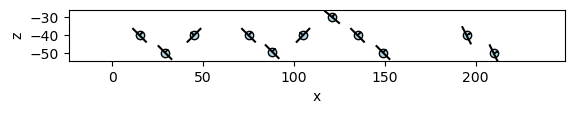

In [ ]:
dataset = load_dataset_from_csv("../inputs/sparse_data.csv", sep=";", index= "id", coordinate_labels=["x","y","z"], labels={"ID":"id", "dip": "dip", "strike":"dip_dir","name":"observed_object"})
#sp = PhysicalRepresentationSpace(coordinate_labels=["x","y","z"])
#sp.extension = [[0,230], [-40,-40], [-70,0]]
#section1 = AxisAlignedCrossSection(sp, )
section = AxisAlignedCrossSection(dataset.physical_space, )
section.draw(dataset)
#dataset.head()

### manually


In [ ]:
# initialize Interpretation Process
gip = GeologicalInterpretationProcess(dataset)
sp = gip.representation_space
gip.update_status()

#### Iteration 1

Iteration: 0


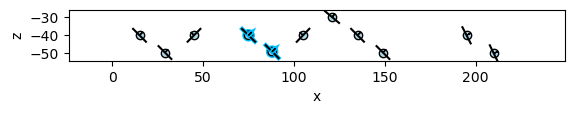

In [ ]:
# plan the iteration
gip.new_epoch()
print("Iteration:",gip.iteration.epoch)
gip.iteration.situation = InterpretationSituation(
    features= [mogi().D4,mogi().D5], process= gip
)
gip.iteration.interpretation_move = "NewInterpretation"
gip.show(section)


epoch: 0
situation: Features: mogi.D4, mogi.D5
Context: None
Candidate explaining class: mogi.Stratigraphic_Part
Explaining Object: mogi.stratigraphic_part1
Anomalies: mogi.dippingstratigraphyanomaly1
interpretation_move: NewInterpretation


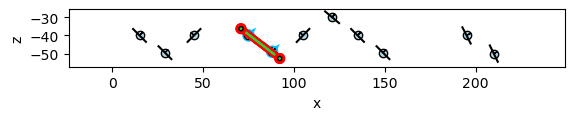

In [ ]:
# Do :  apply the move
gip.do()
gip.check()
gip.act()
gip.show(section)
print(gip.iteration)


#### Iteration 2

Iteration: 1
epoch: 1
situation: Features: mogi.D3
Context: None
Candidate explaining class: mogi.Stratigraphic_Part
Explaining Object: mogi.stratigraphic_part2
Anomalies: mogi.dippingstratigraphyanomaly2
interpretation_move: NewInterpretation


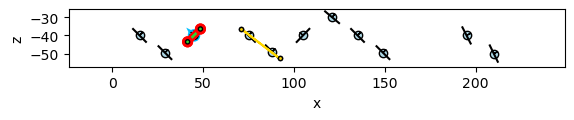

In [ ]:
# plan the iteration
gip.new_epoch()
print("Iteration:",gip.iteration.epoch)
gip.iteration.situation = InterpretationSituation(
    features= [mogi().D3], process= gip
)
gip.iteration.interpretation_move = "NewInterpretation"
gip.do()
gip.check()
gip.act()
gip.show(section)
print(gip.iteration)



#### Iteration 3

Iteration: 2


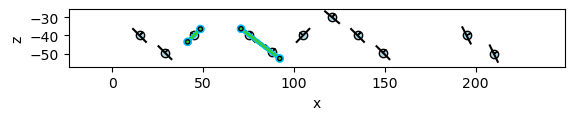

In [ ]:
# plan the iteration
gip.new_epoch()
print("Iteration:",gip.iteration.epoch)
gip.iteration.situation = InterpretationSituation(
    features= [gip.history[0].situation.explaining_object, gip.history[1].situation.explaining_object], process= gip
)
gip.iteration.interpretation_move = "NewInterpretation"
gip.show(section)

sides [mogi.shared_side_nb_1]
sides [mogi.shared_side_nb_1]
epoch: 2
situation: Features: mogi.stratigraphic_part1, mogi.stratigraphic_part2
Context: None
Candidate explaining class: mogi.Stratigraphic_Part
Explaining Object: mogi.stratigraphic_part3
Anomalies: mogi.internaldipvariationanomalytwoparts1
interpretation_move: NewInterpretation


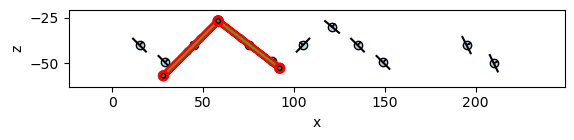

In [ ]:
gip.do()
gip.check()
gip.act()
gip.show(section)
print(gip.iteration)

In [ ]:
print("Interpreted Objects:\n- "+"\n- ".join([obj_i.name for obj_i in gip.interpreted_objects]))
print("\nAnomalies:\n- "+"\n- ".join([obj_i.name for obj_i in gip.anomalies]))

Interpreted Objects:
- stratigraphic_part1
- stratigraphic_part2
- stratigraphic_part3

Anomalies:
- dippingstratigraphyanomaly1
- dippingstratigraphyanomaly2
- internaldipvariationanomalytwoparts1


#### Iteration 4

Iteration: 3


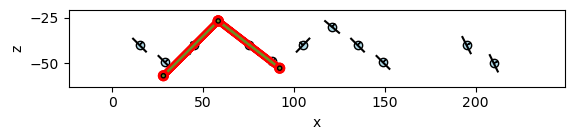

In [ ]:
# plan the iteration
gip.new_epoch()
print("Iteration:",gip.iteration.epoch)
gip.iteration.situation = InterpretationSituation(
    features= [gip.history[-1].situation.anomalies[0], gip.history[-1].situation.explaining_object], process= gip
)
gip.iteration.interpretation_move = "NewInterpretation"
gip.show(section)


Wrong condition for condition_fold_constructor_dipping_anomaly: no DippingStratigraphyAnomaly
Wrong condition for condition_fold_constructor_dip_variation_anomaly: no DipVariationAnomaly
passing all internal checks
will pass explanation check for folds
epoch: 3
situation: Features: mogi.internaldipvariationanomalytwoparts1, mogi.stratigraphic_part3
Context: None
Candidate explaining class: mogi.Chevron_Fold
Explaining Object: mogi.fold_nb1
Anomalies: None
interpretation_move: NewInterpretation


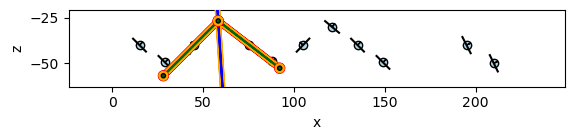

In [ ]:
gip.do()
gip.check()
gip.act()
gip.show(section)
print(gip.iteration)

In [ ]:
print("Interpreted Objects:\n- "+"\n- ".join([obj_i.name for obj_i in gip.interpreted_objects]))
print("\nAnomalies:\n- "+"\n- ".join([obj_i.name for obj_i in gip.anomalies]))

Interpreted Objects:
- stratigraphic_part1
- stratigraphic_part2
- stratigraphic_part3
- fold_nb1

Anomalies:
- dippingstratigraphyanomaly1
- dippingstratigraphyanomaly2
- internaldipvariationanomalytwoparts1


#### Iteration 6

Iteration: 4
epoch: 4
situation: Features: mogi.D1, mogi.D2
Context: None
Candidate explaining class: mogi.Stratigraphic_Part
Explaining Object: mogi.stratigraphic_part6
Anomalies: mogi.dippingstratigraphyanomaly3
interpretation_move: NewInterpretation


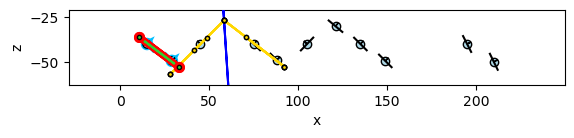

In [ ]:
# plan the iteration
gip.new_epoch()
print("Iteration:",gip.iteration.epoch)
gip.iteration.situation = InterpretationSituation(
    features= [mogi().D1, mogi().D2], process= gip
)
gip.iteration.interpretation_move = "NewInterpretation"
gip.do()
gip.check()
gip.act()
gip.show(section)
print(gip.iteration)


In [ ]:
print("Interpreted Objects:\n- "+"\n- ".join([obj_i.name for obj_i in gip.interpreted_objects]))
print("\nAnomalies:\n- "+"\n- ".join([obj_i.name for obj_i in gip.anomalies]))

Interpreted Objects:
- stratigraphic_part1
- stratigraphic_part2
- stratigraphic_part3
- fold_nb1
- stratigraphic_part6

Anomalies:
- dippingstratigraphyanomaly1
- dippingstratigraphyanomaly2
- internaldipvariationanomalytwoparts1
- dippingstratigraphyanomaly3


#### Iteration 7

Iteration: 5
sides [mogi.shared_side_nb_2, mogi.side1]
sides [mogi.shared_side_nb_2, mogi.side1]
sides [mogi.shared_side_nb_2, mogi.side1]
sides [mogi.shared_side_nb_2, mogi.side1]
sides [mogi.shared_side_nb_2, mogi.side1]


epoch: 5
situation: Features: mogi.stratigraphic_part3, mogi.stratigraphic_part6
Context: None
Candidate explaining class: mogi.Stratigraphic_Part
Explaining Object: mogi.stratigraphic_part7
Anomalies: mogi.internaldipvariationanomalymultiparts1
interpretation_move: NewInterpretation


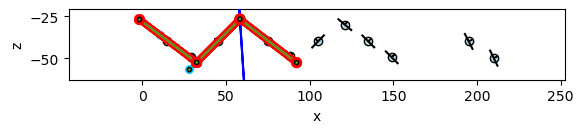

In [ ]:
# plan the iteration
gip.new_epoch()
print("Iteration:",gip.iteration.epoch)
gip.iteration.situation = InterpretationSituation(
    features= [gip.history[-3].situation.explaining_object,gip.history[-1].situation.explaining_object], process= gip
)
gip.iteration.interpretation_move = "NewInterpretation"
gip.do()
gip.check()
gip.act()
gip.show(section)
print(gip.iteration)

#### Iteration 8


Iteration: 6
sides [mogi.shared_side_nb_2, mogi.side1]
sides [mogi.shared_side_nb_2, mogi.side1]
sides [mogi.shared_side_nb_2, mogi.side1]
will pass explanation check for folds


epoch: 6
situation: Features: mogi.internaldipvariationanomalymultiparts1, mogi.D1, mogi.D2
Context: None
Candidate explaining class: mogi.Fold_Train
Explaining Object: mogi.fold_train1
Anomalies: None
interpretation_move: NewInterpretation


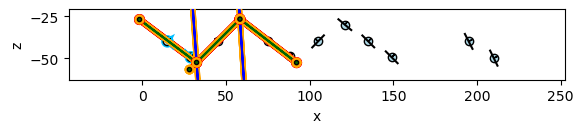

In [ ]:
# plan the iteration
gip.new_epoch()
print("Iteration:",gip.iteration.epoch)
gip.iteration.situation = InterpretationSituation(
    features= [gip.history[-1].situation.anomalies[0], mogi().D1, mogi().D2], process= gip
)
gip.iteration.interpretation_move = "NewInterpretation"
gip.do()
gip.check()
gip.act()
gip.show(section)
print(gip.iteration)

#### Forging manually the surfaces

In [ ]:
my_part1_coo = [[32., 0, -54.], [ 32.,   45, -54 ], [-2., 45., -25], [ -2.,   0, -25. ]]
my_part2_coo = [[32., 45, -54.], [ 32.,   0, -54 ], [58., 0., -26], [ 58.,   45, -26. ]]
my_part3_coo = [[58., 45., -26.], [ 58.,   0., -26 ], [93., 0., -54], [ 93.,   45, -54. ]]
my_part4_coo = [[115., 0., -25.], [ 115.,   45., -25 ], [93., 45., -54], [ 93.,   0, -54. ]]
my_part5_coo = [[115., 0., -25.], [ 155.,   0., -54 ], [155., 45., -54], [ 115.,   45, -25. ]]
my_part6_coo = [[191., 0., -25.], [ 191.,   45., -25 ], [155., 45., -54], [ 155.,   0, -54. ]]
my_part7_coo = [[191., 0., -25.], [ 213.,   0., -54 ], [213., 45., -54], [ 191.,   45, -25. ]]




In [ ]:
list_manual_coords = [my_part1_coo, my_part2_coo, my_part3_coo, my_part4_coo
                      , my_part5_coo, my_part6_coo, my_part7_coo]
list_nodes_manu = list_coords_to_list_nodes(list_manual_coords, mogi, sp.coordinate_labels)

In [ ]:
planars = list_of_planars_from_nodes(list_nodes_manu, mogi)
my_parts = list_of_parts_from_nodes(planars, mogi)

In [ ]:
final_cplx = mogi().Complex_Surface(has_Part = planars)
attribute_parts_nodes_to_complex_surface(final_cplx)
compute_center_complex_surface(mogi, sp, final_cplx )
final_part = create_surface_part(mogi, final_cplx)
final_cplx.non_planar = True
final_part.deformed = True
neighbor_constructor_from_multiple_planars(final_cplx, mogi, sp)

In [ ]:
anomaly = internal_dip_variation_anomaly_multi_parts_constructor(mogi, final_part)


#### Iteration 9

Iteration: 7
epoch: 7
situation: Features: mogi.internaldipvariationanomalymultiparts2
Context: None
Candidate explaining class: mogi.Fold_Train
Explaining Object: mogi.fold_train2
Anomalies: None
interpretation_move: NewInterpretation


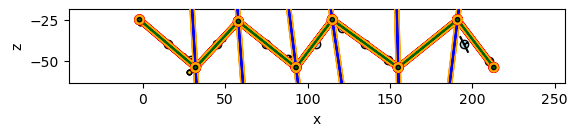

In [ ]:
# plan the iteration
gip.new_epoch()
print("Iteration:",gip.iteration.epoch)
gip.iteration.situation = InterpretationSituation(
    features= [anomaly], process= gip
)
gip.iteration.interpretation_move = "NewInterpretation"
gip.do()

gip.show(section)
print(gip.iteration)



epoch: 7
situation: Features: mogi.internaldipvariationanomalymultiparts2
Context: None
Candidate explaining class: mogi.Fold_Train
Explaining Object: mogi.fold_train2
Anomalies: None
interpretation_move: NewInterpretation


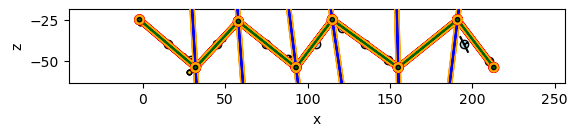

In [ ]:

gip.show(section)
print(gip.iteration)

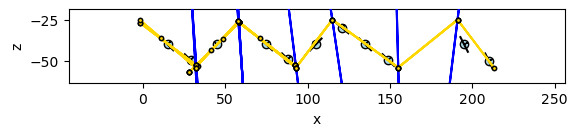

In [ ]:
gip.new_epoch()
gip.show(section, draw_explanation=False)

## Testing DataSet & Manual entries

In [ ]:
obs = mogi().search(type=mogi().PointBased_Observation)

In [ ]:
if len(obs) > 0 : 
    mogi.show_instance_qualities(obs[0])

instance: mogi.D1
types: mogi.PointBased_Observation
properties:
|- has_Representation:[mogi.D1_point]
|- is_Explained_By:[mogi.stratigraphic_part6]
|- polarity:[True]
|- is_Observation_Of:[mogi.Trias_Base]
|- size:[10]
|- occurrence:[True]
|- has_Center:[mogi.D1_point]
|- dip_dir:[90.0]
|- dip:[45.0]


In [ ]:
dataset= GeologicalDataset()
dataset.remove_all_observations()
print(dataset)

A dataset of type: GeologicalDataset
- The dataset is empty
- Extension: None
- Number of spaces this dataset is attached to: 1
 |- Physical space:Representation space of type: PhysicalRepresentationSpace
 | |- Number of dimension(s): 0
 | |- Coordinate label(s): []
 | |- Space extension:
 |- Temporal space: None


In [ ]:
dataset.head()

,dip_dir,dip,geology,occurrence
name,,,,


In [ ]:
dataset.get_observations(observation_type= mogi().PointBased_Observation)

[]

In [ ]:
mogi.show_all_instance_qualities(dataset.get_observations())

Number of instances: 0


In [ ]:
dataset.remove_observation_by_name("D8")
dataset.get_observations()

[]

In [ ]:
dataset.remove_all_observations()
print(dataset)

A dataset of type: GeologicalDataset
- The dataset is empty
- Extension: None
- Number of spaces this dataset is attached to: 1
 |- Physical space:Representation space of type: PhysicalRepresentationSpace
 | |- Number of dimension(s): 0
 | |- Coordinate label(s): []
 | |- Space extension:
 |- Temporal space: None


In [ ]:

physical_space = PhysicalRepresentationSpace(coordinate_labels= ["x","y","z"])
dataset.setup_representation_space(physical_space= physical_space)
dataset.add_occurrence_observation(name="DD", observed_object= "Keuper", x= 1, z= 2, y= 0, occurrence= True)
dataset.add_occurrence_observation(name="DN", observed_object= "Keuper",  x= 3, z= 1, y= 0)
dataset.update_extension()
print(dataset)

dataset.get_observations()

A dataset of type: GeologicalDataset
- Size of dataset: 2
- Types of data:
 |- occurrence:	2 entries
 |- orientation:	0 entries
- Extension:
 |- Coord x: [1.0, 3.0]
 |- Coord y: [0.0, 0.0]
 |- Coord z: [1.0, 2.0]
- Number of spaces this dataset is attached to: 2
 |- Physical space:Representation space of type: PhysicalRepresentationSpace
 | |- Number of dimension(s): 3
 | |- Coordinate label(s): ['x', 'y', 'z']
 | |- Space extension:
 | | |- Coord x: [0.6 3.4]
 | | |- Coord y: [-1.05  1.05]
 | | |- Coord z: [0.8 2.2]
 |- Temporal space: None


[mogi.DD, mogi.DN]

In [ ]:
dataset.head()

,x,y,z,dip_dir,dip,geology,occurrence,has_Representation,has_Center,size
name,,,,,,,,,,
DD,1.0,0.0,2.0,NaN,NaN,nan,True,mogi.DD_point,mogi.DD_point,0.10
DN,3.0,0.0,1.0,NaN,NaN,nan,True,mogi.DN_point,mogi.DN_point,0.28


In [ ]:
dataset.add_orientation_observation(name="DO", observed_object= "Trias", dip= 30, dip_dir= 270, x= 2, z= 2, y= 0)
print(dataset)

dataset.get_observations()

A dataset of type: GeologicalDataset
- Size of dataset: 3
- Types of data:
 |- occurrence:	3 entries
 |- orientation:	1 entries
- Extension:
 |- Coord x: [1.0, 3.0]
 |- Coord y: [0.0, 0.0]
 |- Coord z: [1.0, 2.0]
- Number of spaces this dataset is attached to: 2
 |- Physical space:Representation space of type: PhysicalRepresentationSpace
 | |- Number of dimension(s): 3
 | |- Coordinate label(s): ['x', 'y', 'z']
 | |- Space extension:
 | | |- Coord x: [0.6 3.4]
 | | |- Coord y: [-1.05  1.05]
 | | |- Coord z: [0.8 2.2]
 |- Temporal space: None


[mogi.DD, mogi.DN, mogi.DO]

In [ ]:
dataset.head()

,x,y,z,dip_dir,dip,geology,occurrence,has_Representation,has_Center,size,polarity
name,,,,,,,,,,,
DD,1.0,0.0,2.0,NaN,NaN,nan,True,mogi.DD_point,mogi.DD_point,0.10,NaN
DN,3.0,0.0,1.0,NaN,NaN,nan,True,mogi.DN_point,mogi.DN_point,0.28,NaN
DO,2.0,0.0,2.0,270.0,30.0,nan,True,mogi.DO_point,mogi.DO_point,0.28,True


### From file

In [ ]:
dataset = load_dataset_from_csv("../inputs/data_for_paper.csv", sep=";", index= "Id", coordinate_labels=["x","y","z"], labels={"ID":"Id", "strike":"dip_dir","name":"observed_object"})
print(dataset)

A dataset of type: GeologicalDataset
- Size of dataset: 24
- Types of data:
 |- occurrence:	0 entries
 |- orientation:	23 entries
- Extension:
 |- Coord x: [2.0, 198.0]
 |- Coord y: [7.0, 140.0]
 |- Coord z: [2.0, 18.0]
- Number of spaces this dataset is attached to: 1
 |- Physical space:Representation space of type: PhysicalRepresentationSpace
 | |- Number of dimension(s): 3
 | |- Coordinate label(s): ['x', 'y', 'z']
 | |- Space extension:
 | | |- Coord x: [-38.4 237.4]
 | | |- Coord y: [-28. 168.]
 | | |- Coord z: [-2.4 21.4]
 |- Temporal space: None


In [ ]:
dataset.head()

,x,y,z,dip_dir,dip,geology,occurrence,has_Representation,polarity,is_Observation_Of,size,has_Center
name,,,,,,,,,,,,
D1,198.0,22.0,2.0,1.00,45.0,nan,True,mogi.D1_point,True,mogi.unit_x,13.79,mogi.D1_point
D2,196.0,120.0,4.0,2.00,46.0,nan,True,mogi.D2_point,True,mogi.unit_x,13.79,mogi.D2_point
D3,191.0,15.0,9.0,0.01,46.0,nan,True,mogi.D3_point,True,mogi.unit_x,13.79,mogi.D3_point
D4,165.0,80.0,5.0,180.00,45.5,nan,True,mogi.D4_point,True,mogi.unit_x,13.79,mogi.D4_point
D5,152.0,67.5,8.0,2.00,44.0,nan,True,mogi.D5_point,True,mogi.unit_x,13.79,mogi.D5_point


In [ ]:
# illustrates errors because of wrong separator
try:
    dataset2= load_dataset_from_csv("../inputs/data_for_paper.csv", labels={"ID":"Id", "strike":"dip_dir","name":"observed_object"})
except Exception as e:
    print(e)
    gkf = GeologicalKnowledgeManager().get_knowledge_framework()
    observations = gkf.search(type=gkf().PointBased_Observation)
    gkf.remove_all_instances(observations)

Check the output and consider changing the separator with sep keyword or cahnge 'coordinate_label' parameter.


too many indices for array: array is 1-dimensional, but 2 were indexed


In [ ]:
# illustrates errors when leaving wrong labels
try:
    dataset3 = load_dataset_from_csv("../inputs/data_for_paper.csv", sep=";", index= "ID")
except Exception as e:
    print(e)
    gkf = GeologicalKnowledgeManager().get_knowledge_framework()
    observations = gkf.search(type=gkf().PointBased_Observation)
    gkf.remove_all_instances(observations)

Check the output and consider changing the separator with sep keyword or cahnge 'coordinate_label' parameter.


GeologicalDataset.add_observation() got multiple values for argument 'name'


### Manual creation

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data_head = np.array(['name', 'x', 'y', 'z', 'dip_dir', 'dip', 'observed_object','occurrence'])
data_array = np.array([['D1', 15, 20, 35, 270, 45, 'Trias_Base',True],
                       ['D2', 30, 25, 50, 270, 45, 'Trias_Base',True],
                       ['D3', 60, 30, 40, 90, 45, 'Trias_Base',True],
                       ['D4', 75, 15, 25, 90, 45, 'Trias_Base',True],
                       ['D5', 110, 20, 40, 270, 63, 'Trias_Base',True],
                       ['D6', 120, 20, 60, 270, 64, 'Trias_Base',True],
                       ['D7', 155, 20, 60, 89, 39, 'Trias_Base',True],
                       ['D8', 190, 20, 30, 91, 40, 'Trias_Base',True],
                       ['D11', 25, 22, 45, np.nan, np.nan, None ,True],
                       ['D22', 50, 22, 50, np.nan, np.nan, None,True],
                       ['D44', 100, 30, 20, np.nan, np.nan, None,True],
                       ['D77', 168, 30, 47, np.nan, np.nan, None,True]]
)
data_test = pd.DataFrame(data = data_array, columns = data_head)
data_test = data_test.astype({'name':str, 'x':float, 'y':float, 'z':float, 'dip_dir':float, 'dip':float, 'observed_object':str, 'occurrence':bool})
data_test.set_index("name", inplace = True)
data_test

,x,y,z,dip_dir,dip,observed_object,occurrence
name,,,,,,,
D1,15.0,20.0,35.0,270.0,45.0,Trias_Base,True
D2,30.0,25.0,50.0,270.0,45.0,Trias_Base,True
D3,60.0,30.0,40.0,90.0,45.0,Trias_Base,True
D4,75.0,15.0,25.0,90.0,45.0,Trias_Base,True
D5,110.0,20.0,40.0,270.0,63.0,Trias_Base,True
D6,120.0,20.0,60.0,270.0,64.0,Trias_Base,True
D7,155.0,20.0,60.0,89.0,39.0,Trias_Base,True
D8,190.0,20.0,30.0,91.0,40.0,Trias_Base,True
D11,25.0,22.0,45.0,NaN,NaN,None,True


In [ ]:
dataset = load_dataset_from_dataframe(data_test, coordinate_labels= ["x","y","z"])
print(dataset)

A dataset of type: GeologicalDataset
- Size of dataset: 12
- Types of data:
 |- occurrence:	12 entries
 |- orientation:	8 entries
- Extension:
 |- Coord x: [15.0, 190.0]
 |- Coord y: [15.0, 30.0]
 |- Coord z: [20.0, 60.0]
- Number of spaces this dataset is attached to: 1
 |- Physical space:Representation space of type: PhysicalRepresentationSpace
 | |- Number of dimension(s): 3
 | |- Coordinate label(s): ['x', 'y', 'z']
 | |- Space extension:
 | | |- Coord x: [-20. 225.]
 | | |- Coord y: [12. 33.]
 | | |- Coord z: [12. 68.]
 |- Temporal space: None


In [ ]:
dataset.head()

,x,y,z,dip_dir,dip,geology,occurrence,has_Representation,polarity,is_Observation_Of,size,has_Center
name,,,,,,,,,,,,
D1,15.0,20.0,35.0,270.0,45.0,nan,True,mogi.D1_point,True,mogi.Trias_Base,12.25,mogi.D1_point
D2,30.0,25.0,50.0,270.0,45.0,nan,True,mogi.D2_point,True,mogi.Trias_Base,12.25,mogi.D2_point
D3,60.0,30.0,40.0,90.0,45.0,nan,True,mogi.D3_point,True,mogi.Trias_Base,12.25,mogi.D3_point
D4,75.0,15.0,25.0,90.0,45.0,nan,True,mogi.D4_point,True,mogi.Trias_Base,12.25,mogi.D4_point
D5,110.0,20.0,40.0,270.0,63.0,nan,True,mogi.D5_point,True,mogi.Trias_Base,12.25,mogi.D5_point


In [ ]:
from IPython.display import display, HTML

chart = HTML(dataset.info().replace("\n","<br>"))
display(chart)

chart = HTML(dataset.to_dataframe().to_html())
display(chart)


,x,y,z,dip_dir,dip,geology,occurrence,has_Representation,polarity,is_Observation_Of,size,has_Center
name,,,,,,,,,,,,
D1,15.0,20.0,35.0,270.0,45.0,nan,True,mogi.D1_point,True,mogi.Trias_Base,12.25,mogi.D1_point
D2,30.0,25.0,50.0,270.0,45.0,nan,True,mogi.D2_point,True,mogi.Trias_Base,12.25,mogi.D2_point
D3,60.0,30.0,40.0,90.0,45.0,nan,True,mogi.D3_point,True,mogi.Trias_Base,12.25,mogi.D3_point
D4,75.0,15.0,25.0,90.0,45.0,nan,True,mogi.D4_point,True,mogi.Trias_Base,12.25,mogi.D4_point
D5,110.0,20.0,40.0,270.0,63.0,nan,True,mogi.D5_point,True,mogi.Trias_Base,12.25,mogi.D5_point
D6,120.0,20.0,60.0,270.0,64.0,nan,True,mogi.D6_point,True,mogi.Trias_Base,12.25,mogi.D6_point
D7,155.0,20.0,60.0,89.0,39.0,nan,True,mogi.D7_point,True,mogi.Trias_Base,12.25,mogi.D7_point
D8,190.0,20.0,30.0,91.0,40.0,nan,True,mogi.D8_point,True,mogi.Trias_Base,12.25,mogi.D8_point
D11,25.0,22.0,45.0,NaN,NaN,nan,True,mogi.D11_point,NaN,mogi.None,12.25,mogi.D11_point


#### Testing interpretation from features

In [ ]:
GeologicalKnowledgeManager().load_knowledge_framework()
mogi = GeologicalKnowledgeManager().get_knowledge_framework()
mogi.remove_all_instances()
mogi.sync_reasoner()
mogi.name

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp c:\Users\glaurent\Documents\Outils\Anaconda\envs\mogi\lib\site-packages\owlready2\hermit;c:\Users\glaurent\Documents\Outils\Anaconda\envs\mogi\lib\site-packages\owlready2\hermit\HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:///C:/Users/glaurent/AppData/Local/Temp/tmp2xctt1xn
* Owlready2 * HermiT took 0.8639678955078125 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


'mogi'

In [ ]:
data_head = np.array(['name', 'x', 'y', 'z', 'dip_dir', 'dip', 'observed_object','occurrence'])
data_array = np.array([['D1', 15, 20, 35, 270, 45, 'Trias_Base',True],
                       ['D2', 30, 25, 50, 270, 45, 'Trias_Base',True],
                       ['D3', 60, 30, 40, 90, 45, 'Trias_Base',True],
                       ['D4', 75, 15, 25, 90, 45, 'Trias_Base',True],
                       ['D5', 110, 20, 40, 270, 63, 'Trias_Base',True],
                       ['D6', 120, 20, 60, 270, 64, 'Trias_Base',True],
                       ['D7', 155, 20, 60, 89, 39, 'Trias_Base',True],
                       ['D8', 190, 20, 30, 91, 40, 'Trias_Base',True],
                       ['D11', 25, 22, 45, np.nan, np.nan, None ,True],
                       ['D22', 50, 22, 50, np.nan, np.nan, None,True],
                       ['D44', 100, 30, 20, np.nan, np.nan, None,True],
                       ['D77', 168, 30, 47, np.nan, np.nan, None,True]]
)
data_test = pd.DataFrame(data = data_array, columns = data_head)
data_test = data_test.astype({'name':str, 'x':float, 'y':float, 'z':float, 'dip_dir':float, 'dip':float, 'observed_object':str, 'occurrence':bool})
data_test.set_index("name", inplace = True)
dataset = load_dataset_from_dataframe(data_test, coordinate_labels= ["x","y","z"])
print(dataset)

A dataset of type: GeologicalDataset
- Size of dataset: 12
- Types of data:
 |- occurrence:	12 entries
 |- orientation:	8 entries
- Extension:
 |- Coord x: [15.0, 190.0]
 |- Coord y: [15.0, 30.0]
 |- Coord z: [20.0, 60.0]
- Number of spaces this dataset is attached to: 1
 |- Physical space:Representation space of type: PhysicalRepresentationSpace
 | |- Number of dimension(s): 3
 | |- Coordinate label(s): ['x', 'y', 'z']
 | |- Space extension:
 | | |- Coord x: [-20. 225.]
 | | |- Coord y: [12. 33.]
 | | |- Coord z: [12. 68.]
 |- Temporal space: None


In [ ]:
dataset.head()

,x,y,z,dip_dir,dip,geology,occurrence,has_Representation,is_Observation_Of,polarity,size,has_Center
name,,,,,,,,,,,,
D1,15.0,20.0,35.0,270.0,45.0,nan,True,mogi.D1_point,mogi.Trias_Base,True,12.25,mogi.D1_point
D2,30.0,25.0,50.0,270.0,45.0,nan,True,mogi.D2_point,mogi.Trias_Base,True,12.25,mogi.D2_point
D3,60.0,30.0,40.0,90.0,45.0,nan,True,mogi.D3_point,mogi.Trias_Base,True,12.25,mogi.D3_point
D4,75.0,15.0,25.0,90.0,45.0,nan,True,mogi.D4_point,mogi.Trias_Base,True,12.25,mogi.D4_point
D5,110.0,20.0,40.0,270.0,63.0,nan,True,mogi.D5_point,mogi.Trias_Base,True,12.25,mogi.D5_point


In [ ]:
mogi.show_instance_qualities(mogi().D1_point)

instance: mogi.D1_point
types: mogi.Point
properties:
|- has_Representation:[mogi.D1_point]
|- coord3:[35.0]
|- is_Representation_Of:[mogi.D1, mogi.D1_point]
|- coord1:[15.0]
|- coord3_label:['z']
|- coord2:[20.0]
|- coord1_label:['x']
|- has_Center:[mogi.D1_point]
|- coord2_label:['y']


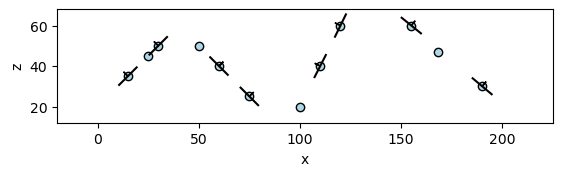

In [ ]:
section = AxisAlignedCrossSection(dataset.physical_space)
section.show()

[mogi.D11 mogi.D1 mogi.D2]
Number of instances: 3
instance: mogi.D11
types: mogi.PointBased_Observation
properties:
|- has_Representation:[mogi.D11_point]
|- occurrence:[True]
|- is_Observation_Of:[mogi.None]
|- size:[12.25]
|- has_Center:[mogi.D11_point]
instance: mogi.D1
types: mogi.PointBased_Observation
properties:
|- has_Representation:[mogi.D1_point]
|- occurrence:[True]
|- is_Observation_Of:[mogi.Trias_Base]
|- dip_dir:[270.0]
|- polarity:[True]
|- size:[12.25]
|- has_Center:[mogi.D1_point]
|- dip:[45.0]
instance: mogi.D2
types: mogi.PointBased_Observation
properties:
|- has_Representation:[mogi.D2_point]
|- occurrence:[True]
|- is_Observation_Of:[mogi.Trias_Base]
|- dip_dir:[270.0]
|- polarity:[True]
|- size:[12.25]
|- has_Center:[mogi.D2_point]
|- dip:[45.0]


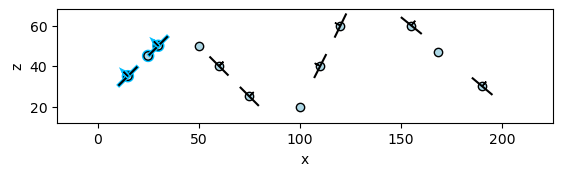

In [ ]:
situation = InterpretationSituation(
    [mogi().D11, mogi().D1, mogi().D2]#, mogi().D4,mogi().D5, mogi().D3]
)
section.show()
section.draw(situation)
print(situation.features)
mogi.show_all_instance_qualities(situation.features)

In [ ]:
interp = constructor_surface_part_from_interpretation(knowledge_framework= mogi, interpretation_situation= situation,
                                             physical_space= dataset.physical_space, name= "interp_surf",extension_factor=0.15)
mogi.show_instance_qualities(interp)
mogi.show_instance_qualities(interp.has_Representation[0])
mogi.show_instance_qualities(interp.has_Representation[0].has_Center[0])
mogi.show_all_instance_qualities(interp.explain)

instance: mogi.interp_surf
types: mogi.Stratigraphic_Part
properties:
|- has_Representation:[mogi.interp_surf_rep]
|- explain:[mogi.D11, mogi.D1, mogi.D2]
instance: mogi.interp_surf_rep
types: mogi.Planar_Surface
properties:
|- has_Representation:[mogi.point115, mogi.point116, mogi.point117, mogi.point118]
|- is_Representation_Of:[mogi.interp_surf]
|- has_Center:[mogi.interp_surf_rep_center]
|- has_Node2:[mogi.point117]
|- has_Node3:[mogi.point118]
|- dip_dir:[270.0]
|- has_Node1:[mogi.point116]
|- has_Normal:[mogi.interp_surf_rep_normal]
|- polarity:[True]
|- size:[40.248338626474556]
|- has_Node0:[mogi.point115]
|- dip:[45.0]
instance: mogi.interp_surf_rep_center
types: mogi.Point
properties:
|- has_Representation:[mogi.interp_surf_rep_center]
|- coord3:[43.333333333333336]
|- is_Representation_Of:[mogi.interp_surf_rep_center]
|- coord1:[23.333333333333332]
|- coord3_label:['z']
|- coord2:[22.333333333333332]
|- coord1_label:['x']
|- has_Center:[mogi.interp_surf_rep_center]
|- coord2

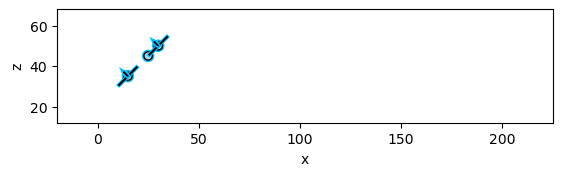

In [ ]:
section = AxisAlignedCrossSection(dataset.physical_space)
section.draw(situation)